In [1]:
import pickle
import logging
import pandas as pd
import spotipy

from spotipy.oauth2 import SpotifyClientCredentials
from datetime import datetime

logger = logging.getLogger()


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())



Pour avoir les playlist de l'utilisateur loggé:  
 current_user_playlists(limit=50, offset=0) 
On peut aussi avoir les playlists depuis un id entré manuellement   
Ou en passant par les id des utilisateur : on récuperere les playlists via user ID   
(user) user_playlist duquel on extrait l'id de la playlist dont on recupere les musiques avec  playlist(playlist_id, fields=None, market=None, additional_types=('track', ))   
puis  playlist_tracks(playlist_id, fields=None, limit=100, offset=0, market=None, additional_types=('track', )) ??

VERIFIER QUON PREND BIEN QUE DES TRACKS ET PAS DES PODCASTS OU AUTRE

In [4]:
playlists2 = spotify.playlist(playlist_id='2seEyHNHF6LiVzLRQjSwHn')


In [5]:
playlists = spotify.playlist_tracks(playlist_id='2seEyHNHF6LiVzLRQjSwHn')


In [6]:
playlists2['tracks']['items'] == playlists['items']

True

Similaire à celle dans import-nb: Factoriser ? 

In [7]:
list_playlist_id = ['2seEyHNHF6LiVzLRQjSwHn']

In [8]:
tracks_data_list = []

start = datetime.now()
print("start = ", start)
try:
    for playlist_id in list_playlist_id:
        track_results = spotify.playlist_tracks(playlist_id=playlist_id)
        while track_results: 
            for track in track_results['items']:
                single_track_dict = {                                       
                    'track_name': track['track']['name'],
                    'artist_name': track['track']['artists'][0]['name'],
                    'track_id': track['track']['id'] ,
                    'popularity': track['track']['popularity']
                }
                tracks_data_list.append(single_track_dict)
            track_results = spotify.next(track_results)
        print(f"Progression of playlists: {list_playlist_id.index(playlist_id)+1}/{len(list_playlist_id)}")
except Exception as e:
    logger.error(e)
end = datetime.now()
print("finish = ", end)
print("duration = ", (end-start).total_seconds())

start =  2022-07-07 12:14:56.469069
Progression of playlists: 1/1
finish =  2022-07-07 12:14:58.199487
duration =  1.730418


In [9]:
len(tracks_data_list)

660

In [10]:
df = pd.DataFrame(tracks_data_list)

In [11]:
df.duplicated().sum()

0

In [12]:
df.drop_duplicates(inplace=True)

In [13]:
df.shape

(660, 4)

In [14]:
def extract_audio_feature(ids_list):
    list_features = []
    try:
        list_features = spotify.audio_features(ids_list)
    except Exception as e:
        print(e)
        logger.info(e)
    return list_features

In [15]:
tracks_features_list = []

total_tracks = df.shape[0]

start = datetime.now()
print("start = ", start)
for tracks_nbr in range(0, total_tracks, 100):
    print(f"Progression of tracks: {tracks_nbr}/{total_tracks}")
    tracks_features_list += extract_audio_feature(','.join(df.track_id[tracks_nbr:tracks_nbr+100]))
remaining_tracks = total_tracks%100
if remaining_tracks:
    tracks_features_list += extract_audio_feature(','.join(df.track_id[-remaining_tracks:]))
end = datetime.now()
print("finish = ", end)
print("duration = ", (end-start).total_seconds())

start =  2022-07-07 12:14:58.251627
Progression of tracks: 0/660
Progression of tracks: 100/660
Progression of tracks: 200/660
Progression of tracks: 300/660
Progression of tracks: 400/660
Progression of tracks: 500/660
Progression of tracks: 600/660
finish =  2022-07-07 12:14:59.662597
duration =  1.41097


In [16]:
len(tracks_features_list)

720

In [17]:
tracks_features_list = [track for track in tracks_features_list if isinstance(track, dict)]

In [18]:
len(tracks_features_list)

720

In [19]:
df2 = pd.DataFrame(tracks_features_list)

In [20]:
df2.shape

(720, 18)

In [21]:
print(df2.duplicated().sum())
df2.drop_duplicates(inplace=True)
df2.shape

60


(660, 18)

In [22]:
final_df = df.set_index('track_id').join(df2.set_index('id'), how='inner')

In [23]:
final_df.shape

(660, 20)

In [24]:
final_df.sample(10)

,track_name,artist_name,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
5oLyUnHXzkgBzcEr73hiaC,Same Love (feat. Mary Lambert),Macklemore & Ryan Lewis,0,0.560,0.475,8,-9.050,1,0.1730,0.718,0.000022,0.0994,0.308,84.899,audio_features,spotify:track:5oLyUnHXzkgBzcEr73hiaC,https://api.spotify.com/v1/tracks/5oLyUnHXzkgB...,https://api.spotify.com/v1/audio-analysis/5oLy...,320035,4
4fEF8iLpMlSt3a02Vw532I,Like Eye Did,FIL BO RIVA,0,0.509,0.468,0,-8.147,1,0.0739,0.494,0.000005,0.0695,0.389,110.350,audio_features,spotify:track:4fEF8iLpMlSt3a02Vw532I,https://api.spotify.com/v1/tracks/4fEF8iLpMlSt...,https://api.spotify.com/v1/audio-analysis/4fEF...,236933,4
3eDfI95LLKOFEEZl5jrnnj,La Seine,Vanessa Paradis,0,0.741,0.642,2,-8.151,0,0.0304,0.530,0.000259,0.1080,0.358,113.092,audio_features,spotify:track:3eDfI95LLKOFEEZl5jrnnj,https://api.spotify.com/v1/tracks/3eDfI95LLKOF...,https://api.spotify.com/v1/audio-analysis/3eDf...,166053,4
7aUuoq4oMfLxaLa5GVUDHi,Way down We Go,KALEO,64,0.590,0.578,10,-5.798,0,0.0528,0.612,0.000162,0.0837,0.264,81.663,audio_features,spotify:track:7aUuoq4oMfLxaLa5GVUDHi,https://api.spotify.com/v1/tracks/7aUuoq4oMfLx...,https://api.spotify.com/v1/audio-analysis/7aUu...,219560,4
79PSn6Z4nX1a0OYVGA9y4j,Get Rid Of Your Ghosts,Land of Trees,0,0.638,0.214,7,-14.436,1,0.0328,0.818,0.000027,0.0906,0.316,113.833,audio_features,spotify:track:79PSn6Z4nX1a0OYVGA9y4j,https://api.spotify.com/v1/tracks/79PSn6Z4nX1a...,https://api.spotify.com/v1/audio-analysis/79PS...,258000,4
0ErpHxNt1kTyCQGlh43wr1,Only the Wild Ones,DISPATCH,67,0.492,0.700,8,-7.001,1,0.0437,0.413,0.000130,0.0996,0.605,110.741,audio_features,spotify:track:0ErpHxNt1kTyCQGlh43wr1,https://api.spotify.com/v1/tracks/0ErpHxNt1kTy...,https://api.spotify.com/v1/audio-analysis/0Erp...,253165,4
6iU1wS1dJh61wMBnoy55Mu,Guiding Light,The White Buffalo,34,0.539,0.326,0,-8.853,1,0.0263,0.611,0.000088,0.1870,0.290,128.133,audio_features,spotify:track:6iU1wS1dJh61wMBnoy55Mu,https://api.spotify.com/v1/tracks/6iU1wS1dJh61...,https://api.spotify.com/v1/audio-analysis/6iU1...,190476,3
3tMVYmTyrPqZ7Ux5tY5ige,In My Arms,Will Killen,38,0.520,0.239,4,-11.371,1,0.0534,0.844,0.001370,0.2050,0.204,82.448,audio_features,spotify:track:3tMVYmTyrPqZ7Ux5tY5ige,https://api.spotify.com/v1/tracks/3tMVYmTyrPqZ...,https://api.spotify.com/v1/audio-analysis/3tMV...,174250,5
4Y2yIyaoo0q7cM4OfVc9e2,Radioactive - Live from Spotify London,Tom Walker,40,0.520,0.563,4,-6.842,1,0.2520,0.725,0.000000,0.6850,0.576,142.096,audio_features,spotify:track:4Y2yIyaoo0q7cM4OfVc9e2,https://api.spotify.com/v1/tracks/4Y2yIyaoo0q7...,https://api.spotify.com/v1/audio-analysis/4Y2y...,207926,4
2bcC9Xyi40wnI7Od5uch31,Iron Sky,Paolo Nutini,64,0.387,0.626,1,-7.134,0,0.0344,0.242,0.001200,0.1100,0.316,139.724,audio_features,spotify:track:2bcC9Xyi40wnI7Od5uch31,https://api.spotify.com/v1/tracks/2bcC9Xyi40wn...,https://api.spotify.com/v1/audio-analysis/2bcC...,373133,4


In [25]:
columns = ['id', 'track_name', 'artist_name', 'popularity', 'duration_ms',
        'danceability', 'time_signature', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
        'instrumentalness', 'liveness', 'valence', 'tempo']

nominal_cols = ['id', 'track_name', 'artist_name']
discret_cols = ['key', 'mode']
continuous_cols = ['popularity', 'duration_ms', 'danceability', 'time_signature', 'loudness', 'speechiness',
        'instrumentalness', 'liveness', 'valence', 'tempo', 'acousticness*energy'] 
useful_cols = discret_cols + continuous_cols

In [26]:
final_df['acousticness*energy']=final_df['acousticness']*final_df['energy']

In [27]:
final_df=final_df[useful_cols]

In [28]:
# from sklearn import metrics
# def cv_silhouette_scorer(estimator, X):
#     estimator.fit(X)
#     cluster_labels = estimator['model'].labels_
#     num_labels = len(set(cluster_labels))
#     num_samples = len(X.index)
#     if num_labels == 1 or num_labels == num_samples:
#         return -1
#     else:
#         return metrics.silhouette_score(X, cluster_labels)

In [29]:
import pickle
model = pickle.load(open('fullbirch3276+75.sav', 'rb'))

In [30]:
model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('scale',
                                                                   MinMaxScaler())]),
                                                  ['key', 'mode', 'popularity',
                                                   'duration_ms',
                                                   'danceability',
                                                   'time_signature', 'loudness',
                                                   'speechiness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo',
                                                   'acousticness*energy'])])),
                ('model', Birch(branching_factor=25, n_clusters=75))])

In [31]:
final_df.shape

(660, 13)

In [32]:
import numpy as np

In [33]:
df['prediction']=model.predict(final_df)

In [34]:
df

,track_name,artist_name,track_id,popularity,prediction
0,Postcards,James Blunt,64tit6tIpq48NSqTMzRf2d,0,2
1,Washing Dishes,Jack Johnson,22RxilGS5NSRe2ELlyKeTi,60,18
2,You're Beautiful,James Blunt,0vg4WnUWvze6pBOJDTq99k,76,3
3,Bad Day,Daniel Powter,0mUyMawtxj1CJ76kn9gIZK,76,32
4,I'm Yours,Jason Mraz,1EzrEOXmMH3G43AXT1y7pA,81,18
5,"Free Fallin' - Live at the Nokia Theatre, Los ...",John Mayer,4LloVtxNZpeh7q7xdi1DQc,72,16
6,Banana Pancakes,Jack Johnson,0BgbobvykXxEvxo2HhCuvM,70,18
7,"Sitting, Waiting, Wishing",Jack Johnson,1dnXuEuApvuVqQCn0v9McL,68,32
8,Orange Sky,Alexi Murdoch,5Szn0p3DlnawyuhX8ULCg4,0,6
9,All My Days,Alexi Murdoch,3enNOrgPG8VH9WEMzr6yPC,0,31


In [35]:
len(model.predict(final_df))

660

In [36]:
df['prediction'].value_counts()

6     106
24     90
2      85
72     77
18     41
5      39
14     35
32     33
3      33
9      25
68     18
29      9
73      6
4       5
57      5
69      5
19      5
54      4
15      4
13      4
20      4
60      3
11      2
42      2
25      2
50      2
16      2
23      2
7       1
36      1
63      1
64      1
17      1
55      1
0       1
21      1
53      1
27      1
31      1
12      1
Name: prediction, dtype: int64

In [37]:
df[['prediction', 'track_name', 'artist_name']].sort_values(by='artist_name')

,prediction,track_name,artist_name
391,72,Plus tard,47ter
346,2,Club of Optimistic People,77 Bombay Street
108,3,47 Millionaires,77 Bombay Street
469,16,That's Life (feat. Mac Miller & Sia),88-Keys
128,6,Six Years,A Blaze of Feather
457,15,Shorty Don't Wait,A Great Big World
381,2,Three Weeks,A Tale of Golden Keys
459,69,Breakin' Ground,AHI
119,6,Ol' Sweet Day,AHI
131,72,Making All Things New,Aaron Espe


Faire des paliers de suivant si on aime ou pas : + de 50%, de 50% à 5%, de 5% à 1%, de 1% à 0+%, et 0%    
Ptet faire entrer en compte la taille de la playlist pour ponderer (pas forcément necessaire)

In [38]:
playlists = spotify.playlist_tracks(playlist_id='2seEyHNHF6LiVzLRQjSwHn')

In [39]:
playlistsbis = spotify.playlist_items(playlist_id='2seEyHNHF6LiVzLRQjSwHn', additional_types=('track',))

In [40]:
playlists == playlistsbis

True

In [41]:
len(df['prediction'])

660

In [42]:
thresh = 0.03
liked_clusters = df['prediction'].value_counts()[df['prediction'].value_counts() >= thresh*len(df['prediction'])].index

In [43]:
53 in liked_clusters

False

In [44]:
df['prediction'].values[0]

2

In [45]:
reslts = spotify.tracks(['3JEye8rsrvGdlrBvZUgNIL','3JEye8rsrvGdlrBvZUgNIL'])

In [46]:
reslts['tracks'][0]['popularity']

50

In [47]:
for item in reslts['tracks']:
    print(item['name'])
    print(item['artists'])
    print(item['artists'][0]['name'])
    print(item['id'])
    print(item['popularity'])

Atlas Hands
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/7D5oTJSXSHf51auG0106CQ'}, 'href': 'https://api.spotify.com/v1/artists/7D5oTJSXSHf51auG0106CQ', 'id': '7D5oTJSXSHf51auG0106CQ', 'name': 'Benjamin Francis Leftwich', 'type': 'artist', 'uri': 'spotify:artist:7D5oTJSXSHf51auG0106CQ'}]
Benjamin Francis Leftwich
3JEye8rsrvGdlrBvZUgNIL
50
Atlas Hands
[{'external_urls': {'spotify': 'https://open.spotify.com/artist/7D5oTJSXSHf51auG0106CQ'}, 'href': 'https://api.spotify.com/v1/artists/7D5oTJSXSHf51auG0106CQ', 'id': '7D5oTJSXSHf51auG0106CQ', 'name': 'Benjamin Francis Leftwich', 'type': 'artist', 'uri': 'spotify:artist:7D5oTJSXSHf51auG0106CQ'}]
Benjamin Francis Leftwich
3JEye8rsrvGdlrBvZUgNIL
50


In [58]:
y=model.predict(final_df)

In [53]:
final_df.sample()

,key,mode,popularity,duration_ms,danceability,time_signature,loudness,speechiness,instrumentalness,liveness,valence,tempo,acousticness*energy
4a5WbXXNV0ZYycP806lE1X,10,0,0,224082,0.472,4,-7.11,0.271,0.000003,0.0802,0.431,149.789,0.250323


In [75]:
len(y)

660

For n_clusters = 75 The average silhouette_score is : 0.06897803709033176


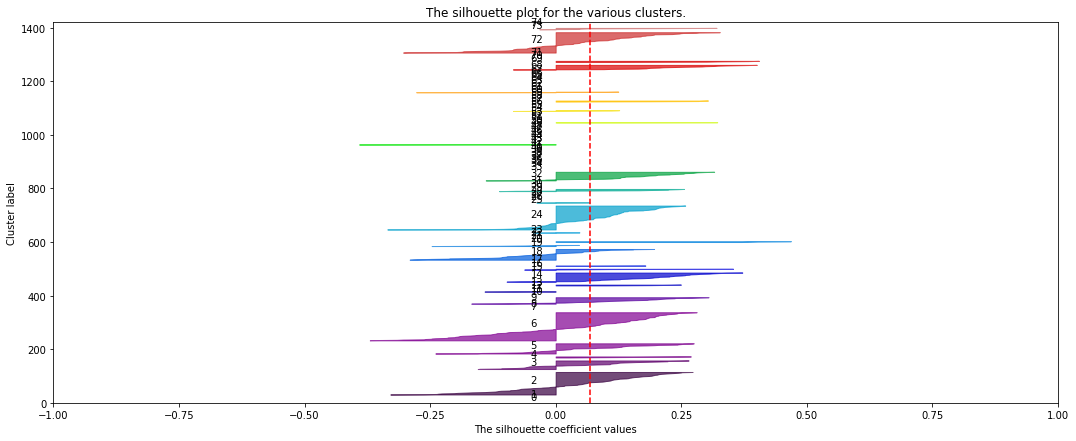

In [74]:
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(
#     n_samples=500,
#     n_features=2,
#     centers=4,
#     cluster_std=1,
#     center_box=(-10.0, 10.0),
#     shuffle=True,
#     random_state=1,
# )  # For reproducibility

X=final_df


range_n_clusters = [75]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
#     fig, (ax1, ax2) = plt.subplots(1, 2)
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
#     clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = model.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(model.named_steps.preprocess.transform(X), cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(model.named_steps.preprocess.transform(X), cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

#     ax1.set_yticks([])  # Clear the yaxis labels / ticks
#     ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


plt.show()

Doit avoir a peu près la même hauteur
Et la même largeur pour avoir des groupes de tailles similaires, ce qui n'est pas forcément notre cas actuellement
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

In [48]:
final_df

,key,mode,popularity,duration_ms,danceability,time_signature,loudness,speechiness,instrumentalness,liveness,valence,tempo,acousticness*energy
64tit6tIpq48NSqTMzRf2d,11,1,0,286973,0.723,4,-8.312,0.0301,0.000000,0.2520,0.6770,100.016,0.349222
22RxilGS5NSRe2ELlyKeTi,10,1,60,203947,0.804,4,-4.976,0.0336,0.000000,0.1050,0.7320,120.085,0.242436
0vg4WnUWvze6pBOJDTq99k,0,0,76,209493,0.675,4,-9.870,0.0278,0.000018,0.0880,0.4540,81.998,0.303207
0mUyMawtxj1CJ76kn9gIZK,3,1,76,233640,0.599,4,-4.013,0.0309,0.003360,0.1510,0.5200,140.046,0.351680
1EzrEOXmMH3G43AXT1y7pA,11,1,81,242947,0.703,4,-9.331,0.0417,0.000000,0.0973,0.7120,150.960,0.248196
4LloVtxNZpeh7q7xdi1DQc,5,1,72,263573,0.315,4,-13.262,0.0315,0.000000,0.7020,0.4350,173.509,0.228216
0BgbobvykXxEvxo2HhCuvM,7,1,70,191907,0.814,4,-8.017,0.1160,0.000017,0.0931,0.6320,114.548,0.224546
1dnXuEuApvuVqQCn0v9McL,0,1,68,183720,0.766,4,-7.250,0.0264,0.000015,0.1040,0.5560,105.010,0.125263
5Szn0p3DlnawyuhX8ULCg4,2,1,0,379520,0.685,4,-20.543,0.0390,0.046100,0.1000,0.1250,124.956,0.119550
3enNOrgPG8VH9WEMzr6yPC,2,1,0,297307,0.438,4,-15.969,0.0305,0.758000,0.1060,0.5290,88.446,0.251372


In [49]:
import requests

In [50]:
final_df.to_json()

'{"key":{"64tit6tIpq48NSqTMzRf2d":11,"22RxilGS5NSRe2ELlyKeTi":10,"0vg4WnUWvze6pBOJDTq99k":0,"0mUyMawtxj1CJ76kn9gIZK":3,"1EzrEOXmMH3G43AXT1y7pA":11,"4LloVtxNZpeh7q7xdi1DQc":5,"0BgbobvykXxEvxo2HhCuvM":7,"1dnXuEuApvuVqQCn0v9McL":0,"5Szn0p3DlnawyuhX8ULCg4":2,"3enNOrgPG8VH9WEMzr6yPC":2,"7885mFKPXjWNyxkOvuFK1j":7,"0W6jxWbCr1dggn7FSRiOlE":7,"45Fv2USVNPp5hAzsEvqEV9":6,"5taEW4DlLOP988LcZwwQsQ":4,"4vA4lbOawrlzLQC7j4qbhf":8,"1c1AycGt3OdbJfllWukD22":5,"7xyYsOvq5Ec3P4fr6mM9fD":9,"1mcAoChxake59V0CP54XDA":0,"2YEVwrM4IuyPxRyw1hEbkF":2,"4s11kEmSXnuwEon6MXtCqc":3,"6T97p73YEfYN77MRVcEPdc":1,"72WZtWs6V7uu3aMgMmEkYe":0,"2TRzWpRglCCg0oKDi91kMk":8,"5XEbKVbZEQ1MOfw3BIP3g5":11,"2UKARCqDrhkYDoVR4FN5Wi":2,"3erAiWBiKsbVG39cqCrsI0":11,"3lwcrfL6LfZ1p9ZU8KRx4n":7,"7aUuoq4oMfLxaLa5GVUDHi":10,"6oD0TvHIYmObKNl5Mz05ri":9,"1WOxmQAMnyvTdTuzZhuTBo":2,"6vSi3O5iG7tBRArn3oxpbS":11,"10EfsZGl58dUqHPWhBOqKe":6,"4alxFhUVH3XC36p74T228B":11,"66qlqxhEMpSHOzjRK4il0b":2,"3jqv8NVlVhyKKNISGGgKZ8":9,"2bW7OEawVDTwM0nLQ5gmtk":9,"5Aq5TIy9jV

In [51]:
res = requests.get('http://localhost:5000/prediction', json=final_df.to_json())

ConnectionError: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /prediction (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f99aea269a0>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
res

In [ ]:
res.json()

In [ ]:
final_df2 = final_df

In [ ]:
final_df2['prediction'] = res.json()

In [ ]:
final_df2['prediction'].value_counts()

In [ ]:
jsoned_to_df = {"key":{"64tit6tIpq48NSqTMzRf2d":11,"22RxilGS5NSRe2ELlyKeTi":10,"0vg4WnUWvze6pBOJDTq99k":0,"0mUyMawtxj1CJ76kn9gIZK":3,"1EzrEOXmMH3G43AXT1y7pA":11,"4LloVtxNZpeh7q7xdi1DQc":5,"0BgbobvykXxEvxo2HhCuvM":7,"1dnXuEuApvuVqQCn0v9McL":0,"5Szn0p3DlnawyuhX8ULCg4":2,"3enNOrgPG8VH9WEMzr6yPC":2,"7885mFKPXjWNyxkOvuFK1j":7,"0W6jxWbCr1dggn7FSRiOlE":7,"45Fv2USVNPp5hAzsEvqEV9":6,"5taEW4DlLOP988LcZwwQsQ":4,"4vA4lbOawrlzLQC7j4qbhf":8,"1c1AycGt3OdbJfllWukD22":5,"7xyYsOvq5Ec3P4fr6mM9fD":9,"1mcAoChxake59V0CP54XDA":0,"2YEVwrM4IuyPxRyw1hEbkF":2,"4s11kEmSXnuwEon6MXtCqc":3,"6T97p73YEfYN77MRVcEPdc":1,"72WZtWs6V7uu3aMgMmEkYe":0,"2TRzWpRglCCg0oKDi91kMk":8,"5XEbKVbZEQ1MOfw3BIP3g5":11,"2UKARCqDrhkYDoVR4FN5Wi":2,"3erAiWBiKsbVG39cqCrsI0":11,"3lwcrfL6LfZ1p9ZU8KRx4n":7,"7aUuoq4oMfLxaLa5GVUDHi":10,"6oD0TvHIYmObKNl5Mz05ri":9,"1WOxmQAMnyvTdTuzZhuTBo":2,"6vSi3O5iG7tBRArn3oxpbS":11,"10EfsZGl58dUqHPWhBOqKe":6,"4alxFhUVH3XC36p74T228B":11,"66qlqxhEMpSHOzjRK4il0b":2,"3jqv8NVlVhyKKNISGGgKZ8":9,"2bW7OEawVDTwM0nLQ5gmtk":9,"5Aq5TIy9jVK70aL7xcE9oa":9,"2M9ro2krNb7nr7HSprkEgo":4,"5MzuGYSmZ0jGaQfaImdR30":0,"0YMFcrMtBowDdD5bPz0cgy":7,"0QTCTu0CXv4X1JEE4gNpGv":8,"7thzIJfxiZNZaPFA5OR9s1":7,"6wZI4mdT8JwXgkGURnBQiq":10,"7x46YkKAwp3yZpaa72n5Mu":0,"1NyFRrFiJAJIaR6icj1goI":4,"10ViidwjGLCfVtGPfdcszR":2,"3JvrhDOgAt6p7K8mDyZwRd":1,"05lBuZWQ2OhQuzoCSIkvUF":1,"7AwvxYLlFmdoz0hQgyKtNU":1,"6b5rA9rthDbZDOQp9UbOgl":5,"33e9HtOfO1ye1h8xQ7Foc9":4,"4o0NjemqhmsYLIMwlcosvW":0,"6X0OpZij7I99x2ZXQZHfRj":0,"3eDfI95LLKOFEEZl5jrnnj":2,"1hAHdA0gbhG6HWfqdUskA3":8,"0hnNC8f9FgsMjMqO4AIDxB":7,"2WHyBkBS2Pbo2aNEEaLPRC":11,"5HF5PRNJ8KGtbzNPPc93tG":3,"429EttO8gs0bDo2SQfUNSm":11,"5eVhNIrZkJjrmZ1YIQegKL":0,"1xj5H1zS79wBfbAi1j1V6I":6,"2kGL9Psld2b7ui4H7IDtsa":0,"6bAm2mmI8L7BCFYvgubRfF":9,"511JLiR4EXSjnU8yPdb2yx":9,"3I05foFixB2sSZvV5Ppty8":9,"1RFiPhSVz3Kfp35MwGAfYI":0,"7LsBNd794zcDg6TvRx70eI":8,"08cXy6KUizaAelYXtcew3w":1,"4Wd9SzKSSRgdDoplBlsRSK":4,"6zYqyOJuyXDOvWJwKkZ8tg":0,"6PRr6dzkiaLTGbkLSdQCvL":9,"1ToaEJHSGXILPEIvLcj2if":1,"23tDyaKIRBPXgwBwz1jE4K":4,"1P7HuYbArPtdqlx4DIz2KG":2,"49Y4wwiD7ji8oFpNh5IKRL":4,"0L1qw4b03vhoFj3ZUuo45x":0,"2vaoKrieU38LtJAYWXpeju":9,"1pRb7DlOyLPGcBJUJoAKOo":8,"3Y7fpFZbHLpAvWJJYGehz0":0,"1g2EmXJwx7g8AcYiZLD3xG":7,"2gaAfTcqcGe124BpqKeeSg":4,"1PvFDYQr8TklPV5aetTdTx":5,"3869c1bl5bJqdD3cyDw8hh":10,"4BAJHily1jKE6nvTSlIcvv":1,"0wvCSSMj3gkLeJPl8E2FrK":1,"03RFScByLwJTxTme6n4BpP":6,"0zgKXGJ5KvMbVXwLp5AoQw":10,"2Dui4piWLMCs9nwa8E2F6d":9,"4FhKVxgelC7KGzjlW8HM2f":6,"6XMYnm4OTEysN8blzqiCL9":11,"0lExg3X6WfRs9TmVEaP2c7":7,"3ZuhwcFtlQAC8s93HyfFrk":1,"5MrbtclfNwKSRB4tqYfjgs":0,"2SpozQtbh6FM9fuR06mK6j":9,"0wx0JoQ8FYcE4tHIHpdBgn":2,"0QdrAzNM4o0E11qLmMC2vg":11,"7dld7rgICY8dTDN3r9WEzv":9,"46C8wq94GwkkkEYaej9N1D":3,"7trx783SvnHhKkmgSSTIFJ":1,"1dzk5fQIYJ3MMmgoRVw2qw":5,"5kumEbD8UGkkW82VE5lAmH":9,"4vx0FK5GfHdFSSNMRMeuLa":2,"2V8Db0suxVDK4fAU8qI2pI":2,"1dICy504gJyqSVwgtujei6":8,"2M7FVsfSsarRaHXwY3fbzo":4,"6QHGyXR0m3PDStlyHN8dYK":6,"2vbjIa2k1fklPtF7hDk0rH":7,"6dVa7xk5dOoT6pOkDw1TMH":10,"12GTNKbro3n7ef9ZmOIf4a":4,"0wUoZywSfSu4QppV2uEYCt":9,"41yIvlFgvGwxq8qTqAR7eG":1,"7eGpQgpepXm1MJ80Zhoipv":9,"1TDk2Jmi4dVZhm2dum3Jim":9,"1bx7OUl2UmAnA5oZkm9If7":8,"4dxzf0bWuBb0AYs25VNL3y":2,"4GAAt8cno6lZpYxR4MHHDf":1,"3rtks50x9pEN9tsaKPwS2P":8,"10IpSi7105dMkhJCVholdC":8,"4yxL6eoSsZ04lN0VezKgcr":6,"5FJGb4bs2Y4BbiX59zXksH":3,"4AWJ1TIwQFiUab7kzYKtFa":11,"6nl9BAvm7wMV2mEEChRzA9":9,"29exT2BeegsZ8DcTYTwIUq":7,"4XwUgMd8BZLVC46T70oAHI":6,"4YBpSRC9UZeQXzgY0X9T4h":11,"7E0cpERCs0tyGAlfvCpb4U":9,"4G3hSkxl4p3sOSL2NpyRu6":9,"0iOwPzPty8LYMTMT7kdQPS":4,"7DeJ8TdwgNpz6Un0SiskhX":0,"552EFT4FMXTgeUoLRlUtlN":1,"1XZkp1rKR0SeIFobNGNgu2":3,"59yRjmpE2VtyiEot3Ff9LM":0,"0nXQJBEDzMLVaMOvtXGYSX":7,"0K9mjg5RK4Yxwfd7cBPn18":3,"6I2iLtqLCdEKeoXpRv7is2":10,"0X59ez0KEga5FSpf5zcohp":9,"4fEF8iLpMlSt3a02Vw532I":0,"20UzZa35OWmQa3bwrT6ncp":0,"086Vv3WnRg1ygAGVnVRynh":1,"65r1CstIgv25lotffPEVQP":4,"6pFsQ19Z0sWeRSQn1VixmQ":2,"1HJkuUeJ80E3PhjQ7y4FVn":2,"4TdmtC98LGbdf6oT4vU4sN":3,"5yQWk2KWtPa4p7p4rCMr2A":5,"0O2t6ZqUyXze505PIxc2mz":10,"2AtPuyBiHtA6b0OLVv3Dfy":1,"0ZDg8qno6cuMMOW28UMEXH":0,"79PSn6Z4nX1a0OYVGA9y4j":7,"6O91vI8X3mnyq2SHJV9U4L":4,"7p2RlyF403KmPmZm2TxKl3":8,"7wahqDDzUPpJy91bVFHUF3":0,"51lFqoOmFK5SERoulCZRSb":3,"4CJVkjo5WpmUAKp3R44LNb":7,"7BVwi9cIzSc6tpyxsp47vJ":7,"7bTwYGhBdSQ8vuXc76Xint":5,"2puwQK3NFMAtLkE24aWCU5":11,"1H8z0t1ivQNml9d9F61kiA":7,"5k5qLGwbWEwmP6Bp3gc8WB":1,"5ClDPw47BORurTM0yTwuS7":5,"25tbnjnjZjXIYrfgqGKxpG":5,"7GZJnxwgcgZqV1bEoFNuJq":6,"6JKAzUVLuznWCbGZYiGe3n":1,"6V40ngtXtFJ1GDdmM70lF8":9,"3SgnYOV9ONL0bIHaAcOYE1":11,"10znXCse0n6fZQWKWzqOop":0,"0YsgWDcnhQEXChiMUtah1d":3,"5do7Ql6G8N03fY6G9Y08Ec":7,"05u81UgU27g8uL5twJ7ABz":5,"2HgstUJluLuIMtW02cY46p":0,"7MUNNBJKYo3cdokp06wEOB":5,"1fz0dajTaoPzs8PpVKAy8B":3,"6sczEuJNSAxnHshhzsy2i1":1,"7412fpVfB2PSSb1nENQczC":2,"4ToSbnK7fD5vE9R5sgWPsy":8,"3d9DChrdc6BOeFsbrZ3Is0":4,"3tchJ8gDgMdaSxpaLxlr1F":0,"51eAlywxa9QTAFoAh1SjBE":0,"0r7EiYTNNP0WCzcaefN6TZ":10,"1lHpPXDvH0NP9xyz6EmnRy":7,"2M1rPFbCrrv4gWKy906hVu":3,"2bcC9Xyi40wnI7Od5uch31":1,"2Io0MxW6atyfMzXLyCh4aV":0,"2I3D1f3jdWVojq4RK2Eqa3":5,"3Q7z3b5DRnyQOMFGyCMhnc":5,"3E6Ydoy1H8ePoigc10Mgsa":1,"248OFOZef6ShXv6DGgbnxU":10,"04EDShdWyBr2aJPqjFjKAQ":11,"2TjLRCgnOwgNtmZ38OJ6pj":7,"1b8Zlu3aMVxEbyeospYPrK":8,"4IqwQMYVev1jX8kze82JWi":3,"3LTMnFa0hhwisyq6ILahyj":5,"7uLgpb9VlCbfNYjFmGyr6t":0,"4ZeCZyI1Zhh1tVkThl34px":5,"0LAa17T9ZG7A4wg2CCATlL":8,"1pxV0DY4TrhKU4LImyZfzs":11,"0ycq5CMqmnQjMzYPU8XxA0":3,"2DSAJF477Cf5OdKucIiCYG":0,"1YY2l5k7QmWoEWBprsmTuL":2,"38iPfrSkvXa7SM7L7i6ipm":10,"2A7CF7mfADmmlCh55wn9oj":1,"6liNJDyWJjyHAgDnAX95bw":5,"1AZ3kCJfnyJt5O3broFxAD":10,"3M0pROlXyH0bzh9CNJhDOJ":4,"3oeGNFcvPjFpwZHuLj1t9Y":9,"0pU1HbVdZbEjEfIwm6LVrt":9,"4O0Yww5OIWyfBvWn6xN3CM":7,"5g7rJvWYVrloJZwKiShqlS":3,"6KprCGVC5o2Ibj2wCtaxEV":0,"3C0tW8SMfSk0jjd9WDASa2":9,"2eFNfCCSgMYqqA6iD2eAHd":9,"45FrYVS9BScbfO8lujdsW0":8,"0SoRzzXD7NRB4Oa7Y7sxUy":8,"1LxPLC9lAoaQMAn7M9FQi1":10,"38a8fbyksnUHXAF1WnLXXM":1,"3AhXZa8sUQht0UEdBJgpGc":0,"3vSMaH0fcLIi2Cld5pEoGU":4,"7K2L2Cw2hiLZ8HFYq5mSxK":1,"1lqGmKAtGz2YPvYVS0DkhH":9,"2krh4aw1Q3FaoGoPkep0L4":2,"2TkbdIwr5UmOMqUcQmD5sE":5,"0lsbbaa7nj7LtUXVdk0BQe":9,"5xNf5Ews4MNKSfBsIDwpRH":1,"59jyjMxUustKCD6nYHfyEC":0,"2k2CZ1dJClLmDO2TVGsz1R":5,"18rF7G33G8BDeflgTSjCXG":6,"0szmjOw9XbtbQYWz0GvXSp":6,"2c62Xf5Po1YSa1N6LOjPHy":0,"696vpg0aBvBxpZAuasmg15":2,"1yJZwBqTyGTB7mz8nZyiel":5,"6Od2OWvoT4embWAgIGeFRd":7,"7oekneJCJO74ycdLzdk16v":5,"0tp63L82d21GTlvZuKSHGY":0,"5J7zqPpQkN9JZiaELHNKSL":4,"2RiBogNRfulkNf7fVbPOrJ":8,"0fqjy5gVNVmQQmxOLLfb3c":7,"6Qwuw0eOeszVlewLpu24gR":7,"3BWlLiQSXXxy3OpL59k7lN":1,"17FEpCqKLVOIMHp35sUIlg":7,"4OFx2sTI1L2lJWiJCCTECL":0,"12wGk5iut9ABU3vsSF3uxM":10,"1SqtvHdK7YCSPFJLZ0a3ZD":0,"6KxtHlxcVPyusnlLjC7jdG":2,"6j0OqIhUxvOgGPTXxNj124":6,"5Zjj8dOtrhLH4JwQJMt5fG":7,"2hCKzqwjRjhycKeZJvbloJ":5,"4ORCdEPIKuvJzegSSCrjQk":0,"6vJZnE3jJWfxOIVONjntUO":4,"7cYq8I8W74RVDAG1IilnaB":0,"5Jw9wQcuEe2PTHoryL3XgB":10,"3D5RkmZmTOikPlwBVMApoW":8,"3n98re0h5dIpWIsbuAYeFr":2,"5HVHYpNllysLkUEduWKqlg":11,"1bDbdvmz2wmz2YzVUeW7Em":8,"2bpakUfcSUlnWzyRYhskRB":0,"3mTL4QMMzGmm5uxJLXqIAE":2,"2mVXjU5iU9unITUBZu95hf":1,"0zJBVh81kuPLo8ZP0Uvqli":0,"1tweNeMlwxfeoOXklVibnf":1,"7EBt60GJ9pCCPoD47HfbTE":7,"15Zd60KBXudnYr97ybCI0J":0,"5s27e14VgRZrhZsyhI0eNw":6,"2eFiUi6b0OBiZiIfzKTCDe":7,"01Q3OyB05mLgH01fpdAMPP":2,"7IxJ4XaMCSJ0JKBffm54z3":6,"5CsRDK4Nitj3hxY7VnGlGI":11,"3l38hAdQEKEY7F3UFd6Xm6":5,"0u6nYok4H73qd4NnNYkYeI":5,"5B4qjZJ6No4tqw2AZMuMJY":10,"2MM8qDOkfV1natcOHC5kER":3,"2pDXMhXlzg67zhXKZVlefy":9,"4IHGe0cc3iuqkM41a8M2YO":3,"0wAyCcyHN7TmVe9EACLpCc":4,"1zmjFYt554F0T9NxMFOFRH":1,"06wTEKL2rSrSaOjFtgG8fj":1,"7zNplkVKoyqSAGgEIpXVOY":9,"3beEn0wNiNGilrplyJznR6":0,"3XC7Jd6SfrQYKZJ6inyRHK":9,"282Ib7IhISJYzjpFcL1cJj":11,"54YE9pzrjZToZSneNAXV99":10,"5co3HyRoky6NcXw7lFuuc3":8,"3LGFolgsrVgKjY5mStVniu":1,"25J4d78ESH2MgAJoIakB8O":2,"4gg2Ba2ukB8fJT5YW73q4K":4,"2PnnNgOjBwXP49V33RulAU":11,"0k9un4VZY52tvtxNhg6XLo":9,"6mIpIXTm00zxpxrOAVAfds":0,"14XWXWv5FoCbFzLksawpEe":11,"6mDp06RGYxaFCo02GYj47T":4,"4SDSv5jDqcwV2UPghBJrn8":0,"5d0gk48OO9wk3NKNQAhxBR":5,"2uDqIuLceXxbNlQSTCfOLQ":1,"4E3YfbL1XAlRtVGmG0aym2":5,"5PeW97MvpM487CWIfFK3jK":5,"1U8ErNKs2xccaxs9wvjYwR":3,"5xlBLxaXXYVn06q3nzEtuH":10,"4YMcDA8aDjqtP5tWHmpLsR":6,"3w1SQohYjBMqCjuprRsFr8":4,"6E9FiZkCAPTsA67ergZUYh":0,"6QeLUyIfNHCJhEMSPGwDgi":1,"7zcnzLZEk7pCZPZi1jyqs7":0,"5B8dkeQm409tI4T4shfpns":3,"4ItcgoMnwohPt8sYUybxz1":4,"68Tfpa7ydcs574ytcsIiGS":5,"1K5bw0LkY4CmH285NsBjcd":11,"2tUyQQaQW1siM8WNerK3cl":2,"2rhAKNkiyKfdIipzhAx1BH":6,"5YVYVuNA44FT2yVxEXOw3r":0,"23Zlb66N7xcIWbpt2C1bsi":6,"6yX2t76G49o9l3CSz93QYa":5,"7yeH7oQceWmQVudfYjkyjM":9,"35mL8keNDi2VLHrFXZCgJR":0,"2LbuHO4j0RQrkBOMXsdSgV":6,"5nDYaDVTKp1SYW3sgFrdO1":2,"5O3eNPhckrOCxIBtR5SQLN":2,"25SJaCCPiosugnlY53VhRG":8,"4MzySNjSdv9ZegSD13IVNV":11,"4ofwffwvvnbSkrMSCKQDaC":5,"6oSMnd3ljBT8NC3M8wdxei":0,"3ULQLjXUtmFngXBIelncAj":7,"7fKF4HdftIEt3lLAy3rDG6":5,"08bo51XXjxoJRv3O9tuUaj":9,"2yv6ar3jT7fxxcPmGeVRl5":4,"0PT8bMUkb6Jnp449XpT9Sb":9,"4a5WbXXNV0ZYycP806lE1X":10,"0mKKt92RDfsUuOJIQI0GqV":0,"6O7qFEXmLQcOsV37wrgJDz":7,"3iyvPRcW0TETPHcYlPJLKO":7,"48bwpIDcMmhQ3B3vO2cvrk":1,"43YnOHuci8PolOAzI7XoXe":9,"4LQUoxDD9YV1hsAVTq71Lm":1,"6SjUDhQsGP1Ynz4aYGxckR":0,"1mupwOlwPPnX76edNnu2H1":11,"0B5tgKA09OQ5F1MXSOCdsz":4,"1OVWdv9Trdw2Oh5P0A0fN2":3,"7bMkcxifc4EjIQKw49EC7h":0,"7wDqHhtRkP1TXSlZK0sEQH":7,"6i2wkTOL3rvBi8j2EKilBf":8,"0l8GapkiThKDaZCl5A12qT":10,"17v2VWT9tQIkF3sFqRvtNL":4,"3dH7AYynMXOw83v1zYjUjF":0,"5SzLBZK01DxWKFYzhnwO2E":0,"1clHXfUo51JDeRLQWWnEHO":10,"1UM7bluhwWTGfhvWWOshk7":7,"5I0DzPPBMW46NUXRm8wmwC":6,"7fRHPaxsCfu31fznWUwpw3":1,"7gfLeWBnF7babbz1AB9Uqt":0,"3Sw52ybfw4jnkkeXLW8xiL":9,"3rlGhzsLdOEMb65d3q7ZO5":6,"6CYEYAIgyxmjmsnn5b2TdT":8,"3VzAsq7caBzaaMlRPqrSRg":7,"0Wn1SrhAtneAmOx0hSHWee":5,"359krpyCKcFF8SFvqWES9L":9,"3zmS23swrDKQGPIr20Ldl9":1,"0wWGiSaPdYLbuNxPJAIpyi":9,"2nkoWsTZa8LKPNGdjI5uxj":0,"2bzitsPcImYC6DZWvvLCQi":6,"3La62dUEvwn4z2xKgbN3qz":2,"6Jf4bY1cA2kuIezEtpLHck":7,"6b9hr5f5TK4s0Q8x5w6Gtj":1,"2XiZN924Dye5VCgl2skr5M":0,"4XcgnJURNTHkey6T4KOYrP":0,"0u4bb9qTesYkOOoy70QN7G":0,"5fvkWSVHsECB1QZ6pG80zL":2,"5Z9SQPYU95S6M1vcbLsDt2":5,"4hC1j4yhFIN6vkFwJJrODy":11,"241S2CErQ00R3I8aUkOoUk":0,"2GSngntBlbzN6gCBYsU7T5":2,"0ErpHxNt1kTyCQGlh43wr1":8,"3GoiqUtsET5sHdWl3C3qU0":3,"20OrSCxQNhfAtiWtbLn3hf":11,"5xLFH8cnWv37ep9mWVTYFS":11,"50fCm9Wuerl1Ram0FUDEaL":3,"4UmJq6GpIy1tUeUV4hRx0V":10,"2kJqNHHGOzLNahukdvlDWN":9,"0IVHlst3XMgzXUJbIyZ8oO":11,"6nDAs3PRe37fgqLfx51lBB":11,"2q83AkNGSNXEEnnprPuhdo":0,"2Nz14MtLy82a3togG2EI8l":10,"2ZotFJ73c4ACiJVzaupyhK":1,"1ibfFhA7UQQWaDjS9dtK7J":5,"5HUynLdprJzINndFXcidfu":1,"05Sg5iFXeRZGD0yvxWEegh":8,"2V7Lu4a5FrYivpr9AnnDFH":3,"1hEA57HX5BNq0tIekdcFFI":9,"41H7Ax45grdKlZs6eMl3ye":0,"1nYIa9R8Iom1MdCef4gwD0":8,"0TtwXZV3j9nsEUkTDcbL4y":9,"2NbHQDJDi5eJfR0AqLlXWy":6,"5fVZC9GiM4e8vu99W0Xf6J":10,"75NxkuOkcV48r9PPjIN1TJ":2,"4OT8GH9u9Gx7ydJ49ULunN":1,"5JehNeyme5SDmhu8W9xrKv":0,"6uiDtk9Zwnj17WidOR21Zc":3,"6Cob9dRXwWP3851CiSaPMp":7,"4lICGTQQfzAYElFScWx1uc":4,"50trpCJfCiIWqtRTaKisPh":5,"5iNw17XgNF6sMKpN4DcXSC":9,"2MGDRAERAOcYoDHcBoB7qz":11,"3tFECpGckFpp0HpQje78gi":11,"08SNOuNtlwFztqu52GXVvz":7,"02TKdA0XPVK43GkjqogVc9":2,"1aTeRZgWr4wCHE5bUAYNNt":0,"4fZSbRIYO9gDGJhIs17bMx":11,"00udeiewBLRRZrHnWWXGZl":1,"0rQyr2LkdMpJqGF1pfxwJi":0,"6R742dF4R83RaW7FHAJ5r9":9,"0UFpsiwsrJCpFfHeoFo5Ti":2,"7dElKXggb1TtQ2RyzVOYJH":5,"6pruL8ss686IgA99kqvbCK":10,"1k2T5jtqwlMHTuCZt31ciw":4,"3Z9e33Gy4kstrViDeF6USh":7,"0rcOVRpqhivbTQWLCKZ7Qa":8,"0hy48SusJtyhy4DNB2rEaS":5,"5DJpci59ruBqsHLKYerhoN":5,"1tpSOLApZSgDaFqYHIeQl9":0,"3gyByOmZX913UPLyjxjXqC":7,"0CKPLoYW0nsAnjnr00HRWV":10,"1zqerKof8pdQk2AbT2KYRC":2,"7IRlJSWcXNlEFj2e1GKzlq":7,"3gBieBvsatYFgiG5K129ds":2,"1VopS5dKgGKAfi5CZw0ogP":6,"7xY8OieyuKP04FEJt5Ql0Y":0,"4R3EliRMsf5b7jjbnt9zuh":4,"7BXW1QCg56yzEBV8pW8pah":1,"302zGv14ecLb8xISpoyqLa":0,"7ramsuRnc706xxCeBSQJtQ":6,"2wciSJepgtlmRdkA82EY6K":9,"5GMMAMnQjq3wos6krp2RtZ":2,"5OQsiBsky2k2kDKy2bX2eT":4,"0KpkdUa35LdGr9RDfmxVV0":10,"76SrVBQWGKb6df3cfBMrjX":2,"3P1w3tnyexMjfY0Eh8spEI":1,"4UKCxosI4GTWP7YV80JS9u":8,"0OGNtqKkjI7FCE9HZ4Khgo":9,"3aRq5YBcfGXPhIgtu8ANCB":9,"70SprWdJk3lsgXGEY4E8oq":10,"5V4NlIfbLfR5c8U9330HY8":6,"6oeErZa7xlRnXcY3BRP9B2":6,"70rOXPlQGVjEkboInw5EBk":4,"5AY9bERY0HWI8MqsgoIYu2":4,"2G1T3kqYNyhMjXbqZ4e3vX":4,"59tcQJiHwApzE4h6yVnL9i":4,"5umK2ppgaRO7FZ0feqVLj0":10,"4c2Zdtqy5x9BkhTSJRTDmk":3,"5V0aUdjisyvvU95LtvdxEe":2,"6uaIMhUZXMuT2Zz0vxrFiR":9,"3j4lctlzJqDLNZjTLmc9CV":1,"0YOOXnCJihgyluizqhAcrz":2,"7llyUceZA4wkgNzduBrh3o":5,"5e6kMwY5gD9sYEEMUl4RbU":0,"5GuJpTGyGB7IQ5sVvPj7wJ":7,"2eaItr18jjXo3xvujPIP2p":0,"45nhhlvqDitZOdaWaPWfrV":7,"7eB1V5LvAdxCc7brfGhRRo":0,"5N3lLgATWiSVoj6qvXFgm8":2,"0iId3czcFbnGJ8sMDgLjGP":0,"5oo6NoLXLL2cT2PZSacAnB":10,"3FCj0tsCbw641rmzAXwutP":5,"2NU2U0wWzGtZtuu1QsacOb":2,"6Ezct9q8pSbU6xBzHnchcG":10,"6zZE7b9n8Kebt8XSUhJBAC":5,"4u6F3fkUfRgYoczd2DRAeX":7,"5zVrzLU4NiuYsdJmLH5R6g":11,"0ZBtXonwjdAbRo2UrD0Efq":11,"6nH1Hevq1YaMDemvGvQxFC":7,"3sI748R5xMEtkU4HFRJh7C":7,"04MNyOQZDvLsW2gjAm9q2L":11,"6K4t31amVTZDgR3sKmwUJJ":4,"0LtOwyZoSNZKJWHqjzADpW":2,"5h0Jgt873QtgL6nJRBGfT6":9,"3AA8xNhDC0MpqwkGX3EP5V":6,"581GOt9C2jQyKd2Q7MaZvZ":6,"5QNjXbqq44EGtpt73ZzWKp":6,"4pTkNkfB5hxxHxhX1cVles":4,"4xIEGm9vCYmdrz4tLWczM4":5,"3lTxG17fsMrjrNkTNJ9NaZ":3,"5oLyUnHXzkgBzcEr73hiaC":8,"4Zda03mkAuaCoJ06XkFbuT":0,"34f6sZPLPVsGwgBOrW3iLu":5,"2dU1nKAltV9lWPfuHdHwnI":2,"5Et1cyQE6KVOb40bnla52l":0,"6QgjcU0zLnzq5OrUoSZ3OK":1,"2TDhvjwmElU4UoEaVzKSnM":11,"2ZR7DiAXXAOUr85ZBreWt4":11,"39exKIvycQDgs4T6uXdyu0":11,"5pKJwIFF2FVHAV2DCYzjHh":9,"5nMBzG9xVnJZTpZKgnWCec":5,"5TTZ0fMZVLLseFk7NC6NRz":4,"5mJ7FltFvKNE08MHBK9pjl":3,"6LMjjcvtlWp1Dtj19yiIvT":9,"6Rt6KwuF7I8ZkdZG2G0bYr":3,"1bloF1LHgUVvPJLxrzxgu7":2,"1KagcAXVhorg2Wvo80npCN":2,"2BZbFzXHhKSFo66cJtpw6d":0,"7vM4aNsNhDsNCLIjgbh1Be":6,"2e99VkUhB9ydNPYdfbNxCx":10,"4U45aEWtQhrm8A5mxPaFZ7":10,"4Y2yIyaoo0q7cM4OfVc9e2":4,"0afhq8XCExXpqazXczTSve":9,"6t0QZHOfIdXFXxHM2lPohX":6,"2j2UlNRmsEqVErHXcR3lra":4,"3lr9bcjeb2ROhhu7sogSba":6,"2rD0cCKHYENel8ydSu6niR":11,"5FwD0r8W7XSBtXc7Jb4HuC":0,"6GL1MiIvlrAm3hTvHzQJLl":2,"1nXquMfUt3XgbCnVSgaM7F":1,"4xQRRue5qsu2tULiz7UDKi":8,"5NnFkbEjahUGx5T3qxbNCW":10,"0i5QVxsK3IvEDbUjTA64Li":0,"2bsC6KLZ6a9v6zdoDkziBL":5,"2fEcMBdl3BUmPclvQKSBfV":1,"7MzKYpIU3wozsFJDOmI8Es":4,"7zzoxJbgjme3366mOp5UnH":10,"2U5kSevItDmL0XzSDyemRp":3,"7COxY38TB5HTeXRAucOEW4":8,"7HAceAPAVDr96JUEPXXvzW":4,"0fdYaOG3Dp8t6fhW5Cel84":1,"6cBmEEG1r5DTI12dK4vwag":1,"5ENjrF4KkLx8N0WFogRJBJ":5,"3qJhImEpXTvw7EmObq0Ij0":11,"4unF8ldGPeedLz8HRIvgxg":7,"6wENHzpfTcBZkrJYxT2WAS":1,"1OtgKfkArIaanXT140hSmQ":0,"14DrfewNfGWXwjTLUAgHDp":4,"6eSdnL7DpzCtmjwMGsCfEY":6,"4U7mCRyacyiyc5KxTDNk7d":7,"5VlKt5BFbirDqxGNDJUwsQ":8,"243ataMT90SyeW7dWmtZfS":8,"0DERgG77AeTjcbOf3datEV":4,"1HKjvD7VhNOtucr3avspI0":8,"4Jxpl6VyiKxq8okAnvJjzE":5,"1LpNNvApdy8coTHPOM4lo6":10,"6rsQxs7joReZIrMNLKH9Zt":11,"5tUgmKTXXuL0ut9yW12jMj":1,"4yB6i58P0mEbSsI5AiCPge":1,"5HKHC6SbbBvWS8xaJhcIIa":6,"7GJClzimvMSghjcrKxuf1M":5,"6A3Q8BVAAI2PW1s6MX4ZGF":11,"4wDhECcwcKR4jZEEDiye5a":8,"205M9RkLKErmy1vMcXm3RO":3,"0cTp3CDDzHYXR96u1qrPOI":3,"7CeJuYHjC7wmtwMWBDKcvV":0,"6f9yc5iK8wQzaiK25gdua0":10,"4k07R3Sm35MJ3uzVn1RGH7":2,"7ksUuRAALPLYjhlpwTcDCH":1,"0dRyEwPjQBxIFt0hG5vYUK":5,"1TE21NTIHAUUOVd1GVXNOw":11,"7j95Sbh2IwxyCn512XSUue":10,"3BBrhnS7p7jyZeOxynRJfo":6,"7eJMfftS33KTjuF7lTsMCx":8,"6HTVZeVQ9J6Uiq6tHESxU9":6,"3nZNU4vWphcjqtnzhKCNHv":0,"5eqsBWX0uvdQt7j6O1tTlU":11,"4nFvFi8k7P1q5fx0cEwlDQ":11,"0Yu1TvwfDZCKlN8xBmylXz":8,"7owiVG8UaTtTkcErdgyHet":9,"20z6fSUme91jXKLywPnyA2":0,"2tvh5TgvRJIuqaCFbG31vx":4,"6iU1wS1dJh61wMBnoy55Mu":0,"66rmU72XDU6yOiDEYRfe3Y":3,"1tBHaDbbvNo5dAXS5XGvTI":5,"3UKIiR93VUGPRcrAmCHU2Y":11,"0GqfyQKzlUvzfL6rF7LcVg":10,"32yiDCLJUdqYoaDR46z9gD":2,"35DTaQKjQnsvRw6KzRpD27":3,"6TEDbYzhQWp80nKnr9pOUR":6,"5rNsc6XmzWlByq7JqMm1S5":7,"3rfvu2jVkQVnMZe8wDDCoi":6,"6Xldef75mNc8F36u6W3ytS":2,"5fQa04cwDF11Giq5N2tGdU":11,"3eMZ63htkTEikE4ujrwzyq":9,"2JvGOW2sa9kiGIKvCWBKc7":0,"3R9MiKJZOTjtQLrJqP0KUw":10,"2fO0d63R2yd97YhYmSYLAE":0,"0lzXXvUPFmcI8glOYWWdzz":6,"1KXVrhpg57hL7urLNdvBxT":3,"0CWIrDQJ9A6vvyhwAzLDeF":7,"3tMVYmTyrPqZ7Ux5tY5ige":4,"2BOof6lYrGfz6BojJ0aeJd":4,"0lLNiS7GsMe8jgDWnpYzzB":2,"2qpF9kgEoyFaVs7jik4oj3":5,"043Xk2K859byfrgubo88qp":2,"5lm0T8DfaVOK4HWCmEXvPw":7,"68xnGmup4wL7Ie4vhy5SOs":9,"2fpfApt0LZiOWybYfRVXTB":2,"33uveSpR6psPuw9fcgVSrG":10,"1VOL6KDCwEduG95LNVvSyx":5,"0pBj6JMCppPE9AOQr9ziAo":7,"6nzl5vz4Vi7Babd2c6IMG8":4,"1GkHyypTFkUf0QQKwYoXH4":11,"1HLV1pRePbUeApe2NRSQKn":9,"46BuJdwxV43a6qLrICP27l":0,"7t4rBgwZtUVXA1LLzMdTq0":2,"02sas1xqIwRm7iWSoHDvKe":7,"2wcseriGAqeodDazDXgmaq":11,"3U2bEpSvqRZCqe5TiAvKfc":7,"7IKhMrLuFiTfnKwp43YVGN":10,"3PkBUAyXpD6xihGLXOEfzR":1,"0TD0ydYJuFPEaqshquDEpw":0,"1WPDc6h6igXcZMZn5zjjfq":2,"5sIloI69kk7hgCJM56yagg":1,"2KCqAdd2ad0hpJc5ySoTE8":2,"4mRPEhDtBxYvgMv5nBRI7H":11,"4aPeeN8IYOCMNBGI0p7169":5,"0Z861AXIvCyW2M5NxhZDCZ":1,"2cphb6rybh6cHDiTqOI8cd":2,"7HFgnF1oPMzkCqEMBOA2yI":2,"5YqdiryRmdAzYFlxo43hAJ":0,"3ieUtb4ecQgEYxae8dzEUi":7,"29FzGpQYX7CbFnuMvxEBav":1,"7uJU4vl11P9gJNoOpA6mVB":3,"5WFc6OsJOBBZJThVSoB3VC":1,"2d1MywHy6FwKdzxFuSJnwl":0,"3U9rKD4n0Gk03dxsAMkGs2":0,"7IuUsxQWHfXGkRDdAT0MLW":5,"6tBAGn6VIS8b1qt08HiEIt":11,"17rR9fMC2pavzgAwCLwBeX":3,"1FCwkiooaMCY8YpQdSJ0Gc":5,"7sgXta3uhimoaceAifvKbL":4,"6IP8DMuxscj75wxTErFXoh":11,"44V6EzbUSYgyfsNiP0FrlA":8,"5WjQbEHUf311317wNj4WAC":0,"75MNhvTCCKsST3YqqUiU9r":2,"2mdkcujPED7xhV2MTtjYnD":10,"4Of7rzpRpV1mWRbhp5rAqG":4,"7qEHsqek33rTcFNT9PFqLf":1,"13IMd84eJeHLdnLbzmIP2Q":10,"2zOs2Dck8ilE2DqpjZVdD2":6,"2d6MktJ5BJybtKhwORJd6v":11,"33PqXqp1chj5evxWITwjWz":7,"3Cou9Rf87erNBpjWjTZZaZ":0,"3MwHZDGwAR8RjZZBriBqmx":7,"42UaitnwvuKqNcD5Oa2HlD":5,"6QZbDUZEgkwaVWROtWzjQ0":2,"4AXS0kSzmuhAAYJtVKbZDq":0,"5ITmuvjtUUdxVQCCsaKBDx":9,"63OB8oKmBUUYiRtrRtFCvX":8,"7GPBA8xjMJyN6SjoKd4O9E":1,"1lExr2fRER9uMrpIBqArSO":11,"4H9jGVkfJkjc6pWFfn2KSN":2,"5DcOa9TZCWMeBFl3wP7pSu":5,"0DvhfhHlIE4HqgBX8yDJz3":7,"0m3hslcOQomyJh8Mz7hdrX":2,"4o8w2detJfT45mdxIJ6hVb":5,"5yrYsWIqnuiRby01MKajD9":5,"1r9xUipOqoNwggBpENDsvJ":11},"mode":{"64tit6tIpq48NSqTMzRf2d":1,"22RxilGS5NSRe2ELlyKeTi":1,"0vg4WnUWvze6pBOJDTq99k":0,"0mUyMawtxj1CJ76kn9gIZK":1,"1EzrEOXmMH3G43AXT1y7pA":1,"4LloVtxNZpeh7q7xdi1DQc":1,"0BgbobvykXxEvxo2HhCuvM":1,"1dnXuEuApvuVqQCn0v9McL":1,"5Szn0p3DlnawyuhX8ULCg4":1,"3enNOrgPG8VH9WEMzr6yPC":1,"7885mFKPXjWNyxkOvuFK1j":0,"0W6jxWbCr1dggn7FSRiOlE":1,"45Fv2USVNPp5hAzsEvqEV9":1,"5taEW4DlLOP988LcZwwQsQ":0,"4vA4lbOawrlzLQC7j4qbhf":1,"1c1AycGt3OdbJfllWukD22":0,"7xyYsOvq5Ec3P4fr6mM9fD":0,"1mcAoChxake59V0CP54XDA":1,"2YEVwrM4IuyPxRyw1hEbkF":1,"4s11kEmSXnuwEon6MXtCqc":1,"6T97p73YEfYN77MRVcEPdc":1,"72WZtWs6V7uu3aMgMmEkYe":1,"2TRzWpRglCCg0oKDi91kMk":1,"5XEbKVbZEQ1MOfw3BIP3g5":1,"2UKARCqDrhkYDoVR4FN5Wi":1,"3erAiWBiKsbVG39cqCrsI0":1,"3lwcrfL6LfZ1p9ZU8KRx4n":1,"7aUuoq4oMfLxaLa5GVUDHi":0,"6oD0TvHIYmObKNl5Mz05ri":0,"1WOxmQAMnyvTdTuzZhuTBo":1,"6vSi3O5iG7tBRArn3oxpbS":0,"10EfsZGl58dUqHPWhBOqKe":0,"4alxFhUVH3XC36p74T228B":0,"66qlqxhEMpSHOzjRK4il0b":1,"3jqv8NVlVhyKKNISGGgKZ8":0,"2bW7OEawVDTwM0nLQ5gmtk":0,"5Aq5TIy9jVK70aL7xcE9oa":1,"2M9ro2krNb7nr7HSprkEgo":0,"5MzuGYSmZ0jGaQfaImdR30":1,"0YMFcrMtBowDdD5bPz0cgy":1,"0QTCTu0CXv4X1JEE4gNpGv":1,"7thzIJfxiZNZaPFA5OR9s1":1,"6wZI4mdT8JwXgkGURnBQiq":1,"7x46YkKAwp3yZpaa72n5Mu":1,"1NyFRrFiJAJIaR6icj1goI":0,"10ViidwjGLCfVtGPfdcszR":1,"3JvrhDOgAt6p7K8mDyZwRd":1,"05lBuZWQ2OhQuzoCSIkvUF":1,"7AwvxYLlFmdoz0hQgyKtNU":1,"6b5rA9rthDbZDOQp9UbOgl":1,"33e9HtOfO1ye1h8xQ7Foc9":1,"4o0NjemqhmsYLIMwlcosvW":0,"6X0OpZij7I99x2ZXQZHfRj":1,"3eDfI95LLKOFEEZl5jrnnj":0,"1hAHdA0gbhG6HWfqdUskA3":1,"0hnNC8f9FgsMjMqO4AIDxB":0,"2WHyBkBS2Pbo2aNEEaLPRC":0,"5HF5PRNJ8KGtbzNPPc93tG":1,"429EttO8gs0bDo2SQfUNSm":1,"5eVhNIrZkJjrmZ1YIQegKL":1,"1xj5H1zS79wBfbAi1j1V6I":1,"2kGL9Psld2b7ui4H7IDtsa":0,"6bAm2mmI8L7BCFYvgubRfF":0,"511JLiR4EXSjnU8yPdb2yx":1,"3I05foFixB2sSZvV5Ppty8":1,"1RFiPhSVz3Kfp35MwGAfYI":1,"7LsBNd794zcDg6TvRx70eI":1,"08cXy6KUizaAelYXtcew3w":1,"4Wd9SzKSSRgdDoplBlsRSK":0,"6zYqyOJuyXDOvWJwKkZ8tg":1,"6PRr6dzkiaLTGbkLSdQCvL":1,"1ToaEJHSGXILPEIvLcj2if":0,"23tDyaKIRBPXgwBwz1jE4K":1,"1P7HuYbArPtdqlx4DIz2KG":0,"49Y4wwiD7ji8oFpNh5IKRL":0,"0L1qw4b03vhoFj3ZUuo45x":1,"2vaoKrieU38LtJAYWXpeju":1,"1pRb7DlOyLPGcBJUJoAKOo":1,"3Y7fpFZbHLpAvWJJYGehz0":1,"1g2EmXJwx7g8AcYiZLD3xG":0,"2gaAfTcqcGe124BpqKeeSg":1,"1PvFDYQr8TklPV5aetTdTx":1,"3869c1bl5bJqdD3cyDw8hh":0,"4BAJHily1jKE6nvTSlIcvv":0,"0wvCSSMj3gkLeJPl8E2FrK":0,"03RFScByLwJTxTme6n4BpP":1,"0zgKXGJ5KvMbVXwLp5AoQw":1,"2Dui4piWLMCs9nwa8E2F6d":1,"4FhKVxgelC7KGzjlW8HM2f":0,"6XMYnm4OTEysN8blzqiCL9":1,"0lExg3X6WfRs9TmVEaP2c7":1,"3ZuhwcFtlQAC8s93HyfFrk":1,"5MrbtclfNwKSRB4tqYfjgs":1,"2SpozQtbh6FM9fuR06mK6j":1,"0wx0JoQ8FYcE4tHIHpdBgn":1,"0QdrAzNM4o0E11qLmMC2vg":1,"7dld7rgICY8dTDN3r9WEzv":1,"46C8wq94GwkkkEYaej9N1D":1,"7trx783SvnHhKkmgSSTIFJ":1,"1dzk5fQIYJ3MMmgoRVw2qw":1,"5kumEbD8UGkkW82VE5lAmH":1,"4vx0FK5GfHdFSSNMRMeuLa":1,"2V8Db0suxVDK4fAU8qI2pI":1,"1dICy504gJyqSVwgtujei6":1,"2M7FVsfSsarRaHXwY3fbzo":1,"6QHGyXR0m3PDStlyHN8dYK":1,"2vbjIa2k1fklPtF7hDk0rH":0,"6dVa7xk5dOoT6pOkDw1TMH":1,"12GTNKbro3n7ef9ZmOIf4a":0,"0wUoZywSfSu4QppV2uEYCt":0,"41yIvlFgvGwxq8qTqAR7eG":1,"7eGpQgpepXm1MJ80Zhoipv":1,"1TDk2Jmi4dVZhm2dum3Jim":1,"1bx7OUl2UmAnA5oZkm9If7":0,"4dxzf0bWuBb0AYs25VNL3y":1,"4GAAt8cno6lZpYxR4MHHDf":1,"3rtks50x9pEN9tsaKPwS2P":1,"10IpSi7105dMkhJCVholdC":1,"4yxL6eoSsZ04lN0VezKgcr":1,"5FJGb4bs2Y4BbiX59zXksH":1,"4AWJ1TIwQFiUab7kzYKtFa":0,"6nl9BAvm7wMV2mEEChRzA9":0,"29exT2BeegsZ8DcTYTwIUq":1,"4XwUgMd8BZLVC46T70oAHI":1,"4YBpSRC9UZeQXzgY0X9T4h":1,"7E0cpERCs0tyGAlfvCpb4U":0,"4G3hSkxl4p3sOSL2NpyRu6":1,"0iOwPzPty8LYMTMT7kdQPS":1,"7DeJ8TdwgNpz6Un0SiskhX":1,"552EFT4FMXTgeUoLRlUtlN":0,"1XZkp1rKR0SeIFobNGNgu2":1,"59yRjmpE2VtyiEot3Ff9LM":1,"0nXQJBEDzMLVaMOvtXGYSX":1,"0K9mjg5RK4Yxwfd7cBPn18":1,"6I2iLtqLCdEKeoXpRv7is2":1,"0X59ez0KEga5FSpf5zcohp":0,"4fEF8iLpMlSt3a02Vw532I":1,"20UzZa35OWmQa3bwrT6ncp":1,"086Vv3WnRg1ygAGVnVRynh":1,"65r1CstIgv25lotffPEVQP":1,"6pFsQ19Z0sWeRSQn1VixmQ":0,"1HJkuUeJ80E3PhjQ7y4FVn":1,"4TdmtC98LGbdf6oT4vU4sN":1,"5yQWk2KWtPa4p7p4rCMr2A":1,"0O2t6ZqUyXze505PIxc2mz":0,"2AtPuyBiHtA6b0OLVv3Dfy":1,"0ZDg8qno6cuMMOW28UMEXH":1,"79PSn6Z4nX1a0OYVGA9y4j":1,"6O91vI8X3mnyq2SHJV9U4L":0,"7p2RlyF403KmPmZm2TxKl3":0,"7wahqDDzUPpJy91bVFHUF3":1,"51lFqoOmFK5SERoulCZRSb":1,"4CJVkjo5WpmUAKp3R44LNb":1,"7BVwi9cIzSc6tpyxsp47vJ":1,"7bTwYGhBdSQ8vuXc76Xint":1,"2puwQK3NFMAtLkE24aWCU5":1,"1H8z0t1ivQNml9d9F61kiA":1,"5k5qLGwbWEwmP6Bp3gc8WB":0,"5ClDPw47BORurTM0yTwuS7":1,"25tbnjnjZjXIYrfgqGKxpG":1,"7GZJnxwgcgZqV1bEoFNuJq":0,"6JKAzUVLuznWCbGZYiGe3n":1,"6V40ngtXtFJ1GDdmM70lF8":1,"3SgnYOV9ONL0bIHaAcOYE1":0,"10znXCse0n6fZQWKWzqOop":1,"0YsgWDcnhQEXChiMUtah1d":1,"5do7Ql6G8N03fY6G9Y08Ec":1,"05u81UgU27g8uL5twJ7ABz":1,"2HgstUJluLuIMtW02cY46p":1,"7MUNNBJKYo3cdokp06wEOB":1,"1fz0dajTaoPzs8PpVKAy8B":1,"6sczEuJNSAxnHshhzsy2i1":1,"7412fpVfB2PSSb1nENQczC":1,"4ToSbnK7fD5vE9R5sgWPsy":1,"3d9DChrdc6BOeFsbrZ3Is0":1,"3tchJ8gDgMdaSxpaLxlr1F":0,"51eAlywxa9QTAFoAh1SjBE":1,"0r7EiYTNNP0WCzcaefN6TZ":1,"1lHpPXDvH0NP9xyz6EmnRy":0,"2M1rPFbCrrv4gWKy906hVu":1,"2bcC9Xyi40wnI7Od5uch31":0,"2Io0MxW6atyfMzXLyCh4aV":1,"2I3D1f3jdWVojq4RK2Eqa3":1,"3Q7z3b5DRnyQOMFGyCMhnc":1,"3E6Ydoy1H8ePoigc10Mgsa":1,"248OFOZef6ShXv6DGgbnxU":0,"04EDShdWyBr2aJPqjFjKAQ":0,"2TjLRCgnOwgNtmZ38OJ6pj":1,"1b8Zlu3aMVxEbyeospYPrK":1,"4IqwQMYVev1jX8kze82JWi":1,"3LTMnFa0hhwisyq6ILahyj":1,"7uLgpb9VlCbfNYjFmGyr6t":1,"4ZeCZyI1Zhh1tVkThl34px":1,"0LAa17T9ZG7A4wg2CCATlL":1,"1pxV0DY4TrhKU4LImyZfzs":1,"0ycq5CMqmnQjMzYPU8XxA0":0,"2DSAJF477Cf5OdKucIiCYG":1,"1YY2l5k7QmWoEWBprsmTuL":1,"38iPfrSkvXa7SM7L7i6ipm":1,"2A7CF7mfADmmlCh55wn9oj":1,"6liNJDyWJjyHAgDnAX95bw":1,"1AZ3kCJfnyJt5O3broFxAD":0,"3M0pROlXyH0bzh9CNJhDOJ":1,"3oeGNFcvPjFpwZHuLj1t9Y":1,"0pU1HbVdZbEjEfIwm6LVrt":0,"4O0Yww5OIWyfBvWn6xN3CM":1,"5g7rJvWYVrloJZwKiShqlS":1,"6KprCGVC5o2Ibj2wCtaxEV":1,"3C0tW8SMfSk0jjd9WDASa2":0,"2eFNfCCSgMYqqA6iD2eAHd":0,"45FrYVS9BScbfO8lujdsW0":1,"0SoRzzXD7NRB4Oa7Y7sxUy":1,"1LxPLC9lAoaQMAn7M9FQi1":0,"38a8fbyksnUHXAF1WnLXXM":1,"3AhXZa8sUQht0UEdBJgpGc":1,"3vSMaH0fcLIi2Cld5pEoGU":1,"7K2L2Cw2hiLZ8HFYq5mSxK":0,"1lqGmKAtGz2YPvYVS0DkhH":1,"2krh4aw1Q3FaoGoPkep0L4":1,"2TkbdIwr5UmOMqUcQmD5sE":1,"0lsbbaa7nj7LtUXVdk0BQe":1,"5xNf5Ews4MNKSfBsIDwpRH":1,"59jyjMxUustKCD6nYHfyEC":1,"2k2CZ1dJClLmDO2TVGsz1R":1,"18rF7G33G8BDeflgTSjCXG":0,"0szmjOw9XbtbQYWz0GvXSp":0,"2c62Xf5Po1YSa1N6LOjPHy":1,"696vpg0aBvBxpZAuasmg15":1,"1yJZwBqTyGTB7mz8nZyiel":1,"6Od2OWvoT4embWAgIGeFRd":1,"7oekneJCJO74ycdLzdk16v":1,"0tp63L82d21GTlvZuKSHGY":1,"5J7zqPpQkN9JZiaELHNKSL":0,"2RiBogNRfulkNf7fVbPOrJ":1,"0fqjy5gVNVmQQmxOLLfb3c":1,"6Qwuw0eOeszVlewLpu24gR":1,"3BWlLiQSXXxy3OpL59k7lN":0,"17FEpCqKLVOIMHp35sUIlg":1,"4OFx2sTI1L2lJWiJCCTECL":1,"12wGk5iut9ABU3vsSF3uxM":1,"1SqtvHdK7YCSPFJLZ0a3ZD":1,"6KxtHlxcVPyusnlLjC7jdG":1,"6j0OqIhUxvOgGPTXxNj124":1,"5Zjj8dOtrhLH4JwQJMt5fG":1,"2hCKzqwjRjhycKeZJvbloJ":1,"4ORCdEPIKuvJzegSSCrjQk":1,"6vJZnE3jJWfxOIVONjntUO":0,"7cYq8I8W74RVDAG1IilnaB":1,"5Jw9wQcuEe2PTHoryL3XgB":1,"3D5RkmZmTOikPlwBVMApoW":0,"3n98re0h5dIpWIsbuAYeFr":1,"5HVHYpNllysLkUEduWKqlg":1,"1bDbdvmz2wmz2YzVUeW7Em":0,"2bpakUfcSUlnWzyRYhskRB":1,"3mTL4QMMzGmm5uxJLXqIAE":0,"2mVXjU5iU9unITUBZu95hf":1,"0zJBVh81kuPLo8ZP0Uvqli":1,"1tweNeMlwxfeoOXklVibnf":1,"7EBt60GJ9pCCPoD47HfbTE":0,"15Zd60KBXudnYr97ybCI0J":1,"5s27e14VgRZrhZsyhI0eNw":1,"2eFiUi6b0OBiZiIfzKTCDe":0,"01Q3OyB05mLgH01fpdAMPP":1,"7IxJ4XaMCSJ0JKBffm54z3":0,"5CsRDK4Nitj3hxY7VnGlGI":1,"3l38hAdQEKEY7F3UFd6Xm6":1,"0u6nYok4H73qd4NnNYkYeI":1,"5B4qjZJ6No4tqw2AZMuMJY":1,"2MM8qDOkfV1natcOHC5kER":0,"2pDXMhXlzg67zhXKZVlefy":0,"4IHGe0cc3iuqkM41a8M2YO":1,"0wAyCcyHN7TmVe9EACLpCc":1,"1zmjFYt554F0T9NxMFOFRH":1,"06wTEKL2rSrSaOjFtgG8fj":1,"7zNplkVKoyqSAGgEIpXVOY":0,"3beEn0wNiNGilrplyJznR6":1,"3XC7Jd6SfrQYKZJ6inyRHK":0,"282Ib7IhISJYzjpFcL1cJj":0,"54YE9pzrjZToZSneNAXV99":1,"5co3HyRoky6NcXw7lFuuc3":1,"3LGFolgsrVgKjY5mStVniu":1,"25J4d78ESH2MgAJoIakB8O":1,"4gg2Ba2ukB8fJT5YW73q4K":1,"2PnnNgOjBwXP49V33RulAU":0,"0k9un4VZY52tvtxNhg6XLo":1,"6mIpIXTm00zxpxrOAVAfds":0,"14XWXWv5FoCbFzLksawpEe":0,"6mDp06RGYxaFCo02GYj47T":1,"4SDSv5jDqcwV2UPghBJrn8":1,"5d0gk48OO9wk3NKNQAhxBR":1,"2uDqIuLceXxbNlQSTCfOLQ":0,"4E3YfbL1XAlRtVGmG0aym2":1,"5PeW97MvpM487CWIfFK3jK":1,"1U8ErNKs2xccaxs9wvjYwR":1,"5xlBLxaXXYVn06q3nzEtuH":1,"4YMcDA8aDjqtP5tWHmpLsR":0,"3w1SQohYjBMqCjuprRsFr8":1,"6E9FiZkCAPTsA67ergZUYh":1,"6QeLUyIfNHCJhEMSPGwDgi":0,"7zcnzLZEk7pCZPZi1jyqs7":1,"5B8dkeQm409tI4T4shfpns":1,"4ItcgoMnwohPt8sYUybxz1":0,"68Tfpa7ydcs574ytcsIiGS":0,"1K5bw0LkY4CmH285NsBjcd":1,"2tUyQQaQW1siM8WNerK3cl":1,"2rhAKNkiyKfdIipzhAx1BH":1,"5YVYVuNA44FT2yVxEXOw3r":1,"23Zlb66N7xcIWbpt2C1bsi":1,"6yX2t76G49o9l3CSz93QYa":1,"7yeH7oQceWmQVudfYjkyjM":1,"35mL8keNDi2VLHrFXZCgJR":1,"2LbuHO4j0RQrkBOMXsdSgV":0,"5nDYaDVTKp1SYW3sgFrdO1":1,"5O3eNPhckrOCxIBtR5SQLN":1,"25SJaCCPiosugnlY53VhRG":0,"4MzySNjSdv9ZegSD13IVNV":1,"4ofwffwvvnbSkrMSCKQDaC":1,"6oSMnd3ljBT8NC3M8wdxei":1,"3ULQLjXUtmFngXBIelncAj":1,"7fKF4HdftIEt3lLAy3rDG6":1,"08bo51XXjxoJRv3O9tuUaj":1,"2yv6ar3jT7fxxcPmGeVRl5":1,"0PT8bMUkb6Jnp449XpT9Sb":0,"4a5WbXXNV0ZYycP806lE1X":0,"0mKKt92RDfsUuOJIQI0GqV":0,"6O7qFEXmLQcOsV37wrgJDz":1,"3iyvPRcW0TETPHcYlPJLKO":0,"48bwpIDcMmhQ3B3vO2cvrk":1,"43YnOHuci8PolOAzI7XoXe":1,"4LQUoxDD9YV1hsAVTq71Lm":0,"6SjUDhQsGP1Ynz4aYGxckR":0,"1mupwOlwPPnX76edNnu2H1":1,"0B5tgKA09OQ5F1MXSOCdsz":1,"1OVWdv9Trdw2Oh5P0A0fN2":1,"7bMkcxifc4EjIQKw49EC7h":0,"7wDqHhtRkP1TXSlZK0sEQH":1,"6i2wkTOL3rvBi8j2EKilBf":1,"0l8GapkiThKDaZCl5A12qT":1,"17v2VWT9tQIkF3sFqRvtNL":1,"3dH7AYynMXOw83v1zYjUjF":1,"5SzLBZK01DxWKFYzhnwO2E":1,"1clHXfUo51JDeRLQWWnEHO":1,"1UM7bluhwWTGfhvWWOshk7":1,"5I0DzPPBMW46NUXRm8wmwC":1,"7fRHPaxsCfu31fznWUwpw3":1,"7gfLeWBnF7babbz1AB9Uqt":1,"3Sw52ybfw4jnkkeXLW8xiL":1,"3rlGhzsLdOEMb65d3q7ZO5":0,"6CYEYAIgyxmjmsnn5b2TdT":1,"3VzAsq7caBzaaMlRPqrSRg":1,"0Wn1SrhAtneAmOx0hSHWee":1,"359krpyCKcFF8SFvqWES9L":1,"3zmS23swrDKQGPIr20Ldl9":0,"0wWGiSaPdYLbuNxPJAIpyi":1,"2nkoWsTZa8LKPNGdjI5uxj":1,"2bzitsPcImYC6DZWvvLCQi":1,"3La62dUEvwn4z2xKgbN3qz":1,"6Jf4bY1cA2kuIezEtpLHck":0,"6b9hr5f5TK4s0Q8x5w6Gtj":1,"2XiZN924Dye5VCgl2skr5M":1,"4XcgnJURNTHkey6T4KOYrP":1,"0u4bb9qTesYkOOoy70QN7G":1,"5fvkWSVHsECB1QZ6pG80zL":1,"5Z9SQPYU95S6M1vcbLsDt2":1,"4hC1j4yhFIN6vkFwJJrODy":1,"241S2CErQ00R3I8aUkOoUk":1,"2GSngntBlbzN6gCBYsU7T5":1,"0ErpHxNt1kTyCQGlh43wr1":1,"3GoiqUtsET5sHdWl3C3qU0":1,"20OrSCxQNhfAtiWtbLn3hf":1,"5xLFH8cnWv37ep9mWVTYFS":1,"50fCm9Wuerl1Ram0FUDEaL":1,"4UmJq6GpIy1tUeUV4hRx0V":0,"2kJqNHHGOzLNahukdvlDWN":1,"0IVHlst3XMgzXUJbIyZ8oO":0,"6nDAs3PRe37fgqLfx51lBB":0,"2q83AkNGSNXEEnnprPuhdo":1,"2Nz14MtLy82a3togG2EI8l":1,"2ZotFJ73c4ACiJVzaupyhK":0,"1ibfFhA7UQQWaDjS9dtK7J":1,"5HUynLdprJzINndFXcidfu":1,"05Sg5iFXeRZGD0yvxWEegh":1,"2V7Lu4a5FrYivpr9AnnDFH":1,"1hEA57HX5BNq0tIekdcFFI":0,"41H7Ax45grdKlZs6eMl3ye":1,"1nYIa9R8Iom1MdCef4gwD0":0,"0TtwXZV3j9nsEUkTDcbL4y":1,"2NbHQDJDi5eJfR0AqLlXWy":1,"5fVZC9GiM4e8vu99W0Xf6J":1,"75NxkuOkcV48r9PPjIN1TJ":1,"4OT8GH9u9Gx7ydJ49ULunN":0,"5JehNeyme5SDmhu8W9xrKv":1,"6uiDtk9Zwnj17WidOR21Zc":1,"6Cob9dRXwWP3851CiSaPMp":1,"4lICGTQQfzAYElFScWx1uc":0,"50trpCJfCiIWqtRTaKisPh":0,"5iNw17XgNF6sMKpN4DcXSC":1,"2MGDRAERAOcYoDHcBoB7qz":1,"3tFECpGckFpp0HpQje78gi":1,"08SNOuNtlwFztqu52GXVvz":1,"02TKdA0XPVK43GkjqogVc9":1,"1aTeRZgWr4wCHE5bUAYNNt":1,"4fZSbRIYO9gDGJhIs17bMx":0,"00udeiewBLRRZrHnWWXGZl":0,"0rQyr2LkdMpJqGF1pfxwJi":1,"6R742dF4R83RaW7FHAJ5r9":1,"0UFpsiwsrJCpFfHeoFo5Ti":1,"7dElKXggb1TtQ2RyzVOYJH":0,"6pruL8ss686IgA99kqvbCK":1,"1k2T5jtqwlMHTuCZt31ciw":1,"3Z9e33Gy4kstrViDeF6USh":1,"0rcOVRpqhivbTQWLCKZ7Qa":1,"0hy48SusJtyhy4DNB2rEaS":1,"5DJpci59ruBqsHLKYerhoN":1,"1tpSOLApZSgDaFqYHIeQl9":1,"3gyByOmZX913UPLyjxjXqC":0,"0CKPLoYW0nsAnjnr00HRWV":0,"1zqerKof8pdQk2AbT2KYRC":1,"7IRlJSWcXNlEFj2e1GKzlq":1,"3gBieBvsatYFgiG5K129ds":1,"1VopS5dKgGKAfi5CZw0ogP":0,"7xY8OieyuKP04FEJt5Ql0Y":1,"4R3EliRMsf5b7jjbnt9zuh":0,"7BXW1QCg56yzEBV8pW8pah":0,"302zGv14ecLb8xISpoyqLa":0,"7ramsuRnc706xxCeBSQJtQ":0,"2wciSJepgtlmRdkA82EY6K":0,"5GMMAMnQjq3wos6krp2RtZ":1,"5OQsiBsky2k2kDKy2bX2eT":1,"0KpkdUa35LdGr9RDfmxVV0":1,"76SrVBQWGKb6df3cfBMrjX":1,"3P1w3tnyexMjfY0Eh8spEI":0,"4UKCxosI4GTWP7YV80JS9u":1,"0OGNtqKkjI7FCE9HZ4Khgo":0,"3aRq5YBcfGXPhIgtu8ANCB":0,"70SprWdJk3lsgXGEY4E8oq":1,"5V4NlIfbLfR5c8U9330HY8":1,"6oeErZa7xlRnXcY3BRP9B2":1,"70rOXPlQGVjEkboInw5EBk":1,"5AY9bERY0HWI8MqsgoIYu2":1,"2G1T3kqYNyhMjXbqZ4e3vX":1,"59tcQJiHwApzE4h6yVnL9i":1,"5umK2ppgaRO7FZ0feqVLj0":1,"4c2Zdtqy5x9BkhTSJRTDmk":1,"5V0aUdjisyvvU95LtvdxEe":1,"6uaIMhUZXMuT2Zz0vxrFiR":1,"3j4lctlzJqDLNZjTLmc9CV":1,"0YOOXnCJihgyluizqhAcrz":1,"7llyUceZA4wkgNzduBrh3o":1,"5e6kMwY5gD9sYEEMUl4RbU":1,"5GuJpTGyGB7IQ5sVvPj7wJ":1,"2eaItr18jjXo3xvujPIP2p":1,"45nhhlvqDitZOdaWaPWfrV":1,"7eB1V5LvAdxCc7brfGhRRo":1,"5N3lLgATWiSVoj6qvXFgm8":1,"0iId3czcFbnGJ8sMDgLjGP":1,"5oo6NoLXLL2cT2PZSacAnB":0,"3FCj0tsCbw641rmzAXwutP":1,"2NU2U0wWzGtZtuu1QsacOb":1,"6Ezct9q8pSbU6xBzHnchcG":1,"6zZE7b9n8Kebt8XSUhJBAC":1,"4u6F3fkUfRgYoczd2DRAeX":1,"5zVrzLU4NiuYsdJmLH5R6g":1,"0ZBtXonwjdAbRo2UrD0Efq":1,"6nH1Hevq1YaMDemvGvQxFC":1,"3sI748R5xMEtkU4HFRJh7C":1,"04MNyOQZDvLsW2gjAm9q2L":1,"6K4t31amVTZDgR3sKmwUJJ":1,"0LtOwyZoSNZKJWHqjzADpW":0,"5h0Jgt873QtgL6nJRBGfT6":1,"3AA8xNhDC0MpqwkGX3EP5V":0,"581GOt9C2jQyKd2Q7MaZvZ":0,"5QNjXbqq44EGtpt73ZzWKp":0,"4pTkNkfB5hxxHxhX1cVles":1,"4xIEGm9vCYmdrz4tLWczM4":1,"3lTxG17fsMrjrNkTNJ9NaZ":1,"5oLyUnHXzkgBzcEr73hiaC":1,"4Zda03mkAuaCoJ06XkFbuT":1,"34f6sZPLPVsGwgBOrW3iLu":1,"2dU1nKAltV9lWPfuHdHwnI":1,"5Et1cyQE6KVOb40bnla52l":1,"6QgjcU0zLnzq5OrUoSZ3OK":0,"2TDhvjwmElU4UoEaVzKSnM":0,"2ZR7DiAXXAOUr85ZBreWt4":1,"39exKIvycQDgs4T6uXdyu0":1,"5pKJwIFF2FVHAV2DCYzjHh":1,"5nMBzG9xVnJZTpZKgnWCec":0,"5TTZ0fMZVLLseFk7NC6NRz":0,"5mJ7FltFvKNE08MHBK9pjl":1,"6LMjjcvtlWp1Dtj19yiIvT":1,"6Rt6KwuF7I8ZkdZG2G0bYr":1,"1bloF1LHgUVvPJLxrzxgu7":1,"1KagcAXVhorg2Wvo80npCN":1,"2BZbFzXHhKSFo66cJtpw6d":1,"7vM4aNsNhDsNCLIjgbh1Be":0,"2e99VkUhB9ydNPYdfbNxCx":1,"4U45aEWtQhrm8A5mxPaFZ7":1,"4Y2yIyaoo0q7cM4OfVc9e2":1,"0afhq8XCExXpqazXczTSve":1,"6t0QZHOfIdXFXxHM2lPohX":0,"2j2UlNRmsEqVErHXcR3lra":1,"3lr9bcjeb2ROhhu7sogSba":0,"2rD0cCKHYENel8ydSu6niR":0,"5FwD0r8W7XSBtXc7Jb4HuC":1,"6GL1MiIvlrAm3hTvHzQJLl":1,"1nXquMfUt3XgbCnVSgaM7F":1,"4xQRRue5qsu2tULiz7UDKi":1,"5NnFkbEjahUGx5T3qxbNCW":0,"0i5QVxsK3IvEDbUjTA64Li":1,"2bsC6KLZ6a9v6zdoDkziBL":0,"2fEcMBdl3BUmPclvQKSBfV":1,"7MzKYpIU3wozsFJDOmI8Es":1,"7zzoxJbgjme3366mOp5UnH":1,"2U5kSevItDmL0XzSDyemRp":1,"7COxY38TB5HTeXRAucOEW4":1,"7HAceAPAVDr96JUEPXXvzW":0,"0fdYaOG3Dp8t6fhW5Cel84":1,"6cBmEEG1r5DTI12dK4vwag":0,"5ENjrF4KkLx8N0WFogRJBJ":1,"3qJhImEpXTvw7EmObq0Ij0":1,"4unF8ldGPeedLz8HRIvgxg":1,"6wENHzpfTcBZkrJYxT2WAS":1,"1OtgKfkArIaanXT140hSmQ":1,"14DrfewNfGWXwjTLUAgHDp":1,"6eSdnL7DpzCtmjwMGsCfEY":1,"4U7mCRyacyiyc5KxTDNk7d":1,"5VlKt5BFbirDqxGNDJUwsQ":1,"243ataMT90SyeW7dWmtZfS":0,"0DERgG77AeTjcbOf3datEV":1,"1HKjvD7VhNOtucr3avspI0":1,"4Jxpl6VyiKxq8okAnvJjzE":1,"1LpNNvApdy8coTHPOM4lo6":0,"6rsQxs7joReZIrMNLKH9Zt":0,"5tUgmKTXXuL0ut9yW12jMj":1,"4yB6i58P0mEbSsI5AiCPge":0,"5HKHC6SbbBvWS8xaJhcIIa":1,"7GJClzimvMSghjcrKxuf1M":1,"6A3Q8BVAAI2PW1s6MX4ZGF":1,"4wDhECcwcKR4jZEEDiye5a":1,"205M9RkLKErmy1vMcXm3RO":0,"0cTp3CDDzHYXR96u1qrPOI":1,"7CeJuYHjC7wmtwMWBDKcvV":0,"6f9yc5iK8wQzaiK25gdua0":1,"4k07R3Sm35MJ3uzVn1RGH7":1,"7ksUuRAALPLYjhlpwTcDCH":1,"0dRyEwPjQBxIFt0hG5vYUK":1,"1TE21NTIHAUUOVd1GVXNOw":0,"7j95Sbh2IwxyCn512XSUue":1,"3BBrhnS7p7jyZeOxynRJfo":1,"7eJMfftS33KTjuF7lTsMCx":0,"6HTVZeVQ9J6Uiq6tHESxU9":1,"3nZNU4vWphcjqtnzhKCNHv":1,"5eqsBWX0uvdQt7j6O1tTlU":0,"4nFvFi8k7P1q5fx0cEwlDQ":1,"0Yu1TvwfDZCKlN8xBmylXz":1,"7owiVG8UaTtTkcErdgyHet":0,"20z6fSUme91jXKLywPnyA2":1,"2tvh5TgvRJIuqaCFbG31vx":1,"6iU1wS1dJh61wMBnoy55Mu":1,"66rmU72XDU6yOiDEYRfe3Y":1,"1tBHaDbbvNo5dAXS5XGvTI":1,"3UKIiR93VUGPRcrAmCHU2Y":1,"0GqfyQKzlUvzfL6rF7LcVg":1,"32yiDCLJUdqYoaDR46z9gD":1,"35DTaQKjQnsvRw6KzRpD27":1,"6TEDbYzhQWp80nKnr9pOUR":0,"5rNsc6XmzWlByq7JqMm1S5":1,"3rfvu2jVkQVnMZe8wDDCoi":1,"6Xldef75mNc8F36u6W3ytS":1,"5fQa04cwDF11Giq5N2tGdU":0,"3eMZ63htkTEikE4ujrwzyq":1,"2JvGOW2sa9kiGIKvCWBKc7":1,"3R9MiKJZOTjtQLrJqP0KUw":1,"2fO0d63R2yd97YhYmSYLAE":1,"0lzXXvUPFmcI8glOYWWdzz":1,"1KXVrhpg57hL7urLNdvBxT":1,"0CWIrDQJ9A6vvyhwAzLDeF":1,"3tMVYmTyrPqZ7Ux5tY5ige":1,"2BOof6lYrGfz6BojJ0aeJd":1,"0lLNiS7GsMe8jgDWnpYzzB":1,"2qpF9kgEoyFaVs7jik4oj3":1,"043Xk2K859byfrgubo88qp":0,"5lm0T8DfaVOK4HWCmEXvPw":1,"68xnGmup4wL7Ie4vhy5SOs":1,"2fpfApt0LZiOWybYfRVXTB":1,"33uveSpR6psPuw9fcgVSrG":1,"1VOL6KDCwEduG95LNVvSyx":1,"0pBj6JMCppPE9AOQr9ziAo":1,"6nzl5vz4Vi7Babd2c6IMG8":1,"1GkHyypTFkUf0QQKwYoXH4":1,"1HLV1pRePbUeApe2NRSQKn":0,"46BuJdwxV43a6qLrICP27l":1,"7t4rBgwZtUVXA1LLzMdTq0":1,"02sas1xqIwRm7iWSoHDvKe":1,"2wcseriGAqeodDazDXgmaq":1,"3U2bEpSvqRZCqe5TiAvKfc":1,"7IKhMrLuFiTfnKwp43YVGN":1,"3PkBUAyXpD6xihGLXOEfzR":1,"0TD0ydYJuFPEaqshquDEpw":1,"1WPDc6h6igXcZMZn5zjjfq":1,"5sIloI69kk7hgCJM56yagg":0,"2KCqAdd2ad0hpJc5ySoTE8":1,"4mRPEhDtBxYvgMv5nBRI7H":0,"4aPeeN8IYOCMNBGI0p7169":0,"0Z861AXIvCyW2M5NxhZDCZ":1,"2cphb6rybh6cHDiTqOI8cd":1,"7HFgnF1oPMzkCqEMBOA2yI":1,"5YqdiryRmdAzYFlxo43hAJ":1,"3ieUtb4ecQgEYxae8dzEUi":0,"29FzGpQYX7CbFnuMvxEBav":0,"7uJU4vl11P9gJNoOpA6mVB":0,"5WFc6OsJOBBZJThVSoB3VC":1,"2d1MywHy6FwKdzxFuSJnwl":0,"3U9rKD4n0Gk03dxsAMkGs2":1,"7IuUsxQWHfXGkRDdAT0MLW":1,"6tBAGn6VIS8b1qt08HiEIt":1,"17rR9fMC2pavzgAwCLwBeX":0,"1FCwkiooaMCY8YpQdSJ0Gc":1,"7sgXta3uhimoaceAifvKbL":1,"6IP8DMuxscj75wxTErFXoh":1,"44V6EzbUSYgyfsNiP0FrlA":1,"5WjQbEHUf311317wNj4WAC":1,"75MNhvTCCKsST3YqqUiU9r":1,"2mdkcujPED7xhV2MTtjYnD":1,"4Of7rzpRpV1mWRbhp5rAqG":1,"7qEHsqek33rTcFNT9PFqLf":1,"13IMd84eJeHLdnLbzmIP2Q":1,"2zOs2Dck8ilE2DqpjZVdD2":1,"2d6MktJ5BJybtKhwORJd6v":1,"33PqXqp1chj5evxWITwjWz":0,"3Cou9Rf87erNBpjWjTZZaZ":1,"3MwHZDGwAR8RjZZBriBqmx":1,"42UaitnwvuKqNcD5Oa2HlD":1,"6QZbDUZEgkwaVWROtWzjQ0":1,"4AXS0kSzmuhAAYJtVKbZDq":1,"5ITmuvjtUUdxVQCCsaKBDx":1,"63OB8oKmBUUYiRtrRtFCvX":1,"7GPBA8xjMJyN6SjoKd4O9E":1,"1lExr2fRER9uMrpIBqArSO":0,"4H9jGVkfJkjc6pWFfn2KSN":1,"5DcOa9TZCWMeBFl3wP7pSu":1,"0DvhfhHlIE4HqgBX8yDJz3":0,"0m3hslcOQomyJh8Mz7hdrX":1,"4o8w2detJfT45mdxIJ6hVb":0,"5yrYsWIqnuiRby01MKajD9":1,"1r9xUipOqoNwggBpENDsvJ":0},"popularity":{"64tit6tIpq48NSqTMzRf2d":0,"22RxilGS5NSRe2ELlyKeTi":62,"0vg4WnUWvze6pBOJDTq99k":79,"0mUyMawtxj1CJ76kn9gIZK":79,"1EzrEOXmMH3G43AXT1y7pA":84,"4LloVtxNZpeh7q7xdi1DQc":75,"0BgbobvykXxEvxo2HhCuvM":74,"1dnXuEuApvuVqQCn0v9McL":70,"5Szn0p3DlnawyuhX8ULCg4":0,"3enNOrgPG8VH9WEMzr6yPC":0,"7885mFKPXjWNyxkOvuFK1j":0,"0W6jxWbCr1dggn7FSRiOlE":0,"45Fv2USVNPp5hAzsEvqEV9":0,"5taEW4DlLOP988LcZwwQsQ":7,"4vA4lbOawrlzLQC7j4qbhf":7,"1c1AycGt3OdbJfllWukD22":0,"7xyYsOvq5Ec3P4fr6mM9fD":74,"1mcAoChxake59V0CP54XDA":0,"2YEVwrM4IuyPxRyw1hEbkF":0,"4s11kEmSXnuwEon6MXtCqc":0,"6T97p73YEfYN77MRVcEPdc":30,"72WZtWs6V7uu3aMgMmEkYe":0,"2TRzWpRglCCg0oKDi91kMk":30,"5XEbKVbZEQ1MOfw3BIP3g5":0,"2UKARCqDrhkYDoVR4FN5Wi":68,"3erAiWBiKsbVG39cqCrsI0":0,"3lwcrfL6LfZ1p9ZU8KRx4n":53,"7aUuoq4oMfLxaLa5GVUDHi":68,"6oD0TvHIYmObKNl5Mz05ri":0,"1WOxmQAMnyvTdTuzZhuTBo":60,"6vSi3O5iG7tBRArn3oxpbS":0,"10EfsZGl58dUqHPWhBOqKe":0,"4alxFhUVH3XC36p74T228B":0,"66qlqxhEMpSHOzjRK4il0b":61,"3jqv8NVlVhyKKNISGGgKZ8":27,"2bW7OEawVDTwM0nLQ5gmtk":13,"5Aq5TIy9jVK70aL7xcE9oa":61,"2M9ro2krNb7nr7HSprkEgo":81,"5MzuGYSmZ0jGaQfaImdR30":43,"0YMFcrMtBowDdD5bPz0cgy":71,"0QTCTu0CXv4X1JEE4gNpGv":63,"7thzIJfxiZNZaPFA5OR9s1":64,"6wZI4mdT8JwXgkGURnBQiq":64,"7x46YkKAwp3yZpaa72n5Mu":71,"1NyFRrFiJAJIaR6icj1goI":1,"10ViidwjGLCfVtGPfdcszR":3,"3JvrhDOgAt6p7K8mDyZwRd":82,"05lBuZWQ2OhQuzoCSIkvUF":1,"7AwvxYLlFmdoz0hQgyKtNU":0,"6b5rA9rthDbZDOQp9UbOgl":0,"33e9HtOfO1ye1h8xQ7Foc9":0,"4o0NjemqhmsYLIMwlcosvW":0,"6X0OpZij7I99x2ZXQZHfRj":56,"3eDfI95LLKOFEEZl5jrnnj":0,"1hAHdA0gbhG6HWfqdUskA3":0,"0hnNC8f9FgsMjMqO4AIDxB":0,"2WHyBkBS2Pbo2aNEEaLPRC":1,"5HF5PRNJ8KGtbzNPPc93tG":57,"429EttO8gs0bDo2SQfUNSm":70,"5eVhNIrZkJjrmZ1YIQegKL":0,"1xj5H1zS79wBfbAi1j1V6I":0,"2kGL9Psld2b7ui4H7IDtsa":0,"6bAm2mmI8L7BCFYvgubRfF":0,"511JLiR4EXSjnU8yPdb2yx":42,"3I05foFixB2sSZvV5Ppty8":0,"1RFiPhSVz3Kfp35MwGAfYI":2,"7LsBNd794zcDg6TvRx70eI":0,"08cXy6KUizaAelYXtcew3w":62,"4Wd9SzKSSRgdDoplBlsRSK":21,"6zYqyOJuyXDOvWJwKkZ8tg":1,"6PRr6dzkiaLTGbkLSdQCvL":51,"1ToaEJHSGXILPEIvLcj2if":55,"23tDyaKIRBPXgwBwz1jE4K":0,"1P7HuYbArPtdqlx4DIz2KG":0,"49Y4wwiD7ji8oFpNh5IKRL":0,"0L1qw4b03vhoFj3ZUuo45x":0,"2vaoKrieU38LtJAYWXpeju":45,"1pRb7DlOyLPGcBJUJoAKOo":0,"3Y7fpFZbHLpAvWJJYGehz0":75,"1g2EmXJwx7g8AcYiZLD3xG":29,"2gaAfTcqcGe124BpqKeeSg":0,"1PvFDYQr8TklPV5aetTdTx":0,"3869c1bl5bJqdD3cyDw8hh":60,"4BAJHily1jKE6nvTSlIcvv":0,"0wvCSSMj3gkLeJPl8E2FrK":0,"03RFScByLwJTxTme6n4BpP":52,"0zgKXGJ5KvMbVXwLp5AoQw":0,"2Dui4piWLMCs9nwa8E2F6d":0,"4FhKVxgelC7KGzjlW8HM2f":23,"6XMYnm4OTEysN8blzqiCL9":62,"0lExg3X6WfRs9TmVEaP2c7":28,"3ZuhwcFtlQAC8s93HyfFrk":0,"5MrbtclfNwKSRB4tqYfjgs":0,"2SpozQtbh6FM9fuR06mK6j":47,"0wx0JoQ8FYcE4tHIHpdBgn":0,"0QdrAzNM4o0E11qLmMC2vg":0,"7dld7rgICY8dTDN3r9WEzv":36,"46C8wq94GwkkkEYaej9N1D":0,"7trx783SvnHhKkmgSSTIFJ":69,"1dzk5fQIYJ3MMmgoRVw2qw":43,"5kumEbD8UGkkW82VE5lAmH":37,"4vx0FK5GfHdFSSNMRMeuLa":0,"2V8Db0suxVDK4fAU8qI2pI":0,"1dICy504gJyqSVwgtujei6":44,"2M7FVsfSsarRaHXwY3fbzo":0,"6QHGyXR0m3PDStlyHN8dYK":0,"2vbjIa2k1fklPtF7hDk0rH":0,"6dVa7xk5dOoT6pOkDw1TMH":0,"12GTNKbro3n7ef9ZmOIf4a":0,"0wUoZywSfSu4QppV2uEYCt":37,"41yIvlFgvGwxq8qTqAR7eG":77,"7eGpQgpepXm1MJ80Zhoipv":0,"1TDk2Jmi4dVZhm2dum3Jim":69,"1bx7OUl2UmAnA5oZkm9If7":67,"4dxzf0bWuBb0AYs25VNL3y":59,"4GAAt8cno6lZpYxR4MHHDf":43,"3rtks50x9pEN9tsaKPwS2P":22,"10IpSi7105dMkhJCVholdC":27,"4yxL6eoSsZ04lN0VezKgcr":0,"5FJGb4bs2Y4BbiX59zXksH":0,"4AWJ1TIwQFiUab7kzYKtFa":18,"6nl9BAvm7wMV2mEEChRzA9":22,"29exT2BeegsZ8DcTYTwIUq":0,"4XwUgMd8BZLVC46T70oAHI":25,"4YBpSRC9UZeQXzgY0X9T4h":0,"7E0cpERCs0tyGAlfvCpb4U":37,"4G3hSkxl4p3sOSL2NpyRu6":22,"0iOwPzPty8LYMTMT7kdQPS":17,"7DeJ8TdwgNpz6Un0SiskhX":52,"552EFT4FMXTgeUoLRlUtlN":23,"1XZkp1rKR0SeIFobNGNgu2":47,"59yRjmpE2VtyiEot3Ff9LM":58,"0nXQJBEDzMLVaMOvtXGYSX":44,"0K9mjg5RK4Yxwfd7cBPn18":0,"6I2iLtqLCdEKeoXpRv7is2":29,"0X59ez0KEga5FSpf5zcohp":42,"4fEF8iLpMlSt3a02Vw532I":0,"20UzZa35OWmQa3bwrT6ncp":24,"086Vv3WnRg1ygAGVnVRynh":0,"65r1CstIgv25lotffPEVQP":23,"6pFsQ19Z0sWeRSQn1VixmQ":41,"1HJkuUeJ80E3PhjQ7y4FVn":23,"4TdmtC98LGbdf6oT4vU4sN":35,"5yQWk2KWtPa4p7p4rCMr2A":54,"0O2t6ZqUyXze505PIxc2mz":0,"2AtPuyBiHtA6b0OLVv3Dfy":0,"0ZDg8qno6cuMMOW28UMEXH":52,"79PSn6Z4nX1a0OYVGA9y4j":0,"6O91vI8X3mnyq2SHJV9U4L":14,"7p2RlyF403KmPmZm2TxKl3":63,"7wahqDDzUPpJy91bVFHUF3":54,"51lFqoOmFK5SERoulCZRSb":0,"4CJVkjo5WpmUAKp3R44LNb":1,"7BVwi9cIzSc6tpyxsp47vJ":67,"7bTwYGhBdSQ8vuXc76Xint":0,"2puwQK3NFMAtLkE24aWCU5":43,"1H8z0t1ivQNml9d9F61kiA":0,"5k5qLGwbWEwmP6Bp3gc8WB":25,"5ClDPw47BORurTM0yTwuS7":0,"25tbnjnjZjXIYrfgqGKxpG":0,"7GZJnxwgcgZqV1bEoFNuJq":1,"6JKAzUVLuznWCbGZYiGe3n":0,"6V40ngtXtFJ1GDdmM70lF8":0,"3SgnYOV9ONL0bIHaAcOYE1":65,"10znXCse0n6fZQWKWzqOop":50,"0YsgWDcnhQEXChiMUtah1d":0,"5do7Ql6G8N03fY6G9Y08Ec":62,"05u81UgU27g8uL5twJ7ABz":56,"2HgstUJluLuIMtW02cY46p":0,"7MUNNBJKYo3cdokp06wEOB":47,"1fz0dajTaoPzs8PpVKAy8B":0,"6sczEuJNSAxnHshhzsy2i1":0,"7412fpVfB2PSSb1nENQczC":65,"4ToSbnK7fD5vE9R5sgWPsy":0,"3d9DChrdc6BOeFsbrZ3Is0":85,"3tchJ8gDgMdaSxpaLxlr1F":3,"51eAlywxa9QTAFoAh1SjBE":41,"0r7EiYTNNP0WCzcaefN6TZ":0,"1lHpPXDvH0NP9xyz6EmnRy":30,"2M1rPFbCrrv4gWKy906hVu":22,"2bcC9Xyi40wnI7Od5uch31":65,"2Io0MxW6atyfMzXLyCh4aV":33,"2I3D1f3jdWVojq4RK2Eqa3":43,"3Q7z3b5DRnyQOMFGyCMhnc":0,"3E6Ydoy1H8ePoigc10Mgsa":1,"248OFOZef6ShXv6DGgbnxU":73,"04EDShdWyBr2aJPqjFjKAQ":44,"2TjLRCgnOwgNtmZ38OJ6pj":49,"1b8Zlu3aMVxEbyeospYPrK":48,"4IqwQMYVev1jX8kze82JWi":25,"3LTMnFa0hhwisyq6ILahyj":0,"7uLgpb9VlCbfNYjFmGyr6t":0,"4ZeCZyI1Zhh1tVkThl34px":45,"0LAa17T9ZG7A4wg2CCATlL":11,"1pxV0DY4TrhKU4LImyZfzs":45,"0ycq5CMqmnQjMzYPU8XxA0":22,"2DSAJF477Cf5OdKucIiCYG":45,"1YY2l5k7QmWoEWBprsmTuL":28,"38iPfrSkvXa7SM7L7i6ipm":22,"2A7CF7mfADmmlCh55wn9oj":0,"6liNJDyWJjyHAgDnAX95bw":70,"1AZ3kCJfnyJt5O3broFxAD":32,"3M0pROlXyH0bzh9CNJhDOJ":0,"3oeGNFcvPjFpwZHuLj1t9Y":16,"0pU1HbVdZbEjEfIwm6LVrt":49,"4O0Yww5OIWyfBvWn6xN3CM":1,"5g7rJvWYVrloJZwKiShqlS":73,"6KprCGVC5o2Ibj2wCtaxEV":0,"3C0tW8SMfSk0jjd9WDASa2":0,"2eFNfCCSgMYqqA6iD2eAHd":0,"45FrYVS9BScbfO8lujdsW0":46,"0SoRzzXD7NRB4Oa7Y7sxUy":0,"1LxPLC9lAoaQMAn7M9FQi1":0,"38a8fbyksnUHXAF1WnLXXM":0,"3AhXZa8sUQht0UEdBJgpGc":75,"3vSMaH0fcLIi2Cld5pEoGU":40,"7K2L2Cw2hiLZ8HFYq5mSxK":51,"1lqGmKAtGz2YPvYVS0DkhH":0,"2krh4aw1Q3FaoGoPkep0L4":32,"2TkbdIwr5UmOMqUcQmD5sE":0,"0lsbbaa7nj7LtUXVdk0BQe":52,"5xNf5Ews4MNKSfBsIDwpRH":21,"59jyjMxUustKCD6nYHfyEC":42,"2k2CZ1dJClLmDO2TVGsz1R":65,"18rF7G33G8BDeflgTSjCXG":39,"0szmjOw9XbtbQYWz0GvXSp":59,"2c62Xf5Po1YSa1N6LOjPHy":0,"696vpg0aBvBxpZAuasmg15":61,"1yJZwBqTyGTB7mz8nZyiel":2,"6Od2OWvoT4embWAgIGeFRd":64,"7oekneJCJO74ycdLzdk16v":64,"0tp63L82d21GTlvZuKSHGY":56,"5J7zqPpQkN9JZiaELHNKSL":60,"2RiBogNRfulkNf7fVbPOrJ":75,"0fqjy5gVNVmQQmxOLLfb3c":54,"6Qwuw0eOeszVlewLpu24gR":71,"3BWlLiQSXXxy3OpL59k7lN":53,"17FEpCqKLVOIMHp35sUIlg":51,"4OFx2sTI1L2lJWiJCCTECL":49,"12wGk5iut9ABU3vsSF3uxM":45,"1SqtvHdK7YCSPFJLZ0a3ZD":49,"6KxtHlxcVPyusnlLjC7jdG":45,"6j0OqIhUxvOgGPTXxNj124":38,"5Zjj8dOtrhLH4JwQJMt5fG":0,"2hCKzqwjRjhycKeZJvbloJ":0,"4ORCdEPIKuvJzegSSCrjQk":0,"6vJZnE3jJWfxOIVONjntUO":49,"7cYq8I8W74RVDAG1IilnaB":0,"5Jw9wQcuEe2PTHoryL3XgB":35,"3D5RkmZmTOikPlwBVMApoW":0,"3n98re0h5dIpWIsbuAYeFr":24,"5HVHYpNllysLkUEduWKqlg":53,"1bDbdvmz2wmz2YzVUeW7Em":0,"2bpakUfcSUlnWzyRYhskRB":22,"3mTL4QMMzGmm5uxJLXqIAE":42,"2mVXjU5iU9unITUBZu95hf":19,"0zJBVh81kuPLo8ZP0Uvqli":48,"1tweNeMlwxfeoOXklVibnf":0,"7EBt60GJ9pCCPoD47HfbTE":35,"15Zd60KBXudnYr97ybCI0J":0,"5s27e14VgRZrhZsyhI0eNw":38,"2eFiUi6b0OBiZiIfzKTCDe":32,"01Q3OyB05mLgH01fpdAMPP":75,"7IxJ4XaMCSJ0JKBffm54z3":55,"5CsRDK4Nitj3hxY7VnGlGI":22,"3l38hAdQEKEY7F3UFd6Xm6":23,"0u6nYok4H73qd4NnNYkYeI":51,"5B4qjZJ6No4tqw2AZMuMJY":26,"2MM8qDOkfV1natcOHC5kER":0,"2pDXMhXlzg67zhXKZVlefy":0,"4IHGe0cc3iuqkM41a8M2YO":47,"0wAyCcyHN7TmVe9EACLpCc":37,"1zmjFYt554F0T9NxMFOFRH":37,"06wTEKL2rSrSaOjFtgG8fj":62,"7zNplkVKoyqSAGgEIpXVOY":24,"3beEn0wNiNGilrplyJznR6":30,"3XC7Jd6SfrQYKZJ6inyRHK":67,"282Ib7IhISJYzjpFcL1cJj":36,"54YE9pzrjZToZSneNAXV99":53,"5co3HyRoky6NcXw7lFuuc3":0,"3LGFolgsrVgKjY5mStVniu":0,"25J4d78ESH2MgAJoIakB8O":52,"4gg2Ba2ukB8fJT5YW73q4K":9,"2PnnNgOjBwXP49V33RulAU":0,"0k9un4VZY52tvtxNhg6XLo":0,"6mIpIXTm00zxpxrOAVAfds":0,"14XWXWv5FoCbFzLksawpEe":76,"6mDp06RGYxaFCo02GYj47T":41,"4SDSv5jDqcwV2UPghBJrn8":0,"5d0gk48OO9wk3NKNQAhxBR":0,"2uDqIuLceXxbNlQSTCfOLQ":0,"4E3YfbL1XAlRtVGmG0aym2":0,"5PeW97MvpM487CWIfFK3jK":0,"1U8ErNKs2xccaxs9wvjYwR":0,"5xlBLxaXXYVn06q3nzEtuH":0,"4YMcDA8aDjqtP5tWHmpLsR":49,"3w1SQohYjBMqCjuprRsFr8":0,"6E9FiZkCAPTsA67ergZUYh":0,"6QeLUyIfNHCJhEMSPGwDgi":56,"7zcnzLZEk7pCZPZi1jyqs7":12,"5B8dkeQm409tI4T4shfpns":51,"4ItcgoMnwohPt8sYUybxz1":22,"68Tfpa7ydcs574ytcsIiGS":13,"1K5bw0LkY4CmH285NsBjcd":0,"2tUyQQaQW1siM8WNerK3cl":32,"2rhAKNkiyKfdIipzhAx1BH":0,"5YVYVuNA44FT2yVxEXOw3r":1,"23Zlb66N7xcIWbpt2C1bsi":58,"6yX2t76G49o9l3CSz93QYa":49,"7yeH7oQceWmQVudfYjkyjM":44,"35mL8keNDi2VLHrFXZCgJR":53,"2LbuHO4j0RQrkBOMXsdSgV":0,"5nDYaDVTKp1SYW3sgFrdO1":0,"5O3eNPhckrOCxIBtR5SQLN":0,"25SJaCCPiosugnlY53VhRG":11,"4MzySNjSdv9ZegSD13IVNV":62,"4ofwffwvvnbSkrMSCKQDaC":81,"6oSMnd3ljBT8NC3M8wdxei":39,"3ULQLjXUtmFngXBIelncAj":0,"7fKF4HdftIEt3lLAy3rDG6":0,"08bo51XXjxoJRv3O9tuUaj":62,"2yv6ar3jT7fxxcPmGeVRl5":0,"0PT8bMUkb6Jnp449XpT9Sb":41,"4a5WbXXNV0ZYycP806lE1X":0,"0mKKt92RDfsUuOJIQI0GqV":29,"6O7qFEXmLQcOsV37wrgJDz":63,"3iyvPRcW0TETPHcYlPJLKO":37,"48bwpIDcMmhQ3B3vO2cvrk":38,"43YnOHuci8PolOAzI7XoXe":41,"4LQUoxDD9YV1hsAVTq71Lm":0,"6SjUDhQsGP1Ynz4aYGxckR":0,"1mupwOlwPPnX76edNnu2H1":62,"0B5tgKA09OQ5F1MXSOCdsz":53,"1OVWdv9Trdw2Oh5P0A0fN2":37,"7bMkcxifc4EjIQKw49EC7h":72,"7wDqHhtRkP1TXSlZK0sEQH":44,"6i2wkTOL3rvBi8j2EKilBf":0,"0l8GapkiThKDaZCl5A12qT":30,"17v2VWT9tQIkF3sFqRvtNL":50,"3dH7AYynMXOw83v1zYjUjF":28,"5SzLBZK01DxWKFYzhnwO2E":2,"1clHXfUo51JDeRLQWWnEHO":44,"1UM7bluhwWTGfhvWWOshk7":51,"5I0DzPPBMW46NUXRm8wmwC":0,"7fRHPaxsCfu31fznWUwpw3":0,"7gfLeWBnF7babbz1AB9Uqt":0,"3Sw52ybfw4jnkkeXLW8xiL":25,"3rlGhzsLdOEMb65d3q7ZO5":42,"6CYEYAIgyxmjmsnn5b2TdT":21,"3VzAsq7caBzaaMlRPqrSRg":0,"0Wn1SrhAtneAmOx0hSHWee":57,"359krpyCKcFF8SFvqWES9L":63,"3zmS23swrDKQGPIr20Ldl9":48,"0wWGiSaPdYLbuNxPJAIpyi":0,"2nkoWsTZa8LKPNGdjI5uxj":68,"2bzitsPcImYC6DZWvvLCQi":74,"3La62dUEvwn4z2xKgbN3qz":44,"6Jf4bY1cA2kuIezEtpLHck":0,"6b9hr5f5TK4s0Q8x5w6Gtj":5,"2XiZN924Dye5VCgl2skr5M":55,"4XcgnJURNTHkey6T4KOYrP":0,"0u4bb9qTesYkOOoy70QN7G":0,"5fvkWSVHsECB1QZ6pG80zL":31,"5Z9SQPYU95S6M1vcbLsDt2":65,"4hC1j4yhFIN6vkFwJJrODy":0,"241S2CErQ00R3I8aUkOoUk":41,"2GSngntBlbzN6gCBYsU7T5":13,"0ErpHxNt1kTyCQGlh43wr1":65,"3GoiqUtsET5sHdWl3C3qU0":34,"20OrSCxQNhfAtiWtbLn3hf":0,"5xLFH8cnWv37ep9mWVTYFS":0,"50fCm9Wuerl1Ram0FUDEaL":1,"4UmJq6GpIy1tUeUV4hRx0V":0,"2kJqNHHGOzLNahukdvlDWN":65,"0IVHlst3XMgzXUJbIyZ8oO":61,"6nDAs3PRe37fgqLfx51lBB":52,"2q83AkNGSNXEEnnprPuhdo":0,"2Nz14MtLy82a3togG2EI8l":52,"2ZotFJ73c4ACiJVzaupyhK":0,"1ibfFhA7UQQWaDjS9dtK7J":37,"5HUynLdprJzINndFXcidfu":50,"05Sg5iFXeRZGD0yvxWEegh":33,"2V7Lu4a5FrYivpr9AnnDFH":29,"1hEA57HX5BNq0tIekdcFFI":38,"41H7Ax45grdKlZs6eMl3ye":30,"1nYIa9R8Iom1MdCef4gwD0":13,"0TtwXZV3j9nsEUkTDcbL4y":38,"2NbHQDJDi5eJfR0AqLlXWy":0,"5fVZC9GiM4e8vu99W0Xf6J":84,"75NxkuOkcV48r9PPjIN1TJ":34,"4OT8GH9u9Gx7ydJ49ULunN":59,"5JehNeyme5SDmhu8W9xrKv":0,"6uiDtk9Zwnj17WidOR21Zc":0,"6Cob9dRXwWP3851CiSaPMp":35,"4lICGTQQfzAYElFScWx1uc":52,"50trpCJfCiIWqtRTaKisPh":47,"5iNw17XgNF6sMKpN4DcXSC":34,"2MGDRAERAOcYoDHcBoB7qz":51,"3tFECpGckFpp0HpQje78gi":55,"08SNOuNtlwFztqu52GXVvz":21,"02TKdA0XPVK43GkjqogVc9":26,"1aTeRZgWr4wCHE5bUAYNNt":38,"4fZSbRIYO9gDGJhIs17bMx":26,"00udeiewBLRRZrHnWWXGZl":31,"0rQyr2LkdMpJqGF1pfxwJi":43,"6R742dF4R83RaW7FHAJ5r9":33,"0UFpsiwsrJCpFfHeoFo5Ti":33,"7dElKXggb1TtQ2RyzVOYJH":0,"6pruL8ss686IgA99kqvbCK":26,"1k2T5jtqwlMHTuCZt31ciw":34,"3Z9e33Gy4kstrViDeF6USh":36,"0rcOVRpqhivbTQWLCKZ7Qa":35,"0hy48SusJtyhy4DNB2rEaS":41,"5DJpci59ruBqsHLKYerhoN":45,"1tpSOLApZSgDaFqYHIeQl9":64,"3gyByOmZX913UPLyjxjXqC":42,"0CKPLoYW0nsAnjnr00HRWV":55,"1zqerKof8pdQk2AbT2KYRC":44,"7IRlJSWcXNlEFj2e1GKzlq":0,"3gBieBvsatYFgiG5K129ds":47,"1VopS5dKgGKAfi5CZw0ogP":41,"7xY8OieyuKP04FEJt5Ql0Y":44,"4R3EliRMsf5b7jjbnt9zuh":0,"7BXW1QCg56yzEBV8pW8pah":69,"302zGv14ecLb8xISpoyqLa":0,"7ramsuRnc706xxCeBSQJtQ":45,"2wciSJepgtlmRdkA82EY6K":34,"5GMMAMnQjq3wos6krp2RtZ":0,"5OQsiBsky2k2kDKy2bX2eT":79,"0KpkdUa35LdGr9RDfmxVV0":5,"76SrVBQWGKb6df3cfBMrjX":33,"3P1w3tnyexMjfY0Eh8spEI":60,"4UKCxosI4GTWP7YV80JS9u":51,"0OGNtqKkjI7FCE9HZ4Khgo":1,"3aRq5YBcfGXPhIgtu8ANCB":0,"70SprWdJk3lsgXGEY4E8oq":0,"5V4NlIfbLfR5c8U9330HY8":1,"6oeErZa7xlRnXcY3BRP9B2":41,"70rOXPlQGVjEkboInw5EBk":60,"5AY9bERY0HWI8MqsgoIYu2":0,"2G1T3kqYNyhMjXbqZ4e3vX":50,"59tcQJiHwApzE4h6yVnL9i":54,"5umK2ppgaRO7FZ0feqVLj0":38,"4c2Zdtqy5x9BkhTSJRTDmk":0,"5V0aUdjisyvvU95LtvdxEe":0,"6uaIMhUZXMuT2Zz0vxrFiR":63,"3j4lctlzJqDLNZjTLmc9CV":55,"0YOOXnCJihgyluizqhAcrz":56,"7llyUceZA4wkgNzduBrh3o":49,"5e6kMwY5gD9sYEEMUl4RbU":50,"5GuJpTGyGB7IQ5sVvPj7wJ":0,"2eaItr18jjXo3xvujPIP2p":37,"45nhhlvqDitZOdaWaPWfrV":23,"7eB1V5LvAdxCc7brfGhRRo":79,"5N3lLgATWiSVoj6qvXFgm8":17,"0iId3czcFbnGJ8sMDgLjGP":6,"5oo6NoLXLL2cT2PZSacAnB":45,"3FCj0tsCbw641rmzAXwutP":36,"2NU2U0wWzGtZtuu1QsacOb":0,"6Ezct9q8pSbU6xBzHnchcG":36,"6zZE7b9n8Kebt8XSUhJBAC":39,"4u6F3fkUfRgYoczd2DRAeX":35,"5zVrzLU4NiuYsdJmLH5R6g":45,"0ZBtXonwjdAbRo2UrD0Efq":60,"6nH1Hevq1YaMDemvGvQxFC":0,"3sI748R5xMEtkU4HFRJh7C":47,"04MNyOQZDvLsW2gjAm9q2L":0,"6K4t31amVTZDgR3sKmwUJJ":87,"0LtOwyZoSNZKJWHqjzADpW":79,"5h0Jgt873QtgL6nJRBGfT6":67,"3AA8xNhDC0MpqwkGX3EP5V":67,"581GOt9C2jQyKd2Q7MaZvZ":19,"5QNjXbqq44EGtpt73ZzWKp":0,"4pTkNkfB5hxxHxhX1cVles":51,"4xIEGm9vCYmdrz4tLWczM4":56,"3lTxG17fsMrjrNkTNJ9NaZ":63,"5oLyUnHXzkgBzcEr73hiaC":0,"4Zda03mkAuaCoJ06XkFbuT":39,"34f6sZPLPVsGwgBOrW3iLu":59,"2dU1nKAltV9lWPfuHdHwnI":0,"5Et1cyQE6KVOb40bnla52l":0,"6QgjcU0zLnzq5OrUoSZ3OK":80,"2TDhvjwmElU4UoEaVzKSnM":42,"2ZR7DiAXXAOUr85ZBreWt4":49,"39exKIvycQDgs4T6uXdyu0":65,"5pKJwIFF2FVHAV2DCYzjHh":41,"5nMBzG9xVnJZTpZKgnWCec":60,"5TTZ0fMZVLLseFk7NC6NRz":49,"5mJ7FltFvKNE08MHBK9pjl":32,"6LMjjcvtlWp1Dtj19yiIvT":60,"6Rt6KwuF7I8ZkdZG2G0bYr":13,"1bloF1LHgUVvPJLxrzxgu7":58,"1KagcAXVhorg2Wvo80npCN":32,"2BZbFzXHhKSFo66cJtpw6d":57,"7vM4aNsNhDsNCLIjgbh1Be":52,"2e99VkUhB9ydNPYdfbNxCx":57,"4U45aEWtQhrm8A5mxPaFZ7":81,"4Y2yIyaoo0q7cM4OfVc9e2":44,"0afhq8XCExXpqazXczTSve":82,"6t0QZHOfIdXFXxHM2lPohX":52,"2j2UlNRmsEqVErHXcR3lra":0,"3lr9bcjeb2ROhhu7sogSba":38,"2rD0cCKHYENel8ydSu6niR":36,"5FwD0r8W7XSBtXc7Jb4HuC":0,"6GL1MiIvlrAm3hTvHzQJLl":62,"1nXquMfUt3XgbCnVSgaM7F":46,"4xQRRue5qsu2tULiz7UDKi":61,"5NnFkbEjahUGx5T3qxbNCW":62,"0i5QVxsK3IvEDbUjTA64Li":71,"2bsC6KLZ6a9v6zdoDkziBL":59,"2fEcMBdl3BUmPclvQKSBfV":54,"7MzKYpIU3wozsFJDOmI8Es":59,"7zzoxJbgjme3366mOp5UnH":60,"2U5kSevItDmL0XzSDyemRp":68,"7COxY38TB5HTeXRAucOEW4":0,"7HAceAPAVDr96JUEPXXvzW":20,"0fdYaOG3Dp8t6fhW5Cel84":45,"6cBmEEG1r5DTI12dK4vwag":57,"5ENjrF4KkLx8N0WFogRJBJ":36,"3qJhImEpXTvw7EmObq0Ij0":40,"4unF8ldGPeedLz8HRIvgxg":56,"6wENHzpfTcBZkrJYxT2WAS":40,"1OtgKfkArIaanXT140hSmQ":58,"14DrfewNfGWXwjTLUAgHDp":45,"6eSdnL7DpzCtmjwMGsCfEY":39,"4U7mCRyacyiyc5KxTDNk7d":2,"5VlKt5BFbirDqxGNDJUwsQ":20,"243ataMT90SyeW7dWmtZfS":0,"0DERgG77AeTjcbOf3datEV":11,"1HKjvD7VhNOtucr3avspI0":45,"4Jxpl6VyiKxq8okAnvJjzE":58,"1LpNNvApdy8coTHPOM4lo6":43,"6rsQxs7joReZIrMNLKH9Zt":46,"5tUgmKTXXuL0ut9yW12jMj":41,"4yB6i58P0mEbSsI5AiCPge":36,"5HKHC6SbbBvWS8xaJhcIIa":29,"7GJClzimvMSghjcrKxuf1M":6,"6A3Q8BVAAI2PW1s6MX4ZGF":67,"4wDhECcwcKR4jZEEDiye5a":50,"205M9RkLKErmy1vMcXm3RO":0,"0cTp3CDDzHYXR96u1qrPOI":50,"7CeJuYHjC7wmtwMWBDKcvV":48,"6f9yc5iK8wQzaiK25gdua0":54,"4k07R3Sm35MJ3uzVn1RGH7":47,"7ksUuRAALPLYjhlpwTcDCH":49,"0dRyEwPjQBxIFt0hG5vYUK":51,"1TE21NTIHAUUOVd1GVXNOw":47,"7j95Sbh2IwxyCn512XSUue":46,"3BBrhnS7p7jyZeOxynRJfo":49,"7eJMfftS33KTjuF7lTsMCx":87,"6HTVZeVQ9J6Uiq6tHESxU9":74,"3nZNU4vWphcjqtnzhKCNHv":0,"5eqsBWX0uvdQt7j6O1tTlU":34,"4nFvFi8k7P1q5fx0cEwlDQ":27,"0Yu1TvwfDZCKlN8xBmylXz":0,"7owiVG8UaTtTkcErdgyHet":46,"20z6fSUme91jXKLywPnyA2":26,"2tvh5TgvRJIuqaCFbG31vx":27,"6iU1wS1dJh61wMBnoy55Mu":37,"66rmU72XDU6yOiDEYRfe3Y":39,"1tBHaDbbvNo5dAXS5XGvTI":33,"3UKIiR93VUGPRcrAmCHU2Y":50,"0GqfyQKzlUvzfL6rF7LcVg":46,"32yiDCLJUdqYoaDR46z9gD":53,"35DTaQKjQnsvRw6KzRpD27":24,"6TEDbYzhQWp80nKnr9pOUR":24,"5rNsc6XmzWlByq7JqMm1S5":38,"3rfvu2jVkQVnMZe8wDDCoi":45,"6Xldef75mNc8F36u6W3ytS":47,"5fQa04cwDF11Giq5N2tGdU":63,"3eMZ63htkTEikE4ujrwzyq":34,"2JvGOW2sa9kiGIKvCWBKc7":34,"3R9MiKJZOTjtQLrJqP0KUw":32,"2fO0d63R2yd97YhYmSYLAE":33,"0lzXXvUPFmcI8glOYWWdzz":50,"1KXVrhpg57hL7urLNdvBxT":39,"0CWIrDQJ9A6vvyhwAzLDeF":60,"3tMVYmTyrPqZ7Ux5tY5ige":40,"2BOof6lYrGfz6BojJ0aeJd":67,"0lLNiS7GsMe8jgDWnpYzzB":42,"2qpF9kgEoyFaVs7jik4oj3":41,"043Xk2K859byfrgubo88qp":32,"5lm0T8DfaVOK4HWCmEXvPw":46,"68xnGmup4wL7Ie4vhy5SOs":59,"2fpfApt0LZiOWybYfRVXTB":51,"33uveSpR6psPuw9fcgVSrG":39,"1VOL6KDCwEduG95LNVvSyx":46,"0pBj6JMCppPE9AOQr9ziAo":36,"6nzl5vz4Vi7Babd2c6IMG8":41,"1GkHyypTFkUf0QQKwYoXH4":74,"1HLV1pRePbUeApe2NRSQKn":33,"46BuJdwxV43a6qLrICP27l":54,"7t4rBgwZtUVXA1LLzMdTq0":48,"02sas1xqIwRm7iWSoHDvKe":49,"2wcseriGAqeodDazDXgmaq":54,"3U2bEpSvqRZCqe5TiAvKfc":37,"7IKhMrLuFiTfnKwp43YVGN":47,"3PkBUAyXpD6xihGLXOEfzR":50,"0TD0ydYJuFPEaqshquDEpw":52,"1WPDc6h6igXcZMZn5zjjfq":43,"5sIloI69kk7hgCJM56yagg":26,"2KCqAdd2ad0hpJc5ySoTE8":74,"4mRPEhDtBxYvgMv5nBRI7H":53,"4aPeeN8IYOCMNBGI0p7169":64,"0Z861AXIvCyW2M5NxhZDCZ":45,"2cphb6rybh6cHDiTqOI8cd":59,"7HFgnF1oPMzkCqEMBOA2yI":57,"5YqdiryRmdAzYFlxo43hAJ":81,"3ieUtb4ecQgEYxae8dzEUi":66,"29FzGpQYX7CbFnuMvxEBav":23,"7uJU4vl11P9gJNoOpA6mVB":1,"5WFc6OsJOBBZJThVSoB3VC":41,"2d1MywHy6FwKdzxFuSJnwl":79,"3U9rKD4n0Gk03dxsAMkGs2":56,"7IuUsxQWHfXGkRDdAT0MLW":56,"6tBAGn6VIS8b1qt08HiEIt":42,"17rR9fMC2pavzgAwCLwBeX":52,"1FCwkiooaMCY8YpQdSJ0Gc":59,"7sgXta3uhimoaceAifvKbL":45,"6IP8DMuxscj75wxTErFXoh":50,"44V6EzbUSYgyfsNiP0FrlA":78,"5WjQbEHUf311317wNj4WAC":40,"75MNhvTCCKsST3YqqUiU9r":85,"2mdkcujPED7xhV2MTtjYnD":55,"4Of7rzpRpV1mWRbhp5rAqG":83,"7qEHsqek33rTcFNT9PFqLf":89,"13IMd84eJeHLdnLbzmIP2Q":59,"2zOs2Dck8ilE2DqpjZVdD2":39,"2d6MktJ5BJybtKhwORJd6v":38,"33PqXqp1chj5evxWITwjWz":38,"3Cou9Rf87erNBpjWjTZZaZ":66,"3MwHZDGwAR8RjZZBriBqmx":77,"42UaitnwvuKqNcD5Oa2HlD":72,"6QZbDUZEgkwaVWROtWzjQ0":65,"4AXS0kSzmuhAAYJtVKbZDq":56,"5ITmuvjtUUdxVQCCsaKBDx":59,"63OB8oKmBUUYiRtrRtFCvX":68,"7GPBA8xjMJyN6SjoKd4O9E":60,"1lExr2fRER9uMrpIBqArSO":55,"4H9jGVkfJkjc6pWFfn2KSN":56,"5DcOa9TZCWMeBFl3wP7pSu":48,"0DvhfhHlIE4HqgBX8yDJz3":59,"0m3hslcOQomyJh8Mz7hdrX":71,"4o8w2detJfT45mdxIJ6hVb":76,"5yrYsWIqnuiRby01MKajD9":64,"1r9xUipOqoNwggBpENDsvJ":98},"duration_ms":{"64tit6tIpq48NSqTMzRf2d":286973,"22RxilGS5NSRe2ELlyKeTi":203947,"0vg4WnUWvze6pBOJDTq99k":209493,"0mUyMawtxj1CJ76kn9gIZK":233640,"1EzrEOXmMH3G43AXT1y7pA":242947,"4LloVtxNZpeh7q7xdi1DQc":263573,"0BgbobvykXxEvxo2HhCuvM":191907,"1dnXuEuApvuVqQCn0v9McL":183720,"5Szn0p3DlnawyuhX8ULCg4":379520,"3enNOrgPG8VH9WEMzr6yPC":297307,"7885mFKPXjWNyxkOvuFK1j":234760,"0W6jxWbCr1dggn7FSRiOlE":241733,"45Fv2USVNPp5hAzsEvqEV9":202139,"5taEW4DlLOP988LcZwwQsQ":208000,"4vA4lbOawrlzLQC7j4qbhf":206600,"1c1AycGt3OdbJfllWukD22":189067,"7xyYsOvq5Ec3P4fr6mM9fD":227440,"1mcAoChxake59V0CP54XDA":280560,"2YEVwrM4IuyPxRyw1hEbkF":256253,"4s11kEmSXnuwEon6MXtCqc":240493,"6T97p73YEfYN77MRVcEPdc":325307,"72WZtWs6V7uu3aMgMmEkYe":448720,"2TRzWpRglCCg0oKDi91kMk":213215,"5XEbKVbZEQ1MOfw3BIP3g5":190213,"2UKARCqDrhkYDoVR4FN5Wi":218000,"3erAiWBiKsbVG39cqCrsI0":199413,"3lwcrfL6LfZ1p9ZU8KRx4n":240560,"7aUuoq4oMfLxaLa5GVUDHi":219560,"6oD0TvHIYmObKNl5Mz05ri":272000,"1WOxmQAMnyvTdTuzZhuTBo":224813,"6vSi3O5iG7tBRArn3oxpbS":198293,"10EfsZGl58dUqHPWhBOqKe":174212,"4alxFhUVH3XC36p74T228B":228868,"66qlqxhEMpSHOzjRK4il0b":261154,"3jqv8NVlVhyKKNISGGgKZ8":238613,"2bW7OEawVDTwM0nLQ5gmtk":197054,"5Aq5TIy9jVK70aL7xcE9oa":222720,"2M9ro2krNb7nr7HSprkEgo":296800,"5MzuGYSmZ0jGaQfaImdR30":282560,"0YMFcrMtBowDdD5bPz0cgy":161600,"0QTCTu0CXv4X1JEE4gNpGv":253493,"7thzIJfxiZNZaPFA5OR9s1":110560,"6wZI4mdT8JwXgkGURnBQiq":230213,"7x46YkKAwp3yZpaa72n5Mu":279000,"1NyFRrFiJAJIaR6icj1goI":238533,"10ViidwjGLCfVtGPfdcszR":306320,"3JvrhDOgAt6p7K8mDyZwRd":204280,"05lBuZWQ2OhQuzoCSIkvUF":336613,"7AwvxYLlFmdoz0hQgyKtNU":276720,"6b5rA9rthDbZDOQp9UbOgl":245173,"33e9HtOfO1ye1h8xQ7Foc9":215627,"4o0NjemqhmsYLIMwlcosvW":321147,"6X0OpZij7I99x2ZXQZHfRj":247933,"3eDfI95LLKOFEEZl5jrnnj":166053,"1hAHdA0gbhG6HWfqdUskA3":193566,"0hnNC8f9FgsMjMqO4AIDxB":301000,"2WHyBkBS2Pbo2aNEEaLPRC":220000,"5HF5PRNJ8KGtbzNPPc93tG":273853,"429EttO8gs0bDo2SQfUNSm":230507,"5eVhNIrZkJjrmZ1YIQegKL":218824,"1xj5H1zS79wBfbAi1j1V6I":243987,"2kGL9Psld2b7ui4H7IDtsa":219830,"6bAm2mmI8L7BCFYvgubRfF":267893,"511JLiR4EXSjnU8yPdb2yx":148866,"3I05foFixB2sSZvV5Ppty8":303434,"1RFiPhSVz3Kfp35MwGAfYI":206370,"7LsBNd794zcDg6TvRx70eI":220187,"08cXy6KUizaAelYXtcew3w":204213,"4Wd9SzKSSRgdDoplBlsRSK":220587,"6zYqyOJuyXDOvWJwKkZ8tg":148400,"6PRr6dzkiaLTGbkLSdQCvL":279500,"1ToaEJHSGXILPEIvLcj2if":228787,"23tDyaKIRBPXgwBwz1jE4K":279453,"1P7HuYbArPtdqlx4DIz2KG":229335,"49Y4wwiD7ji8oFpNh5IKRL":158427,"0L1qw4b03vhoFj3ZUuo45x":321388,"2vaoKrieU38LtJAYWXpeju":201827,"1pRb7DlOyLPGcBJUJoAKOo":206547,"3Y7fpFZbHLpAvWJJYGehz0":256267,"1g2EmXJwx7g8AcYiZLD3xG":265347,"2gaAfTcqcGe124BpqKeeSg":296704,"1PvFDYQr8TklPV5aetTdTx":270733,"3869c1bl5bJqdD3cyDw8hh":230950,"4BAJHily1jKE6nvTSlIcvv":182882,"0wvCSSMj3gkLeJPl8E2FrK":218500,"03RFScByLwJTxTme6n4BpP":165613,"0zgKXGJ5KvMbVXwLp5AoQw":222823,"2Dui4piWLMCs9nwa8E2F6d":223248,"4FhKVxgelC7KGzjlW8HM2f":186426,"6XMYnm4OTEysN8blzqiCL9":212347,"0lExg3X6WfRs9TmVEaP2c7":164600,"3ZuhwcFtlQAC8s93HyfFrk":208004,"5MrbtclfNwKSRB4tqYfjgs":177272,"2SpozQtbh6FM9fuR06mK6j":239760,"0wx0JoQ8FYcE4tHIHpdBgn":272000,"0QdrAzNM4o0E11qLmMC2vg":256681,"7dld7rgICY8dTDN3r9WEzv":165811,"46C8wq94GwkkkEYaej9N1D":234787,"7trx783SvnHhKkmgSSTIFJ":343485,"1dzk5fQIYJ3MMmgoRVw2qw":254739,"5kumEbD8UGkkW82VE5lAmH":258000,"4vx0FK5GfHdFSSNMRMeuLa":202480,"2V8Db0suxVDK4fAU8qI2pI":284250,"1dICy504gJyqSVwgtujei6":169178,"2M7FVsfSsarRaHXwY3fbzo":241640,"6QHGyXR0m3PDStlyHN8dYK":266907,"2vbjIa2k1fklPtF7hDk0rH":307853,"6dVa7xk5dOoT6pOkDw1TMH":201980,"12GTNKbro3n7ef9ZmOIf4a":216707,"0wUoZywSfSu4QppV2uEYCt":194221,"41yIvlFgvGwxq8qTqAR7eG":210080,"7eGpQgpepXm1MJ80Zhoipv":177613,"1TDk2Jmi4dVZhm2dum3Jim":222027,"1bx7OUl2UmAnA5oZkm9If7":195667,"4dxzf0bWuBb0AYs25VNL3y":185583,"4GAAt8cno6lZpYxR4MHHDf":355667,"3rtks50x9pEN9tsaKPwS2P":292053,"10IpSi7105dMkhJCVholdC":161373,"4yxL6eoSsZ04lN0VezKgcr":160345,"5FJGb4bs2Y4BbiX59zXksH":178053,"4AWJ1TIwQFiUab7kzYKtFa":202964,"6nl9BAvm7wMV2mEEChRzA9":204000,"29exT2BeegsZ8DcTYTwIUq":255893,"4XwUgMd8BZLVC46T70oAHI":230644,"4YBpSRC9UZeQXzgY0X9T4h":198677,"7E0cpERCs0tyGAlfvCpb4U":154013,"4G3hSkxl4p3sOSL2NpyRu6":165900,"0iOwPzPty8LYMTMT7kdQPS":251213,"7DeJ8TdwgNpz6Un0SiskhX":282147,"552EFT4FMXTgeUoLRlUtlN":145787,"1XZkp1rKR0SeIFobNGNgu2":173227,"59yRjmpE2VtyiEot3Ff9LM":159600,"0nXQJBEDzMLVaMOvtXGYSX":205625,"0K9mjg5RK4Yxwfd7cBPn18":195547,"6I2iLtqLCdEKeoXpRv7is2":211587,"0X59ez0KEga5FSpf5zcohp":248559,"4fEF8iLpMlSt3a02Vw532I":236933,"20UzZa35OWmQa3bwrT6ncp":207933,"086Vv3WnRg1ygAGVnVRynh":195497,"65r1CstIgv25lotffPEVQP":197627,"6pFsQ19Z0sWeRSQn1VixmQ":221253,"1HJkuUeJ80E3PhjQ7y4FVn":179173,"4TdmtC98LGbdf6oT4vU4sN":232427,"5yQWk2KWtPa4p7p4rCMr2A":246933,"0O2t6ZqUyXze505PIxc2mz":203656,"2AtPuyBiHtA6b0OLVv3Dfy":225533,"0ZDg8qno6cuMMOW28UMEXH":192862,"79PSn6Z4nX1a0OYVGA9y4j":258000,"6O91vI8X3mnyq2SHJV9U4L":162176,"7p2RlyF403KmPmZm2TxKl3":219373,"7wahqDDzUPpJy91bVFHUF3":198001,"51lFqoOmFK5SERoulCZRSb":182595,"4CJVkjo5WpmUAKp3R44LNb":281147,"7BVwi9cIzSc6tpyxsp47vJ":223640,"7bTwYGhBdSQ8vuXc76Xint":160097,"2puwQK3NFMAtLkE24aWCU5":174275,"1H8z0t1ivQNml9d9F61kiA":174015,"5k5qLGwbWEwmP6Bp3gc8WB":262966,"5ClDPw47BORurTM0yTwuS7":251173,"25tbnjnjZjXIYrfgqGKxpG":223147,"7GZJnxwgcgZqV1bEoFNuJq":238916,"6JKAzUVLuznWCbGZYiGe3n":233289,"6V40ngtXtFJ1GDdmM70lF8":163893,"3SgnYOV9ONL0bIHaAcOYE1":454533,"10znXCse0n6fZQWKWzqOop":204107,"0YsgWDcnhQEXChiMUtah1d":237853,"5do7Ql6G8N03fY6G9Y08Ec":231907,"05u81UgU27g8uL5twJ7ABz":211733,"2HgstUJluLuIMtW02cY46p":217747,"7MUNNBJKYo3cdokp06wEOB":214853,"1fz0dajTaoPzs8PpVKAy8B":258819,"6sczEuJNSAxnHshhzsy2i1":268788,"7412fpVfB2PSSb1nENQczC":215180,"4ToSbnK7fD5vE9R5sgWPsy":201413,"3d9DChrdc6BOeFsbrZ3Is0":264307,"3tchJ8gDgMdaSxpaLxlr1F":168040,"51eAlywxa9QTAFoAh1SjBE":201893,"0r7EiYTNNP0WCzcaefN6TZ":216613,"1lHpPXDvH0NP9xyz6EmnRy":213560,"2M1rPFbCrrv4gWKy906hVu":212147,"2bcC9Xyi40wnI7Od5uch31":373133,"2Io0MxW6atyfMzXLyCh4aV":217893,"2I3D1f3jdWVojq4RK2Eqa3":321664,"3Q7z3b5DRnyQOMFGyCMhnc":329546,"3E6Ydoy1H8ePoigc10Mgsa":165907,"248OFOZef6ShXv6DGgbnxU":206533,"04EDShdWyBr2aJPqjFjKAQ":228856,"2TjLRCgnOwgNtmZ38OJ6pj":275187,"1b8Zlu3aMVxEbyeospYPrK":303387,"4IqwQMYVev1jX8kze82JWi":179212,"3LTMnFa0hhwisyq6ILahyj":348624,"7uLgpb9VlCbfNYjFmGyr6t":253293,"4ZeCZyI1Zhh1tVkThl34px":219480,"0LAa17T9ZG7A4wg2CCATlL":203107,"1pxV0DY4TrhKU4LImyZfzs":219696,"0ycq5CMqmnQjMzYPU8XxA0":164459,"2DSAJF477Cf5OdKucIiCYG":250404,"1YY2l5k7QmWoEWBprsmTuL":253521,"38iPfrSkvXa7SM7L7i6ipm":208417,"2A7CF7mfADmmlCh55wn9oj":218440,"6liNJDyWJjyHAgDnAX95bw":249382,"1AZ3kCJfnyJt5O3broFxAD":197093,"3M0pROlXyH0bzh9CNJhDOJ":201786,"3oeGNFcvPjFpwZHuLj1t9Y":90467,"0pU1HbVdZbEjEfIwm6LVrt":297293,"4O0Yww5OIWyfBvWn6xN3CM":404253,"5g7rJvWYVrloJZwKiShqlS":278373,"6KprCGVC5o2Ibj2wCtaxEV":211851,"3C0tW8SMfSk0jjd9WDASa2":566653,"2eFNfCCSgMYqqA6iD2eAHd":189800,"45FrYVS9BScbfO8lujdsW0":214720,"0SoRzzXD7NRB4Oa7Y7sxUy":176093,"1LxPLC9lAoaQMAn7M9FQi1":197520,"38a8fbyksnUHXAF1WnLXXM":242747,"3AhXZa8sUQht0UEdBJgpGc":369600,"3vSMaH0fcLIi2Cld5pEoGU":185227,"7K2L2Cw2hiLZ8HFYq5mSxK":327256,"1lqGmKAtGz2YPvYVS0DkhH":181703,"2krh4aw1Q3FaoGoPkep0L4":281418,"2TkbdIwr5UmOMqUcQmD5sE":201875,"0lsbbaa7nj7LtUXVdk0BQe":196893,"5xNf5Ews4MNKSfBsIDwpRH":339173,"59jyjMxUustKCD6nYHfyEC":186079,"2k2CZ1dJClLmDO2TVGsz1R":217366,"18rF7G33G8BDeflgTSjCXG":197507,"0szmjOw9XbtbQYWz0GvXSp":244960,"2c62Xf5Po1YSa1N6LOjPHy":256007,"696vpg0aBvBxpZAuasmg15":218502,"1yJZwBqTyGTB7mz8nZyiel":188960,"6Od2OWvoT4embWAgIGeFRd":224400,"7oekneJCJO74ycdLzdk16v":215493,"0tp63L82d21GTlvZuKSHGY":163720,"5J7zqPpQkN9JZiaELHNKSL":206360,"2RiBogNRfulkNf7fVbPOrJ":214720,"0fqjy5gVNVmQQmxOLLfb3c":217173,"6Qwuw0eOeszVlewLpu24gR":239787,"3BWlLiQSXXxy3OpL59k7lN":266627,"17FEpCqKLVOIMHp35sUIlg":188133,"4OFx2sTI1L2lJWiJCCTECL":176440,"12wGk5iut9ABU3vsSF3uxM":203387,"1SqtvHdK7YCSPFJLZ0a3ZD":194080,"6KxtHlxcVPyusnlLjC7jdG":200067,"6j0OqIhUxvOgGPTXxNj124":224400,"5Zjj8dOtrhLH4JwQJMt5fG":217632,"2hCKzqwjRjhycKeZJvbloJ":179613,"4ORCdEPIKuvJzegSSCrjQk":193720,"6vJZnE3jJWfxOIVONjntUO":280000,"7cYq8I8W74RVDAG1IilnaB":290307,"5Jw9wQcuEe2PTHoryL3XgB":203707,"3D5RkmZmTOikPlwBVMApoW":203211,"3n98re0h5dIpWIsbuAYeFr":134253,"5HVHYpNllysLkUEduWKqlg":218760,"1bDbdvmz2wmz2YzVUeW7Em":204360,"2bpakUfcSUlnWzyRYhskRB":233471,"3mTL4QMMzGmm5uxJLXqIAE":197667,"2mVXjU5iU9unITUBZu95hf":164880,"0zJBVh81kuPLo8ZP0Uvqli":207911,"1tweNeMlwxfeoOXklVibnf":218883,"7EBt60GJ9pCCPoD47HfbTE":182383,"15Zd60KBXudnYr97ybCI0J":241773,"5s27e14VgRZrhZsyhI0eNw":263480,"2eFiUi6b0OBiZiIfzKTCDe":318853,"01Q3OyB05mLgH01fpdAMPP":343253,"7IxJ4XaMCSJ0JKBffm54z3":201289,"5CsRDK4Nitj3hxY7VnGlGI":250123,"3l38hAdQEKEY7F3UFd6Xm6":186281,"0u6nYok4H73qd4NnNYkYeI":178933,"5B4qjZJ6No4tqw2AZMuMJY":176146,"2MM8qDOkfV1natcOHC5kER":220240,"2pDXMhXlzg67zhXKZVlefy":216533,"4IHGe0cc3iuqkM41a8M2YO":168466,"0wAyCcyHN7TmVe9EACLpCc":222540,"1zmjFYt554F0T9NxMFOFRH":312191,"06wTEKL2rSrSaOjFtgG8fj":319933,"7zNplkVKoyqSAGgEIpXVOY":185360,"3beEn0wNiNGilrplyJznR6":200480,"3XC7Jd6SfrQYKZJ6inyRHK":269907,"282Ib7IhISJYzjpFcL1cJj":222853,"54YE9pzrjZToZSneNAXV99":209899,"5co3HyRoky6NcXw7lFuuc3":208213,"3LGFolgsrVgKjY5mStVniu":240373,"25J4d78ESH2MgAJoIakB8O":236720,"4gg2Ba2ukB8fJT5YW73q4K":196664,"2PnnNgOjBwXP49V33RulAU":320187,"0k9un4VZY52tvtxNhg6XLo":266960,"6mIpIXTm00zxpxrOAVAfds":208093,"14XWXWv5FoCbFzLksawpEe":434720,"6mDp06RGYxaFCo02GYj47T":249861,"4SDSv5jDqcwV2UPghBJrn8":198160,"5d0gk48OO9wk3NKNQAhxBR":184262,"2uDqIuLceXxbNlQSTCfOLQ":239493,"4E3YfbL1XAlRtVGmG0aym2":195680,"5PeW97MvpM487CWIfFK3jK":213453,"1U8ErNKs2xccaxs9wvjYwR":244867,"5xlBLxaXXYVn06q3nzEtuH":219427,"4YMcDA8aDjqtP5tWHmpLsR":267680,"3w1SQohYjBMqCjuprRsFr8":257520,"6E9FiZkCAPTsA67ergZUYh":269573,"6QeLUyIfNHCJhEMSPGwDgi":298801,"7zcnzLZEk7pCZPZi1jyqs7":135233,"5B8dkeQm409tI4T4shfpns":209685,"4ItcgoMnwohPt8sYUybxz1":227453,"68Tfpa7ydcs574ytcsIiGS":178528,"1K5bw0LkY4CmH285NsBjcd":224787,"2tUyQQaQW1siM8WNerK3cl":265227,"2rhAKNkiyKfdIipzhAx1BH":194893,"5YVYVuNA44FT2yVxEXOw3r":199743,"23Zlb66N7xcIWbpt2C1bsi":199360,"6yX2t76G49o9l3CSz93QYa":242000,"7yeH7oQceWmQVudfYjkyjM":154933,"35mL8keNDi2VLHrFXZCgJR":221546,"2LbuHO4j0RQrkBOMXsdSgV":358547,"5nDYaDVTKp1SYW3sgFrdO1":268293,"5O3eNPhckrOCxIBtR5SQLN":232533,"25SJaCCPiosugnlY53VhRG":173889,"4MzySNjSdv9ZegSD13IVNV":271406,"4ofwffwvvnbSkrMSCKQDaC":201287,"6oSMnd3ljBT8NC3M8wdxei":202091,"3ULQLjXUtmFngXBIelncAj":239169,"7fKF4HdftIEt3lLAy3rDG6":215238,"08bo51XXjxoJRv3O9tuUaj":241547,"2yv6ar3jT7fxxcPmGeVRl5":189203,"0PT8bMUkb6Jnp449XpT9Sb":241352,"4a5WbXXNV0ZYycP806lE1X":224082,"0mKKt92RDfsUuOJIQI0GqV":158307,"6O7qFEXmLQcOsV37wrgJDz":233755,"3iyvPRcW0TETPHcYlPJLKO":221054,"48bwpIDcMmhQ3B3vO2cvrk":390000,"43YnOHuci8PolOAzI7XoXe":303827,"4LQUoxDD9YV1hsAVTq71Lm":235720,"6SjUDhQsGP1Ynz4aYGxckR":215253,"1mupwOlwPPnX76edNnu2H1":236808,"0B5tgKA09OQ5F1MXSOCdsz":222902,"1OVWdv9Trdw2Oh5P0A0fN2":311589,"7bMkcxifc4EjIQKw49EC7h":212153,"7wDqHhtRkP1TXSlZK0sEQH":217633,"6i2wkTOL3rvBi8j2EKilBf":221081,"0l8GapkiThKDaZCl5A12qT":243769,"17v2VWT9tQIkF3sFqRvtNL":234240,"3dH7AYynMXOw83v1zYjUjF":234500,"5SzLBZK01DxWKFYzhnwO2E":233222,"1clHXfUo51JDeRLQWWnEHO":399053,"1UM7bluhwWTGfhvWWOshk7":227105,"5I0DzPPBMW46NUXRm8wmwC":229996,"7fRHPaxsCfu31fznWUwpw3":175690,"7gfLeWBnF7babbz1AB9Uqt":224293,"3Sw52ybfw4jnkkeXLW8xiL":261265,"3rlGhzsLdOEMb65d3q7ZO5":258520,"6CYEYAIgyxmjmsnn5b2TdT":201240,"3VzAsq7caBzaaMlRPqrSRg":166042,"0Wn1SrhAtneAmOx0hSHWee":272533,"359krpyCKcFF8SFvqWES9L":232133,"3zmS23swrDKQGPIr20Ldl9":225078,"0wWGiSaPdYLbuNxPJAIpyi":177083,"2nkoWsTZa8LKPNGdjI5uxj":217173,"2bzitsPcImYC6DZWvvLCQi":210933,"3La62dUEvwn4z2xKgbN3qz":160361,"6Jf4bY1cA2kuIezEtpLHck":181973,"6b9hr5f5TK4s0Q8x5w6Gtj":220500,"2XiZN924Dye5VCgl2skr5M":283099,"4XcgnJURNTHkey6T4KOYrP":331693,"0u4bb9qTesYkOOoy70QN7G":223686,"5fvkWSVHsECB1QZ6pG80zL":217210,"5Z9SQPYU95S6M1vcbLsDt2":190853,"4hC1j4yhFIN6vkFwJJrODy":276780,"241S2CErQ00R3I8aUkOoUk":202379,"2GSngntBlbzN6gCBYsU7T5":224203,"0ErpHxNt1kTyCQGlh43wr1":253165,"3GoiqUtsET5sHdWl3C3qU0":251247,"20OrSCxQNhfAtiWtbLn3hf":208853,"5xLFH8cnWv37ep9mWVTYFS":244505,"50fCm9Wuerl1Ram0FUDEaL":239880,"4UmJq6GpIy1tUeUV4hRx0V":242831,"2kJqNHHGOzLNahukdvlDWN":196466,"0IVHlst3XMgzXUJbIyZ8oO":224740,"6nDAs3PRe37fgqLfx51lBB":275507,"2q83AkNGSNXEEnnprPuhdo":243973,"2Nz14MtLy82a3togG2EI8l":252320,"2ZotFJ73c4ACiJVzaupyhK":176813,"1ibfFhA7UQQWaDjS9dtK7J":217804,"5HUynLdprJzINndFXcidfu":192467,"05Sg5iFXeRZGD0yvxWEegh":242234,"2V7Lu4a5FrYivpr9AnnDFH":201783,"1hEA57HX5BNq0tIekdcFFI":326520,"41H7Ax45grdKlZs6eMl3ye":187612,"1nYIa9R8Iom1MdCef4gwD0":293480,"0TtwXZV3j9nsEUkTDcbL4y":197653,"2NbHQDJDi5eJfR0AqLlXWy":175067,"5fVZC9GiM4e8vu99W0Xf6J":262533,"75NxkuOkcV48r9PPjIN1TJ":364533,"4OT8GH9u9Gx7ydJ49ULunN":319227,"5JehNeyme5SDmhu8W9xrKv":252222,"6uiDtk9Zwnj17WidOR21Zc":266480,"6Cob9dRXwWP3851CiSaPMp":184248,"4lICGTQQfzAYElFScWx1uc":274240,"50trpCJfCiIWqtRTaKisPh":322000,"5iNw17XgNF6sMKpN4DcXSC":192973,"2MGDRAERAOcYoDHcBoB7qz":371173,"3tFECpGckFpp0HpQje78gi":239120,"08SNOuNtlwFztqu52GXVvz":137747,"02TKdA0XPVK43GkjqogVc9":206293,"1aTeRZgWr4wCHE5bUAYNNt":237053,"4fZSbRIYO9gDGJhIs17bMx":229475,"00udeiewBLRRZrHnWWXGZl":233003,"0rQyr2LkdMpJqGF1pfxwJi":156853,"6R742dF4R83RaW7FHAJ5r9":264667,"0UFpsiwsrJCpFfHeoFo5Ti":189240,"7dElKXggb1TtQ2RyzVOYJH":198520,"6pruL8ss686IgA99kqvbCK":238422,"1k2T5jtqwlMHTuCZt31ciw":235886,"3Z9e33Gy4kstrViDeF6USh":249742,"0rcOVRpqhivbTQWLCKZ7Qa":167449,"0hy48SusJtyhy4DNB2rEaS":216240,"5DJpci59ruBqsHLKYerhoN":244259,"1tpSOLApZSgDaFqYHIeQl9":260693,"3gyByOmZX913UPLyjxjXqC":169222,"0CKPLoYW0nsAnjnr00HRWV":195166,"1zqerKof8pdQk2AbT2KYRC":193466,"7IRlJSWcXNlEFj2e1GKzlq":222640,"3gBieBvsatYFgiG5K129ds":190360,"1VopS5dKgGKAfi5CZw0ogP":210930,"7xY8OieyuKP04FEJt5Ql0Y":272274,"4R3EliRMsf5b7jjbnt9zuh":218868,"7BXW1QCg56yzEBV8pW8pah":226107,"302zGv14ecLb8xISpoyqLa":213971,"7ramsuRnc706xxCeBSQJtQ":291027,"2wciSJepgtlmRdkA82EY6K":239853,"5GMMAMnQjq3wos6krp2RtZ":275627,"5OQsiBsky2k2kDKy2bX2eT":235293,"0KpkdUa35LdGr9RDfmxVV0":160000,"76SrVBQWGKb6df3cfBMrjX":202133,"3P1w3tnyexMjfY0Eh8spEI":187881,"4UKCxosI4GTWP7YV80JS9u":290853,"0OGNtqKkjI7FCE9HZ4Khgo":206960,"3aRq5YBcfGXPhIgtu8ANCB":238640,"70SprWdJk3lsgXGEY4E8oq":197367,"5V4NlIfbLfR5c8U9330HY8":256173,"6oeErZa7xlRnXcY3BRP9B2":222095,"70rOXPlQGVjEkboInw5EBk":229227,"5AY9bERY0HWI8MqsgoIYu2":237067,"2G1T3kqYNyhMjXbqZ4e3vX":203667,"59tcQJiHwApzE4h6yVnL9i":699261,"5umK2ppgaRO7FZ0feqVLj0":226907,"4c2Zdtqy5x9BkhTSJRTDmk":223680,"5V0aUdjisyvvU95LtvdxEe":229069,"6uaIMhUZXMuT2Zz0vxrFiR":239960,"3j4lctlzJqDLNZjTLmc9CV":209707,"0YOOXnCJihgyluizqhAcrz":180400,"7llyUceZA4wkgNzduBrh3o":280667,"5e6kMwY5gD9sYEEMUl4RbU":266894,"5GuJpTGyGB7IQ5sVvPj7wJ":392800,"2eaItr18jjXo3xvujPIP2p":171486,"45nhhlvqDitZOdaWaPWfrV":239627,"7eB1V5LvAdxCc7brfGhRRo":177523,"5N3lLgATWiSVoj6qvXFgm8":234000,"0iId3czcFbnGJ8sMDgLjGP":335833,"5oo6NoLXLL2cT2PZSacAnB":180880,"3FCj0tsCbw641rmzAXwutP":251667,"2NU2U0wWzGtZtuu1QsacOb":250547,"6Ezct9q8pSbU6xBzHnchcG":184040,"6zZE7b9n8Kebt8XSUhJBAC":228308,"4u6F3fkUfRgYoczd2DRAeX":313347,"5zVrzLU4NiuYsdJmLH5R6g":187893,"0ZBtXonwjdAbRo2UrD0Efq":278760,"6nH1Hevq1YaMDemvGvQxFC":246960,"3sI748R5xMEtkU4HFRJh7C":215867,"04MNyOQZDvLsW2gjAm9q2L":199526,"6K4t31amVTZDgR3sKmwUJJ":216320,"0LtOwyZoSNZKJWHqjzADpW":192960,"5h0Jgt873QtgL6nJRBGfT6":202391,"3AA8xNhDC0MpqwkGX3EP5V":266600,"581GOt9C2jQyKd2Q7MaZvZ":176903,"5QNjXbqq44EGtpt73ZzWKp":221347,"4pTkNkfB5hxxHxhX1cVles":178840,"4xIEGm9vCYmdrz4tLWczM4":258731,"3lTxG17fsMrjrNkTNJ9NaZ":225893,"5oLyUnHXzkgBzcEr73hiaC":320035,"4Zda03mkAuaCoJ06XkFbuT":268427,"34f6sZPLPVsGwgBOrW3iLu":264987,"2dU1nKAltV9lWPfuHdHwnI":221492,"5Et1cyQE6KVOb40bnla52l":207525,"6QgjcU0zLnzq5OrUoSZ3OK":163253,"2TDhvjwmElU4UoEaVzKSnM":201291,"2ZR7DiAXXAOUr85ZBreWt4":216120,"39exKIvycQDgs4T6uXdyu0":308733,"5pKJwIFF2FVHAV2DCYzjHh":209543,"5nMBzG9xVnJZTpZKgnWCec":169040,"5TTZ0fMZVLLseFk7NC6NRz":207031,"5mJ7FltFvKNE08MHBK9pjl":208073,"6LMjjcvtlWp1Dtj19yiIvT":209573,"6Rt6KwuF7I8ZkdZG2G0bYr":284131,"1bloF1LHgUVvPJLxrzxgu7":186907,"1KagcAXVhorg2Wvo80npCN":210640,"2BZbFzXHhKSFo66cJtpw6d":231360,"7vM4aNsNhDsNCLIjgbh1Be":224703,"2e99VkUhB9ydNPYdfbNxCx":209632,"4U45aEWtQhrm8A5mxPaFZ7":214240,"4Y2yIyaoo0q7cM4OfVc9e2":207926,"0afhq8XCExXpqazXczTSve":170827,"6t0QZHOfIdXFXxHM2lPohX":253107,"2j2UlNRmsEqVErHXcR3lra":246587,"3lr9bcjeb2ROhhu7sogSba":225293,"2rD0cCKHYENel8ydSu6niR":196083,"5FwD0r8W7XSBtXc7Jb4HuC":174360,"6GL1MiIvlrAm3hTvHzQJLl":248176,"1nXquMfUt3XgbCnVSgaM7F":250440,"4xQRRue5qsu2tULiz7UDKi":212393,"5NnFkbEjahUGx5T3qxbNCW":265558,"0i5QVxsK3IvEDbUjTA64Li":198600,"2bsC6KLZ6a9v6zdoDkziBL":164627,"2fEcMBdl3BUmPclvQKSBfV":223867,"7MzKYpIU3wozsFJDOmI8Es":233600,"7zzoxJbgjme3366mOp5UnH":280800,"2U5kSevItDmL0XzSDyemRp":203160,"7COxY38TB5HTeXRAucOEW4":158907,"7HAceAPAVDr96JUEPXXvzW":246813,"0fdYaOG3Dp8t6fhW5Cel84":244867,"6cBmEEG1r5DTI12dK4vwag":244133,"5ENjrF4KkLx8N0WFogRJBJ":185000,"3qJhImEpXTvw7EmObq0Ij0":218533,"4unF8ldGPeedLz8HRIvgxg":222267,"6wENHzpfTcBZkrJYxT2WAS":248133,"1OtgKfkArIaanXT140hSmQ":247733,"14DrfewNfGWXwjTLUAgHDp":276640,"6eSdnL7DpzCtmjwMGsCfEY":256300,"4U7mCRyacyiyc5KxTDNk7d":181766,"5VlKt5BFbirDqxGNDJUwsQ":239221,"243ataMT90SyeW7dWmtZfS":260733,"0DERgG77AeTjcbOf3datEV":158213,"1HKjvD7VhNOtucr3avspI0":195329,"4Jxpl6VyiKxq8okAnvJjzE":217000,"1LpNNvApdy8coTHPOM4lo6":173077,"6rsQxs7joReZIrMNLKH9Zt":203200,"5tUgmKTXXuL0ut9yW12jMj":211347,"4yB6i58P0mEbSsI5AiCPge":214613,"5HKHC6SbbBvWS8xaJhcIIa":187573,"7GJClzimvMSghjcrKxuf1M":200720,"6A3Q8BVAAI2PW1s6MX4ZGF":235600,"4wDhECcwcKR4jZEEDiye5a":195680,"205M9RkLKErmy1vMcXm3RO":218531,"0cTp3CDDzHYXR96u1qrPOI":210439,"7CeJuYHjC7wmtwMWBDKcvV":252293,"6f9yc5iK8wQzaiK25gdua0":208298,"4k07R3Sm35MJ3uzVn1RGH7":234160,"7ksUuRAALPLYjhlpwTcDCH":164631,"0dRyEwPjQBxIFt0hG5vYUK":226107,"1TE21NTIHAUUOVd1GVXNOw":220595,"7j95Sbh2IwxyCn512XSUue":211720,"3BBrhnS7p7jyZeOxynRJfo":160611,"7eJMfftS33KTjuF7lTsMCx":173333,"6HTVZeVQ9J6Uiq6tHESxU9":287634,"3nZNU4vWphcjqtnzhKCNHv":231046,"5eqsBWX0uvdQt7j6O1tTlU":159827,"4nFvFi8k7P1q5fx0cEwlDQ":235858,"0Yu1TvwfDZCKlN8xBmylXz":153876,"7owiVG8UaTtTkcErdgyHet":299081,"20z6fSUme91jXKLywPnyA2":152803,"2tvh5TgvRJIuqaCFbG31vx":181528,"6iU1wS1dJh61wMBnoy55Mu":190476,"66rmU72XDU6yOiDEYRfe3Y":266509,"1tBHaDbbvNo5dAXS5XGvTI":218280,"3UKIiR93VUGPRcrAmCHU2Y":182973,"0GqfyQKzlUvzfL6rF7LcVg":227947,"32yiDCLJUdqYoaDR46z9gD":172867,"35DTaQKjQnsvRw6KzRpD27":208600,"6TEDbYzhQWp80nKnr9pOUR":209735,"5rNsc6XmzWlByq7JqMm1S5":217936,"3rfvu2jVkQVnMZe8wDDCoi":315954,"6Xldef75mNc8F36u6W3ytS":209129,"5fQa04cwDF11Giq5N2tGdU":294000,"3eMZ63htkTEikE4ujrwzyq":190286,"2JvGOW2sa9kiGIKvCWBKc7":192697,"3R9MiKJZOTjtQLrJqP0KUw":171288,"2fO0d63R2yd97YhYmSYLAE":264867,"0lzXXvUPFmcI8glOYWWdzz":214280,"1KXVrhpg57hL7urLNdvBxT":200390,"0CWIrDQJ9A6vvyhwAzLDeF":216067,"3tMVYmTyrPqZ7Ux5tY5ige":174250,"2BOof6lYrGfz6BojJ0aeJd":191773,"0lLNiS7GsMe8jgDWnpYzzB":249000,"2qpF9kgEoyFaVs7jik4oj3":212905,"043Xk2K859byfrgubo88qp":170093,"5lm0T8DfaVOK4HWCmEXvPw":218000,"68xnGmup4wL7Ie4vhy5SOs":188058,"2fpfApt0LZiOWybYfRVXTB":143966,"33uveSpR6psPuw9fcgVSrG":239925,"1VOL6KDCwEduG95LNVvSyx":178846,"0pBj6JMCppPE9AOQr9ziAo":229403,"6nzl5vz4Vi7Babd2c6IMG8":209653,"1GkHyypTFkUf0QQKwYoXH4":169632,"1HLV1pRePbUeApe2NRSQKn":233334,"46BuJdwxV43a6qLrICP27l":222187,"7t4rBgwZtUVXA1LLzMdTq0":229670,"02sas1xqIwRm7iWSoHDvKe":211193,"2wcseriGAqeodDazDXgmaq":151674,"3U2bEpSvqRZCqe5TiAvKfc":247400,"7IKhMrLuFiTfnKwp43YVGN":236533,"3PkBUAyXpD6xihGLXOEfzR":203310,"0TD0ydYJuFPEaqshquDEpw":230213,"1WPDc6h6igXcZMZn5zjjfq":202111,"5sIloI69kk7hgCJM56yagg":182962,"2KCqAdd2ad0hpJc5ySoTE8":233973,"4mRPEhDtBxYvgMv5nBRI7H":213453,"4aPeeN8IYOCMNBGI0p7169":284799,"0Z861AXIvCyW2M5NxhZDCZ":256440,"2cphb6rybh6cHDiTqOI8cd":179235,"7HFgnF1oPMzkCqEMBOA2yI":265096,"5YqdiryRmdAzYFlxo43hAJ":217408,"3ieUtb4ecQgEYxae8dzEUi":298880,"29FzGpQYX7CbFnuMvxEBav":167360,"7uJU4vl11P9gJNoOpA6mVB":242965,"5WFc6OsJOBBZJThVSoB3VC":204336,"2d1MywHy6FwKdzxFuSJnwl":244005,"3U9rKD4n0Gk03dxsAMkGs2":203633,"7IuUsxQWHfXGkRDdAT0MLW":211733,"6tBAGn6VIS8b1qt08HiEIt":297960,"17rR9fMC2pavzgAwCLwBeX":222295,"1FCwkiooaMCY8YpQdSJ0Gc":223467,"7sgXta3uhimoaceAifvKbL":268716,"6IP8DMuxscj75wxTErFXoh":219555,"44V6EzbUSYgyfsNiP0FrlA":215507,"5WjQbEHUf311317wNj4WAC":229734,"75MNhvTCCKsST3YqqUiU9r":207853,"2mdkcujPED7xhV2MTtjYnD":229773,"4Of7rzpRpV1mWRbhp5rAqG":220492,"7qEHsqek33rTcFNT9PFqLf":182161,"13IMd84eJeHLdnLbzmIP2Q":164927,"2zOs2Dck8ilE2DqpjZVdD2":249026,"2d6MktJ5BJybtKhwORJd6v":194500,"33PqXqp1chj5evxWITwjWz":256941,"3Cou9Rf87erNBpjWjTZZaZ":217596,"3MwHZDGwAR8RjZZBriBqmx":256520,"42UaitnwvuKqNcD5Oa2HlD":199391,"6QZbDUZEgkwaVWROtWzjQ0":387600,"4AXS0kSzmuhAAYJtVKbZDq":166137,"5ITmuvjtUUdxVQCCsaKBDx":200322,"63OB8oKmBUUYiRtrRtFCvX":213787,"7GPBA8xjMJyN6SjoKd4O9E":293143,"1lExr2fRER9uMrpIBqArSO":261903,"4H9jGVkfJkjc6pWFfn2KSN":208966,"5DcOa9TZCWMeBFl3wP7pSu":307866,"0DvhfhHlIE4HqgBX8yDJz3":207880,"0m3hslcOQomyJh8Mz7hdrX":190253,"4o8w2detJfT45mdxIJ6hVb":162608,"5yrYsWIqnuiRby01MKajD9":151182,"1r9xUipOqoNwggBpENDsvJ":173381},"danceability":{"64tit6tIpq48NSqTMzRf2d":0.723,"22RxilGS5NSRe2ELlyKeTi":0.804,"0vg4WnUWvze6pBOJDTq99k":0.675,"0mUyMawtxj1CJ76kn9gIZK":0.599,"1EzrEOXmMH3G43AXT1y7pA":0.703,"4LloVtxNZpeh7q7xdi1DQc":0.315,"0BgbobvykXxEvxo2HhCuvM":0.814,"1dnXuEuApvuVqQCn0v9McL":0.766,"5Szn0p3DlnawyuhX8ULCg4":0.685,"3enNOrgPG8VH9WEMzr6yPC":0.438,"7885mFKPXjWNyxkOvuFK1j":0.578,"0W6jxWbCr1dggn7FSRiOlE":0.32,"45Fv2USVNPp5hAzsEvqEV9":0.683,"5taEW4DlLOP988LcZwwQsQ":0.526,"4vA4lbOawrlzLQC7j4qbhf":0.673,"1c1AycGt3OdbJfllWukD22":0.534,"7xyYsOvq5Ec3P4fr6mM9fD":0.412,"1mcAoChxake59V0CP54XDA":0.602,"2YEVwrM4IuyPxRyw1hEbkF":0.452,"4s11kEmSXnuwEon6MXtCqc":0.607,"6T97p73YEfYN77MRVcEPdc":0.633,"72WZtWs6V7uu3aMgMmEkYe":0.319,"2TRzWpRglCCg0oKDi91kMk":0.527,"5XEbKVbZEQ1MOfw3BIP3g5":0.442,"2UKARCqDrhkYDoVR4FN5Wi":0.408,"3erAiWBiKsbVG39cqCrsI0":0.643,"3lwcrfL6LfZ1p9ZU8KRx4n":0.61,"7aUuoq4oMfLxaLa5GVUDHi":0.59,"6oD0TvHIYmObKNl5Mz05ri":0.429,"1WOxmQAMnyvTdTuzZhuTBo":0.537,"6vSi3O5iG7tBRArn3oxpbS":0.815,"10EfsZGl58dUqHPWhBOqKe":0.722,"4alxFhUVH3XC36p74T228B":0.658,"66qlqxhEMpSHOzjRK4il0b":0.461,"3jqv8NVlVhyKKNISGGgKZ8":0.54,"2bW7OEawVDTwM0nLQ5gmtk":0.362,"5Aq5TIy9jVK70aL7xcE9oa":0.601,"2M9ro2krNb7nr7HSprkEgo":0.711,"5MzuGYSmZ0jGaQfaImdR30":0.652,"0YMFcrMtBowDdD5bPz0cgy":0.561,"0QTCTu0CXv4X1JEE4gNpGv":0.719,"7thzIJfxiZNZaPFA5OR9s1":0.676,"6wZI4mdT8JwXgkGURnBQiq":0.485,"7x46YkKAwp3yZpaa72n5Mu":0.596,"1NyFRrFiJAJIaR6icj1goI":0.592,"10ViidwjGLCfVtGPfdcszR":0.545,"3JvrhDOgAt6p7K8mDyZwRd":0.484,"05lBuZWQ2OhQuzoCSIkvUF":0.379,"7AwvxYLlFmdoz0hQgyKtNU":0.486,"6b5rA9rthDbZDOQp9UbOgl":0.517,"33e9HtOfO1ye1h8xQ7Foc9":0.592,"4o0NjemqhmsYLIMwlcosvW":0.316,"6X0OpZij7I99x2ZXQZHfRj":0.712,"3eDfI95LLKOFEEZl5jrnnj":0.741,"1hAHdA0gbhG6HWfqdUskA3":0.455,"0hnNC8f9FgsMjMqO4AIDxB":0.671,"2WHyBkBS2Pbo2aNEEaLPRC":0.504,"5HF5PRNJ8KGtbzNPPc93tG":0.52,"429EttO8gs0bDo2SQfUNSm":0.388,"5eVhNIrZkJjrmZ1YIQegKL":0.809,"1xj5H1zS79wBfbAi1j1V6I":0.535,"2kGL9Psld2b7ui4H7IDtsa":0.669,"6bAm2mmI8L7BCFYvgubRfF":0.508,"511JLiR4EXSjnU8yPdb2yx":0.594,"3I05foFixB2sSZvV5Ppty8":0.766,"1RFiPhSVz3Kfp35MwGAfYI":0.494,"7LsBNd794zcDg6TvRx70eI":0.773,"08cXy6KUizaAelYXtcew3w":0.388,"4Wd9SzKSSRgdDoplBlsRSK":0.606,"6zYqyOJuyXDOvWJwKkZ8tg":0.698,"6PRr6dzkiaLTGbkLSdQCvL":0.506,"1ToaEJHSGXILPEIvLcj2if":0.646,"23tDyaKIRBPXgwBwz1jE4K":0.586,"1P7HuYbArPtdqlx4DIz2KG":0.665,"49Y4wwiD7ji8oFpNh5IKRL":0.607,"0L1qw4b03vhoFj3ZUuo45x":0.518,"2vaoKrieU38LtJAYWXpeju":0.571,"1pRb7DlOyLPGcBJUJoAKOo":0.744,"3Y7fpFZbHLpAvWJJYGehz0":0.611,"1g2EmXJwx7g8AcYiZLD3xG":0.563,"2gaAfTcqcGe124BpqKeeSg":0.224,"1PvFDYQr8TklPV5aetTdTx":0.751,"3869c1bl5bJqdD3cyDw8hh":0.61,"4BAJHily1jKE6nvTSlIcvv":0.777,"0wvCSSMj3gkLeJPl8E2FrK":0.687,"03RFScByLwJTxTme6n4BpP":0.647,"0zgKXGJ5KvMbVXwLp5AoQw":0.587,"2Dui4piWLMCs9nwa8E2F6d":0.689,"4FhKVxgelC7KGzjlW8HM2f":0.469,"6XMYnm4OTEysN8blzqiCL9":0.787,"0lExg3X6WfRs9TmVEaP2c7":0.57,"3ZuhwcFtlQAC8s93HyfFrk":0.6,"5MrbtclfNwKSRB4tqYfjgs":0.524,"2SpozQtbh6FM9fuR06mK6j":0.744,"0wx0JoQ8FYcE4tHIHpdBgn":0.393,"0QdrAzNM4o0E11qLmMC2vg":0.34,"7dld7rgICY8dTDN3r9WEzv":0.55,"46C8wq94GwkkkEYaej9N1D":0.527,"7trx783SvnHhKkmgSSTIFJ":0.554,"1dzk5fQIYJ3MMmgoRVw2qw":0.707,"5kumEbD8UGkkW82VE5lAmH":0.684,"4vx0FK5GfHdFSSNMRMeuLa":0.507,"2V8Db0suxVDK4fAU8qI2pI":0.696,"1dICy504gJyqSVwgtujei6":0.727,"2M7FVsfSsarRaHXwY3fbzo":0.398,"6QHGyXR0m3PDStlyHN8dYK":0.716,"2vbjIa2k1fklPtF7hDk0rH":0.304,"6dVa7xk5dOoT6pOkDw1TMH":0.493,"12GTNKbro3n7ef9ZmOIf4a":0.343,"0wUoZywSfSu4QppV2uEYCt":0.612,"41yIvlFgvGwxq8qTqAR7eG":0.592,"7eGpQgpepXm1MJ80Zhoipv":0.631,"1TDk2Jmi4dVZhm2dum3Jim":0.452,"1bx7OUl2UmAnA5oZkm9If7":0.58,"4dxzf0bWuBb0AYs25VNL3y":0.571,"4GAAt8cno6lZpYxR4MHHDf":0.528,"3rtks50x9pEN9tsaKPwS2P":0.522,"10IpSi7105dMkhJCVholdC":0.727,"4yxL6eoSsZ04lN0VezKgcr":0.589,"5FJGb4bs2Y4BbiX59zXksH":0.393,"4AWJ1TIwQFiUab7kzYKtFa":0.613,"6nl9BAvm7wMV2mEEChRzA9":0.558,"29exT2BeegsZ8DcTYTwIUq":0.578,"4XwUgMd8BZLVC46T70oAHI":0.563,"4YBpSRC9UZeQXzgY0X9T4h":0.787,"7E0cpERCs0tyGAlfvCpb4U":0.233,"4G3hSkxl4p3sOSL2NpyRu6":0.661,"0iOwPzPty8LYMTMT7kdQPS":0.682,"7DeJ8TdwgNpz6Un0SiskhX":0.402,"552EFT4FMXTgeUoLRlUtlN":0.832,"1XZkp1rKR0SeIFobNGNgu2":0.761,"59yRjmpE2VtyiEot3Ff9LM":0.786,"0nXQJBEDzMLVaMOvtXGYSX":0.665,"0K9mjg5RK4Yxwfd7cBPn18":0.65,"6I2iLtqLCdEKeoXpRv7is2":0.696,"0X59ez0KEga5FSpf5zcohp":0.611,"4fEF8iLpMlSt3a02Vw532I":0.509,"20UzZa35OWmQa3bwrT6ncp":0.821,"086Vv3WnRg1ygAGVnVRynh":0.688,"65r1CstIgv25lotffPEVQP":0.509,"6pFsQ19Z0sWeRSQn1VixmQ":0.429,"1HJkuUeJ80E3PhjQ7y4FVn":0.774,"4TdmtC98LGbdf6oT4vU4sN":0.661,"5yQWk2KWtPa4p7p4rCMr2A":0.671,"0O2t6ZqUyXze505PIxc2mz":0.663,"2AtPuyBiHtA6b0OLVv3Dfy":0.596,"0ZDg8qno6cuMMOW28UMEXH":0.702,"79PSn6Z4nX1a0OYVGA9y4j":0.638,"6O91vI8X3mnyq2SHJV9U4L":0.534,"7p2RlyF403KmPmZm2TxKl3":0.702,"7wahqDDzUPpJy91bVFHUF3":0.828,"51lFqoOmFK5SERoulCZRSb":0.712,"4CJVkjo5WpmUAKp3R44LNb":0.597,"7BVwi9cIzSc6tpyxsp47vJ":0.595,"7bTwYGhBdSQ8vuXc76Xint":0.667,"2puwQK3NFMAtLkE24aWCU5":0.441,"1H8z0t1ivQNml9d9F61kiA":0.504,"5k5qLGwbWEwmP6Bp3gc8WB":0.461,"5ClDPw47BORurTM0yTwuS7":0.526,"25tbnjnjZjXIYrfgqGKxpG":0.587,"7GZJnxwgcgZqV1bEoFNuJq":0.698,"6JKAzUVLuznWCbGZYiGe3n":0.579,"6V40ngtXtFJ1GDdmM70lF8":0.516,"3SgnYOV9ONL0bIHaAcOYE1":0.531,"10znXCse0n6fZQWKWzqOop":0.689,"0YsgWDcnhQEXChiMUtah1d":0.588,"5do7Ql6G8N03fY6G9Y08Ec":0.725,"05u81UgU27g8uL5twJ7ABz":0.421,"2HgstUJluLuIMtW02cY46p":0.739,"7MUNNBJKYo3cdokp06wEOB":0.728,"1fz0dajTaoPzs8PpVKAy8B":0.561,"6sczEuJNSAxnHshhzsy2i1":0.558,"7412fpVfB2PSSb1nENQczC":0.498,"4ToSbnK7fD5vE9R5sgWPsy":0.536,"3d9DChrdc6BOeFsbrZ3Is0":0.559,"3tchJ8gDgMdaSxpaLxlr1F":0.519,"51eAlywxa9QTAFoAh1SjBE":0.584,"0r7EiYTNNP0WCzcaefN6TZ":0.398,"1lHpPXDvH0NP9xyz6EmnRy":0.563,"2M1rPFbCrrv4gWKy906hVu":0.622,"2bcC9Xyi40wnI7Od5uch31":0.387,"2Io0MxW6atyfMzXLyCh4aV":0.541,"2I3D1f3jdWVojq4RK2Eqa3":0.337,"3Q7z3b5DRnyQOMFGyCMhnc":0.304,"3E6Ydoy1H8ePoigc10Mgsa":0.716,"248OFOZef6ShXv6DGgbnxU":0.739,"04EDShdWyBr2aJPqjFjKAQ":0.716,"2TjLRCgnOwgNtmZ38OJ6pj":0.434,"1b8Zlu3aMVxEbyeospYPrK":0.325,"4IqwQMYVev1jX8kze82JWi":0.53,"3LTMnFa0hhwisyq6ILahyj":0.731,"7uLgpb9VlCbfNYjFmGyr6t":0.474,"4ZeCZyI1Zhh1tVkThl34px":0.716,"0LAa17T9ZG7A4wg2CCATlL":0.562,"1pxV0DY4TrhKU4LImyZfzs":0.558,"0ycq5CMqmnQjMzYPU8XxA0":0.955,"2DSAJF477Cf5OdKucIiCYG":0.497,"1YY2l5k7QmWoEWBprsmTuL":0.589,"38iPfrSkvXa7SM7L7i6ipm":0.552,"2A7CF7mfADmmlCh55wn9oj":0.459,"6liNJDyWJjyHAgDnAX95bw":0.596,"1AZ3kCJfnyJt5O3broFxAD":0.453,"3M0pROlXyH0bzh9CNJhDOJ":0.656,"3oeGNFcvPjFpwZHuLj1t9Y":0.514,"0pU1HbVdZbEjEfIwm6LVrt":0.495,"4O0Yww5OIWyfBvWn6xN3CM":0.144,"5g7rJvWYVrloJZwKiShqlS":0.359,"6KprCGVC5o2Ibj2wCtaxEV":0.391,"3C0tW8SMfSk0jjd9WDASa2":0.367,"2eFNfCCSgMYqqA6iD2eAHd":0.726,"45FrYVS9BScbfO8lujdsW0":0.637,"0SoRzzXD7NRB4Oa7Y7sxUy":0.595,"1LxPLC9lAoaQMAn7M9FQi1":0.553,"38a8fbyksnUHXAF1WnLXXM":0.651,"3AhXZa8sUQht0UEdBJgpGc":0.482,"3vSMaH0fcLIi2Cld5pEoGU":0.64,"7K2L2Cw2hiLZ8HFYq5mSxK":0.694,"1lqGmKAtGz2YPvYVS0DkhH":0.674,"2krh4aw1Q3FaoGoPkep0L4":0.595,"2TkbdIwr5UmOMqUcQmD5sE":0.698,"0lsbbaa7nj7LtUXVdk0BQe":0.505,"5xNf5Ews4MNKSfBsIDwpRH":0.583,"59jyjMxUustKCD6nYHfyEC":0.611,"2k2CZ1dJClLmDO2TVGsz1R":0.38,"18rF7G33G8BDeflgTSjCXG":0.577,"0szmjOw9XbtbQYWz0GvXSp":0.519,"2c62Xf5Po1YSa1N6LOjPHy":0.557,"696vpg0aBvBxpZAuasmg15":0.546,"1yJZwBqTyGTB7mz8nZyiel":0.629,"6Od2OWvoT4embWAgIGeFRd":0.477,"7oekneJCJO74ycdLzdk16v":0.733,"0tp63L82d21GTlvZuKSHGY":0.748,"5J7zqPpQkN9JZiaELHNKSL":0.386,"2RiBogNRfulkNf7fVbPOrJ":0.637,"0fqjy5gVNVmQQmxOLLfb3c":0.638,"6Qwuw0eOeszVlewLpu24gR":0.657,"3BWlLiQSXXxy3OpL59k7lN":0.625,"17FEpCqKLVOIMHp35sUIlg":0.679,"4OFx2sTI1L2lJWiJCCTECL":0.548,"12wGk5iut9ABU3vsSF3uxM":0.683,"1SqtvHdK7YCSPFJLZ0a3ZD":0.715,"6KxtHlxcVPyusnlLjC7jdG":0.662,"6j0OqIhUxvOgGPTXxNj124":0.484,"5Zjj8dOtrhLH4JwQJMt5fG":0.796,"2hCKzqwjRjhycKeZJvbloJ":0.663,"4ORCdEPIKuvJzegSSCrjQk":0.519,"6vJZnE3jJWfxOIVONjntUO":0.55,"7cYq8I8W74RVDAG1IilnaB":0.378,"5Jw9wQcuEe2PTHoryL3XgB":0.64,"3D5RkmZmTOikPlwBVMApoW":0.595,"3n98re0h5dIpWIsbuAYeFr":0.633,"5HVHYpNllysLkUEduWKqlg":0.376,"1bDbdvmz2wmz2YzVUeW7Em":0.407,"2bpakUfcSUlnWzyRYhskRB":0.3,"3mTL4QMMzGmm5uxJLXqIAE":0.488,"2mVXjU5iU9unITUBZu95hf":0.795,"0zJBVh81kuPLo8ZP0Uvqli":0.532,"1tweNeMlwxfeoOXklVibnf":0.713,"7EBt60GJ9pCCPoD47HfbTE":0.707,"15Zd60KBXudnYr97ybCI0J":0.525,"5s27e14VgRZrhZsyhI0eNw":0.536,"2eFiUi6b0OBiZiIfzKTCDe":0.531,"01Q3OyB05mLgH01fpdAMPP":0.426,"7IxJ4XaMCSJ0JKBffm54z3":0.727,"5CsRDK4Nitj3hxY7VnGlGI":0.616,"3l38hAdQEKEY7F3UFd6Xm6":0.697,"0u6nYok4H73qd4NnNYkYeI":0.483,"5B4qjZJ6No4tqw2AZMuMJY":0.64,"2MM8qDOkfV1natcOHC5kER":0.469,"2pDXMhXlzg67zhXKZVlefy":0.546,"4IHGe0cc3iuqkM41a8M2YO":0.54,"0wAyCcyHN7TmVe9EACLpCc":0.643,"1zmjFYt554F0T9NxMFOFRH":0.576,"06wTEKL2rSrSaOjFtgG8fj":0.39,"7zNplkVKoyqSAGgEIpXVOY":0.683,"3beEn0wNiNGilrplyJznR6":0.874,"3XC7Jd6SfrQYKZJ6inyRHK":0.316,"282Ib7IhISJYzjpFcL1cJj":0.861,"54YE9pzrjZToZSneNAXV99":0.544,"5co3HyRoky6NcXw7lFuuc3":0.631,"3LGFolgsrVgKjY5mStVniu":0.416,"25J4d78ESH2MgAJoIakB8O":0.597,"4gg2Ba2ukB8fJT5YW73q4K":0.67,"2PnnNgOjBwXP49V33RulAU":0.689,"0k9un4VZY52tvtxNhg6XLo":0.683,"6mIpIXTm00zxpxrOAVAfds":0.598,"14XWXWv5FoCbFzLksawpEe":0.55,"6mDp06RGYxaFCo02GYj47T":0.516,"4SDSv5jDqcwV2UPghBJrn8":0.649,"5d0gk48OO9wk3NKNQAhxBR":0.681,"2uDqIuLceXxbNlQSTCfOLQ":0.649,"4E3YfbL1XAlRtVGmG0aym2":0.79,"5PeW97MvpM487CWIfFK3jK":0.718,"1U8ErNKs2xccaxs9wvjYwR":0.447,"5xlBLxaXXYVn06q3nzEtuH":0.729,"4YMcDA8aDjqtP5tWHmpLsR":0.351,"3w1SQohYjBMqCjuprRsFr8":0.456,"6E9FiZkCAPTsA67ergZUYh":0.654,"6QeLUyIfNHCJhEMSPGwDgi":0.661,"7zcnzLZEk7pCZPZi1jyqs7":0.791,"5B8dkeQm409tI4T4shfpns":0.772,"4ItcgoMnwohPt8sYUybxz1":0.527,"68Tfpa7ydcs574ytcsIiGS":0.553,"1K5bw0LkY4CmH285NsBjcd":0.423,"2tUyQQaQW1siM8WNerK3cl":0.744,"2rhAKNkiyKfdIipzhAx1BH":0.639,"5YVYVuNA44FT2yVxEXOw3r":0.703,"23Zlb66N7xcIWbpt2C1bsi":0.662,"6yX2t76G49o9l3CSz93QYa":0.711,"7yeH7oQceWmQVudfYjkyjM":0.66,"35mL8keNDi2VLHrFXZCgJR":0.699,"2LbuHO4j0RQrkBOMXsdSgV":0.76,"5nDYaDVTKp1SYW3sgFrdO1":0.687,"5O3eNPhckrOCxIBtR5SQLN":0.655,"25SJaCCPiosugnlY53VhRG":0.565,"4MzySNjSdv9ZegSD13IVNV":0.549,"4ofwffwvvnbSkrMSCKQDaC":0.673,"6oSMnd3ljBT8NC3M8wdxei":0.571,"3ULQLjXUtmFngXBIelncAj":0.774,"7fKF4HdftIEt3lLAy3rDG6":0.648,"08bo51XXjxoJRv3O9tuUaj":0.802,"2yv6ar3jT7fxxcPmGeVRl5":0.627,"0PT8bMUkb6Jnp449XpT9Sb":0.408,"4a5WbXXNV0ZYycP806lE1X":0.472,"0mKKt92RDfsUuOJIQI0GqV":0.301,"6O7qFEXmLQcOsV37wrgJDz":0.641,"3iyvPRcW0TETPHcYlPJLKO":0.691,"48bwpIDcMmhQ3B3vO2cvrk":0.314,"43YnOHuci8PolOAzI7XoXe":0.535,"4LQUoxDD9YV1hsAVTq71Lm":0.605,"6SjUDhQsGP1Ynz4aYGxckR":0.568,"1mupwOlwPPnX76edNnu2H1":0.82,"0B5tgKA09OQ5F1MXSOCdsz":0.613,"1OVWdv9Trdw2Oh5P0A0fN2":0.648,"7bMkcxifc4EjIQKw49EC7h":0.593,"7wDqHhtRkP1TXSlZK0sEQH":0.55,"6i2wkTOL3rvBi8j2EKilBf":0.511,"0l8GapkiThKDaZCl5A12qT":0.255,"17v2VWT9tQIkF3sFqRvtNL":0.656,"3dH7AYynMXOw83v1zYjUjF":0.395,"5SzLBZK01DxWKFYzhnwO2E":0.549,"1clHXfUo51JDeRLQWWnEHO":0.408,"1UM7bluhwWTGfhvWWOshk7":0.431,"5I0DzPPBMW46NUXRm8wmwC":0.64,"7fRHPaxsCfu31fznWUwpw3":0.721,"7gfLeWBnF7babbz1AB9Uqt":0.646,"3Sw52ybfw4jnkkeXLW8xiL":0.451,"3rlGhzsLdOEMb65d3q7ZO5":0.732,"6CYEYAIgyxmjmsnn5b2TdT":0.632,"3VzAsq7caBzaaMlRPqrSRg":0.466,"0Wn1SrhAtneAmOx0hSHWee":0.837,"359krpyCKcFF8SFvqWES9L":0.621,"3zmS23swrDKQGPIr20Ldl9":0.629,"0wWGiSaPdYLbuNxPJAIpyi":0.501,"2nkoWsTZa8LKPNGdjI5uxj":0.672,"2bzitsPcImYC6DZWvvLCQi":0.634,"3La62dUEvwn4z2xKgbN3qz":0.562,"6Jf4bY1cA2kuIezEtpLHck":0.591,"6b9hr5f5TK4s0Q8x5w6Gtj":0.68,"2XiZN924Dye5VCgl2skr5M":0.431,"4XcgnJURNTHkey6T4KOYrP":0.462,"0u4bb9qTesYkOOoy70QN7G":0.459,"5fvkWSVHsECB1QZ6pG80zL":0.404,"5Z9SQPYU95S6M1vcbLsDt2":0.621,"4hC1j4yhFIN6vkFwJJrODy":0.386,"241S2CErQ00R3I8aUkOoUk":0.622,"2GSngntBlbzN6gCBYsU7T5":0.611,"0ErpHxNt1kTyCQGlh43wr1":0.492,"3GoiqUtsET5sHdWl3C3qU0":0.661,"20OrSCxQNhfAtiWtbLn3hf":0.569,"5xLFH8cnWv37ep9mWVTYFS":0.531,"50fCm9Wuerl1Ram0FUDEaL":0.396,"4UmJq6GpIy1tUeUV4hRx0V":0.485,"2kJqNHHGOzLNahukdvlDWN":0.657,"0IVHlst3XMgzXUJbIyZ8oO":0.639,"6nDAs3PRe37fgqLfx51lBB":0.496,"2q83AkNGSNXEEnnprPuhdo":0.605,"2Nz14MtLy82a3togG2EI8l":0.434,"2ZotFJ73c4ACiJVzaupyhK":0.55,"1ibfFhA7UQQWaDjS9dtK7J":0.749,"5HUynLdprJzINndFXcidfu":0.696,"05Sg5iFXeRZGD0yvxWEegh":0.447,"2V7Lu4a5FrYivpr9AnnDFH":0.512,"1hEA57HX5BNq0tIekdcFFI":0.798,"41H7Ax45grdKlZs6eMl3ye":0.613,"1nYIa9R8Iom1MdCef4gwD0":0.496,"0TtwXZV3j9nsEUkTDcbL4y":0.662,"2NbHQDJDi5eJfR0AqLlXWy":0.408,"5fVZC9GiM4e8vu99W0Xf6J":0.64,"75NxkuOkcV48r9PPjIN1TJ":0.391,"4OT8GH9u9Gx7ydJ49ULunN":0.514,"5JehNeyme5SDmhu8W9xrKv":0.826,"6uiDtk9Zwnj17WidOR21Zc":0.508,"6Cob9dRXwWP3851CiSaPMp":0.534,"4lICGTQQfzAYElFScWx1uc":0.317,"50trpCJfCiIWqtRTaKisPh":0.382,"5iNw17XgNF6sMKpN4DcXSC":0.579,"2MGDRAERAOcYoDHcBoB7qz":0.541,"3tFECpGckFpp0HpQje78gi":0.379,"08SNOuNtlwFztqu52GXVvz":0.648,"02TKdA0XPVK43GkjqogVc9":0.478,"1aTeRZgWr4wCHE5bUAYNNt":0.528,"4fZSbRIYO9gDGJhIs17bMx":0.351,"00udeiewBLRRZrHnWWXGZl":0.533,"0rQyr2LkdMpJqGF1pfxwJi":0.555,"6R742dF4R83RaW7FHAJ5r9":0.58,"0UFpsiwsrJCpFfHeoFo5Ti":0.658,"7dElKXggb1TtQ2RyzVOYJH":0.724,"6pruL8ss686IgA99kqvbCK":0.581,"1k2T5jtqwlMHTuCZt31ciw":0.813,"3Z9e33Gy4kstrViDeF6USh":0.579,"0rcOVRpqhivbTQWLCKZ7Qa":0.659,"0hy48SusJtyhy4DNB2rEaS":0.731,"5DJpci59ruBqsHLKYerhoN":0.702,"1tpSOLApZSgDaFqYHIeQl9":0.673,"3gyByOmZX913UPLyjxjXqC":0.661,"0CKPLoYW0nsAnjnr00HRWV":0.748,"1zqerKof8pdQk2AbT2KYRC":0.693,"7IRlJSWcXNlEFj2e1GKzlq":0.498,"3gBieBvsatYFgiG5K129ds":0.66,"1VopS5dKgGKAfi5CZw0ogP":0.594,"7xY8OieyuKP04FEJt5Ql0Y":0.752,"4R3EliRMsf5b7jjbnt9zuh":0.847,"7BXW1QCg56yzEBV8pW8pah":0.643,"302zGv14ecLb8xISpoyqLa":0.443,"7ramsuRnc706xxCeBSQJtQ":0.377,"2wciSJepgtlmRdkA82EY6K":0.435,"5GMMAMnQjq3wos6krp2RtZ":0.416,"5OQsiBsky2k2kDKy2bX2eT":0.465,"0KpkdUa35LdGr9RDfmxVV0":0.73,"76SrVBQWGKb6df3cfBMrjX":0.566,"3P1w3tnyexMjfY0Eh8spEI":0.722,"4UKCxosI4GTWP7YV80JS9u":0.541,"0OGNtqKkjI7FCE9HZ4Khgo":0.42,"3aRq5YBcfGXPhIgtu8ANCB":0.493,"70SprWdJk3lsgXGEY4E8oq":0.681,"5V4NlIfbLfR5c8U9330HY8":0.723,"6oeErZa7xlRnXcY3BRP9B2":0.385,"70rOXPlQGVjEkboInw5EBk":0.73,"5AY9bERY0HWI8MqsgoIYu2":0.651,"2G1T3kqYNyhMjXbqZ4e3vX":0.609,"59tcQJiHwApzE4h6yVnL9i":0.282,"5umK2ppgaRO7FZ0feqVLj0":0.812,"4c2Zdtqy5x9BkhTSJRTDmk":0.682,"5V0aUdjisyvvU95LtvdxEe":0.569,"6uaIMhUZXMuT2Zz0vxrFiR":0.568,"3j4lctlzJqDLNZjTLmc9CV":0.398,"0YOOXnCJihgyluizqhAcrz":0.495,"7llyUceZA4wkgNzduBrh3o":0.479,"5e6kMwY5gD9sYEEMUl4RbU":0.602,"5GuJpTGyGB7IQ5sVvPj7wJ":0.591,"2eaItr18jjXo3xvujPIP2p":0.602,"45nhhlvqDitZOdaWaPWfrV":0.701,"7eB1V5LvAdxCc7brfGhRRo":0.441,"5N3lLgATWiSVoj6qvXFgm8":0.554,"0iId3czcFbnGJ8sMDgLjGP":0.522,"5oo6NoLXLL2cT2PZSacAnB":0.704,"3FCj0tsCbw641rmzAXwutP":0.676,"2NU2U0wWzGtZtuu1QsacOb":0.736,"6Ezct9q8pSbU6xBzHnchcG":0.642,"6zZE7b9n8Kebt8XSUhJBAC":0.646,"4u6F3fkUfRgYoczd2DRAeX":0.37,"5zVrzLU4NiuYsdJmLH5R6g":0.685,"0ZBtXonwjdAbRo2UrD0Efq":0.796,"6nH1Hevq1YaMDemvGvQxFC":0.828,"3sI748R5xMEtkU4HFRJh7C":0.499,"04MNyOQZDvLsW2gjAm9q2L":0.654,"6K4t31amVTZDgR3sKmwUJJ":0.64,"0LtOwyZoSNZKJWHqjzADpW":0.303,"5h0Jgt873QtgL6nJRBGfT6":0.525,"3AA8xNhDC0MpqwkGX3EP5V":0.755,"581GOt9C2jQyKd2Q7MaZvZ":0.707,"5QNjXbqq44EGtpt73ZzWKp":0.539,"4pTkNkfB5hxxHxhX1cVles":0.652,"4xIEGm9vCYmdrz4tLWczM4":0.564,"3lTxG17fsMrjrNkTNJ9NaZ":0.565,"5oLyUnHXzkgBzcEr73hiaC":0.56,"4Zda03mkAuaCoJ06XkFbuT":0.675,"34f6sZPLPVsGwgBOrW3iLu":0.512,"2dU1nKAltV9lWPfuHdHwnI":0.746,"5Et1cyQE6KVOb40bnla52l":0.738,"6QgjcU0zLnzq5OrUoSZ3OK":0.801,"2TDhvjwmElU4UoEaVzKSnM":0.67,"2ZR7DiAXXAOUr85ZBreWt4":0.523,"39exKIvycQDgs4T6uXdyu0":0.653,"5pKJwIFF2FVHAV2DCYzjHh":0.589,"5nMBzG9xVnJZTpZKgnWCec":0.726,"5TTZ0fMZVLLseFk7NC6NRz":0.767,"5mJ7FltFvKNE08MHBK9pjl":0.591,"6LMjjcvtlWp1Dtj19yiIvT":0.686,"6Rt6KwuF7I8ZkdZG2G0bYr":0.519,"1bloF1LHgUVvPJLxrzxgu7":0.688,"1KagcAXVhorg2Wvo80npCN":0.32,"2BZbFzXHhKSFo66cJtpw6d":0.743,"7vM4aNsNhDsNCLIjgbh1Be":0.548,"2e99VkUhB9ydNPYdfbNxCx":0.652,"4U45aEWtQhrm8A5mxPaFZ7":0.532,"4Y2yIyaoo0q7cM4OfVc9e2":0.52,"0afhq8XCExXpqazXczTSve":0.624,"6t0QZHOfIdXFXxHM2lPohX":0.231,"2j2UlNRmsEqVErHXcR3lra":0.546,"3lr9bcjeb2ROhhu7sogSba":0.454,"2rD0cCKHYENel8ydSu6niR":0.541,"5FwD0r8W7XSBtXc7Jb4HuC":0.613,"6GL1MiIvlrAm3hTvHzQJLl":0.414,"1nXquMfUt3XgbCnVSgaM7F":0.5,"4xQRRue5qsu2tULiz7UDKi":0.55,"5NnFkbEjahUGx5T3qxbNCW":0.529,"0i5QVxsK3IvEDbUjTA64Li":0.541,"2bsC6KLZ6a9v6zdoDkziBL":0.774,"2fEcMBdl3BUmPclvQKSBfV":0.509,"7MzKYpIU3wozsFJDOmI8Es":0.483,"7zzoxJbgjme3366mOp5UnH":0.637,"2U5kSevItDmL0XzSDyemRp":0.573,"7COxY38TB5HTeXRAucOEW4":0.85,"7HAceAPAVDr96JUEPXXvzW":0.664,"0fdYaOG3Dp8t6fhW5Cel84":0.467,"6cBmEEG1r5DTI12dK4vwag":0.32,"5ENjrF4KkLx8N0WFogRJBJ":0.645,"3qJhImEpXTvw7EmObq0Ij0":0.68,"4unF8ldGPeedLz8HRIvgxg":0.58,"6wENHzpfTcBZkrJYxT2WAS":0.543,"1OtgKfkArIaanXT140hSmQ":0.546,"14DrfewNfGWXwjTLUAgHDp":0.446,"6eSdnL7DpzCtmjwMGsCfEY":0.661,"4U7mCRyacyiyc5KxTDNk7d":0.629,"5VlKt5BFbirDqxGNDJUwsQ":0.533,"243ataMT90SyeW7dWmtZfS":0.446,"0DERgG77AeTjcbOf3datEV":0.425,"1HKjvD7VhNOtucr3avspI0":0.76,"4Jxpl6VyiKxq8okAnvJjzE":0.75,"1LpNNvApdy8coTHPOM4lo6":0.647,"6rsQxs7joReZIrMNLKH9Zt":0.704,"5tUgmKTXXuL0ut9yW12jMj":0.539,"4yB6i58P0mEbSsI5AiCPge":0.62,"5HKHC6SbbBvWS8xaJhcIIa":0.637,"7GJClzimvMSghjcrKxuf1M":0.714,"6A3Q8BVAAI2PW1s6MX4ZGF":0.78,"4wDhECcwcKR4jZEEDiye5a":0.66,"205M9RkLKErmy1vMcXm3RO":0.57,"0cTp3CDDzHYXR96u1qrPOI":0.564,"7CeJuYHjC7wmtwMWBDKcvV":0.493,"6f9yc5iK8wQzaiK25gdua0":0.697,"4k07R3Sm35MJ3uzVn1RGH7":0.519,"7ksUuRAALPLYjhlpwTcDCH":0.718,"0dRyEwPjQBxIFt0hG5vYUK":0.796,"1TE21NTIHAUUOVd1GVXNOw":0.645,"7j95Sbh2IwxyCn512XSUue":0.839,"3BBrhnS7p7jyZeOxynRJfo":0.792,"7eJMfftS33KTjuF7lTsMCx":0.726,"6HTVZeVQ9J6Uiq6tHESxU9":0.587,"3nZNU4vWphcjqtnzhKCNHv":0.489,"5eqsBWX0uvdQt7j6O1tTlU":0.495,"4nFvFi8k7P1q5fx0cEwlDQ":0.597,"0Yu1TvwfDZCKlN8xBmylXz":0.663,"7owiVG8UaTtTkcErdgyHet":0.39,"20z6fSUme91jXKLywPnyA2":0.529,"2tvh5TgvRJIuqaCFbG31vx":0.302,"6iU1wS1dJh61wMBnoy55Mu":0.539,"66rmU72XDU6yOiDEYRfe3Y":0.545,"1tBHaDbbvNo5dAXS5XGvTI":0.551,"3UKIiR93VUGPRcrAmCHU2Y":0.46,"0GqfyQKzlUvzfL6rF7LcVg":0.705,"32yiDCLJUdqYoaDR46z9gD":0.602,"35DTaQKjQnsvRw6KzRpD27":0.753,"6TEDbYzhQWp80nKnr9pOUR":0.673,"5rNsc6XmzWlByq7JqMm1S5":0.343,"3rfvu2jVkQVnMZe8wDDCoi":0.544,"6Xldef75mNc8F36u6W3ytS":0.756,"5fQa04cwDF11Giq5N2tGdU":0.48,"3eMZ63htkTEikE4ujrwzyq":0.812,"2JvGOW2sa9kiGIKvCWBKc7":0.708,"3R9MiKJZOTjtQLrJqP0KUw":0.651,"2fO0d63R2yd97YhYmSYLAE":0.583,"0lzXXvUPFmcI8glOYWWdzz":0.308,"1KXVrhpg57hL7urLNdvBxT":0.43,"0CWIrDQJ9A6vvyhwAzLDeF":0.551,"3tMVYmTyrPqZ7Ux5tY5ige":0.52,"2BOof6lYrGfz6BojJ0aeJd":0.364,"0lLNiS7GsMe8jgDWnpYzzB":0.598,"2qpF9kgEoyFaVs7jik4oj3":0.741,"043Xk2K859byfrgubo88qp":0.863,"5lm0T8DfaVOK4HWCmEXvPw":0.621,"68xnGmup4wL7Ie4vhy5SOs":0.811,"2fpfApt0LZiOWybYfRVXTB":0.481,"33uveSpR6psPuw9fcgVSrG":0.68,"1VOL6KDCwEduG95LNVvSyx":0.798,"0pBj6JMCppPE9AOQr9ziAo":0.633,"6nzl5vz4Vi7Babd2c6IMG8":0.612,"1GkHyypTFkUf0QQKwYoXH4":0.668,"1HLV1pRePbUeApe2NRSQKn":0.754,"46BuJdwxV43a6qLrICP27l":0.251,"7t4rBgwZtUVXA1LLzMdTq0":0.644,"02sas1xqIwRm7iWSoHDvKe":0.633,"2wcseriGAqeodDazDXgmaq":0.579,"3U2bEpSvqRZCqe5TiAvKfc":0.366,"7IKhMrLuFiTfnKwp43YVGN":0.651,"3PkBUAyXpD6xihGLXOEfzR":0.604,"0TD0ydYJuFPEaqshquDEpw":0.628,"1WPDc6h6igXcZMZn5zjjfq":0.582,"5sIloI69kk7hgCJM56yagg":0.889,"2KCqAdd2ad0hpJc5ySoTE8":0.67,"4mRPEhDtBxYvgMv5nBRI7H":0.547,"4aPeeN8IYOCMNBGI0p7169":0.748,"0Z861AXIvCyW2M5NxhZDCZ":0.628,"2cphb6rybh6cHDiTqOI8cd":0.553,"7HFgnF1oPMzkCqEMBOA2yI":0.445,"5YqdiryRmdAzYFlxo43hAJ":0.628,"3ieUtb4ecQgEYxae8dzEUi":0.506,"29FzGpQYX7CbFnuMvxEBav":0.687,"7uJU4vl11P9gJNoOpA6mVB":0.491,"5WFc6OsJOBBZJThVSoB3VC":0.591,"2d1MywHy6FwKdzxFuSJnwl":0.626,"3U9rKD4n0Gk03dxsAMkGs2":0.679,"7IuUsxQWHfXGkRDdAT0MLW":0.509,"6tBAGn6VIS8b1qt08HiEIt":0.474,"17rR9fMC2pavzgAwCLwBeX":0.849,"1FCwkiooaMCY8YpQdSJ0Gc":0.752,"7sgXta3uhimoaceAifvKbL":0.616,"6IP8DMuxscj75wxTErFXoh":0.69,"44V6EzbUSYgyfsNiP0FrlA":0.471,"5WjQbEHUf311317wNj4WAC":0.645,"75MNhvTCCKsST3YqqUiU9r":0.788,"2mdkcujPED7xhV2MTtjYnD":0.549,"4Of7rzpRpV1mWRbhp5rAqG":0.736,"7qEHsqek33rTcFNT9PFqLf":0.501,"13IMd84eJeHLdnLbzmIP2Q":0.585,"2zOs2Dck8ilE2DqpjZVdD2":0.666,"2d6MktJ5BJybtKhwORJd6v":0.646,"33PqXqp1chj5evxWITwjWz":0.72,"3Cou9Rf87erNBpjWjTZZaZ":0.703,"3MwHZDGwAR8RjZZBriBqmx":0.443,"42UaitnwvuKqNcD5Oa2HlD":0.733,"6QZbDUZEgkwaVWROtWzjQ0":0.597,"4AXS0kSzmuhAAYJtVKbZDq":0.312,"5ITmuvjtUUdxVQCCsaKBDx":0.431,"63OB8oKmBUUYiRtrRtFCvX":0.605,"7GPBA8xjMJyN6SjoKd4O9E":0.477,"1lExr2fRER9uMrpIBqArSO":0.629,"4H9jGVkfJkjc6pWFfn2KSN":0.562,"5DcOa9TZCWMeBFl3wP7pSu":0.388,"0DvhfhHlIE4HqgBX8yDJz3":0.675,"0m3hslcOQomyJh8Mz7hdrX":0.676,"4o8w2detJfT45mdxIJ6hVb":0.636,"5yrYsWIqnuiRby01MKajD9":0.608,"1r9xUipOqoNwggBpENDsvJ":0.728},"time_signature":{"64tit6tIpq48NSqTMzRf2d":4,"22RxilGS5NSRe2ELlyKeTi":4,"0vg4WnUWvze6pBOJDTq99k":4,"0mUyMawtxj1CJ76kn9gIZK":4,"1EzrEOXmMH3G43AXT1y7pA":4,"4LloVtxNZpeh7q7xdi1DQc":4,"0BgbobvykXxEvxo2HhCuvM":4,"1dnXuEuApvuVqQCn0v9McL":4,"5Szn0p3DlnawyuhX8ULCg4":4,"3enNOrgPG8VH9WEMzr6yPC":4,"7885mFKPXjWNyxkOvuFK1j":4,"0W6jxWbCr1dggn7FSRiOlE":3,"45Fv2USVNPp5hAzsEvqEV9":4,"5taEW4DlLOP988LcZwwQsQ":4,"4vA4lbOawrlzLQC7j4qbhf":4,"1c1AycGt3OdbJfllWukD22":4,"7xyYsOvq5Ec3P4fr6mM9fD":4,"1mcAoChxake59V0CP54XDA":4,"2YEVwrM4IuyPxRyw1hEbkF":1,"4s11kEmSXnuwEon6MXtCqc":4,"6T97p73YEfYN77MRVcEPdc":4,"72WZtWs6V7uu3aMgMmEkYe":4,"2TRzWpRglCCg0oKDi91kMk":4,"5XEbKVbZEQ1MOfw3BIP3g5":4,"2UKARCqDrhkYDoVR4FN5Wi":4,"3erAiWBiKsbVG39cqCrsI0":4,"3lwcrfL6LfZ1p9ZU8KRx4n":4,"7aUuoq4oMfLxaLa5GVUDHi":4,"6oD0TvHIYmObKNl5Mz05ri":4,"1WOxmQAMnyvTdTuzZhuTBo":4,"6vSi3O5iG7tBRArn3oxpbS":4,"10EfsZGl58dUqHPWhBOqKe":4,"4alxFhUVH3XC36p74T228B":4,"66qlqxhEMpSHOzjRK4il0b":4,"3jqv8NVlVhyKKNISGGgKZ8":4,"2bW7OEawVDTwM0nLQ5gmtk":5,"5Aq5TIy9jVK70aL7xcE9oa":4,"2M9ro2krNb7nr7HSprkEgo":4,"5MzuGYSmZ0jGaQfaImdR30":3,"0YMFcrMtBowDdD5bPz0cgy":4,"0QTCTu0CXv4X1JEE4gNpGv":4,"7thzIJfxiZNZaPFA5OR9s1":4,"6wZI4mdT8JwXgkGURnBQiq":4,"7x46YkKAwp3yZpaa72n5Mu":4,"1NyFRrFiJAJIaR6icj1goI":4,"10ViidwjGLCfVtGPfdcszR":4,"3JvrhDOgAt6p7K8mDyZwRd":4,"05lBuZWQ2OhQuzoCSIkvUF":4,"7AwvxYLlFmdoz0hQgyKtNU":4,"6b5rA9rthDbZDOQp9UbOgl":4,"33e9HtOfO1ye1h8xQ7Foc9":4,"4o0NjemqhmsYLIMwlcosvW":4,"6X0OpZij7I99x2ZXQZHfRj":4,"3eDfI95LLKOFEEZl5jrnnj":4,"1hAHdA0gbhG6HWfqdUskA3":4,"0hnNC8f9FgsMjMqO4AIDxB":4,"2WHyBkBS2Pbo2aNEEaLPRC":4,"5HF5PRNJ8KGtbzNPPc93tG":4,"429EttO8gs0bDo2SQfUNSm":4,"5eVhNIrZkJjrmZ1YIQegKL":4,"1xj5H1zS79wBfbAi1j1V6I":4,"2kGL9Psld2b7ui4H7IDtsa":4,"6bAm2mmI8L7BCFYvgubRfF":4,"511JLiR4EXSjnU8yPdb2yx":4,"3I05foFixB2sSZvV5Ppty8":4,"1RFiPhSVz3Kfp35MwGAfYI":4,"7LsBNd794zcDg6TvRx70eI":4,"08cXy6KUizaAelYXtcew3w":4,"4Wd9SzKSSRgdDoplBlsRSK":4,"6zYqyOJuyXDOvWJwKkZ8tg":4,"6PRr6dzkiaLTGbkLSdQCvL":4,"1ToaEJHSGXILPEIvLcj2if":4,"23tDyaKIRBPXgwBwz1jE4K":4,"1P7HuYbArPtdqlx4DIz2KG":4,"49Y4wwiD7ji8oFpNh5IKRL":4,"0L1qw4b03vhoFj3ZUuo45x":4,"2vaoKrieU38LtJAYWXpeju":4,"1pRb7DlOyLPGcBJUJoAKOo":4,"3Y7fpFZbHLpAvWJJYGehz0":4,"1g2EmXJwx7g8AcYiZLD3xG":4,"2gaAfTcqcGe124BpqKeeSg":3,"1PvFDYQr8TklPV5aetTdTx":4,"3869c1bl5bJqdD3cyDw8hh":3,"4BAJHily1jKE6nvTSlIcvv":4,"0wvCSSMj3gkLeJPl8E2FrK":4,"03RFScByLwJTxTme6n4BpP":4,"0zgKXGJ5KvMbVXwLp5AoQw":4,"2Dui4piWLMCs9nwa8E2F6d":4,"4FhKVxgelC7KGzjlW8HM2f":4,"6XMYnm4OTEysN8blzqiCL9":4,"0lExg3X6WfRs9TmVEaP2c7":4,"3ZuhwcFtlQAC8s93HyfFrk":4,"5MrbtclfNwKSRB4tqYfjgs":4,"2SpozQtbh6FM9fuR06mK6j":4,"0wx0JoQ8FYcE4tHIHpdBgn":4,"0QdrAzNM4o0E11qLmMC2vg":4,"7dld7rgICY8dTDN3r9WEzv":4,"46C8wq94GwkkkEYaej9N1D":4,"7trx783SvnHhKkmgSSTIFJ":4,"1dzk5fQIYJ3MMmgoRVw2qw":4,"5kumEbD8UGkkW82VE5lAmH":4,"4vx0FK5GfHdFSSNMRMeuLa":4,"2V8Db0suxVDK4fAU8qI2pI":4,"1dICy504gJyqSVwgtujei6":4,"2M7FVsfSsarRaHXwY3fbzo":4,"6QHGyXR0m3PDStlyHN8dYK":4,"2vbjIa2k1fklPtF7hDk0rH":4,"6dVa7xk5dOoT6pOkDw1TMH":4,"12GTNKbro3n7ef9ZmOIf4a":4,"0wUoZywSfSu4QppV2uEYCt":4,"41yIvlFgvGwxq8qTqAR7eG":4,"7eGpQgpepXm1MJ80Zhoipv":4,"1TDk2Jmi4dVZhm2dum3Jim":4,"1bx7OUl2UmAnA5oZkm9If7":4,"4dxzf0bWuBb0AYs25VNL3y":4,"4GAAt8cno6lZpYxR4MHHDf":4,"3rtks50x9pEN9tsaKPwS2P":4,"10IpSi7105dMkhJCVholdC":4,"4yxL6eoSsZ04lN0VezKgcr":4,"5FJGb4bs2Y4BbiX59zXksH":4,"4AWJ1TIwQFiUab7kzYKtFa":4,"6nl9BAvm7wMV2mEEChRzA9":4,"29exT2BeegsZ8DcTYTwIUq":4,"4XwUgMd8BZLVC46T70oAHI":4,"4YBpSRC9UZeQXzgY0X9T4h":4,"7E0cpERCs0tyGAlfvCpb4U":4,"4G3hSkxl4p3sOSL2NpyRu6":4,"0iOwPzPty8LYMTMT7kdQPS":4,"7DeJ8TdwgNpz6Un0SiskhX":4,"552EFT4FMXTgeUoLRlUtlN":4,"1XZkp1rKR0SeIFobNGNgu2":4,"59yRjmpE2VtyiEot3Ff9LM":4,"0nXQJBEDzMLVaMOvtXGYSX":4,"0K9mjg5RK4Yxwfd7cBPn18":4,"6I2iLtqLCdEKeoXpRv7is2":4,"0X59ez0KEga5FSpf5zcohp":4,"4fEF8iLpMlSt3a02Vw532I":4,"20UzZa35OWmQa3bwrT6ncp":4,"086Vv3WnRg1ygAGVnVRynh":4,"65r1CstIgv25lotffPEVQP":4,"6pFsQ19Z0sWeRSQn1VixmQ":4,"1HJkuUeJ80E3PhjQ7y4FVn":4,"4TdmtC98LGbdf6oT4vU4sN":4,"5yQWk2KWtPa4p7p4rCMr2A":4,"0O2t6ZqUyXze505PIxc2mz":4,"2AtPuyBiHtA6b0OLVv3Dfy":4,"0ZDg8qno6cuMMOW28UMEXH":4,"79PSn6Z4nX1a0OYVGA9y4j":4,"6O91vI8X3mnyq2SHJV9U4L":4,"7p2RlyF403KmPmZm2TxKl3":4,"7wahqDDzUPpJy91bVFHUF3":4,"51lFqoOmFK5SERoulCZRSb":4,"4CJVkjo5WpmUAKp3R44LNb":4,"7BVwi9cIzSc6tpyxsp47vJ":1,"7bTwYGhBdSQ8vuXc76Xint":4,"2puwQK3NFMAtLkE24aWCU5":4,"1H8z0t1ivQNml9d9F61kiA":4,"5k5qLGwbWEwmP6Bp3gc8WB":4,"5ClDPw47BORurTM0yTwuS7":4,"25tbnjnjZjXIYrfgqGKxpG":4,"7GZJnxwgcgZqV1bEoFNuJq":4,"6JKAzUVLuznWCbGZYiGe3n":4,"6V40ngtXtFJ1GDdmM70lF8":4,"3SgnYOV9ONL0bIHaAcOYE1":4,"10znXCse0n6fZQWKWzqOop":4,"0YsgWDcnhQEXChiMUtah1d":4,"5do7Ql6G8N03fY6G9Y08Ec":4,"05u81UgU27g8uL5twJ7ABz":4,"2HgstUJluLuIMtW02cY46p":4,"7MUNNBJKYo3cdokp06wEOB":4,"1fz0dajTaoPzs8PpVKAy8B":4,"6sczEuJNSAxnHshhzsy2i1":4,"7412fpVfB2PSSb1nENQczC":4,"4ToSbnK7fD5vE9R5sgWPsy":4,"3d9DChrdc6BOeFsbrZ3Is0":4,"3tchJ8gDgMdaSxpaLxlr1F":4,"51eAlywxa9QTAFoAh1SjBE":3,"0r7EiYTNNP0WCzcaefN6TZ":3,"1lHpPXDvH0NP9xyz6EmnRy":4,"2M1rPFbCrrv4gWKy906hVu":4,"2bcC9Xyi40wnI7Od5uch31":4,"2Io0MxW6atyfMzXLyCh4aV":4,"2I3D1f3jdWVojq4RK2Eqa3":4,"3Q7z3b5DRnyQOMFGyCMhnc":4,"3E6Ydoy1H8ePoigc10Mgsa":3,"248OFOZef6ShXv6DGgbnxU":4,"04EDShdWyBr2aJPqjFjKAQ":4,"2TjLRCgnOwgNtmZ38OJ6pj":4,"1b8Zlu3aMVxEbyeospYPrK":3,"4IqwQMYVev1jX8kze82JWi":4,"3LTMnFa0hhwisyq6ILahyj":4,"7uLgpb9VlCbfNYjFmGyr6t":4,"4ZeCZyI1Zhh1tVkThl34px":4,"0LAa17T9ZG7A4wg2CCATlL":4,"1pxV0DY4TrhKU4LImyZfzs":4,"0ycq5CMqmnQjMzYPU8XxA0":4,"2DSAJF477Cf5OdKucIiCYG":4,"1YY2l5k7QmWoEWBprsmTuL":4,"38iPfrSkvXa7SM7L7i6ipm":4,"2A7CF7mfADmmlCh55wn9oj":4,"6liNJDyWJjyHAgDnAX95bw":4,"1AZ3kCJfnyJt5O3broFxAD":3,"3M0pROlXyH0bzh9CNJhDOJ":4,"3oeGNFcvPjFpwZHuLj1t9Y":4,"0pU1HbVdZbEjEfIwm6LVrt":4,"4O0Yww5OIWyfBvWn6xN3CM":3,"5g7rJvWYVrloJZwKiShqlS":4,"6KprCGVC5o2Ibj2wCtaxEV":4,"3C0tW8SMfSk0jjd9WDASa2":3,"2eFNfCCSgMYqqA6iD2eAHd":4,"45FrYVS9BScbfO8lujdsW0":4,"0SoRzzXD7NRB4Oa7Y7sxUy":4,"1LxPLC9lAoaQMAn7M9FQi1":4,"38a8fbyksnUHXAF1WnLXXM":4,"3AhXZa8sUQht0UEdBJgpGc":4,"3vSMaH0fcLIi2Cld5pEoGU":3,"7K2L2Cw2hiLZ8HFYq5mSxK":4,"1lqGmKAtGz2YPvYVS0DkhH":3,"2krh4aw1Q3FaoGoPkep0L4":4,"2TkbdIwr5UmOMqUcQmD5sE":4,"0lsbbaa7nj7LtUXVdk0BQe":4,"5xNf5Ews4MNKSfBsIDwpRH":4,"59jyjMxUustKCD6nYHfyEC":3,"2k2CZ1dJClLmDO2TVGsz1R":4,"18rF7G33G8BDeflgTSjCXG":4,"0szmjOw9XbtbQYWz0GvXSp":4,"2c62Xf5Po1YSa1N6LOjPHy":4,"696vpg0aBvBxpZAuasmg15":4,"1yJZwBqTyGTB7mz8nZyiel":4,"6Od2OWvoT4embWAgIGeFRd":4,"7oekneJCJO74ycdLzdk16v":4,"0tp63L82d21GTlvZuKSHGY":4,"5J7zqPpQkN9JZiaELHNKSL":4,"2RiBogNRfulkNf7fVbPOrJ":4,"0fqjy5gVNVmQQmxOLLfb3c":4,"6Qwuw0eOeszVlewLpu24gR":3,"3BWlLiQSXXxy3OpL59k7lN":4,"17FEpCqKLVOIMHp35sUIlg":4,"4OFx2sTI1L2lJWiJCCTECL":4,"12wGk5iut9ABU3vsSF3uxM":4,"1SqtvHdK7YCSPFJLZ0a3ZD":4,"6KxtHlxcVPyusnlLjC7jdG":4,"6j0OqIhUxvOgGPTXxNj124":3,"5Zjj8dOtrhLH4JwQJMt5fG":4,"2hCKzqwjRjhycKeZJvbloJ":4,"4ORCdEPIKuvJzegSSCrjQk":4,"6vJZnE3jJWfxOIVONjntUO":4,"7cYq8I8W74RVDAG1IilnaB":3,"5Jw9wQcuEe2PTHoryL3XgB":4,"3D5RkmZmTOikPlwBVMApoW":4,"3n98re0h5dIpWIsbuAYeFr":4,"5HVHYpNllysLkUEduWKqlg":4,"1bDbdvmz2wmz2YzVUeW7Em":4,"2bpakUfcSUlnWzyRYhskRB":4,"3mTL4QMMzGmm5uxJLXqIAE":3,"2mVXjU5iU9unITUBZu95hf":4,"0zJBVh81kuPLo8ZP0Uvqli":4,"1tweNeMlwxfeoOXklVibnf":4,"7EBt60GJ9pCCPoD47HfbTE":4,"15Zd60KBXudnYr97ybCI0J":4,"5s27e14VgRZrhZsyhI0eNw":4,"2eFiUi6b0OBiZiIfzKTCDe":4,"01Q3OyB05mLgH01fpdAMPP":4,"7IxJ4XaMCSJ0JKBffm54z3":4,"5CsRDK4Nitj3hxY7VnGlGI":4,"3l38hAdQEKEY7F3UFd6Xm6":4,"0u6nYok4H73qd4NnNYkYeI":4,"5B4qjZJ6No4tqw2AZMuMJY":4,"2MM8qDOkfV1natcOHC5kER":4,"2pDXMhXlzg67zhXKZVlefy":4,"4IHGe0cc3iuqkM41a8M2YO":4,"0wAyCcyHN7TmVe9EACLpCc":4,"1zmjFYt554F0T9NxMFOFRH":4,"06wTEKL2rSrSaOjFtgG8fj":4,"7zNplkVKoyqSAGgEIpXVOY":3,"3beEn0wNiNGilrplyJznR6":4,"3XC7Jd6SfrQYKZJ6inyRHK":3,"282Ib7IhISJYzjpFcL1cJj":4,"54YE9pzrjZToZSneNAXV99":4,"5co3HyRoky6NcXw7lFuuc3":4,"3LGFolgsrVgKjY5mStVniu":4,"25J4d78ESH2MgAJoIakB8O":4,"4gg2Ba2ukB8fJT5YW73q4K":4,"2PnnNgOjBwXP49V33RulAU":4,"0k9un4VZY52tvtxNhg6XLo":4,"6mIpIXTm00zxpxrOAVAfds":4,"14XWXWv5FoCbFzLksawpEe":4,"6mDp06RGYxaFCo02GYj47T":4,"4SDSv5jDqcwV2UPghBJrn8":4,"5d0gk48OO9wk3NKNQAhxBR":4,"2uDqIuLceXxbNlQSTCfOLQ":4,"4E3YfbL1XAlRtVGmG0aym2":4,"5PeW97MvpM487CWIfFK3jK":4,"1U8ErNKs2xccaxs9wvjYwR":4,"5xlBLxaXXYVn06q3nzEtuH":4,"4YMcDA8aDjqtP5tWHmpLsR":3,"3w1SQohYjBMqCjuprRsFr8":4,"6E9FiZkCAPTsA67ergZUYh":4,"6QeLUyIfNHCJhEMSPGwDgi":4,"7zcnzLZEk7pCZPZi1jyqs7":4,"5B8dkeQm409tI4T4shfpns":4,"4ItcgoMnwohPt8sYUybxz1":4,"68Tfpa7ydcs574ytcsIiGS":4,"1K5bw0LkY4CmH285NsBjcd":4,"2tUyQQaQW1siM8WNerK3cl":4,"2rhAKNkiyKfdIipzhAx1BH":4,"5YVYVuNA44FT2yVxEXOw3r":5,"23Zlb66N7xcIWbpt2C1bsi":4,"6yX2t76G49o9l3CSz93QYa":4,"7yeH7oQceWmQVudfYjkyjM":4,"35mL8keNDi2VLHrFXZCgJR":4,"2LbuHO4j0RQrkBOMXsdSgV":4,"5nDYaDVTKp1SYW3sgFrdO1":4,"5O3eNPhckrOCxIBtR5SQLN":4,"25SJaCCPiosugnlY53VhRG":4,"4MzySNjSdv9ZegSD13IVNV":4,"4ofwffwvvnbSkrMSCKQDaC":4,"6oSMnd3ljBT8NC3M8wdxei":4,"3ULQLjXUtmFngXBIelncAj":4,"7fKF4HdftIEt3lLAy3rDG6":4,"08bo51XXjxoJRv3O9tuUaj":4,"2yv6ar3jT7fxxcPmGeVRl5":4,"0PT8bMUkb6Jnp449XpT9Sb":4,"4a5WbXXNV0ZYycP806lE1X":4,"0mKKt92RDfsUuOJIQI0GqV":4,"6O7qFEXmLQcOsV37wrgJDz":4,"3iyvPRcW0TETPHcYlPJLKO":4,"48bwpIDcMmhQ3B3vO2cvrk":4,"43YnOHuci8PolOAzI7XoXe":4,"4LQUoxDD9YV1hsAVTq71Lm":4,"6SjUDhQsGP1Ynz4aYGxckR":4,"1mupwOlwPPnX76edNnu2H1":4,"0B5tgKA09OQ5F1MXSOCdsz":4,"1OVWdv9Trdw2Oh5P0A0fN2":4,"7bMkcxifc4EjIQKw49EC7h":4,"7wDqHhtRkP1TXSlZK0sEQH":4,"6i2wkTOL3rvBi8j2EKilBf":4,"0l8GapkiThKDaZCl5A12qT":3,"17v2VWT9tQIkF3sFqRvtNL":4,"3dH7AYynMXOw83v1zYjUjF":4,"5SzLBZK01DxWKFYzhnwO2E":4,"1clHXfUo51JDeRLQWWnEHO":4,"1UM7bluhwWTGfhvWWOshk7":4,"5I0DzPPBMW46NUXRm8wmwC":4,"7fRHPaxsCfu31fznWUwpw3":4,"7gfLeWBnF7babbz1AB9Uqt":4,"3Sw52ybfw4jnkkeXLW8xiL":4,"3rlGhzsLdOEMb65d3q7ZO5":4,"6CYEYAIgyxmjmsnn5b2TdT":4,"3VzAsq7caBzaaMlRPqrSRg":4,"0Wn1SrhAtneAmOx0hSHWee":4,"359krpyCKcFF8SFvqWES9L":4,"3zmS23swrDKQGPIr20Ldl9":4,"0wWGiSaPdYLbuNxPJAIpyi":4,"2nkoWsTZa8LKPNGdjI5uxj":4,"2bzitsPcImYC6DZWvvLCQi":4,"3La62dUEvwn4z2xKgbN3qz":4,"6Jf4bY1cA2kuIezEtpLHck":4,"6b9hr5f5TK4s0Q8x5w6Gtj":4,"2XiZN924Dye5VCgl2skr5M":4,"4XcgnJURNTHkey6T4KOYrP":4,"0u4bb9qTesYkOOoy70QN7G":4,"5fvkWSVHsECB1QZ6pG80zL":3,"5Z9SQPYU95S6M1vcbLsDt2":4,"4hC1j4yhFIN6vkFwJJrODy":4,"241S2CErQ00R3I8aUkOoUk":4,"2GSngntBlbzN6gCBYsU7T5":4,"0ErpHxNt1kTyCQGlh43wr1":4,"3GoiqUtsET5sHdWl3C3qU0":4,"20OrSCxQNhfAtiWtbLn3hf":4,"5xLFH8cnWv37ep9mWVTYFS":4,"50fCm9Wuerl1Ram0FUDEaL":4,"4UmJq6GpIy1tUeUV4hRx0V":4,"2kJqNHHGOzLNahukdvlDWN":4,"0IVHlst3XMgzXUJbIyZ8oO":4,"6nDAs3PRe37fgqLfx51lBB":4,"2q83AkNGSNXEEnnprPuhdo":4,"2Nz14MtLy82a3togG2EI8l":4,"2ZotFJ73c4ACiJVzaupyhK":4,"1ibfFhA7UQQWaDjS9dtK7J":4,"5HUynLdprJzINndFXcidfu":4,"05Sg5iFXeRZGD0yvxWEegh":4,"2V7Lu4a5FrYivpr9AnnDFH":4,"1hEA57HX5BNq0tIekdcFFI":4,"41H7Ax45grdKlZs6eMl3ye":4,"1nYIa9R8Iom1MdCef4gwD0":4,"0TtwXZV3j9nsEUkTDcbL4y":4,"2NbHQDJDi5eJfR0AqLlXWy":4,"5fVZC9GiM4e8vu99W0Xf6J":4,"75NxkuOkcV48r9PPjIN1TJ":4,"4OT8GH9u9Gx7ydJ49ULunN":4,"5JehNeyme5SDmhu8W9xrKv":4,"6uiDtk9Zwnj17WidOR21Zc":4,"6Cob9dRXwWP3851CiSaPMp":4,"4lICGTQQfzAYElFScWx1uc":3,"50trpCJfCiIWqtRTaKisPh":4,"5iNw17XgNF6sMKpN4DcXSC":4,"2MGDRAERAOcYoDHcBoB7qz":4,"3tFECpGckFpp0HpQje78gi":4,"08SNOuNtlwFztqu52GXVvz":3,"02TKdA0XPVK43GkjqogVc9":4,"1aTeRZgWr4wCHE5bUAYNNt":4,"4fZSbRIYO9gDGJhIs17bMx":4,"00udeiewBLRRZrHnWWXGZl":4,"0rQyr2LkdMpJqGF1pfxwJi":4,"6R742dF4R83RaW7FHAJ5r9":4,"0UFpsiwsrJCpFfHeoFo5Ti":4,"7dElKXggb1TtQ2RyzVOYJH":4,"6pruL8ss686IgA99kqvbCK":4,"1k2T5jtqwlMHTuCZt31ciw":3,"3Z9e33Gy4kstrViDeF6USh":4,"0rcOVRpqhivbTQWLCKZ7Qa":4,"0hy48SusJtyhy4DNB2rEaS":4,"5DJpci59ruBqsHLKYerhoN":4,"1tpSOLApZSgDaFqYHIeQl9":4,"3gyByOmZX913UPLyjxjXqC":4,"0CKPLoYW0nsAnjnr00HRWV":4,"1zqerKof8pdQk2AbT2KYRC":4,"7IRlJSWcXNlEFj2e1GKzlq":4,"3gBieBvsatYFgiG5K129ds":4,"1VopS5dKgGKAfi5CZw0ogP":4,"7xY8OieyuKP04FEJt5Ql0Y":4,"4R3EliRMsf5b7jjbnt9zuh":4,"7BXW1QCg56yzEBV8pW8pah":4,"302zGv14ecLb8xISpoyqLa":4,"7ramsuRnc706xxCeBSQJtQ":3,"2wciSJepgtlmRdkA82EY6K":4,"5GMMAMnQjq3wos6krp2RtZ":4,"5OQsiBsky2k2kDKy2bX2eT":4,"0KpkdUa35LdGr9RDfmxVV0":4,"76SrVBQWGKb6df3cfBMrjX":4,"3P1w3tnyexMjfY0Eh8spEI":4,"4UKCxosI4GTWP7YV80JS9u":4,"0OGNtqKkjI7FCE9HZ4Khgo":3,"3aRq5YBcfGXPhIgtu8ANCB":4,"70SprWdJk3lsgXGEY4E8oq":4,"5V4NlIfbLfR5c8U9330HY8":4,"6oeErZa7xlRnXcY3BRP9B2":5,"70rOXPlQGVjEkboInw5EBk":4,"5AY9bERY0HWI8MqsgoIYu2":4,"2G1T3kqYNyhMjXbqZ4e3vX":4,"59tcQJiHwApzE4h6yVnL9i":4,"5umK2ppgaRO7FZ0feqVLj0":4,"4c2Zdtqy5x9BkhTSJRTDmk":4,"5V0aUdjisyvvU95LtvdxEe":4,"6uaIMhUZXMuT2Zz0vxrFiR":4,"3j4lctlzJqDLNZjTLmc9CV":4,"0YOOXnCJihgyluizqhAcrz":4,"7llyUceZA4wkgNzduBrh3o":4,"5e6kMwY5gD9sYEEMUl4RbU":4,"5GuJpTGyGB7IQ5sVvPj7wJ":4,"2eaItr18jjXo3xvujPIP2p":4,"45nhhlvqDitZOdaWaPWfrV":3,"7eB1V5LvAdxCc7brfGhRRo":4,"5N3lLgATWiSVoj6qvXFgm8":4,"0iId3czcFbnGJ8sMDgLjGP":4,"5oo6NoLXLL2cT2PZSacAnB":4,"3FCj0tsCbw641rmzAXwutP":4,"2NU2U0wWzGtZtuu1QsacOb":4,"6Ezct9q8pSbU6xBzHnchcG":4,"6zZE7b9n8Kebt8XSUhJBAC":4,"4u6F3fkUfRgYoczd2DRAeX":4,"5zVrzLU4NiuYsdJmLH5R6g":4,"0ZBtXonwjdAbRo2UrD0Efq":4,"6nH1Hevq1YaMDemvGvQxFC":4,"3sI748R5xMEtkU4HFRJh7C":4,"04MNyOQZDvLsW2gjAm9q2L":4,"6K4t31amVTZDgR3sKmwUJJ":4,"0LtOwyZoSNZKJWHqjzADpW":4,"5h0Jgt873QtgL6nJRBGfT6":4,"3AA8xNhDC0MpqwkGX3EP5V":4,"581GOt9C2jQyKd2Q7MaZvZ":4,"5QNjXbqq44EGtpt73ZzWKp":4,"4pTkNkfB5hxxHxhX1cVles":4,"4xIEGm9vCYmdrz4tLWczM4":4,"3lTxG17fsMrjrNkTNJ9NaZ":4,"5oLyUnHXzkgBzcEr73hiaC":4,"4Zda03mkAuaCoJ06XkFbuT":4,"34f6sZPLPVsGwgBOrW3iLu":4,"2dU1nKAltV9lWPfuHdHwnI":4,"5Et1cyQE6KVOb40bnla52l":4,"6QgjcU0zLnzq5OrUoSZ3OK":4,"2TDhvjwmElU4UoEaVzKSnM":4,"2ZR7DiAXXAOUr85ZBreWt4":4,"39exKIvycQDgs4T6uXdyu0":4,"5pKJwIFF2FVHAV2DCYzjHh":4,"5nMBzG9xVnJZTpZKgnWCec":4,"5TTZ0fMZVLLseFk7NC6NRz":4,"5mJ7FltFvKNE08MHBK9pjl":4,"6LMjjcvtlWp1Dtj19yiIvT":4,"6Rt6KwuF7I8ZkdZG2G0bYr":4,"1bloF1LHgUVvPJLxrzxgu7":4,"1KagcAXVhorg2Wvo80npCN":4,"2BZbFzXHhKSFo66cJtpw6d":3,"7vM4aNsNhDsNCLIjgbh1Be":4,"2e99VkUhB9ydNPYdfbNxCx":4,"4U45aEWtQhrm8A5mxPaFZ7":4,"4Y2yIyaoo0q7cM4OfVc9e2":4,"0afhq8XCExXpqazXczTSve":4,"6t0QZHOfIdXFXxHM2lPohX":4,"2j2UlNRmsEqVErHXcR3lra":4,"3lr9bcjeb2ROhhu7sogSba":4,"2rD0cCKHYENel8ydSu6niR":4,"5FwD0r8W7XSBtXc7Jb4HuC":4,"6GL1MiIvlrAm3hTvHzQJLl":4,"1nXquMfUt3XgbCnVSgaM7F":4,"4xQRRue5qsu2tULiz7UDKi":4,"5NnFkbEjahUGx5T3qxbNCW":4,"0i5QVxsK3IvEDbUjTA64Li":4,"2bsC6KLZ6a9v6zdoDkziBL":4,"2fEcMBdl3BUmPclvQKSBfV":4,"7MzKYpIU3wozsFJDOmI8Es":4,"7zzoxJbgjme3366mOp5UnH":4,"2U5kSevItDmL0XzSDyemRp":4,"7COxY38TB5HTeXRAucOEW4":4,"7HAceAPAVDr96JUEPXXvzW":4,"0fdYaOG3Dp8t6fhW5Cel84":4,"6cBmEEG1r5DTI12dK4vwag":4,"5ENjrF4KkLx8N0WFogRJBJ":4,"3qJhImEpXTvw7EmObq0Ij0":4,"4unF8ldGPeedLz8HRIvgxg":4,"6wENHzpfTcBZkrJYxT2WAS":4,"1OtgKfkArIaanXT140hSmQ":4,"14DrfewNfGWXwjTLUAgHDp":4,"6eSdnL7DpzCtmjwMGsCfEY":4,"4U7mCRyacyiyc5KxTDNk7d":4,"5VlKt5BFbirDqxGNDJUwsQ":4,"243ataMT90SyeW7dWmtZfS":4,"0DERgG77AeTjcbOf3datEV":4,"1HKjvD7VhNOtucr3avspI0":4,"4Jxpl6VyiKxq8okAnvJjzE":4,"1LpNNvApdy8coTHPOM4lo6":4,"6rsQxs7joReZIrMNLKH9Zt":4,"5tUgmKTXXuL0ut9yW12jMj":4,"4yB6i58P0mEbSsI5AiCPge":4,"5HKHC6SbbBvWS8xaJhcIIa":4,"7GJClzimvMSghjcrKxuf1M":4,"6A3Q8BVAAI2PW1s6MX4ZGF":4,"4wDhECcwcKR4jZEEDiye5a":4,"205M9RkLKErmy1vMcXm3RO":4,"0cTp3CDDzHYXR96u1qrPOI":4,"7CeJuYHjC7wmtwMWBDKcvV":4,"6f9yc5iK8wQzaiK25gdua0":4,"4k07R3Sm35MJ3uzVn1RGH7":4,"7ksUuRAALPLYjhlpwTcDCH":4,"0dRyEwPjQBxIFt0hG5vYUK":4,"1TE21NTIHAUUOVd1GVXNOw":4,"7j95Sbh2IwxyCn512XSUue":4,"3BBrhnS7p7jyZeOxynRJfo":4,"7eJMfftS33KTjuF7lTsMCx":4,"6HTVZeVQ9J6Uiq6tHESxU9":3,"3nZNU4vWphcjqtnzhKCNHv":4,"5eqsBWX0uvdQt7j6O1tTlU":4,"4nFvFi8k7P1q5fx0cEwlDQ":4,"0Yu1TvwfDZCKlN8xBmylXz":4,"7owiVG8UaTtTkcErdgyHet":4,"20z6fSUme91jXKLywPnyA2":4,"2tvh5TgvRJIuqaCFbG31vx":3,"6iU1wS1dJh61wMBnoy55Mu":3,"66rmU72XDU6yOiDEYRfe3Y":4,"1tBHaDbbvNo5dAXS5XGvTI":4,"3UKIiR93VUGPRcrAmCHU2Y":4,"0GqfyQKzlUvzfL6rF7LcVg":4,"32yiDCLJUdqYoaDR46z9gD":4,"35DTaQKjQnsvRw6KzRpD27":4,"6TEDbYzhQWp80nKnr9pOUR":4,"5rNsc6XmzWlByq7JqMm1S5":3,"3rfvu2jVkQVnMZe8wDDCoi":4,"6Xldef75mNc8F36u6W3ytS":4,"5fQa04cwDF11Giq5N2tGdU":4,"3eMZ63htkTEikE4ujrwzyq":4,"2JvGOW2sa9kiGIKvCWBKc7":4,"3R9MiKJZOTjtQLrJqP0KUw":4,"2fO0d63R2yd97YhYmSYLAE":4,"0lzXXvUPFmcI8glOYWWdzz":4,"1KXVrhpg57hL7urLNdvBxT":4,"0CWIrDQJ9A6vvyhwAzLDeF":4,"3tMVYmTyrPqZ7Ux5tY5ige":5,"2BOof6lYrGfz6BojJ0aeJd":4,"0lLNiS7GsMe8jgDWnpYzzB":4,"2qpF9kgEoyFaVs7jik4oj3":4,"043Xk2K859byfrgubo88qp":4,"5lm0T8DfaVOK4HWCmEXvPw":4,"68xnGmup4wL7Ie4vhy5SOs":4,"2fpfApt0LZiOWybYfRVXTB":4,"33uveSpR6psPuw9fcgVSrG":4,"1VOL6KDCwEduG95LNVvSyx":4,"0pBj6JMCppPE9AOQr9ziAo":4,"6nzl5vz4Vi7Babd2c6IMG8":4,"1GkHyypTFkUf0QQKwYoXH4":4,"1HLV1pRePbUeApe2NRSQKn":4,"46BuJdwxV43a6qLrICP27l":4,"7t4rBgwZtUVXA1LLzMdTq0":4,"02sas1xqIwRm7iWSoHDvKe":4,"2wcseriGAqeodDazDXgmaq":5,"3U2bEpSvqRZCqe5TiAvKfc":5,"7IKhMrLuFiTfnKwp43YVGN":4,"3PkBUAyXpD6xihGLXOEfzR":4,"0TD0ydYJuFPEaqshquDEpw":4,"1WPDc6h6igXcZMZn5zjjfq":4,"5sIloI69kk7hgCJM56yagg":4,"2KCqAdd2ad0hpJc5ySoTE8":4,"4mRPEhDtBxYvgMv5nBRI7H":4,"4aPeeN8IYOCMNBGI0p7169":4,"0Z861AXIvCyW2M5NxhZDCZ":4,"2cphb6rybh6cHDiTqOI8cd":4,"7HFgnF1oPMzkCqEMBOA2yI":4,"5YqdiryRmdAzYFlxo43hAJ":4,"3ieUtb4ecQgEYxae8dzEUi":3,"29FzGpQYX7CbFnuMvxEBav":4,"7uJU4vl11P9gJNoOpA6mVB":4,"5WFc6OsJOBBZJThVSoB3VC":4,"2d1MywHy6FwKdzxFuSJnwl":4,"3U9rKD4n0Gk03dxsAMkGs2":4,"7IuUsxQWHfXGkRDdAT0MLW":4,"6tBAGn6VIS8b1qt08HiEIt":4,"17rR9fMC2pavzgAwCLwBeX":4,"1FCwkiooaMCY8YpQdSJ0Gc":4,"7sgXta3uhimoaceAifvKbL":4,"6IP8DMuxscj75wxTErFXoh":4,"44V6EzbUSYgyfsNiP0FrlA":4,"5WjQbEHUf311317wNj4WAC":4,"75MNhvTCCKsST3YqqUiU9r":4,"2mdkcujPED7xhV2MTtjYnD":4,"4Of7rzpRpV1mWRbhp5rAqG":4,"7qEHsqek33rTcFNT9PFqLf":4,"13IMd84eJeHLdnLbzmIP2Q":4,"2zOs2Dck8ilE2DqpjZVdD2":4,"2d6MktJ5BJybtKhwORJd6v":4,"33PqXqp1chj5evxWITwjWz":4,"3Cou9Rf87erNBpjWjTZZaZ":4,"3MwHZDGwAR8RjZZBriBqmx":4,"42UaitnwvuKqNcD5Oa2HlD":4,"6QZbDUZEgkwaVWROtWzjQ0":4,"4AXS0kSzmuhAAYJtVKbZDq":4,"5ITmuvjtUUdxVQCCsaKBDx":4,"63OB8oKmBUUYiRtrRtFCvX":4,"7GPBA8xjMJyN6SjoKd4O9E":4,"1lExr2fRER9uMrpIBqArSO":4,"4H9jGVkfJkjc6pWFfn2KSN":4,"5DcOa9TZCWMeBFl3wP7pSu":4,"0DvhfhHlIE4HqgBX8yDJz3":4,"0m3hslcOQomyJh8Mz7hdrX":4,"4o8w2detJfT45mdxIJ6hVb":4,"5yrYsWIqnuiRby01MKajD9":4,"1r9xUipOqoNwggBpENDsvJ":4},"loudness":{"64tit6tIpq48NSqTMzRf2d":-8.312,"22RxilGS5NSRe2ELlyKeTi":-4.976,"0vg4WnUWvze6pBOJDTq99k":-9.87,"0mUyMawtxj1CJ76kn9gIZK":-4.013,"1EzrEOXmMH3G43AXT1y7pA":-9.331,"4LloVtxNZpeh7q7xdi1DQc":-13.262,"0BgbobvykXxEvxo2HhCuvM":-8.017,"1dnXuEuApvuVqQCn0v9McL":-7.25,"5Szn0p3DlnawyuhX8ULCg4":-20.543,"3enNOrgPG8VH9WEMzr6yPC":-15.969,"7885mFKPXjWNyxkOvuFK1j":-4.922,"0W6jxWbCr1dggn7FSRiOlE":-11.753,"45Fv2USVNPp5hAzsEvqEV9":-7.662,"5taEW4DlLOP988LcZwwQsQ":-5.732,"4vA4lbOawrlzLQC7j4qbhf":-6.509,"1c1AycGt3OdbJfllWukD22":-7.891,"7xyYsOvq5Ec3P4fr6mM9fD":-4.852,"1mcAoChxake59V0CP54XDA":-7.135,"2YEVwrM4IuyPxRyw1hEbkF":-7.134,"4s11kEmSXnuwEon6MXtCqc":-9.652,"6T97p73YEfYN77MRVcEPdc":-12.176,"72WZtWs6V7uu3aMgMmEkYe":-9.611,"2TRzWpRglCCg0oKDi91kMk":-8.803,"5XEbKVbZEQ1MOfw3BIP3g5":-8.288,"2UKARCqDrhkYDoVR4FN5Wi":-4.232,"3erAiWBiKsbVG39cqCrsI0":-4.094,"3lwcrfL6LfZ1p9ZU8KRx4n":-7.071,"7aUuoq4oMfLxaLa5GVUDHi":-5.798,"6oD0TvHIYmObKNl5Mz05ri":-6.128,"1WOxmQAMnyvTdTuzZhuTBo":-8.131,"6vSi3O5iG7tBRArn3oxpbS":-6.957,"10EfsZGl58dUqHPWhBOqKe":-5.297,"4alxFhUVH3XC36p74T228B":-6.122,"66qlqxhEMpSHOzjRK4il0b":-4.868,"3jqv8NVlVhyKKNISGGgKZ8":-5.527,"2bW7OEawVDTwM0nLQ5gmtk":-9.413,"5Aq5TIy9jVK70aL7xcE9oa":-10.909,"2M9ro2krNb7nr7HSprkEgo":-15.523,"5MzuGYSmZ0jGaQfaImdR30":-16.369,"0YMFcrMtBowDdD5bPz0cgy":-6.178,"0QTCTu0CXv4X1JEE4gNpGv":-8.589,"7thzIJfxiZNZaPFA5OR9s1":-10.183,"6wZI4mdT8JwXgkGURnBQiq":-6.565,"7x46YkKAwp3yZpaa72n5Mu":-11.759,"1NyFRrFiJAJIaR6icj1goI":-14.031,"10ViidwjGLCfVtGPfdcszR":-6.693,"3JvrhDOgAt6p7K8mDyZwRd":-6.694,"05lBuZWQ2OhQuzoCSIkvUF":-14.446,"7AwvxYLlFmdoz0hQgyKtNU":-5.14,"6b5rA9rthDbZDOQp9UbOgl":-8.051,"33e9HtOfO1ye1h8xQ7Foc9":-9.463,"4o0NjemqhmsYLIMwlcosvW":-5.283,"6X0OpZij7I99x2ZXQZHfRj":-11.212,"3eDfI95LLKOFEEZl5jrnnj":-8.151,"1hAHdA0gbhG6HWfqdUskA3":-3.665,"0hnNC8f9FgsMjMqO4AIDxB":-8.296,"2WHyBkBS2Pbo2aNEEaLPRC":-7.638,"5HF5PRNJ8KGtbzNPPc93tG":-6.516,"429EttO8gs0bDo2SQfUNSm":-7.372,"5eVhNIrZkJjrmZ1YIQegKL":-8.602,"1xj5H1zS79wBfbAi1j1V6I":-7.316,"2kGL9Psld2b7ui4H7IDtsa":-6.481,"6bAm2mmI8L7BCFYvgubRfF":-9.127,"511JLiR4EXSjnU8yPdb2yx":-10.728,"3I05foFixB2sSZvV5Ppty8":-6.729,"1RFiPhSVz3Kfp35MwGAfYI":-8.009,"7LsBNd794zcDg6TvRx70eI":-8.151,"08cXy6KUizaAelYXtcew3w":-9.799,"4Wd9SzKSSRgdDoplBlsRSK":-5.655,"6zYqyOJuyXDOvWJwKkZ8tg":-7.632,"6PRr6dzkiaLTGbkLSdQCvL":-4.939,"1ToaEJHSGXILPEIvLcj2if":-11.382,"23tDyaKIRBPXgwBwz1jE4K":-12.423,"1P7HuYbArPtdqlx4DIz2KG":-5.127,"49Y4wwiD7ji8oFpNh5IKRL":-7.517,"0L1qw4b03vhoFj3ZUuo45x":-12.441,"2vaoKrieU38LtJAYWXpeju":-6.701,"1pRb7DlOyLPGcBJUJoAKOo":-11.173,"3Y7fpFZbHLpAvWJJYGehz0":-10.757,"1g2EmXJwx7g8AcYiZLD3xG":-6.843,"2gaAfTcqcGe124BpqKeeSg":-10.379,"1PvFDYQr8TklPV5aetTdTx":-11.937,"3869c1bl5bJqdD3cyDw8hh":-6.819,"4BAJHily1jKE6nvTSlIcvv":-7.74,"0wvCSSMj3gkLeJPl8E2FrK":-10.358,"03RFScByLwJTxTme6n4BpP":-9.922,"0zgKXGJ5KvMbVXwLp5AoQw":-12.719,"2Dui4piWLMCs9nwa8E2F6d":-16.73,"4FhKVxgelC7KGzjlW8HM2f":-7.198,"6XMYnm4OTEysN8blzqiCL9":-5.617,"0lExg3X6WfRs9TmVEaP2c7":-9.063,"3ZuhwcFtlQAC8s93HyfFrk":-3.761,"5MrbtclfNwKSRB4tqYfjgs":-4.923,"2SpozQtbh6FM9fuR06mK6j":-5.91,"0wx0JoQ8FYcE4tHIHpdBgn":-12.016,"0QdrAzNM4o0E11qLmMC2vg":-12.244,"7dld7rgICY8dTDN3r9WEzv":-6.971,"46C8wq94GwkkkEYaej9N1D":-4.675,"7trx783SvnHhKkmgSSTIFJ":-10.189,"1dzk5fQIYJ3MMmgoRVw2qw":-7.461,"5kumEbD8UGkkW82VE5lAmH":-10.508,"4vx0FK5GfHdFSSNMRMeuLa":-9.095,"2V8Db0suxVDK4fAU8qI2pI":-11.465,"1dICy504gJyqSVwgtujei6":-11.106,"2M7FVsfSsarRaHXwY3fbzo":-14.402,"6QHGyXR0m3PDStlyHN8dYK":-12.081,"2vbjIa2k1fklPtF7hDk0rH":-7.571,"6dVa7xk5dOoT6pOkDw1TMH":-5.894,"12GTNKbro3n7ef9ZmOIf4a":-6.256,"0wUoZywSfSu4QppV2uEYCt":-5.342,"41yIvlFgvGwxq8qTqAR7eG":-9.794,"7eGpQgpepXm1MJ80Zhoipv":-2.785,"1TDk2Jmi4dVZhm2dum3Jim":-4.867,"1bx7OUl2UmAnA5oZkm9If7":-2.603,"4dxzf0bWuBb0AYs25VNL3y":-8.276,"4GAAt8cno6lZpYxR4MHHDf":-12.519,"3rtks50x9pEN9tsaKPwS2P":-13.335,"10IpSi7105dMkhJCVholdC":-7.043,"4yxL6eoSsZ04lN0VezKgcr":-8.179,"5FJGb4bs2Y4BbiX59zXksH":-9.429,"4AWJ1TIwQFiUab7kzYKtFa":-4.118,"6nl9BAvm7wMV2mEEChRzA9":-8.377,"29exT2BeegsZ8DcTYTwIUq":-10.897,"4XwUgMd8BZLVC46T70oAHI":-8.31,"4YBpSRC9UZeQXzgY0X9T4h":-6.529,"7E0cpERCs0tyGAlfvCpb4U":-27.687,"4G3hSkxl4p3sOSL2NpyRu6":-11.727,"0iOwPzPty8LYMTMT7kdQPS":-6.516,"7DeJ8TdwgNpz6Un0SiskhX":-8.823,"552EFT4FMXTgeUoLRlUtlN":-7.569,"1XZkp1rKR0SeIFobNGNgu2":-9.426,"59yRjmpE2VtyiEot3Ff9LM":-11.429,"0nXQJBEDzMLVaMOvtXGYSX":-10.911,"0K9mjg5RK4Yxwfd7cBPn18":-3.786,"6I2iLtqLCdEKeoXpRv7is2":-8.03,"0X59ez0KEga5FSpf5zcohp":-8.342,"4fEF8iLpMlSt3a02Vw532I":-8.147,"20UzZa35OWmQa3bwrT6ncp":-12.278,"086Vv3WnRg1ygAGVnVRynh":-4.362,"65r1CstIgv25lotffPEVQP":-7.146,"6pFsQ19Z0sWeRSQn1VixmQ":-6.912,"1HJkuUeJ80E3PhjQ7y4FVn":-9.079,"4TdmtC98LGbdf6oT4vU4sN":-5.413,"5yQWk2KWtPa4p7p4rCMr2A":-10.827,"0O2t6ZqUyXze505PIxc2mz":-4.573,"2AtPuyBiHtA6b0OLVv3Dfy":-7.523,"0ZDg8qno6cuMMOW28UMEXH":-8.542,"79PSn6Z4nX1a0OYVGA9y4j":-14.436,"6O91vI8X3mnyq2SHJV9U4L":-11.716,"7p2RlyF403KmPmZm2TxKl3":-10.285,"7wahqDDzUPpJy91bVFHUF3":-6.685,"51lFqoOmFK5SERoulCZRSb":-11.686,"4CJVkjo5WpmUAKp3R44LNb":-12.013,"7BVwi9cIzSc6tpyxsp47vJ":-8.256,"7bTwYGhBdSQ8vuXc76Xint":-6.412,"2puwQK3NFMAtLkE24aWCU5":-10.66,"1H8z0t1ivQNml9d9F61kiA":-8.009,"5k5qLGwbWEwmP6Bp3gc8WB":-10.499,"5ClDPw47BORurTM0yTwuS7":-9.472,"25tbnjnjZjXIYrfgqGKxpG":-7.817,"7GZJnxwgcgZqV1bEoFNuJq":-5.243,"6JKAzUVLuznWCbGZYiGe3n":-7.338,"6V40ngtXtFJ1GDdmM70lF8":-5.849,"3SgnYOV9ONL0bIHaAcOYE1":-7.751,"10znXCse0n6fZQWKWzqOop":-3.469,"0YsgWDcnhQEXChiMUtah1d":-5.564,"5do7Ql6G8N03fY6G9Y08Ec":-12.424,"05u81UgU27g8uL5twJ7ABz":-8.869,"2HgstUJluLuIMtW02cY46p":-6.072,"7MUNNBJKYo3cdokp06wEOB":-5.766,"1fz0dajTaoPzs8PpVKAy8B":-6.681,"6sczEuJNSAxnHshhzsy2i1":-11.139,"7412fpVfB2PSSb1nENQczC":-8.052,"4ToSbnK7fD5vE9R5sgWPsy":-6.749,"3d9DChrdc6BOeFsbrZ3Is0":-13.496,"3tchJ8gDgMdaSxpaLxlr1F":-18.131,"51eAlywxa9QTAFoAh1SjBE":-9.502,"0r7EiYTNNP0WCzcaefN6TZ":-8.927,"1lHpPXDvH0NP9xyz6EmnRy":-13.035,"2M1rPFbCrrv4gWKy906hVu":-6.518,"2bcC9Xyi40wnI7Od5uch31":-7.134,"2Io0MxW6atyfMzXLyCh4aV":-3.784,"2I3D1f3jdWVojq4RK2Eqa3":-9.443,"3Q7z3b5DRnyQOMFGyCMhnc":-10.83,"3E6Ydoy1H8ePoigc10Mgsa":-6.257,"248OFOZef6ShXv6DGgbnxU":-10.28,"04EDShdWyBr2aJPqjFjKAQ":-5.877,"2TjLRCgnOwgNtmZ38OJ6pj":-6.627,"1b8Zlu3aMVxEbyeospYPrK":-7.226,"4IqwQMYVev1jX8kze82JWi":-15.512,"3LTMnFa0hhwisyq6ILahyj":-9.992,"7uLgpb9VlCbfNYjFmGyr6t":-7.742,"4ZeCZyI1Zhh1tVkThl34px":-13.988,"0LAa17T9ZG7A4wg2CCATlL":-7.205,"1pxV0DY4TrhKU4LImyZfzs":-6.138,"0ycq5CMqmnQjMzYPU8XxA0":-7.651,"2DSAJF477Cf5OdKucIiCYG":-12.116,"1YY2l5k7QmWoEWBprsmTuL":-4.696,"38iPfrSkvXa7SM7L7i6ipm":-5.171,"2A7CF7mfADmmlCh55wn9oj":-9.053,"6liNJDyWJjyHAgDnAX95bw":-4.402,"1AZ3kCJfnyJt5O3broFxAD":-6.498,"3M0pROlXyH0bzh9CNJhDOJ":-8.162,"3oeGNFcvPjFpwZHuLj1t9Y":-17.067,"0pU1HbVdZbEjEfIwm6LVrt":-11.352,"4O0Yww5OIWyfBvWn6xN3CM":-15.425,"5g7rJvWYVrloJZwKiShqlS":-7.06,"6KprCGVC5o2Ibj2wCtaxEV":-8.076,"3C0tW8SMfSk0jjd9WDASa2":-10.167,"2eFNfCCSgMYqqA6iD2eAHd":-5.988,"45FrYVS9BScbfO8lujdsW0":-4.381,"0SoRzzXD7NRB4Oa7Y7sxUy":-5.038,"1LxPLC9lAoaQMAn7M9FQi1":-6.312,"38a8fbyksnUHXAF1WnLXXM":-7.365,"3AhXZa8sUQht0UEdBJgpGc":-6.839,"3vSMaH0fcLIi2Cld5pEoGU":-12.51,"7K2L2Cw2hiLZ8HFYq5mSxK":-8.288,"1lqGmKAtGz2YPvYVS0DkhH":-13.525,"2krh4aw1Q3FaoGoPkep0L4":-8.087,"2TkbdIwr5UmOMqUcQmD5sE":-11.586,"0lsbbaa7nj7LtUXVdk0BQe":-7.586,"5xNf5Ews4MNKSfBsIDwpRH":-7.575,"59jyjMxUustKCD6nYHfyEC":-5.571,"2k2CZ1dJClLmDO2TVGsz1R":-6.761,"18rF7G33G8BDeflgTSjCXG":-6.793,"0szmjOw9XbtbQYWz0GvXSp":-9.135,"2c62Xf5Po1YSa1N6LOjPHy":-10.634,"696vpg0aBvBxpZAuasmg15":-9.308,"1yJZwBqTyGTB7mz8nZyiel":-9.306,"6Od2OWvoT4embWAgIGeFRd":-6.759,"7oekneJCJO74ycdLzdk16v":-5.766,"0tp63L82d21GTlvZuKSHGY":-6.057,"5J7zqPpQkN9JZiaELHNKSL":-5.481,"2RiBogNRfulkNf7fVbPOrJ":-4.381,"0fqjy5gVNVmQQmxOLLfb3c":-6.556,"6Qwuw0eOeszVlewLpu24gR":-9.255,"3BWlLiQSXXxy3OpL59k7lN":-6.449,"17FEpCqKLVOIMHp35sUIlg":-4.979,"4OFx2sTI1L2lJWiJCCTECL":-4.911,"12wGk5iut9ABU3vsSF3uxM":-6.846,"1SqtvHdK7YCSPFJLZ0a3ZD":-5.448,"6KxtHlxcVPyusnlLjC7jdG":-6.198,"6j0OqIhUxvOgGPTXxNj124":-7.459,"5Zjj8dOtrhLH4JwQJMt5fG":-10.143,"2hCKzqwjRjhycKeZJvbloJ":-8.198,"4ORCdEPIKuvJzegSSCrjQk":-8.254,"6vJZnE3jJWfxOIVONjntUO":-7.856,"7cYq8I8W74RVDAG1IilnaB":-8.593,"5Jw9wQcuEe2PTHoryL3XgB":-9.305,"3D5RkmZmTOikPlwBVMApoW":-6.014,"3n98re0h5dIpWIsbuAYeFr":-14.704,"5HVHYpNllysLkUEduWKqlg":-8.811,"1bDbdvmz2wmz2YzVUeW7Em":-16.583,"2bpakUfcSUlnWzyRYhskRB":-10.629,"3mTL4QMMzGmm5uxJLXqIAE":-8.001,"2mVXjU5iU9unITUBZu95hf":-8.481,"0zJBVh81kuPLo8ZP0Uvqli":-9.224,"1tweNeMlwxfeoOXklVibnf":-9.64,"7EBt60GJ9pCCPoD47HfbTE":-4.598,"15Zd60KBXudnYr97ybCI0J":-8.108,"5s27e14VgRZrhZsyhI0eNw":-7.613,"2eFiUi6b0OBiZiIfzKTCDe":-10.83,"01Q3OyB05mLgH01fpdAMPP":-10.552,"7IxJ4XaMCSJ0JKBffm54z3":-6.165,"5CsRDK4Nitj3hxY7VnGlGI":-16.357,"3l38hAdQEKEY7F3UFd6Xm6":-6.284,"0u6nYok4H73qd4NnNYkYeI":-13.358,"5B4qjZJ6No4tqw2AZMuMJY":-6.968,"2MM8qDOkfV1natcOHC5kER":-4.978,"2pDXMhXlzg67zhXKZVlefy":-7.515,"4IHGe0cc3iuqkM41a8M2YO":-10.384,"0wAyCcyHN7TmVe9EACLpCc":-10.373,"1zmjFYt554F0T9NxMFOFRH":-7.54,"06wTEKL2rSrSaOjFtgG8fj":-7.804,"7zNplkVKoyqSAGgEIpXVOY":-7.458,"3beEn0wNiNGilrplyJznR6":-4.907,"3XC7Jd6SfrQYKZJ6inyRHK":-9.11,"282Ib7IhISJYzjpFcL1cJj":-9.127,"54YE9pzrjZToZSneNAXV99":-9.424,"5co3HyRoky6NcXw7lFuuc3":-10.794,"3LGFolgsrVgKjY5mStVniu":-7.594,"25J4d78ESH2MgAJoIakB8O":-8.796,"4gg2Ba2ukB8fJT5YW73q4K":-10.778,"2PnnNgOjBwXP49V33RulAU":-13.442,"0k9un4VZY52tvtxNhg6XLo":-12.802,"6mIpIXTm00zxpxrOAVAfds":-13.148,"14XWXWv5FoCbFzLksawpEe":-11.729,"6mDp06RGYxaFCo02GYj47T":-11.275,"4SDSv5jDqcwV2UPghBJrn8":-8.78,"5d0gk48OO9wk3NKNQAhxBR":-8.397,"2uDqIuLceXxbNlQSTCfOLQ":-10.663,"4E3YfbL1XAlRtVGmG0aym2":-7.685,"5PeW97MvpM487CWIfFK3jK":-9.526,"1U8ErNKs2xccaxs9wvjYwR":-7.434,"5xlBLxaXXYVn06q3nzEtuH":-8.66,"4YMcDA8aDjqtP5tWHmpLsR":-14.675,"3w1SQohYjBMqCjuprRsFr8":-7.967,"6E9FiZkCAPTsA67ergZUYh":-9.569,"6QeLUyIfNHCJhEMSPGwDgi":-13.644,"7zcnzLZEk7pCZPZi1jyqs7":-22.783,"5B8dkeQm409tI4T4shfpns":-10.667,"4ItcgoMnwohPt8sYUybxz1":-10.119,"68Tfpa7ydcs574ytcsIiGS":-7.663,"1K5bw0LkY4CmH285NsBjcd":-5.538,"2tUyQQaQW1siM8WNerK3cl":-8.08,"2rhAKNkiyKfdIipzhAx1BH":-7.04,"5YVYVuNA44FT2yVxEXOw3r":-9.731,"23Zlb66N7xcIWbpt2C1bsi":-12.634,"6yX2t76G49o9l3CSz93QYa":-7.767,"7yeH7oQceWmQVudfYjkyjM":-8.386,"35mL8keNDi2VLHrFXZCgJR":-12.357,"2LbuHO4j0RQrkBOMXsdSgV":-8.347,"5nDYaDVTKp1SYW3sgFrdO1":-7.236,"5O3eNPhckrOCxIBtR5SQLN":-10.578,"25SJaCCPiosugnlY53VhRG":-5.751,"4MzySNjSdv9ZegSD13IVNV":-15.09,"4ofwffwvvnbSkrMSCKQDaC":-4.733,"6oSMnd3ljBT8NC3M8wdxei":-6.31,"3ULQLjXUtmFngXBIelncAj":-10.365,"7fKF4HdftIEt3lLAy3rDG6":-10.269,"08bo51XXjxoJRv3O9tuUaj":-12.793,"2yv6ar3jT7fxxcPmGeVRl5":-8.571,"0PT8bMUkb6Jnp449XpT9Sb":-10.739,"4a5WbXXNV0ZYycP806lE1X":-7.11,"0mKKt92RDfsUuOJIQI0GqV":-7.669,"6O7qFEXmLQcOsV37wrgJDz":-3.88,"3iyvPRcW0TETPHcYlPJLKO":-8.778,"48bwpIDcMmhQ3B3vO2cvrk":-7.373,"43YnOHuci8PolOAzI7XoXe":-7.436,"4LQUoxDD9YV1hsAVTq71Lm":-12.811,"6SjUDhQsGP1Ynz4aYGxckR":-9.861,"1mupwOlwPPnX76edNnu2H1":-5.497,"0B5tgKA09OQ5F1MXSOCdsz":-6.412,"1OVWdv9Trdw2Oh5P0A0fN2":-9.813,"7bMkcxifc4EjIQKw49EC7h":-8.946,"7wDqHhtRkP1TXSlZK0sEQH":-8.653,"6i2wkTOL3rvBi8j2EKilBf":-6.372,"0l8GapkiThKDaZCl5A12qT":-8.873,"17v2VWT9tQIkF3sFqRvtNL":-8.746,"3dH7AYynMXOw83v1zYjUjF":-9.127,"5SzLBZK01DxWKFYzhnwO2E":-6.753,"1clHXfUo51JDeRLQWWnEHO":-16.53,"1UM7bluhwWTGfhvWWOshk7":-5.592,"5I0DzPPBMW46NUXRm8wmwC":-14.805,"7fRHPaxsCfu31fznWUwpw3":-6.638,"7gfLeWBnF7babbz1AB9Uqt":-14.189,"3Sw52ybfw4jnkkeXLW8xiL":-7.489,"3rlGhzsLdOEMb65d3q7ZO5":-8.056,"6CYEYAIgyxmjmsnn5b2TdT":-8.357,"3VzAsq7caBzaaMlRPqrSRg":-7.387,"0Wn1SrhAtneAmOx0hSHWee":-3.18,"359krpyCKcFF8SFvqWES9L":-8.211,"3zmS23swrDKQGPIr20Ldl9":-6.214,"0wWGiSaPdYLbuNxPJAIpyi":-7.831,"2nkoWsTZa8LKPNGdjI5uxj":-6.18,"2bzitsPcImYC6DZWvvLCQi":-7.543,"3La62dUEvwn4z2xKgbN3qz":-4.252,"6Jf4bY1cA2kuIezEtpLHck":-11.964,"6b9hr5f5TK4s0Q8x5w6Gtj":-8.705,"2XiZN924Dye5VCgl2skr5M":-13.585,"4XcgnJURNTHkey6T4KOYrP":-14.978,"0u4bb9qTesYkOOoy70QN7G":-17.004,"5fvkWSVHsECB1QZ6pG80zL":-7.986,"5Z9SQPYU95S6M1vcbLsDt2":-8.246,"4hC1j4yhFIN6vkFwJJrODy":-10.859,"241S2CErQ00R3I8aUkOoUk":-7.086,"2GSngntBlbzN6gCBYsU7T5":-4.009,"0ErpHxNt1kTyCQGlh43wr1":-7.001,"3GoiqUtsET5sHdWl3C3qU0":-30.335,"20OrSCxQNhfAtiWtbLn3hf":-8.27,"5xLFH8cnWv37ep9mWVTYFS":-6.561,"50fCm9Wuerl1Ram0FUDEaL":-7.513,"4UmJq6GpIy1tUeUV4hRx0V":-13.756,"2kJqNHHGOzLNahukdvlDWN":-8.351,"0IVHlst3XMgzXUJbIyZ8oO":-7.247,"6nDAs3PRe37fgqLfx51lBB":-3.915,"2q83AkNGSNXEEnnprPuhdo":-11.289,"2Nz14MtLy82a3togG2EI8l":-6.153,"2ZotFJ73c4ACiJVzaupyhK":-9.16,"1ibfFhA7UQQWaDjS9dtK7J":-7.753,"5HUynLdprJzINndFXcidfu":-5.774,"05Sg5iFXeRZGD0yvxWEegh":-12.718,"2V7Lu4a5FrYivpr9AnnDFH":-12.59,"1hEA57HX5BNq0tIekdcFFI":-8.593,"41H7Ax45grdKlZs6eMl3ye":-20.256,"1nYIa9R8Iom1MdCef4gwD0":-8.377,"0TtwXZV3j9nsEUkTDcbL4y":-10.828,"2NbHQDJDi5eJfR0AqLlXWy":-6.655,"5fVZC9GiM4e8vu99W0Xf6J":-4.08,"75NxkuOkcV48r9PPjIN1TJ":-7.843,"4OT8GH9u9Gx7ydJ49ULunN":-7.13,"5JehNeyme5SDmhu8W9xrKv":-9.42,"6uiDtk9Zwnj17WidOR21Zc":-10.087,"6Cob9dRXwWP3851CiSaPMp":-6.78,"4lICGTQQfzAYElFScWx1uc":-11.626,"50trpCJfCiIWqtRTaKisPh":-8.114,"5iNw17XgNF6sMKpN4DcXSC":-9.851,"2MGDRAERAOcYoDHcBoB7qz":-4.138,"3tFECpGckFpp0HpQje78gi":-6.863,"08SNOuNtlwFztqu52GXVvz":-16.118,"02TKdA0XPVK43GkjqogVc9":-7.819,"1aTeRZgWr4wCHE5bUAYNNt":-5.934,"4fZSbRIYO9gDGJhIs17bMx":-6.734,"00udeiewBLRRZrHnWWXGZl":-5.72,"0rQyr2LkdMpJqGF1pfxwJi":-7.814,"6R742dF4R83RaW7FHAJ5r9":-9.451,"0UFpsiwsrJCpFfHeoFo5Ti":-7.986,"7dElKXggb1TtQ2RyzVOYJH":-13.658,"6pruL8ss686IgA99kqvbCK":-8.286,"1k2T5jtqwlMHTuCZt31ciw":-6.445,"3Z9e33Gy4kstrViDeF6USh":-8.59,"0rcOVRpqhivbTQWLCKZ7Qa":-9.661,"0hy48SusJtyhy4DNB2rEaS":-8.202,"5DJpci59ruBqsHLKYerhoN":-8.26,"1tpSOLApZSgDaFqYHIeQl9":-8.388,"3gyByOmZX913UPLyjxjXqC":-4.779,"0CKPLoYW0nsAnjnr00HRWV":-5.82,"1zqerKof8pdQk2AbT2KYRC":-5.325,"7IRlJSWcXNlEFj2e1GKzlq":-7.354,"3gBieBvsatYFgiG5K129ds":-8.993,"1VopS5dKgGKAfi5CZw0ogP":-10.472,"7xY8OieyuKP04FEJt5Ql0Y":-10.613,"4R3EliRMsf5b7jjbnt9zuh":-11.012,"7BXW1QCg56yzEBV8pW8pah":-4.947,"302zGv14ecLb8xISpoyqLa":-10.713,"7ramsuRnc706xxCeBSQJtQ":-7.546,"2wciSJepgtlmRdkA82EY6K":-9.894,"5GMMAMnQjq3wos6krp2RtZ":-9.09,"5OQsiBsky2k2kDKy2bX2eT":-4.025,"0KpkdUa35LdGr9RDfmxVV0":-17.773,"76SrVBQWGKb6df3cfBMrjX":-4.776,"3P1w3tnyexMjfY0Eh8spEI":-5.772,"4UKCxosI4GTWP7YV80JS9u":-6.444,"0OGNtqKkjI7FCE9HZ4Khgo":-4.231,"3aRq5YBcfGXPhIgtu8ANCB":-7.208,"70SprWdJk3lsgXGEY4E8oq":-5.243,"5V4NlIfbLfR5c8U9330HY8":-9.694,"6oeErZa7xlRnXcY3BRP9B2":-16.527,"70rOXPlQGVjEkboInw5EBk":-10.146,"5AY9bERY0HWI8MqsgoIYu2":-7.835,"2G1T3kqYNyhMjXbqZ4e3vX":-5.26,"59tcQJiHwApzE4h6yVnL9i":-7.969,"5umK2ppgaRO7FZ0feqVLj0":-8.826,"4c2Zdtqy5x9BkhTSJRTDmk":-8.866,"5V0aUdjisyvvU95LtvdxEe":-5.359,"6uaIMhUZXMuT2Zz0vxrFiR":-8.553,"3j4lctlzJqDLNZjTLmc9CV":-9.215,"0YOOXnCJihgyluizqhAcrz":-8.079,"7llyUceZA4wkgNzduBrh3o":-8.915,"5e6kMwY5gD9sYEEMUl4RbU":-15.541,"5GuJpTGyGB7IQ5sVvPj7wJ":-8.851,"2eaItr18jjXo3xvujPIP2p":-7.462,"45nhhlvqDitZOdaWaPWfrV":-13.849,"7eB1V5LvAdxCc7brfGhRRo":-8.985,"5N3lLgATWiSVoj6qvXFgm8":-18.27,"0iId3czcFbnGJ8sMDgLjGP":-9.969,"5oo6NoLXLL2cT2PZSacAnB":-9.143,"3FCj0tsCbw641rmzAXwutP":-8.278,"2NU2U0wWzGtZtuu1QsacOb":-9.694,"6Ezct9q8pSbU6xBzHnchcG":-6.38,"6zZE7b9n8Kebt8XSUhJBAC":-4.37,"4u6F3fkUfRgYoczd2DRAeX":-6.382,"5zVrzLU4NiuYsdJmLH5R6g":-5.903,"0ZBtXonwjdAbRo2UrD0Efq":-6.94,"6nH1Hevq1YaMDemvGvQxFC":-6.092,"3sI748R5xMEtkU4HFRJh7C":-8.338,"04MNyOQZDvLsW2gjAm9q2L":-6.243,"6K4t31amVTZDgR3sKmwUJJ":-4.083,"0LtOwyZoSNZKJWHqjzADpW":-2.352,"5h0Jgt873QtgL6nJRBGfT6":-4.532,"3AA8xNhDC0MpqwkGX3EP5V":-9.449,"581GOt9C2jQyKd2Q7MaZvZ":-10.696,"5QNjXbqq44EGtpt73ZzWKp":-7.828,"4pTkNkfB5hxxHxhX1cVles":-7.988,"4xIEGm9vCYmdrz4tLWczM4":-8.282,"3lTxG17fsMrjrNkTNJ9NaZ":-9.046,"5oLyUnHXzkgBzcEr73hiaC":-9.05,"4Zda03mkAuaCoJ06XkFbuT":-13.383,"34f6sZPLPVsGwgBOrW3iLu":-8.799,"2dU1nKAltV9lWPfuHdHwnI":-10.709,"5Et1cyQE6KVOb40bnla52l":-6.44,"6QgjcU0zLnzq5OrUoSZ3OK":-5.115,"2TDhvjwmElU4UoEaVzKSnM":-6.966,"2ZR7DiAXXAOUr85ZBreWt4":-6.021,"39exKIvycQDgs4T6uXdyu0":-6.086,"5pKJwIFF2FVHAV2DCYzjHh":-9.741,"5nMBzG9xVnJZTpZKgnWCec":-5.916,"5TTZ0fMZVLLseFk7NC6NRz":-5.891,"5mJ7FltFvKNE08MHBK9pjl":-6.62,"6LMjjcvtlWp1Dtj19yiIvT":-15.233,"6Rt6KwuF7I8ZkdZG2G0bYr":-19.581,"1bloF1LHgUVvPJLxrzxgu7":-6.164,"1KagcAXVhorg2Wvo80npCN":-7.666,"2BZbFzXHhKSFo66cJtpw6d":-7.376,"7vM4aNsNhDsNCLIjgbh1Be":-5.807,"2e99VkUhB9ydNPYdfbNxCx":-7.354,"4U45aEWtQhrm8A5mxPaFZ7":-6.662,"4Y2yIyaoo0q7cM4OfVc9e2":-6.842,"0afhq8XCExXpqazXczTSve":-3.374,"6t0QZHOfIdXFXxHM2lPohX":-9.811,"2j2UlNRmsEqVErHXcR3lra":-6.537,"3lr9bcjeb2ROhhu7sogSba":-9.193,"2rD0cCKHYENel8ydSu6niR":-6.981,"5FwD0r8W7XSBtXc7Jb4HuC":-22.224,"6GL1MiIvlrAm3hTvHzQJLl":-11.421,"1nXquMfUt3XgbCnVSgaM7F":-4.495,"4xQRRue5qsu2tULiz7UDKi":-7.431,"5NnFkbEjahUGx5T3qxbNCW":-3.917,"0i5QVxsK3IvEDbUjTA64Li":-6.53,"2bsC6KLZ6a9v6zdoDkziBL":-7.612,"2fEcMBdl3BUmPclvQKSBfV":-8.403,"7MzKYpIU3wozsFJDOmI8Es":-6.962,"7zzoxJbgjme3366mOp5UnH":-10.07,"2U5kSevItDmL0XzSDyemRp":-5.693,"7COxY38TB5HTeXRAucOEW4":-3.428,"7HAceAPAVDr96JUEPXXvzW":-12.362,"0fdYaOG3Dp8t6fhW5Cel84":-11.487,"6cBmEEG1r5DTI12dK4vwag":-12.077,"5ENjrF4KkLx8N0WFogRJBJ":-9.811,"3qJhImEpXTvw7EmObq0Ij0":-8.263,"4unF8ldGPeedLz8HRIvgxg":-5.722,"6wENHzpfTcBZkrJYxT2WAS":-5.618,"1OtgKfkArIaanXT140hSmQ":-7.947,"14DrfewNfGWXwjTLUAgHDp":-9.35,"6eSdnL7DpzCtmjwMGsCfEY":-7.677,"4U7mCRyacyiyc5KxTDNk7d":-15.626,"5VlKt5BFbirDqxGNDJUwsQ":-10.569,"243ataMT90SyeW7dWmtZfS":-15.491,"0DERgG77AeTjcbOf3datEV":-4.157,"1HKjvD7VhNOtucr3avspI0":-4.169,"4Jxpl6VyiKxq8okAnvJjzE":-6.999,"1LpNNvApdy8coTHPOM4lo6":-6.46,"6rsQxs7joReZIrMNLKH9Zt":-8.086,"5tUgmKTXXuL0ut9yW12jMj":-6.628,"4yB6i58P0mEbSsI5AiCPge":-9.917,"5HKHC6SbbBvWS8xaJhcIIa":-7.168,"7GJClzimvMSghjcrKxuf1M":-8.268,"6A3Q8BVAAI2PW1s6MX4ZGF":-9.289,"4wDhECcwcKR4jZEEDiye5a":-8.136,"205M9RkLKErmy1vMcXm3RO":-5.031,"0cTp3CDDzHYXR96u1qrPOI":-8.277,"7CeJuYHjC7wmtwMWBDKcvV":-7.406,"6f9yc5iK8wQzaiK25gdua0":-11.719,"4k07R3Sm35MJ3uzVn1RGH7":-11.192,"7ksUuRAALPLYjhlpwTcDCH":-16.455,"0dRyEwPjQBxIFt0hG5vYUK":-9.07,"1TE21NTIHAUUOVd1GVXNOw":-13.062,"7j95Sbh2IwxyCn512XSUue":-8.208,"3BBrhnS7p7jyZeOxynRJfo":-12.928,"7eJMfftS33KTjuF7lTsMCx":-8.765,"6HTVZeVQ9J6Uiq6tHESxU9":-10.757,"3nZNU4vWphcjqtnzhKCNHv":-7.636,"5eqsBWX0uvdQt7j6O1tTlU":-6.373,"4nFvFi8k7P1q5fx0cEwlDQ":-8.096,"0Yu1TvwfDZCKlN8xBmylXz":-10.741,"7owiVG8UaTtTkcErdgyHet":-9.47,"20z6fSUme91jXKLywPnyA2":-12.149,"2tvh5TgvRJIuqaCFbG31vx":-9.578,"6iU1wS1dJh61wMBnoy55Mu":-8.853,"66rmU72XDU6yOiDEYRfe3Y":-10.132,"1tBHaDbbvNo5dAXS5XGvTI":-8.626,"3UKIiR93VUGPRcrAmCHU2Y":-5.763,"0GqfyQKzlUvzfL6rF7LcVg":-11.33,"32yiDCLJUdqYoaDR46z9gD":-6.352,"35DTaQKjQnsvRw6KzRpD27":-6.76,"6TEDbYzhQWp80nKnr9pOUR":-7.774,"5rNsc6XmzWlByq7JqMm1S5":-10.228,"3rfvu2jVkQVnMZe8wDDCoi":-8.73,"6Xldef75mNc8F36u6W3ytS":-10.13,"5fQa04cwDF11Giq5N2tGdU":-9.622,"3eMZ63htkTEikE4ujrwzyq":-10.021,"2JvGOW2sa9kiGIKvCWBKc7":-14.573,"3R9MiKJZOTjtQLrJqP0KUw":-9.192,"2fO0d63R2yd97YhYmSYLAE":-9.332,"0lzXXvUPFmcI8glOYWWdzz":-10.253,"1KXVrhpg57hL7urLNdvBxT":-14.939,"0CWIrDQJ9A6vvyhwAzLDeF":-7.353,"3tMVYmTyrPqZ7Ux5tY5ige":-11.371,"2BOof6lYrGfz6BojJ0aeJd":-13.052,"0lLNiS7GsMe8jgDWnpYzzB":-10.159,"2qpF9kgEoyFaVs7jik4oj3":-10.839,"043Xk2K859byfrgubo88qp":-6.139,"5lm0T8DfaVOK4HWCmEXvPw":-9.991,"68xnGmup4wL7Ie4vhy5SOs":-6.235,"2fpfApt0LZiOWybYfRVXTB":-17.201,"33uveSpR6psPuw9fcgVSrG":-13.186,"1VOL6KDCwEduG95LNVvSyx":-8.405,"0pBj6JMCppPE9AOQr9ziAo":-9.489,"6nzl5vz4Vi7Babd2c6IMG8":-6.777,"1GkHyypTFkUf0QQKwYoXH4":-6.433,"1HLV1pRePbUeApe2NRSQKn":-5.404,"46BuJdwxV43a6qLrICP27l":-7.46,"7t4rBgwZtUVXA1LLzMdTq0":-8.206,"02sas1xqIwRm7iWSoHDvKe":-8.029,"2wcseriGAqeodDazDXgmaq":-8.104,"3U2bEpSvqRZCqe5TiAvKfc":-10.344,"7IKhMrLuFiTfnKwp43YVGN":-12.402,"3PkBUAyXpD6xihGLXOEfzR":-5.145,"0TD0ydYJuFPEaqshquDEpw":-6.614,"1WPDc6h6igXcZMZn5zjjfq":-10.414,"5sIloI69kk7hgCJM56yagg":-9.997,"2KCqAdd2ad0hpJc5ySoTE8":-11.23,"4mRPEhDtBxYvgMv5nBRI7H":-7.909,"4aPeeN8IYOCMNBGI0p7169":-4.512,"0Z861AXIvCyW2M5NxhZDCZ":-12.949,"2cphb6rybh6cHDiTqOI8cd":-13.643,"7HFgnF1oPMzkCqEMBOA2yI":-7.227,"5YqdiryRmdAzYFlxo43hAJ":-4.205,"3ieUtb4ecQgEYxae8dzEUi":-8.464,"29FzGpQYX7CbFnuMvxEBav":-12.95,"7uJU4vl11P9gJNoOpA6mVB":-10.045,"5WFc6OsJOBBZJThVSoB3VC":-10.957,"2d1MywHy6FwKdzxFuSJnwl":-5.82,"3U9rKD4n0Gk03dxsAMkGs2":-4.65,"7IuUsxQWHfXGkRDdAT0MLW":-5.51,"6tBAGn6VIS8b1qt08HiEIt":-9.506,"17rR9fMC2pavzgAwCLwBeX":-9.75,"1FCwkiooaMCY8YpQdSJ0Gc":-8.901,"7sgXta3uhimoaceAifvKbL":-6.381,"6IP8DMuxscj75wxTErFXoh":-8.155,"44V6EzbUSYgyfsNiP0FrlA":-6.654,"5WjQbEHUf311317wNj4WAC":-7.066,"75MNhvTCCKsST3YqqUiU9r":-2.724,"2mdkcujPED7xhV2MTtjYnD":-7.01,"4Of7rzpRpV1mWRbhp5rAqG":-7.83,"7qEHsqek33rTcFNT9PFqLf":-5.679,"13IMd84eJeHLdnLbzmIP2Q":-6.222,"2zOs2Dck8ilE2DqpjZVdD2":-10.185,"2d6MktJ5BJybtKhwORJd6v":-17.21,"33PqXqp1chj5evxWITwjWz":-7.3,"3Cou9Rf87erNBpjWjTZZaZ":-12.317,"3MwHZDGwAR8RjZZBriBqmx":-7.975,"42UaitnwvuKqNcD5Oa2HlD":-8.122,"6QZbDUZEgkwaVWROtWzjQ0":-6.431,"4AXS0kSzmuhAAYJtVKbZDq":-7.119,"5ITmuvjtUUdxVQCCsaKBDx":-6.855,"63OB8oKmBUUYiRtrRtFCvX":-5.617,"7GPBA8xjMJyN6SjoKd4O9E":-10.063,"1lExr2fRER9uMrpIBqArSO":-5.043,"4H9jGVkfJkjc6pWFfn2KSN":-7.852,"5DcOa9TZCWMeBFl3wP7pSu":-6.725,"0DvhfhHlIE4HqgBX8yDJz3":-13.465,"0m3hslcOQomyJh8Mz7hdrX":-7.908,"4o8w2detJfT45mdxIJ6hVb":-9.177,"5yrYsWIqnuiRby01MKajD9":-12.137,"1r9xUipOqoNwggBpENDsvJ":-4.424},"speechiness":{"64tit6tIpq48NSqTMzRf2d":0.0301,"22RxilGS5NSRe2ELlyKeTi":0.0336,"0vg4WnUWvze6pBOJDTq99k":0.0278,"0mUyMawtxj1CJ76kn9gIZK":0.0309,"1EzrEOXmMH3G43AXT1y7pA":0.0417,"4LloVtxNZpeh7q7xdi1DQc":0.0315,"0BgbobvykXxEvxo2HhCuvM":0.116,"1dnXuEuApvuVqQCn0v9McL":0.0264,"5Szn0p3DlnawyuhX8ULCg4":0.039,"3enNOrgPG8VH9WEMzr6yPC":0.0305,"7885mFKPXjWNyxkOvuFK1j":0.0342,"0W6jxWbCr1dggn7FSRiOlE":0.0427,"45Fv2USVNPp5hAzsEvqEV9":0.0692,"5taEW4DlLOP988LcZwwQsQ":0.224,"4vA4lbOawrlzLQC7j4qbhf":0.0628,"1c1AycGt3OdbJfllWukD22":0.0365,"7xyYsOvq5Ec3P4fr6mM9fD":0.0575,"1mcAoChxake59V0CP54XDA":0.0279,"2YEVwrM4IuyPxRyw1hEbkF":0.0397,"4s11kEmSXnuwEon6MXtCqc":0.0271,"6T97p73YEfYN77MRVcEPdc":0.0298,"72WZtWs6V7uu3aMgMmEkYe":0.0687,"2TRzWpRglCCg0oKDi91kMk":0.0291,"5XEbKVbZEQ1MOfw3BIP3g5":0.0376,"2UKARCqDrhkYDoVR4FN5Wi":0.05,"3erAiWBiKsbVG39cqCrsI0":0.276,"3lwcrfL6LfZ1p9ZU8KRx4n":0.0337,"7aUuoq4oMfLxaLa5GVUDHi":0.0528,"6oD0TvHIYmObKNl5Mz05ri":0.0291,"1WOxmQAMnyvTdTuzZhuTBo":0.0332,"6vSi3O5iG7tBRArn3oxpbS":0.301,"10EfsZGl58dUqHPWhBOqKe":0.0591,"4alxFhUVH3XC36p74T228B":0.177,"66qlqxhEMpSHOzjRK4il0b":0.0989,"3jqv8NVlVhyKKNISGGgKZ8":0.252,"2bW7OEawVDTwM0nLQ5gmtk":0.0456,"5Aq5TIy9jVK70aL7xcE9oa":0.0262,"2M9ro2krNb7nr7HSprkEgo":0.037,"5MzuGYSmZ0jGaQfaImdR30":0.0288,"0YMFcrMtBowDdD5bPz0cgy":0.0281,"0QTCTu0CXv4X1JEE4gNpGv":0.0331,"7thzIJfxiZNZaPFA5OR9s1":0.034,"6wZI4mdT8JwXgkGURnBQiq":0.0317,"7x46YkKAwp3yZpaa72n5Mu":0.0362,"1NyFRrFiJAJIaR6icj1goI":0.0449,"10ViidwjGLCfVtGPfdcszR":0.0327,"3JvrhDOgAt6p7K8mDyZwRd":0.0379,"05lBuZWQ2OhQuzoCSIkvUF":0.0305,"7AwvxYLlFmdoz0hQgyKtNU":0.0341,"6b5rA9rthDbZDOQp9UbOgl":0.0272,"33e9HtOfO1ye1h8xQ7Foc9":0.0374,"4o0NjemqhmsYLIMwlcosvW":0.0422,"6X0OpZij7I99x2ZXQZHfRj":0.0277,"3eDfI95LLKOFEEZl5jrnnj":0.0304,"1hAHdA0gbhG6HWfqdUskA3":0.039,"0hnNC8f9FgsMjMqO4AIDxB":0.0254,"2WHyBkBS2Pbo2aNEEaLPRC":0.0804,"5HF5PRNJ8KGtbzNPPc93tG":0.0393,"429EttO8gs0bDo2SQfUNSm":0.0308,"5eVhNIrZkJjrmZ1YIQegKL":0.0327,"1xj5H1zS79wBfbAi1j1V6I":0.0305,"2kGL9Psld2b7ui4H7IDtsa":0.0421,"6bAm2mmI8L7BCFYvgubRfF":0.0397,"511JLiR4EXSjnU8yPdb2yx":0.0848,"3I05foFixB2sSZvV5Ppty8":0.0862,"1RFiPhSVz3Kfp35MwGAfYI":0.0414,"7LsBNd794zcDg6TvRx70eI":0.0332,"08cXy6KUizaAelYXtcew3w":0.0325,"4Wd9SzKSSRgdDoplBlsRSK":0.0555,"6zYqyOJuyXDOvWJwKkZ8tg":0.0553,"6PRr6dzkiaLTGbkLSdQCvL":0.0404,"1ToaEJHSGXILPEIvLcj2if":0.0313,"23tDyaKIRBPXgwBwz1jE4K":0.0329,"1P7HuYbArPtdqlx4DIz2KG":0.03,"49Y4wwiD7ji8oFpNh5IKRL":0.0615,"0L1qw4b03vhoFj3ZUuo45x":0.03,"2vaoKrieU38LtJAYWXpeju":0.031,"1pRb7DlOyLPGcBJUJoAKOo":0.0383,"3Y7fpFZbHLpAvWJJYGehz0":0.0416,"1g2EmXJwx7g8AcYiZLD3xG":0.11,"2gaAfTcqcGe124BpqKeeSg":0.0293,"1PvFDYQr8TklPV5aetTdTx":0.0414,"3869c1bl5bJqdD3cyDw8hh":0.0387,"4BAJHily1jKE6nvTSlIcvv":0.0337,"0wvCSSMj3gkLeJPl8E2FrK":0.0463,"03RFScByLwJTxTme6n4BpP":0.035,"0zgKXGJ5KvMbVXwLp5AoQw":0.031,"2Dui4piWLMCs9nwa8E2F6d":0.0529,"4FhKVxgelC7KGzjlW8HM2f":0.0422,"6XMYnm4OTEysN8blzqiCL9":0.319,"0lExg3X6WfRs9TmVEaP2c7":0.0243,"3ZuhwcFtlQAC8s93HyfFrk":0.0459,"5MrbtclfNwKSRB4tqYfjgs":0.0449,"2SpozQtbh6FM9fuR06mK6j":0.155,"0wx0JoQ8FYcE4tHIHpdBgn":0.0318,"0QdrAzNM4o0E11qLmMC2vg":0.0337,"7dld7rgICY8dTDN3r9WEzv":0.0395,"46C8wq94GwkkkEYaej9N1D":0.0279,"7trx783SvnHhKkmgSSTIFJ":0.0351,"1dzk5fQIYJ3MMmgoRVw2qw":0.047,"5kumEbD8UGkkW82VE5lAmH":0.0266,"4vx0FK5GfHdFSSNMRMeuLa":0.0333,"2V8Db0suxVDK4fAU8qI2pI":0.0303,"1dICy504gJyqSVwgtujei6":0.0354,"2M7FVsfSsarRaHXwY3fbzo":0.0341,"6QHGyXR0m3PDStlyHN8dYK":0.0365,"2vbjIa2k1fklPtF7hDk0rH":0.0343,"6dVa7xk5dOoT6pOkDw1TMH":0.049,"12GTNKbro3n7ef9ZmOIf4a":0.0418,"0wUoZywSfSu4QppV2uEYCt":0.0449,"41yIvlFgvGwxq8qTqAR7eG":0.0246,"7eGpQgpepXm1MJ80Zhoipv":0.0525,"1TDk2Jmi4dVZhm2dum3Jim":0.0613,"1bx7OUl2UmAnA5oZkm9If7":0.06,"4dxzf0bWuBb0AYs25VNL3y":0.0499,"4GAAt8cno6lZpYxR4MHHDf":0.0555,"3rtks50x9pEN9tsaKPwS2P":0.0268,"10IpSi7105dMkhJCVholdC":0.0386,"4yxL6eoSsZ04lN0VezKgcr":0.031,"5FJGb4bs2Y4BbiX59zXksH":0.0475,"4AWJ1TIwQFiUab7kzYKtFa":0.0325,"6nl9BAvm7wMV2mEEChRzA9":0.0378,"29exT2BeegsZ8DcTYTwIUq":0.0267,"4XwUgMd8BZLVC46T70oAHI":0.0387,"4YBpSRC9UZeQXzgY0X9T4h":0.0583,"7E0cpERCs0tyGAlfvCpb4U":0.032,"4G3hSkxl4p3sOSL2NpyRu6":0.0289,"0iOwPzPty8LYMTMT7kdQPS":0.0409,"7DeJ8TdwgNpz6Un0SiskhX":0.0289,"552EFT4FMXTgeUoLRlUtlN":0.0325,"1XZkp1rKR0SeIFobNGNgu2":0.0427,"59yRjmpE2VtyiEot3Ff9LM":0.0288,"0nXQJBEDzMLVaMOvtXGYSX":0.0516,"0K9mjg5RK4Yxwfd7cBPn18":0.0316,"6I2iLtqLCdEKeoXpRv7is2":0.0758,"0X59ez0KEga5FSpf5zcohp":0.0318,"4fEF8iLpMlSt3a02Vw532I":0.0739,"20UzZa35OWmQa3bwrT6ncp":0.0634,"086Vv3WnRg1ygAGVnVRynh":0.061,"65r1CstIgv25lotffPEVQP":0.0438,"6pFsQ19Z0sWeRSQn1VixmQ":0.0512,"1HJkuUeJ80E3PhjQ7y4FVn":0.0591,"4TdmtC98LGbdf6oT4vU4sN":0.0524,"5yQWk2KWtPa4p7p4rCMr2A":0.0383,"0O2t6ZqUyXze505PIxc2mz":0.161,"2AtPuyBiHtA6b0OLVv3Dfy":0.03,"0ZDg8qno6cuMMOW28UMEXH":0.0296,"79PSn6Z4nX1a0OYVGA9y4j":0.0328,"6O91vI8X3mnyq2SHJV9U4L":0.0695,"7p2RlyF403KmPmZm2TxKl3":0.0443,"7wahqDDzUPpJy91bVFHUF3":0.0327,"51lFqoOmFK5SERoulCZRSb":0.0644,"4CJVkjo5WpmUAKp3R44LNb":0.0255,"7BVwi9cIzSc6tpyxsp47vJ":0.0349,"7bTwYGhBdSQ8vuXc76Xint":0.0286,"2puwQK3NFMAtLkE24aWCU5":0.154,"1H8z0t1ivQNml9d9F61kiA":0.102,"5k5qLGwbWEwmP6Bp3gc8WB":0.0272,"5ClDPw47BORurTM0yTwuS7":0.0384,"25tbnjnjZjXIYrfgqGKxpG":0.0347,"7GZJnxwgcgZqV1bEoFNuJq":0.0717,"6JKAzUVLuznWCbGZYiGe3n":0.0325,"6V40ngtXtFJ1GDdmM70lF8":0.0382,"3SgnYOV9ONL0bIHaAcOYE1":0.447,"10znXCse0n6fZQWKWzqOop":0.11,"0YsgWDcnhQEXChiMUtah1d":0.0403,"5do7Ql6G8N03fY6G9Y08Ec":0.0643,"05u81UgU27g8uL5twJ7ABz":0.173,"2HgstUJluLuIMtW02cY46p":0.165,"7MUNNBJKYo3cdokp06wEOB":0.0318,"1fz0dajTaoPzs8PpVKAy8B":0.0316,"6sczEuJNSAxnHshhzsy2i1":0.0315,"7412fpVfB2PSSb1nENQczC":0.0371,"4ToSbnK7fD5vE9R5sgWPsy":0.0427,"3d9DChrdc6BOeFsbrZ3Is0":0.0459,"3tchJ8gDgMdaSxpaLxlr1F":0.0489,"51eAlywxa9QTAFoAh1SjBE":0.0286,"0r7EiYTNNP0WCzcaefN6TZ":0.0303,"1lHpPXDvH0NP9xyz6EmnRy":0.0305,"2M1rPFbCrrv4gWKy906hVu":0.0256,"2bcC9Xyi40wnI7Od5uch31":0.0344,"2Io0MxW6atyfMzXLyCh4aV":0.0363,"2I3D1f3jdWVojq4RK2Eqa3":0.0312,"3Q7z3b5DRnyQOMFGyCMhnc":0.0369,"3E6Ydoy1H8ePoigc10Mgsa":0.0331,"248OFOZef6ShXv6DGgbnxU":0.138,"04EDShdWyBr2aJPqjFjKAQ":0.0881,"2TjLRCgnOwgNtmZ38OJ6pj":0.029,"1b8Zlu3aMVxEbyeospYPrK":0.0335,"4IqwQMYVev1jX8kze82JWi":0.0293,"3LTMnFa0hhwisyq6ILahyj":0.0309,"7uLgpb9VlCbfNYjFmGyr6t":0.0282,"4ZeCZyI1Zhh1tVkThl34px":0.0402,"0LAa17T9ZG7A4wg2CCATlL":0.0263,"1pxV0DY4TrhKU4LImyZfzs":0.0362,"0ycq5CMqmnQjMzYPU8XxA0":0.126,"2DSAJF477Cf5OdKucIiCYG":0.0305,"1YY2l5k7QmWoEWBprsmTuL":0.0396,"38iPfrSkvXa7SM7L7i6ipm":0.0389,"2A7CF7mfADmmlCh55wn9oj":0.064,"6liNJDyWJjyHAgDnAX95bw":0.0372,"1AZ3kCJfnyJt5O3broFxAD":0.0295,"3M0pROlXyH0bzh9CNJhDOJ":0.0319,"3oeGNFcvPjFpwZHuLj1t9Y":0.031,"0pU1HbVdZbEjEfIwm6LVrt":0.0548,"4O0Yww5OIWyfBvWn6xN3CM":0.0344,"5g7rJvWYVrloJZwKiShqlS":0.0349,"6KprCGVC5o2Ibj2wCtaxEV":0.0347,"3C0tW8SMfSk0jjd9WDASa2":0.0832,"2eFNfCCSgMYqqA6iD2eAHd":0.0479,"45FrYVS9BScbfO8lujdsW0":0.0468,"0SoRzzXD7NRB4Oa7Y7sxUy":0.0287,"1LxPLC9lAoaQMAn7M9FQi1":0.031,"38a8fbyksnUHXAF1WnLXXM":0.033,"3AhXZa8sUQht0UEdBJgpGc":0.0321,"3vSMaH0fcLIi2Cld5pEoGU":0.05,"7K2L2Cw2hiLZ8HFYq5mSxK":0.0364,"1lqGmKAtGz2YPvYVS0DkhH":0.413,"2krh4aw1Q3FaoGoPkep0L4":0.0253,"2TkbdIwr5UmOMqUcQmD5sE":0.033,"0lsbbaa7nj7LtUXVdk0BQe":0.39,"5xNf5Ews4MNKSfBsIDwpRH":0.0357,"59jyjMxUustKCD6nYHfyEC":0.0366,"2k2CZ1dJClLmDO2TVGsz1R":0.0403,"18rF7G33G8BDeflgTSjCXG":0.096,"0szmjOw9XbtbQYWz0GvXSp":0.0319,"2c62Xf5Po1YSa1N6LOjPHy":0.0266,"696vpg0aBvBxpZAuasmg15":0.0475,"1yJZwBqTyGTB7mz8nZyiel":0.0306,"6Od2OWvoT4embWAgIGeFRd":0.0653,"7oekneJCJO74ycdLzdk16v":0.0322,"0tp63L82d21GTlvZuKSHGY":0.0332,"5J7zqPpQkN9JZiaELHNKSL":0.0424,"2RiBogNRfulkNf7fVbPOrJ":0.0468,"0fqjy5gVNVmQQmxOLLfb3c":0.0351,"6Qwuw0eOeszVlewLpu24gR":0.0293,"3BWlLiQSXXxy3OpL59k7lN":0.0331,"17FEpCqKLVOIMHp35sUIlg":0.0251,"4OFx2sTI1L2lJWiJCCTECL":0.0279,"12wGk5iut9ABU3vsSF3uxM":0.0352,"1SqtvHdK7YCSPFJLZ0a3ZD":0.0367,"6KxtHlxcVPyusnlLjC7jdG":0.0288,"6j0OqIhUxvOgGPTXxNj124":0.264,"5Zjj8dOtrhLH4JwQJMt5fG":0.0464,"2hCKzqwjRjhycKeZJvbloJ":0.124,"4ORCdEPIKuvJzegSSCrjQk":0.0294,"6vJZnE3jJWfxOIVONjntUO":0.0345,"7cYq8I8W74RVDAG1IilnaB":0.0288,"5Jw9wQcuEe2PTHoryL3XgB":0.0508,"3D5RkmZmTOikPlwBVMApoW":0.0362,"3n98re0h5dIpWIsbuAYeFr":0.188,"5HVHYpNllysLkUEduWKqlg":0.0294,"1bDbdvmz2wmz2YzVUeW7Em":0.0396,"2bpakUfcSUlnWzyRYhskRB":0.0421,"3mTL4QMMzGmm5uxJLXqIAE":0.0615,"2mVXjU5iU9unITUBZu95hf":0.0344,"0zJBVh81kuPLo8ZP0Uvqli":0.032,"1tweNeMlwxfeoOXklVibnf":0.0294,"7EBt60GJ9pCCPoD47HfbTE":0.0308,"15Zd60KBXudnYr97ybCI0J":0.0324,"5s27e14VgRZrhZsyhI0eNw":0.049,"2eFiUi6b0OBiZiIfzKTCDe":0.035,"01Q3OyB05mLgH01fpdAMPP":0.0322,"7IxJ4XaMCSJ0JKBffm54z3":0.028,"5CsRDK4Nitj3hxY7VnGlGI":0.0291,"3l38hAdQEKEY7F3UFd6Xm6":0.0631,"0u6nYok4H73qd4NnNYkYeI":0.111,"5B4qjZJ6No4tqw2AZMuMJY":0.156,"2MM8qDOkfV1natcOHC5kER":0.0369,"2pDXMhXlzg67zhXKZVlefy":0.0273,"4IHGe0cc3iuqkM41a8M2YO":0.029,"0wAyCcyHN7TmVe9EACLpCc":0.0322,"1zmjFYt554F0T9NxMFOFRH":0.162,"06wTEKL2rSrSaOjFtgG8fj":0.0376,"7zNplkVKoyqSAGgEIpXVOY":0.0777,"3beEn0wNiNGilrplyJznR6":0.229,"3XC7Jd6SfrQYKZJ6inyRHK":0.0308,"282Ib7IhISJYzjpFcL1cJj":0.0897,"54YE9pzrjZToZSneNAXV99":0.033,"5co3HyRoky6NcXw7lFuuc3":0.0289,"3LGFolgsrVgKjY5mStVniu":0.0473,"25J4d78ESH2MgAJoIakB8O":0.0309,"4gg2Ba2ukB8fJT5YW73q4K":0.0389,"2PnnNgOjBwXP49V33RulAU":0.0341,"0k9un4VZY52tvtxNhg6XLo":0.0389,"6mIpIXTm00zxpxrOAVAfds":0.0344,"14XWXWv5FoCbFzLksawpEe":0.0283,"6mDp06RGYxaFCo02GYj47T":0.0384,"4SDSv5jDqcwV2UPghBJrn8":0.104,"5d0gk48OO9wk3NKNQAhxBR":0.041,"2uDqIuLceXxbNlQSTCfOLQ":0.162,"4E3YfbL1XAlRtVGmG0aym2":0.0362,"5PeW97MvpM487CWIfFK3jK":0.0436,"1U8ErNKs2xccaxs9wvjYwR":0.0379,"5xlBLxaXXYVn06q3nzEtuH":0.0461,"4YMcDA8aDjqtP5tWHmpLsR":0.0742,"3w1SQohYjBMqCjuprRsFr8":0.0328,"6E9FiZkCAPTsA67ergZUYh":0.0309,"6QeLUyIfNHCJhEMSPGwDgi":0.038,"7zcnzLZEk7pCZPZi1jyqs7":0.0983,"5B8dkeQm409tI4T4shfpns":0.0338,"4ItcgoMnwohPt8sYUybxz1":0.0403,"68Tfpa7ydcs574ytcsIiGS":0.0312,"1K5bw0LkY4CmH285NsBjcd":0.0266,"2tUyQQaQW1siM8WNerK3cl":0.0631,"2rhAKNkiyKfdIipzhAx1BH":0.0276,"5YVYVuNA44FT2yVxEXOw3r":0.0295,"23Zlb66N7xcIWbpt2C1bsi":0.0281,"6yX2t76G49o9l3CSz93QYa":0.0331,"7yeH7oQceWmQVudfYjkyjM":0.0424,"35mL8keNDi2VLHrFXZCgJR":0.106,"2LbuHO4j0RQrkBOMXsdSgV":0.043,"5nDYaDVTKp1SYW3sgFrdO1":0.0603,"5O3eNPhckrOCxIBtR5SQLN":0.0282,"25SJaCCPiosugnlY53VhRG":0.108,"4MzySNjSdv9ZegSD13IVNV":0.0363,"4ofwffwvvnbSkrMSCKQDaC":0.0457,"6oSMnd3ljBT8NC3M8wdxei":0.0301,"3ULQLjXUtmFngXBIelncAj":0.0394,"7fKF4HdftIEt3lLAy3rDG6":0.0682,"08bo51XXjxoJRv3O9tuUaj":0.0454,"2yv6ar3jT7fxxcPmGeVRl5":0.0359,"0PT8bMUkb6Jnp449XpT9Sb":0.053,"4a5WbXXNV0ZYycP806lE1X":0.271,"0mKKt92RDfsUuOJIQI0GqV":0.0419,"6O7qFEXmLQcOsV37wrgJDz":0.0524,"3iyvPRcW0TETPHcYlPJLKO":0.0449,"48bwpIDcMmhQ3B3vO2cvrk":0.0654,"43YnOHuci8PolOAzI7XoXe":0.0288,"4LQUoxDD9YV1hsAVTq71Lm":0.0273,"6SjUDhQsGP1Ynz4aYGxckR":0.047,"1mupwOlwPPnX76edNnu2H1":0.0397,"0B5tgKA09OQ5F1MXSOCdsz":0.0291,"1OVWdv9Trdw2Oh5P0A0fN2":0.0389,"7bMkcxifc4EjIQKw49EC7h":0.029,"7wDqHhtRkP1TXSlZK0sEQH":0.0423,"6i2wkTOL3rvBi8j2EKilBf":0.0259,"0l8GapkiThKDaZCl5A12qT":0.0306,"17v2VWT9tQIkF3sFqRvtNL":0.0255,"3dH7AYynMXOw83v1zYjUjF":0.028,"5SzLBZK01DxWKFYzhnwO2E":0.0394,"1clHXfUo51JDeRLQWWnEHO":0.0306,"1UM7bluhwWTGfhvWWOshk7":0.122,"5I0DzPPBMW46NUXRm8wmwC":0.0331,"7fRHPaxsCfu31fznWUwpw3":0.0329,"7gfLeWBnF7babbz1AB9Uqt":0.0416,"3Sw52ybfw4jnkkeXLW8xiL":0.0272,"3rlGhzsLdOEMb65d3q7ZO5":0.087,"6CYEYAIgyxmjmsnn5b2TdT":0.0406,"3VzAsq7caBzaaMlRPqrSRg":0.0462,"0Wn1SrhAtneAmOx0hSHWee":0.176,"359krpyCKcFF8SFvqWES9L":0.0359,"3zmS23swrDKQGPIr20Ldl9":0.299,"0wWGiSaPdYLbuNxPJAIpyi":0.0385,"2nkoWsTZa8LKPNGdjI5uxj":0.0268,"2bzitsPcImYC6DZWvvLCQi":0.0325,"3La62dUEvwn4z2xKgbN3qz":0.06,"6Jf4bY1cA2kuIezEtpLHck":0.0277,"6b9hr5f5TK4s0Q8x5w6Gtj":0.0474,"2XiZN924Dye5VCgl2skr5M":0.0297,"4XcgnJURNTHkey6T4KOYrP":0.0325,"0u4bb9qTesYkOOoy70QN7G":0.0411,"5fvkWSVHsECB1QZ6pG80zL":0.0463,"5Z9SQPYU95S6M1vcbLsDt2":0.0351,"4hC1j4yhFIN6vkFwJJrODy":0.0402,"241S2CErQ00R3I8aUkOoUk":0.042,"2GSngntBlbzN6gCBYsU7T5":0.0314,"0ErpHxNt1kTyCQGlh43wr1":0.0437,"3GoiqUtsET5sHdWl3C3qU0":0.0361,"20OrSCxQNhfAtiWtbLn3hf":0.0539,"5xLFH8cnWv37ep9mWVTYFS":0.0405,"50fCm9Wuerl1Ram0FUDEaL":0.0354,"4UmJq6GpIy1tUeUV4hRx0V":0.0369,"2kJqNHHGOzLNahukdvlDWN":0.0961,"0IVHlst3XMgzXUJbIyZ8oO":0.0696,"6nDAs3PRe37fgqLfx51lBB":0.209,"2q83AkNGSNXEEnnprPuhdo":0.0279,"2Nz14MtLy82a3togG2EI8l":0.0392,"2ZotFJ73c4ACiJVzaupyhK":0.0304,"1ibfFhA7UQQWaDjS9dtK7J":0.0283,"5HUynLdprJzINndFXcidfu":0.0556,"05Sg5iFXeRZGD0yvxWEegh":0.034,"2V7Lu4a5FrYivpr9AnnDFH":0.0315,"1hEA57HX5BNq0tIekdcFFI":0.0359,"41H7Ax45grdKlZs6eMl3ye":0.0357,"1nYIa9R8Iom1MdCef4gwD0":0.075,"0TtwXZV3j9nsEUkTDcbL4y":0.0333,"2NbHQDJDi5eJfR0AqLlXWy":0.0441,"5fVZC9GiM4e8vu99W0Xf6J":0.0379,"75NxkuOkcV48r9PPjIN1TJ":0.0402,"4OT8GH9u9Gx7ydJ49ULunN":0.0287,"5JehNeyme5SDmhu8W9xrKv":0.0479,"6uiDtk9Zwnj17WidOR21Zc":0.0493,"6Cob9dRXwWP3851CiSaPMp":0.445,"4lICGTQQfzAYElFScWx1uc":0.0281,"50trpCJfCiIWqtRTaKisPh":0.0306,"5iNw17XgNF6sMKpN4DcXSC":0.0288,"2MGDRAERAOcYoDHcBoB7qz":0.0881,"3tFECpGckFpp0HpQje78gi":0.0307,"08SNOuNtlwFztqu52GXVvz":0.0348,"02TKdA0XPVK43GkjqogVc9":0.033,"1aTeRZgWr4wCHE5bUAYNNt":0.0368,"4fZSbRIYO9gDGJhIs17bMx":0.0355,"00udeiewBLRRZrHnWWXGZl":0.0298,"0rQyr2LkdMpJqGF1pfxwJi":0.0333,"6R742dF4R83RaW7FHAJ5r9":0.0297,"0UFpsiwsrJCpFfHeoFo5Ti":0.0293,"7dElKXggb1TtQ2RyzVOYJH":0.053,"6pruL8ss686IgA99kqvbCK":0.0282,"1k2T5jtqwlMHTuCZt31ciw":0.047,"3Z9e33Gy4kstrViDeF6USh":0.0382,"0rcOVRpqhivbTQWLCKZ7Qa":0.0394,"0hy48SusJtyhy4DNB2rEaS":0.0533,"5DJpci59ruBqsHLKYerhoN":0.0455,"1tpSOLApZSgDaFqYHIeQl9":0.0305,"3gyByOmZX913UPLyjxjXqC":0.0588,"0CKPLoYW0nsAnjnr00HRWV":0.0726,"1zqerKof8pdQk2AbT2KYRC":0.0435,"7IRlJSWcXNlEFj2e1GKzlq":0.0357,"3gBieBvsatYFgiG5K129ds":0.0613,"1VopS5dKgGKAfi5CZw0ogP":0.0622,"7xY8OieyuKP04FEJt5Ql0Y":0.0549,"4R3EliRMsf5b7jjbnt9zuh":0.0635,"7BXW1QCg56yzEBV8pW8pah":0.0407,"302zGv14ecLb8xISpoyqLa":0.0574,"7ramsuRnc706xxCeBSQJtQ":0.0439,"2wciSJepgtlmRdkA82EY6K":0.0502,"5GMMAMnQjq3wos6krp2RtZ":0.0309,"5OQsiBsky2k2kDKy2bX2eT":0.0408,"0KpkdUa35LdGr9RDfmxVV0":0.0554,"76SrVBQWGKb6df3cfBMrjX":0.0427,"3P1w3tnyexMjfY0Eh8spEI":0.219,"4UKCxosI4GTWP7YV80JS9u":0.0471,"0OGNtqKkjI7FCE9HZ4Khgo":0.121,"3aRq5YBcfGXPhIgtu8ANCB":0.0457,"70SprWdJk3lsgXGEY4E8oq":0.0564,"5V4NlIfbLfR5c8U9330HY8":0.0283,"6oeErZa7xlRnXcY3BRP9B2":0.0524,"70rOXPlQGVjEkboInw5EBk":0.0483,"5AY9bERY0HWI8MqsgoIYu2":0.0301,"2G1T3kqYNyhMjXbqZ4e3vX":0.0927,"59tcQJiHwApzE4h6yVnL9i":0.0292,"5umK2ppgaRO7FZ0feqVLj0":0.0441,"4c2Zdtqy5x9BkhTSJRTDmk":0.0405,"5V0aUdjisyvvU95LtvdxEe":0.026,"6uaIMhUZXMuT2Zz0vxrFiR":0.0278,"3j4lctlzJqDLNZjTLmc9CV":0.0351,"0YOOXnCJihgyluizqhAcrz":0.0313,"7llyUceZA4wkgNzduBrh3o":0.0288,"5e6kMwY5gD9sYEEMUl4RbU":0.0544,"5GuJpTGyGB7IQ5sVvPj7wJ":0.0317,"2eaItr18jjXo3xvujPIP2p":0.0394,"45nhhlvqDitZOdaWaPWfrV":0.0444,"7eB1V5LvAdxCc7brfGhRRo":0.225,"5N3lLgATWiSVoj6qvXFgm8":0.0399,"0iId3czcFbnGJ8sMDgLjGP":0.0736,"5oo6NoLXLL2cT2PZSacAnB":0.0348,"3FCj0tsCbw641rmzAXwutP":0.0297,"2NU2U0wWzGtZtuu1QsacOb":0.0296,"6Ezct9q8pSbU6xBzHnchcG":0.0292,"6zZE7b9n8Kebt8XSUhJBAC":0.0278,"4u6F3fkUfRgYoczd2DRAeX":0.036,"5zVrzLU4NiuYsdJmLH5R6g":0.0288,"0ZBtXonwjdAbRo2UrD0Efq":0.0488,"6nH1Hevq1YaMDemvGvQxFC":0.312,"3sI748R5xMEtkU4HFRJh7C":0.0264,"04MNyOQZDvLsW2gjAm9q2L":0.048,"6K4t31amVTZDgR3sKmwUJJ":0.0284,"0LtOwyZoSNZKJWHqjzADpW":0.0574,"5h0Jgt873QtgL6nJRBGfT6":0.241,"3AA8xNhDC0MpqwkGX3EP5V":0.107,"581GOt9C2jQyKd2Q7MaZvZ":0.0362,"5QNjXbqq44EGtpt73ZzWKp":0.0623,"4pTkNkfB5hxxHxhX1cVles":0.0317,"4xIEGm9vCYmdrz4tLWczM4":0.0369,"3lTxG17fsMrjrNkTNJ9NaZ":0.0306,"5oLyUnHXzkgBzcEr73hiaC":0.173,"4Zda03mkAuaCoJ06XkFbuT":0.0613,"34f6sZPLPVsGwgBOrW3iLu":0.0331,"2dU1nKAltV9lWPfuHdHwnI":0.0333,"5Et1cyQE6KVOb40bnla52l":0.0503,"6QgjcU0zLnzq5OrUoSZ3OK":0.0504,"2TDhvjwmElU4UoEaVzKSnM":0.029,"2ZR7DiAXXAOUr85ZBreWt4":0.0367,"39exKIvycQDgs4T6uXdyu0":0.0479,"5pKJwIFF2FVHAV2DCYzjHh":0.0949,"5nMBzG9xVnJZTpZKgnWCec":0.158,"5TTZ0fMZVLLseFk7NC6NRz":0.106,"5mJ7FltFvKNE08MHBK9pjl":0.0413,"6LMjjcvtlWp1Dtj19yiIvT":0.0546,"6Rt6KwuF7I8ZkdZG2G0bYr":0.0392,"1bloF1LHgUVvPJLxrzxgu7":0.039,"1KagcAXVhorg2Wvo80npCN":0.0432,"2BZbFzXHhKSFo66cJtpw6d":0.0335,"7vM4aNsNhDsNCLIjgbh1Be":0.063,"2e99VkUhB9ydNPYdfbNxCx":0.0302,"4U45aEWtQhrm8A5mxPaFZ7":0.0343,"4Y2yIyaoo0q7cM4OfVc9e2":0.252,"0afhq8XCExXpqazXczTSve":0.1,"6t0QZHOfIdXFXxHM2lPohX":0.0346,"2j2UlNRmsEqVErHXcR3lra":0.0333,"3lr9bcjeb2ROhhu7sogSba":0.0366,"2rD0cCKHYENel8ydSu6niR":0.0362,"5FwD0r8W7XSBtXc7Jb4HuC":0.0434,"6GL1MiIvlrAm3hTvHzQJLl":0.0531,"1nXquMfUt3XgbCnVSgaM7F":0.0496,"4xQRRue5qsu2tULiz7UDKi":0.0309,"5NnFkbEjahUGx5T3qxbNCW":0.0383,"0i5QVxsK3IvEDbUjTA64Li":0.028,"2bsC6KLZ6a9v6zdoDkziBL":0.0364,"2fEcMBdl3BUmPclvQKSBfV":0.0718,"7MzKYpIU3wozsFJDOmI8Es":0.0445,"7zzoxJbgjme3366mOp5UnH":0.0716,"2U5kSevItDmL0XzSDyemRp":0.079,"7COxY38TB5HTeXRAucOEW4":0.036,"7HAceAPAVDr96JUEPXXvzW":0.146,"0fdYaOG3Dp8t6fhW5Cel84":0.0309,"6cBmEEG1r5DTI12dK4vwag":0.0336,"5ENjrF4KkLx8N0WFogRJBJ":0.0373,"3qJhImEpXTvw7EmObq0Ij0":0.0315,"4unF8ldGPeedLz8HRIvgxg":0.0419,"6wENHzpfTcBZkrJYxT2WAS":0.0399,"1OtgKfkArIaanXT140hSmQ":0.0285,"14DrfewNfGWXwjTLUAgHDp":0.0588,"6eSdnL7DpzCtmjwMGsCfEY":0.0299,"4U7mCRyacyiyc5KxTDNk7d":0.0919,"5VlKt5BFbirDqxGNDJUwsQ":0.036,"243ataMT90SyeW7dWmtZfS":0.034,"0DERgG77AeTjcbOf3datEV":0.0507,"1HKjvD7VhNOtucr3avspI0":0.0633,"4Jxpl6VyiKxq8okAnvJjzE":0.0311,"1LpNNvApdy8coTHPOM4lo6":0.0289,"6rsQxs7joReZIrMNLKH9Zt":0.0317,"5tUgmKTXXuL0ut9yW12jMj":0.0752,"4yB6i58P0mEbSsI5AiCPge":0.0416,"5HKHC6SbbBvWS8xaJhcIIa":0.0308,"7GJClzimvMSghjcrKxuf1M":0.0276,"6A3Q8BVAAI2PW1s6MX4ZGF":0.05,"4wDhECcwcKR4jZEEDiye5a":0.04,"205M9RkLKErmy1vMcXm3RO":0.0396,"0cTp3CDDzHYXR96u1qrPOI":0.0299,"7CeJuYHjC7wmtwMWBDKcvV":0.0408,"6f9yc5iK8wQzaiK25gdua0":0.0598,"4k07R3Sm35MJ3uzVn1RGH7":0.0303,"7ksUuRAALPLYjhlpwTcDCH":0.0584,"0dRyEwPjQBxIFt0hG5vYUK":0.0405,"1TE21NTIHAUUOVd1GVXNOw":0.033,"7j95Sbh2IwxyCn512XSUue":0.0489,"3BBrhnS7p7jyZeOxynRJfo":0.0454,"7eJMfftS33KTjuF7lTsMCx":0.135,"6HTVZeVQ9J6Uiq6tHESxU9":0.0307,"3nZNU4vWphcjqtnzhKCNHv":0.0282,"5eqsBWX0uvdQt7j6O1tTlU":0.0668,"4nFvFi8k7P1q5fx0cEwlDQ":0.0272,"0Yu1TvwfDZCKlN8xBmylXz":0.0755,"7owiVG8UaTtTkcErdgyHet":0.0299,"20z6fSUme91jXKLywPnyA2":0.0346,"2tvh5TgvRJIuqaCFbG31vx":0.0456,"6iU1wS1dJh61wMBnoy55Mu":0.0263,"66rmU72XDU6yOiDEYRfe3Y":0.0334,"1tBHaDbbvNo5dAXS5XGvTI":0.0284,"3UKIiR93VUGPRcrAmCHU2Y":0.0346,"0GqfyQKzlUvzfL6rF7LcVg":0.0323,"32yiDCLJUdqYoaDR46z9gD":0.0319,"35DTaQKjQnsvRw6KzRpD27":0.0265,"6TEDbYzhQWp80nKnr9pOUR":0.119,"5rNsc6XmzWlByq7JqMm1S5":0.0343,"3rfvu2jVkQVnMZe8wDDCoi":0.0319,"6Xldef75mNc8F36u6W3ytS":0.086,"5fQa04cwDF11Giq5N2tGdU":0.0312,"3eMZ63htkTEikE4ujrwzyq":0.0305,"2JvGOW2sa9kiGIKvCWBKc7":0.0658,"3R9MiKJZOTjtQLrJqP0KUw":0.0299,"2fO0d63R2yd97YhYmSYLAE":0.042,"0lzXXvUPFmcI8glOYWWdzz":0.0384,"1KXVrhpg57hL7urLNdvBxT":0.0441,"0CWIrDQJ9A6vvyhwAzLDeF":0.0362,"3tMVYmTyrPqZ7Ux5tY5ige":0.0534,"2BOof6lYrGfz6BojJ0aeJd":0.0402,"0lLNiS7GsMe8jgDWnpYzzB":0.0304,"2qpF9kgEoyFaVs7jik4oj3":0.0521,"043Xk2K859byfrgubo88qp":0.106,"5lm0T8DfaVOK4HWCmEXvPw":0.0253,"68xnGmup4wL7Ie4vhy5SOs":0.0406,"2fpfApt0LZiOWybYfRVXTB":0.0391,"33uveSpR6psPuw9fcgVSrG":0.0416,"1VOL6KDCwEduG95LNVvSyx":0.224,"0pBj6JMCppPE9AOQr9ziAo":0.0268,"6nzl5vz4Vi7Babd2c6IMG8":0.0342,"1GkHyypTFkUf0QQKwYoXH4":0.0522,"1HLV1pRePbUeApe2NRSQKn":0.0397,"46BuJdwxV43a6qLrICP27l":0.0448,"7t4rBgwZtUVXA1LLzMdTq0":0.0633,"02sas1xqIwRm7iWSoHDvKe":0.0362,"2wcseriGAqeodDazDXgmaq":0.0661,"3U2bEpSvqRZCqe5TiAvKfc":0.029,"7IKhMrLuFiTfnKwp43YVGN":0.0331,"3PkBUAyXpD6xihGLXOEfzR":0.0423,"0TD0ydYJuFPEaqshquDEpw":0.0324,"1WPDc6h6igXcZMZn5zjjfq":0.0295,"5sIloI69kk7hgCJM56yagg":0.137,"2KCqAdd2ad0hpJc5ySoTE8":0.0277,"4mRPEhDtBxYvgMv5nBRI7H":0.0428,"4aPeeN8IYOCMNBGI0p7169":0.0344,"0Z861AXIvCyW2M5NxhZDCZ":0.0339,"2cphb6rybh6cHDiTqOI8cd":0.0359,"7HFgnF1oPMzkCqEMBOA2yI":0.0441,"5YqdiryRmdAzYFlxo43hAJ":0.046,"3ieUtb4ecQgEYxae8dzEUi":0.0292,"29FzGpQYX7CbFnuMvxEBav":0.0915,"7uJU4vl11P9gJNoOpA6mVB":0.0313,"5WFc6OsJOBBZJThVSoB3VC":0.031,"2d1MywHy6FwKdzxFuSJnwl":0.0288,"3U9rKD4n0Gk03dxsAMkGs2":0.0345,"7IuUsxQWHfXGkRDdAT0MLW":0.039,"6tBAGn6VIS8b1qt08HiEIt":0.0336,"17rR9fMC2pavzgAwCLwBeX":0.393,"1FCwkiooaMCY8YpQdSJ0Gc":0.0463,"7sgXta3uhimoaceAifvKbL":0.0357,"6IP8DMuxscj75wxTErFXoh":0.335,"44V6EzbUSYgyfsNiP0FrlA":0.0336,"5WjQbEHUf311317wNj4WAC":0.0339,"75MNhvTCCKsST3YqqUiU9r":0.0856,"2mdkcujPED7xhV2MTtjYnD":0.0356,"4Of7rzpRpV1mWRbhp5rAqG":0.0677,"7qEHsqek33rTcFNT9PFqLf":0.0319,"13IMd84eJeHLdnLbzmIP2Q":0.0294,"2zOs2Dck8ilE2DqpjZVdD2":0.0297,"2d6MktJ5BJybtKhwORJd6v":0.028,"33PqXqp1chj5evxWITwjWz":0.0487,"3Cou9Rf87erNBpjWjTZZaZ":0.0306,"3MwHZDGwAR8RjZZBriBqmx":0.0321,"42UaitnwvuKqNcD5Oa2HlD":0.033,"6QZbDUZEgkwaVWROtWzjQ0":0.0569,"4AXS0kSzmuhAAYJtVKbZDq":0.044,"5ITmuvjtUUdxVQCCsaKBDx":0.0348,"63OB8oKmBUUYiRtrRtFCvX":0.0474,"7GPBA8xjMJyN6SjoKd4O9E":0.0613,"1lExr2fRER9uMrpIBqArSO":0.0729,"4H9jGVkfJkjc6pWFfn2KSN":0.103,"5DcOa9TZCWMeBFl3wP7pSu":0.105,"0DvhfhHlIE4HqgBX8yDJz3":0.0346,"0m3hslcOQomyJh8Mz7hdrX":0.0325,"4o8w2detJfT45mdxIJ6hVb":0.0432,"5yrYsWIqnuiRby01MKajD9":0.0491,"1r9xUipOqoNwggBpENDsvJ":0.266},"instrumentalness":{"64tit6tIpq48NSqTMzRf2d":0.0,"22RxilGS5NSRe2ELlyKeTi":0.0,"0vg4WnUWvze6pBOJDTq99k":0.0000176,"0mUyMawtxj1CJ76kn9gIZK":0.00336,"1EzrEOXmMH3G43AXT1y7pA":0.0,"4LloVtxNZpeh7q7xdi1DQc":0.0,"0BgbobvykXxEvxo2HhCuvM":0.000017,"1dnXuEuApvuVqQCn0v9McL":0.000015,"5Szn0p3DlnawyuhX8ULCg4":0.0461,"3enNOrgPG8VH9WEMzr6yPC":0.758,"7885mFKPXjWNyxkOvuFK1j":0.0000225,"0W6jxWbCr1dggn7FSRiOlE":0.000174,"45Fv2USVNPp5hAzsEvqEV9":0.00502,"5taEW4DlLOP988LcZwwQsQ":0.0,"4vA4lbOawrlzLQC7j4qbhf":0.0,"1c1AycGt3OdbJfllWukD22":0.0000206,"7xyYsOvq5Ec3P4fr6mM9fD":0.0026,"1mcAoChxake59V0CP54XDA":0.0000252,"2YEVwrM4IuyPxRyw1hEbkF":0.00000189,"4s11kEmSXnuwEon6MXtCqc":0.00143,"6T97p73YEfYN77MRVcEPdc":0.0141,"72WZtWs6V7uu3aMgMmEkYe":0.0000729,"2TRzWpRglCCg0oKDi91kMk":0.00000126,"5XEbKVbZEQ1MOfw3BIP3g5":0.00000101,"2UKARCqDrhkYDoVR4FN5Wi":0.000402,"3erAiWBiKsbVG39cqCrsI0":0.0,"3lwcrfL6LfZ1p9ZU8KRx4n":0.0,"7aUuoq4oMfLxaLa5GVUDHi":0.000162,"6oD0TvHIYmObKNl5Mz05ri":0.000152,"1WOxmQAMnyvTdTuzZhuTBo":0.00000383,"6vSi3O5iG7tBRArn3oxpbS":0.00000338,"10EfsZGl58dUqHPWhBOqKe":0.0,"4alxFhUVH3XC36p74T228B":0.0,"66qlqxhEMpSHOzjRK4il0b":0.0000114,"3jqv8NVlVhyKKNISGGgKZ8":0.0,"2bW7OEawVDTwM0nLQ5gmtk":0.00188,"5Aq5TIy9jVK70aL7xcE9oa":0.437,"2M9ro2krNb7nr7HSprkEgo":0.0,"5MzuGYSmZ0jGaQfaImdR30":0.000297,"0YMFcrMtBowDdD5bPz0cgy":0.000228,"0QTCTu0CXv4X1JEE4gNpGv":0.00092,"7thzIJfxiZNZaPFA5OR9s1":0.0000585,"6wZI4mdT8JwXgkGURnBQiq":0.00000112,"7x46YkKAwp3yZpaa72n5Mu":0.017,"1NyFRrFiJAJIaR6icj1goI":0.00000238,"10ViidwjGLCfVtGPfdcszR":0.000389,"3JvrhDOgAt6p7K8mDyZwRd":0.0,"05lBuZWQ2OhQuzoCSIkvUF":0.323,"7AwvxYLlFmdoz0hQgyKtNU":0.00832,"6b5rA9rthDbZDOQp9UbOgl":0.000032,"33e9HtOfO1ye1h8xQ7Foc9":0.000044,"4o0NjemqhmsYLIMwlcosvW":0.0,"6X0OpZij7I99x2ZXQZHfRj":0.00000228,"3eDfI95LLKOFEEZl5jrnnj":0.000259,"1hAHdA0gbhG6HWfqdUskA3":0.000456,"0hnNC8f9FgsMjMqO4AIDxB":0.0,"2WHyBkBS2Pbo2aNEEaLPRC":0.0,"5HF5PRNJ8KGtbzNPPc93tG":0.00347,"429EttO8gs0bDo2SQfUNSm":0.000307,"5eVhNIrZkJjrmZ1YIQegKL":0.0000036,"1xj5H1zS79wBfbAi1j1V6I":0.000562,"2kGL9Psld2b7ui4H7IDtsa":0.346,"6bAm2mmI8L7BCFYvgubRfF":0.0825,"511JLiR4EXSjnU8yPdb2yx":0.0000015,"3I05foFixB2sSZvV5Ppty8":0.0,"1RFiPhSVz3Kfp35MwGAfYI":0.0,"7LsBNd794zcDg6TvRx70eI":0.0,"08cXy6KUizaAelYXtcew3w":0.0000558,"4Wd9SzKSSRgdDoplBlsRSK":0.0000272,"6zYqyOJuyXDOvWJwKkZ8tg":0.0,"6PRr6dzkiaLTGbkLSdQCvL":0.000749,"1ToaEJHSGXILPEIvLcj2if":0.000185,"23tDyaKIRBPXgwBwz1jE4K":0.000505,"1P7HuYbArPtdqlx4DIz2KG":0.00000394,"49Y4wwiD7ji8oFpNh5IKRL":0.0014,"0L1qw4b03vhoFj3ZUuo45x":0.000953,"2vaoKrieU38LtJAYWXpeju":0.0002,"1pRb7DlOyLPGcBJUJoAKOo":0.0135,"3Y7fpFZbHLpAvWJJYGehz0":0.0000468,"1g2EmXJwx7g8AcYiZLD3xG":0.0,"2gaAfTcqcGe124BpqKeeSg":0.364,"1PvFDYQr8TklPV5aetTdTx":0.000119,"3869c1bl5bJqdD3cyDw8hh":0.00000387,"4BAJHily1jKE6nvTSlIcvv":0.0000197,"0wvCSSMj3gkLeJPl8E2FrK":0.0000014,"03RFScByLwJTxTme6n4BpP":0.000244,"0zgKXGJ5KvMbVXwLp5AoQw":0.000105,"2Dui4piWLMCs9nwa8E2F6d":0.0,"4FhKVxgelC7KGzjlW8HM2f":0.0,"6XMYnm4OTEysN8blzqiCL9":0.0,"0lExg3X6WfRs9TmVEaP2c7":0.0,"3ZuhwcFtlQAC8s93HyfFrk":0.0,"5MrbtclfNwKSRB4tqYfjgs":0.0,"2SpozQtbh6FM9fuR06mK6j":0.0,"0wx0JoQ8FYcE4tHIHpdBgn":0.00453,"0QdrAzNM4o0E11qLmMC2vg":0.00211,"7dld7rgICY8dTDN3r9WEzv":0.00463,"46C8wq94GwkkkEYaej9N1D":0.0,"7trx783SvnHhKkmgSSTIFJ":0.0,"1dzk5fQIYJ3MMmgoRVw2qw":0.00214,"5kumEbD8UGkkW82VE5lAmH":0.000496,"4vx0FK5GfHdFSSNMRMeuLa":0.000161,"2V8Db0suxVDK4fAU8qI2pI":0.000527,"1dICy504gJyqSVwgtujei6":0.00000217,"2M7FVsfSsarRaHXwY3fbzo":0.0425,"6QHGyXR0m3PDStlyHN8dYK":0.145,"2vbjIa2k1fklPtF7hDk0rH":0.005,"6dVa7xk5dOoT6pOkDw1TMH":0.0,"12GTNKbro3n7ef9ZmOIf4a":0.0000149,"0wUoZywSfSu4QppV2uEYCt":0.00000591,"41yIvlFgvGwxq8qTqAR7eG":0.000586,"7eGpQgpepXm1MJ80Zhoipv":0.00000393,"1TDk2Jmi4dVZhm2dum3Jim":0.0,"1bx7OUl2UmAnA5oZkm9If7":0.0000107,"4dxzf0bWuBb0AYs25VNL3y":0.0,"4GAAt8cno6lZpYxR4MHHDf":0.176,"3rtks50x9pEN9tsaKPwS2P":0.678,"10IpSi7105dMkhJCVholdC":0.814,"4yxL6eoSsZ04lN0VezKgcr":0.0,"5FJGb4bs2Y4BbiX59zXksH":0.0000485,"4AWJ1TIwQFiUab7kzYKtFa":0.0000145,"6nl9BAvm7wMV2mEEChRzA9":0.00000476,"29exT2BeegsZ8DcTYTwIUq":0.0437,"4XwUgMd8BZLVC46T70oAHI":0.0,"4YBpSRC9UZeQXzgY0X9T4h":0.0000484,"7E0cpERCs0tyGAlfvCpb4U":0.164,"4G3hSkxl4p3sOSL2NpyRu6":0.00000322,"0iOwPzPty8LYMTMT7kdQPS":0.057,"7DeJ8TdwgNpz6Un0SiskhX":0.0701,"552EFT4FMXTgeUoLRlUtlN":0.0107,"1XZkp1rKR0SeIFobNGNgu2":0.0,"59yRjmpE2VtyiEot3Ff9LM":0.0201,"0nXQJBEDzMLVaMOvtXGYSX":0.0,"0K9mjg5RK4Yxwfd7cBPn18":0.0,"6I2iLtqLCdEKeoXpRv7is2":0.0,"0X59ez0KEga5FSpf5zcohp":0.0,"4fEF8iLpMlSt3a02Vw532I":0.00000503,"20UzZa35OWmQa3bwrT6ncp":0.00156,"086Vv3WnRg1ygAGVnVRynh":0.0,"65r1CstIgv25lotffPEVQP":0.00106,"6pFsQ19Z0sWeRSQn1VixmQ":0.0,"1HJkuUeJ80E3PhjQ7y4FVn":0.000933,"4TdmtC98LGbdf6oT4vU4sN":0.00000446,"5yQWk2KWtPa4p7p4rCMr2A":0.0,"0O2t6ZqUyXze505PIxc2mz":0.0000012,"2AtPuyBiHtA6b0OLVv3Dfy":0.0,"0ZDg8qno6cuMMOW28UMEXH":0.0,"79PSn6Z4nX1a0OYVGA9y4j":0.0000269,"6O91vI8X3mnyq2SHJV9U4L":0.00448,"7p2RlyF403KmPmZm2TxKl3":0.0,"7wahqDDzUPpJy91bVFHUF3":0.0000366,"51lFqoOmFK5SERoulCZRSb":0.0000537,"4CJVkjo5WpmUAKp3R44LNb":0.000331,"7BVwi9cIzSc6tpyxsp47vJ":0.0286,"7bTwYGhBdSQ8vuXc76Xint":0.000231,"2puwQK3NFMAtLkE24aWCU5":0.0,"1H8z0t1ivQNml9d9F61kiA":0.00508,"5k5qLGwbWEwmP6Bp3gc8WB":0.00477,"5ClDPw47BORurTM0yTwuS7":0.000335,"25tbnjnjZjXIYrfgqGKxpG":0.0,"7GZJnxwgcgZqV1bEoFNuJq":0.0000147,"6JKAzUVLuznWCbGZYiGe3n":0.000206,"6V40ngtXtFJ1GDdmM70lF8":0.0,"3SgnYOV9ONL0bIHaAcOYE1":0.0,"10znXCse0n6fZQWKWzqOop":0.0,"0YsgWDcnhQEXChiMUtah1d":0.23,"5do7Ql6G8N03fY6G9Y08Ec":0.181,"05u81UgU27g8uL5twJ7ABz":0.0,"2HgstUJluLuIMtW02cY46p":0.0,"7MUNNBJKYo3cdokp06wEOB":0.00000694,"1fz0dajTaoPzs8PpVKAy8B":0.00738,"6sczEuJNSAxnHshhzsy2i1":0.0171,"7412fpVfB2PSSb1nENQczC":0.000907,"4ToSbnK7fD5vE9R5sgWPsy":0.000121,"3d9DChrdc6BOeFsbrZ3Is0":0.000105,"3tchJ8gDgMdaSxpaLxlr1F":0.751,"51eAlywxa9QTAFoAh1SjBE":0.0000766,"0r7EiYTNNP0WCzcaefN6TZ":0.145,"1lHpPXDvH0NP9xyz6EmnRy":0.00182,"2M1rPFbCrrv4gWKy906hVu":0.00026,"2bcC9Xyi40wnI7Od5uch31":0.0012,"2Io0MxW6atyfMzXLyCh4aV":0.0,"2I3D1f3jdWVojq4RK2Eqa3":0.0405,"3Q7z3b5DRnyQOMFGyCMhnc":0.0259,"3E6Ydoy1H8ePoigc10Mgsa":0.0,"248OFOZef6ShXv6DGgbnxU":0.0,"04EDShdWyBr2aJPqjFjKAQ":0.000351,"2TjLRCgnOwgNtmZ38OJ6pj":0.0228,"1b8Zlu3aMVxEbyeospYPrK":0.0000036,"4IqwQMYVev1jX8kze82JWi":0.0252,"3LTMnFa0hhwisyq6ILahyj":0.0248,"7uLgpb9VlCbfNYjFmGyr6t":0.291,"4ZeCZyI1Zhh1tVkThl34px":0.000456,"0LAa17T9ZG7A4wg2CCATlL":0.0,"1pxV0DY4TrhKU4LImyZfzs":0.000148,"0ycq5CMqmnQjMzYPU8XxA0":0.000089,"2DSAJF477Cf5OdKucIiCYG":0.0792,"1YY2l5k7QmWoEWBprsmTuL":0.0000227,"38iPfrSkvXa7SM7L7i6ipm":0.000012,"2A7CF7mfADmmlCh55wn9oj":0.000292,"6liNJDyWJjyHAgDnAX95bw":0.0,"1AZ3kCJfnyJt5O3broFxAD":0.0,"3M0pROlXyH0bzh9CNJhDOJ":0.000179,"3oeGNFcvPjFpwZHuLj1t9Y":0.000729,"0pU1HbVdZbEjEfIwm6LVrt":0.000449,"4O0Yww5OIWyfBvWn6xN3CM":0.883,"5g7rJvWYVrloJZwKiShqlS":0.0124,"6KprCGVC5o2Ibj2wCtaxEV":0.0,"3C0tW8SMfSk0jjd9WDASa2":0.0000104,"2eFNfCCSgMYqqA6iD2eAHd":0.0000527,"45FrYVS9BScbfO8lujdsW0":0.0,"0SoRzzXD7NRB4Oa7Y7sxUy":0.0,"1LxPLC9lAoaQMAn7M9FQi1":0.000398,"38a8fbyksnUHXAF1WnLXXM":0.513,"3AhXZa8sUQht0UEdBJgpGc":0.0,"3vSMaH0fcLIi2Cld5pEoGU":0.0,"7K2L2Cw2hiLZ8HFYq5mSxK":0.206,"1lqGmKAtGz2YPvYVS0DkhH":0.0,"2krh4aw1Q3FaoGoPkep0L4":0.469,"2TkbdIwr5UmOMqUcQmD5sE":0.113,"0lsbbaa7nj7LtUXVdk0BQe":0.00000278,"5xNf5Ews4MNKSfBsIDwpRH":0.00000242,"59jyjMxUustKCD6nYHfyEC":0.00393,"2k2CZ1dJClLmDO2TVGsz1R":0.0,"18rF7G33G8BDeflgTSjCXG":0.00000401,"0szmjOw9XbtbQYWz0GvXSp":0.0699,"2c62Xf5Po1YSa1N6LOjPHy":0.0308,"696vpg0aBvBxpZAuasmg15":0.0000973,"1yJZwBqTyGTB7mz8nZyiel":0.00115,"6Od2OWvoT4embWAgIGeFRd":0.00000836,"7oekneJCJO74ycdLzdk16v":0.00000698,"0tp63L82d21GTlvZuKSHGY":0.00581,"5J7zqPpQkN9JZiaELHNKSL":0.00000368,"2RiBogNRfulkNf7fVbPOrJ":0.0,"0fqjy5gVNVmQQmxOLLfb3c":0.000114,"6Qwuw0eOeszVlewLpu24gR":0.00000158,"3BWlLiQSXXxy3OpL59k7lN":0.00291,"17FEpCqKLVOIMHp35sUIlg":0.000577,"4OFx2sTI1L2lJWiJCCTECL":0.0,"12wGk5iut9ABU3vsSF3uxM":0.00000107,"1SqtvHdK7YCSPFJLZ0a3ZD":0.0113,"6KxtHlxcVPyusnlLjC7jdG":0.0000638,"6j0OqIhUxvOgGPTXxNj124":0.0,"5Zjj8dOtrhLH4JwQJMt5fG":0.737,"2hCKzqwjRjhycKeZJvbloJ":0.0,"4ORCdEPIKuvJzegSSCrjQk":0.000149,"6vJZnE3jJWfxOIVONjntUO":0.000156,"7cYq8I8W74RVDAG1IilnaB":0.0000443,"5Jw9wQcuEe2PTHoryL3XgB":0.0,"3D5RkmZmTOikPlwBVMApoW":0.00000396,"3n98re0h5dIpWIsbuAYeFr":0.0000185,"5HVHYpNllysLkUEduWKqlg":0.0000202,"1bDbdvmz2wmz2YzVUeW7Em":0.0000936,"2bpakUfcSUlnWzyRYhskRB":0.000116,"3mTL4QMMzGmm5uxJLXqIAE":0.0,"2mVXjU5iU9unITUBZu95hf":0.00000289,"0zJBVh81kuPLo8ZP0Uvqli":0.0,"1tweNeMlwxfeoOXklVibnf":0.00317,"7EBt60GJ9pCCPoD47HfbTE":0.0,"15Zd60KBXudnYr97ybCI0J":0.0558,"5s27e14VgRZrhZsyhI0eNw":0.00000634,"2eFiUi6b0OBiZiIfzKTCDe":0.0,"01Q3OyB05mLgH01fpdAMPP":0.13,"7IxJ4XaMCSJ0JKBffm54z3":0.00000139,"5CsRDK4Nitj3hxY7VnGlGI":0.000142,"3l38hAdQEKEY7F3UFd6Xm6":0.0,"0u6nYok4H73qd4NnNYkYeI":0.0,"5B4qjZJ6No4tqw2AZMuMJY":0.000034,"2MM8qDOkfV1natcOHC5kER":0.00000221,"2pDXMhXlzg67zhXKZVlefy":0.000302,"4IHGe0cc3iuqkM41a8M2YO":0.0000212,"0wAyCcyHN7TmVe9EACLpCc":0.000414,"1zmjFYt554F0T9NxMFOFRH":0.0000188,"06wTEKL2rSrSaOjFtgG8fj":0.000141,"7zNplkVKoyqSAGgEIpXVOY":0.0,"3beEn0wNiNGilrplyJznR6":0.0,"3XC7Jd6SfrQYKZJ6inyRHK":0.00445,"282Ib7IhISJYzjpFcL1cJj":0.000433,"54YE9pzrjZToZSneNAXV99":0.0000907,"5co3HyRoky6NcXw7lFuuc3":0.124,"3LGFolgsrVgKjY5mStVniu":0.0,"25J4d78ESH2MgAJoIakB8O":0.0014,"4gg2Ba2ukB8fJT5YW73q4K":0.0,"2PnnNgOjBwXP49V33RulAU":0.000389,"0k9un4VZY52tvtxNhg6XLo":0.0000309,"6mIpIXTm00zxpxrOAVAfds":0.001,"14XWXWv5FoCbFzLksawpEe":0.0129,"6mDp06RGYxaFCo02GYj47T":0.0000557,"4SDSv5jDqcwV2UPghBJrn8":0.0000164,"5d0gk48OO9wk3NKNQAhxBR":0.0,"2uDqIuLceXxbNlQSTCfOLQ":0.0,"4E3YfbL1XAlRtVGmG0aym2":0.00000141,"5PeW97MvpM487CWIfFK3jK":0.0,"1U8ErNKs2xccaxs9wvjYwR":0.00245,"5xlBLxaXXYVn06q3nzEtuH":0.0,"4YMcDA8aDjqtP5tWHmpLsR":0.00529,"3w1SQohYjBMqCjuprRsFr8":0.00489,"6E9FiZkCAPTsA67ergZUYh":0.0,"6QeLUyIfNHCJhEMSPGwDgi":0.0,"7zcnzLZEk7pCZPZi1jyqs7":0.82,"5B8dkeQm409tI4T4shfpns":0.0006,"4ItcgoMnwohPt8sYUybxz1":0.00003,"68Tfpa7ydcs574ytcsIiGS":0.0,"1K5bw0LkY4CmH285NsBjcd":0.0274,"2tUyQQaQW1siM8WNerK3cl":0.00027,"2rhAKNkiyKfdIipzhAx1BH":0.00265,"5YVYVuNA44FT2yVxEXOw3r":0.00256,"23Zlb66N7xcIWbpt2C1bsi":0.0565,"6yX2t76G49o9l3CSz93QYa":0.392,"7yeH7oQceWmQVudfYjkyjM":0.000088,"35mL8keNDi2VLHrFXZCgJR":0.00000133,"2LbuHO4j0RQrkBOMXsdSgV":0.00000715,"5nDYaDVTKp1SYW3sgFrdO1":0.136,"5O3eNPhckrOCxIBtR5SQLN":0.0,"25SJaCCPiosugnlY53VhRG":0.0291,"4MzySNjSdv9ZegSD13IVNV":0.0056,"4ofwffwvvnbSkrMSCKQDaC":0.0,"6oSMnd3ljBT8NC3M8wdxei":0.00000389,"3ULQLjXUtmFngXBIelncAj":0.0,"7fKF4HdftIEt3lLAy3rDG6":0.0,"08bo51XXjxoJRv3O9tuUaj":0.00107,"2yv6ar3jT7fxxcPmGeVRl5":0.000706,"0PT8bMUkb6Jnp449XpT9Sb":0.00931,"4a5WbXXNV0ZYycP806lE1X":0.00000315,"0mKKt92RDfsUuOJIQI0GqV":0.0,"6O7qFEXmLQcOsV37wrgJDz":0.0299,"3iyvPRcW0TETPHcYlPJLKO":0.000025,"48bwpIDcMmhQ3B3vO2cvrk":0.00609,"43YnOHuci8PolOAzI7XoXe":0.0,"4LQUoxDD9YV1hsAVTq71Lm":0.191,"6SjUDhQsGP1Ynz4aYGxckR":0.000321,"1mupwOlwPPnX76edNnu2H1":0.0,"0B5tgKA09OQ5F1MXSOCdsz":0.0,"1OVWdv9Trdw2Oh5P0A0fN2":0.0413,"7bMkcxifc4EjIQKw49EC7h":0.0,"7wDqHhtRkP1TXSlZK0sEQH":0.0000122,"6i2wkTOL3rvBi8j2EKilBf":0.0000018,"0l8GapkiThKDaZCl5A12qT":0.000226,"17v2VWT9tQIkF3sFqRvtNL":0.00401,"3dH7AYynMXOw83v1zYjUjF":0.000455,"5SzLBZK01DxWKFYzhnwO2E":0.00000254,"1clHXfUo51JDeRLQWWnEHO":0.411,"1UM7bluhwWTGfhvWWOshk7":0.0000248,"5I0DzPPBMW46NUXRm8wmwC":0.00232,"7fRHPaxsCfu31fznWUwpw3":0.00493,"7gfLeWBnF7babbz1AB9Uqt":0.00000812,"3Sw52ybfw4jnkkeXLW8xiL":0.0,"3rlGhzsLdOEMb65d3q7ZO5":0.0192,"6CYEYAIgyxmjmsnn5b2TdT":0.0000569,"3VzAsq7caBzaaMlRPqrSRg":0.0,"0Wn1SrhAtneAmOx0hSHWee":0.0,"359krpyCKcFF8SFvqWES9L":0.0,"3zmS23swrDKQGPIr20Ldl9":0.0,"0wWGiSaPdYLbuNxPJAIpyi":0.0000548,"2nkoWsTZa8LKPNGdjI5uxj":0.00000208,"2bzitsPcImYC6DZWvvLCQi":0.00142,"3La62dUEvwn4z2xKgbN3qz":0.0,"6Jf4bY1cA2kuIezEtpLHck":0.924,"6b9hr5f5TK4s0Q8x5w6Gtj":0.0,"2XiZN924Dye5VCgl2skr5M":0.501,"4XcgnJURNTHkey6T4KOYrP":0.723,"0u4bb9qTesYkOOoy70QN7G":0.0224,"5fvkWSVHsECB1QZ6pG80zL":0.0,"5Z9SQPYU95S6M1vcbLsDt2":0.0,"4hC1j4yhFIN6vkFwJJrODy":0.000591,"241S2CErQ00R3I8aUkOoUk":0.0,"2GSngntBlbzN6gCBYsU7T5":0.0000119,"0ErpHxNt1kTyCQGlh43wr1":0.00013,"3GoiqUtsET5sHdWl3C3qU0":0.00524,"20OrSCxQNhfAtiWtbLn3hf":0.0,"5xLFH8cnWv37ep9mWVTYFS":0.0,"50fCm9Wuerl1Ram0FUDEaL":0.000137,"4UmJq6GpIy1tUeUV4hRx0V":0.0122,"2kJqNHHGOzLNahukdvlDWN":0.00000884,"0IVHlst3XMgzXUJbIyZ8oO":0.00000145,"6nDAs3PRe37fgqLfx51lBB":0.00000137,"2q83AkNGSNXEEnnprPuhdo":0.346,"2Nz14MtLy82a3togG2EI8l":0.000718,"2ZotFJ73c4ACiJVzaupyhK":0.00000909,"1ibfFhA7UQQWaDjS9dtK7J":0.0,"5HUynLdprJzINndFXcidfu":0.0,"05Sg5iFXeRZGD0yvxWEegh":0.000417,"2V7Lu4a5FrYivpr9AnnDFH":0.00000137,"1hEA57HX5BNq0tIekdcFFI":0.00000156,"41H7Ax45grdKlZs6eMl3ye":0.00019,"1nYIa9R8Iom1MdCef4gwD0":0.0,"0TtwXZV3j9nsEUkTDcbL4y":0.000025,"2NbHQDJDi5eJfR0AqLlXWy":0.216,"5fVZC9GiM4e8vu99W0Xf6J":0.0,"75NxkuOkcV48r9PPjIN1TJ":0.0106,"4OT8GH9u9Gx7ydJ49ULunN":0.0000827,"5JehNeyme5SDmhu8W9xrKv":0.0,"6uiDtk9Zwnj17WidOR21Zc":0.0,"6Cob9dRXwWP3851CiSaPMp":0.0,"4lICGTQQfzAYElFScWx1uc":0.148,"50trpCJfCiIWqtRTaKisPh":0.0000969,"5iNw17XgNF6sMKpN4DcXSC":0.000127,"2MGDRAERAOcYoDHcBoB7qz":0.00000362,"3tFECpGckFpp0HpQje78gi":0.000679,"08SNOuNtlwFztqu52GXVvz":0.108,"02TKdA0XPVK43GkjqogVc9":0.666,"1aTeRZgWr4wCHE5bUAYNNt":0.000952,"4fZSbRIYO9gDGJhIs17bMx":0.00000212,"00udeiewBLRRZrHnWWXGZl":0.0,"0rQyr2LkdMpJqGF1pfxwJi":0.0,"6R742dF4R83RaW7FHAJ5r9":0.00208,"0UFpsiwsrJCpFfHeoFo5Ti":0.00000821,"7dElKXggb1TtQ2RyzVOYJH":0.000912,"6pruL8ss686IgA99kqvbCK":0.219,"1k2T5jtqwlMHTuCZt31ciw":0.0,"3Z9e33Gy4kstrViDeF6USh":0.0000261,"0rcOVRpqhivbTQWLCKZ7Qa":0.000283,"0hy48SusJtyhy4DNB2rEaS":0.0,"5DJpci59ruBqsHLKYerhoN":0.0,"1tpSOLApZSgDaFqYHIeQl9":0.0,"3gyByOmZX913UPLyjxjXqC":0.0000214,"0CKPLoYW0nsAnjnr00HRWV":0.000161,"1zqerKof8pdQk2AbT2KYRC":0.0000012,"7IRlJSWcXNlEFj2e1GKzlq":0.0,"3gBieBvsatYFgiG5K129ds":0.0000122,"1VopS5dKgGKAfi5CZw0ogP":0.0,"7xY8OieyuKP04FEJt5Ql0Y":0.0,"4R3EliRMsf5b7jjbnt9zuh":0.000374,"7BXW1QCg56yzEBV8pW8pah":0.0,"302zGv14ecLb8xISpoyqLa":0.0174,"7ramsuRnc706xxCeBSQJtQ":0.0000935,"2wciSJepgtlmRdkA82EY6K":0.0,"5GMMAMnQjq3wos6krp2RtZ":0.0197,"5OQsiBsky2k2kDKy2bX2eT":0.0000207,"0KpkdUa35LdGr9RDfmxVV0":0.953,"76SrVBQWGKb6df3cfBMrjX":0.00208,"3P1w3tnyexMjfY0Eh8spEI":0.0,"4UKCxosI4GTWP7YV80JS9u":0.0000629,"0OGNtqKkjI7FCE9HZ4Khgo":0.0,"3aRq5YBcfGXPhIgtu8ANCB":0.00002,"70SprWdJk3lsgXGEY4E8oq":0.0,"5V4NlIfbLfR5c8U9330HY8":0.0122,"6oeErZa7xlRnXcY3BRP9B2":0.0,"70rOXPlQGVjEkboInw5EBk":0.00242,"5AY9bERY0HWI8MqsgoIYu2":0.00000409,"2G1T3kqYNyhMjXbqZ4e3vX":0.0,"59tcQJiHwApzE4h6yVnL9i":0.908,"5umK2ppgaRO7FZ0feqVLj0":0.00226,"4c2Zdtqy5x9BkhTSJRTDmk":0.0,"5V0aUdjisyvvU95LtvdxEe":0.0,"6uaIMhUZXMuT2Zz0vxrFiR":0.000331,"3j4lctlzJqDLNZjTLmc9CV":0.0,"0YOOXnCJihgyluizqhAcrz":0.000393,"7llyUceZA4wkgNzduBrh3o":0.00000561,"5e6kMwY5gD9sYEEMUl4RbU":0.0000699,"5GuJpTGyGB7IQ5sVvPj7wJ":0.0,"2eaItr18jjXo3xvujPIP2p":0.0101,"45nhhlvqDitZOdaWaPWfrV":0.0183,"7eB1V5LvAdxCc7brfGhRRo":0.00198,"5N3lLgATWiSVoj6qvXFgm8":0.0,"0iId3czcFbnGJ8sMDgLjGP":0.0,"5oo6NoLXLL2cT2PZSacAnB":0.000226,"3FCj0tsCbw641rmzAXwutP":0.0,"2NU2U0wWzGtZtuu1QsacOb":0.00152,"6Ezct9q8pSbU6xBzHnchcG":0.0,"6zZE7b9n8Kebt8XSUhJBAC":0.0,"4u6F3fkUfRgYoczd2DRAeX":0.0000165,"5zVrzLU4NiuYsdJmLH5R6g":0.0000151,"0ZBtXonwjdAbRo2UrD0Efq":0.0,"6nH1Hevq1YaMDemvGvQxFC":0.00000412,"3sI748R5xMEtkU4HFRJh7C":0.0042,"04MNyOQZDvLsW2gjAm9q2L":0.0,"6K4t31amVTZDgR3sKmwUJJ":0.00678,"0LtOwyZoSNZKJWHqjzADpW":0.635,"5h0Jgt873QtgL6nJRBGfT6":0.00000107,"3AA8xNhDC0MpqwkGX3EP5V":0.00607,"581GOt9C2jQyKd2Q7MaZvZ":0.0,"5QNjXbqq44EGtpt73ZzWKp":0.0000798,"4pTkNkfB5hxxHxhX1cVles":0.000165,"4xIEGm9vCYmdrz4tLWczM4":0.000184,"3lTxG17fsMrjrNkTNJ9NaZ":0.0000639,"5oLyUnHXzkgBzcEr73hiaC":0.0000218,"4Zda03mkAuaCoJ06XkFbuT":0.0000869,"34f6sZPLPVsGwgBOrW3iLu":0.000193,"2dU1nKAltV9lWPfuHdHwnI":0.0000094,"5Et1cyQE6KVOb40bnla52l":0.000159,"6QgjcU0zLnzq5OrUoSZ3OK":0.000113,"2TDhvjwmElU4UoEaVzKSnM":0.00182,"2ZR7DiAXXAOUr85ZBreWt4":0.0000052,"39exKIvycQDgs4T6uXdyu0":0.000129,"5pKJwIFF2FVHAV2DCYzjHh":0.0,"5nMBzG9xVnJZTpZKgnWCec":0.000338,"5TTZ0fMZVLLseFk7NC6NRz":0.0,"5mJ7FltFvKNE08MHBK9pjl":0.0,"6LMjjcvtlWp1Dtj19yiIvT":0.0,"6Rt6KwuF7I8ZkdZG2G0bYr":0.0643,"1bloF1LHgUVvPJLxrzxgu7":0.000033,"1KagcAXVhorg2Wvo80npCN":0.292,"2BZbFzXHhKSFo66cJtpw6d":0.0000518,"7vM4aNsNhDsNCLIjgbh1Be":0.0337,"2e99VkUhB9ydNPYdfbNxCx":0.0,"4U45aEWtQhrm8A5mxPaFZ7":0.0,"4Y2yIyaoo0q7cM4OfVc9e2":0.0,"0afhq8XCExXpqazXczTSve":0.0,"6t0QZHOfIdXFXxHM2lPohX":0.0000283,"2j2UlNRmsEqVErHXcR3lra":0.0000218,"3lr9bcjeb2ROhhu7sogSba":0.000713,"2rD0cCKHYENel8ydSu6niR":0.0,"5FwD0r8W7XSBtXc7Jb4HuC":0.0147,"6GL1MiIvlrAm3hTvHzQJLl":0.0,"1nXquMfUt3XgbCnVSgaM7F":0.0000645,"4xQRRue5qsu2tULiz7UDKi":0.0,"5NnFkbEjahUGx5T3qxbNCW":0.000607,"0i5QVxsK3IvEDbUjTA64Li":0.00000109,"2bsC6KLZ6a9v6zdoDkziBL":0.00127,"2fEcMBdl3BUmPclvQKSBfV":0.00000107,"7MzKYpIU3wozsFJDOmI8Es":0.00000242,"7zzoxJbgjme3366mOp5UnH":0.00000158,"2U5kSevItDmL0XzSDyemRp":0.0000682,"7COxY38TB5HTeXRAucOEW4":0.435,"7HAceAPAVDr96JUEPXXvzW":0.0000157,"0fdYaOG3Dp8t6fhW5Cel84":0.00000573,"6cBmEEG1r5DTI12dK4vwag":0.04,"5ENjrF4KkLx8N0WFogRJBJ":0.0,"3qJhImEpXTvw7EmObq0Ij0":0.0,"4unF8ldGPeedLz8HRIvgxg":0.0,"6wENHzpfTcBZkrJYxT2WAS":0.00000229,"1OtgKfkArIaanXT140hSmQ":0.0894,"14DrfewNfGWXwjTLUAgHDp":0.0,"6eSdnL7DpzCtmjwMGsCfEY":0.149,"4U7mCRyacyiyc5KxTDNk7d":0.00000771,"5VlKt5BFbirDqxGNDJUwsQ":0.0000524,"243ataMT90SyeW7dWmtZfS":0.0139,"0DERgG77AeTjcbOf3datEV":0.0,"1HKjvD7VhNOtucr3avspI0":0.0000487,"4Jxpl6VyiKxq8okAnvJjzE":0.00000135,"1LpNNvApdy8coTHPOM4lo6":0.000203,"6rsQxs7joReZIrMNLKH9Zt":0.0000515,"5tUgmKTXXuL0ut9yW12jMj":0.0,"4yB6i58P0mEbSsI5AiCPge":0.0000366,"5HKHC6SbbBvWS8xaJhcIIa":0.0853,"7GJClzimvMSghjcrKxuf1M":0.0,"6A3Q8BVAAI2PW1s6MX4ZGF":0.000463,"4wDhECcwcKR4jZEEDiye5a":0.00176,"205M9RkLKErmy1vMcXm3RO":0.0,"0cTp3CDDzHYXR96u1qrPOI":0.0,"7CeJuYHjC7wmtwMWBDKcvV":0.0000332,"6f9yc5iK8wQzaiK25gdua0":0.0,"4k07R3Sm35MJ3uzVn1RGH7":0.51,"7ksUuRAALPLYjhlpwTcDCH":0.000821,"0dRyEwPjQBxIFt0hG5vYUK":0.00000582,"1TE21NTIHAUUOVd1GVXNOw":0.00522,"7j95Sbh2IwxyCn512XSUue":0.00000675,"3BBrhnS7p7jyZeOxynRJfo":0.00000375,"7eJMfftS33KTjuF7lTsMCx":0.0,"6HTVZeVQ9J6Uiq6tHESxU9":0.782,"3nZNU4vWphcjqtnzhKCNHv":0.0,"5eqsBWX0uvdQt7j6O1tTlU":0.0,"4nFvFi8k7P1q5fx0cEwlDQ":0.0282,"0Yu1TvwfDZCKlN8xBmylXz":0.733,"7owiVG8UaTtTkcErdgyHet":0.0354,"20z6fSUme91jXKLywPnyA2":0.0000226,"2tvh5TgvRJIuqaCFbG31vx":0.0,"6iU1wS1dJh61wMBnoy55Mu":0.0000876,"66rmU72XDU6yOiDEYRfe3Y":0.0,"1tBHaDbbvNo5dAXS5XGvTI":0.0,"3UKIiR93VUGPRcrAmCHU2Y":0.0,"0GqfyQKzlUvzfL6rF7LcVg":0.00393,"32yiDCLJUdqYoaDR46z9gD":0.00000143,"35DTaQKjQnsvRw6KzRpD27":0.000989,"6TEDbYzhQWp80nKnr9pOUR":0.0000698,"5rNsc6XmzWlByq7JqMm1S5":0.783,"3rfvu2jVkQVnMZe8wDDCoi":0.0176,"6Xldef75mNc8F36u6W3ytS":0.00601,"5fQa04cwDF11Giq5N2tGdU":0.00416,"3eMZ63htkTEikE4ujrwzyq":0.00000156,"2JvGOW2sa9kiGIKvCWBKc7":0.255,"3R9MiKJZOTjtQLrJqP0KUw":0.0000288,"2fO0d63R2yd97YhYmSYLAE":0.0308,"0lzXXvUPFmcI8glOYWWdzz":0.000442,"1KXVrhpg57hL7urLNdvBxT":0.496,"0CWIrDQJ9A6vvyhwAzLDeF":0.766,"3tMVYmTyrPqZ7Ux5tY5ige":0.00137,"2BOof6lYrGfz6BojJ0aeJd":0.00227,"0lLNiS7GsMe8jgDWnpYzzB":0.0,"2qpF9kgEoyFaVs7jik4oj3":0.00014,"043Xk2K859byfrgubo88qp":0.015,"5lm0T8DfaVOK4HWCmEXvPw":0.717,"68xnGmup4wL7Ie4vhy5SOs":0.0,"2fpfApt0LZiOWybYfRVXTB":0.145,"33uveSpR6psPuw9fcgVSrG":0.00000473,"1VOL6KDCwEduG95LNVvSyx":0.00000186,"0pBj6JMCppPE9AOQr9ziAo":0.0000505,"6nzl5vz4Vi7Babd2c6IMG8":0.0,"1GkHyypTFkUf0QQKwYoXH4":0.0,"1HLV1pRePbUeApe2NRSQKn":0.00000186,"46BuJdwxV43a6qLrICP27l":0.00151,"7t4rBgwZtUVXA1LLzMdTq0":0.0,"02sas1xqIwRm7iWSoHDvKe":0.00696,"2wcseriGAqeodDazDXgmaq":0.0,"3U2bEpSvqRZCqe5TiAvKfc":0.0868,"7IKhMrLuFiTfnKwp43YVGN":0.00125,"3PkBUAyXpD6xihGLXOEfzR":0.00382,"0TD0ydYJuFPEaqshquDEpw":0.000713,"1WPDc6h6igXcZMZn5zjjfq":0.37,"5sIloI69kk7hgCJM56yagg":0.0,"2KCqAdd2ad0hpJc5ySoTE8":0.00325,"4mRPEhDtBxYvgMv5nBRI7H":0.0000959,"4aPeeN8IYOCMNBGI0p7169":0.0,"0Z861AXIvCyW2M5NxhZDCZ":0.0279,"2cphb6rybh6cHDiTqOI8cd":0.00000656,"7HFgnF1oPMzkCqEMBOA2yI":0.153,"5YqdiryRmdAzYFlxo43hAJ":0.00000597,"3ieUtb4ecQgEYxae8dzEUi":0.00377,"29FzGpQYX7CbFnuMvxEBav":0.0,"7uJU4vl11P9gJNoOpA6mVB":0.00391,"5WFc6OsJOBBZJThVSoB3VC":0.00456,"2d1MywHy6FwKdzxFuSJnwl":0.0000151,"3U9rKD4n0Gk03dxsAMkGs2":0.0,"7IuUsxQWHfXGkRDdAT0MLW":0.00000463,"6tBAGn6VIS8b1qt08HiEIt":0.0000907,"17rR9fMC2pavzgAwCLwBeX":0.0,"1FCwkiooaMCY8YpQdSJ0Gc":0.0,"7sgXta3uhimoaceAifvKbL":0.000192,"6IP8DMuxscj75wxTErFXoh":0.0,"44V6EzbUSYgyfsNiP0FrlA":0.0,"5WjQbEHUf311317wNj4WAC":0.00115,"75MNhvTCCKsST3YqqUiU9r":0.0,"2mdkcujPED7xhV2MTtjYnD":0.0,"4Of7rzpRpV1mWRbhp5rAqG":0.0,"7qEHsqek33rTcFNT9PFqLf":0.0,"13IMd84eJeHLdnLbzmIP2Q":0.0,"2zOs2Dck8ilE2DqpjZVdD2":0.00309,"2d6MktJ5BJybtKhwORJd6v":0.874,"33PqXqp1chj5evxWITwjWz":0.000314,"3Cou9Rf87erNBpjWjTZZaZ":0.00096,"3MwHZDGwAR8RjZZBriBqmx":0.00183,"42UaitnwvuKqNcD5Oa2HlD":0.0,"6QZbDUZEgkwaVWROtWzjQ0":0.0000145,"4AXS0kSzmuhAAYJtVKbZDq":0.0000167,"5ITmuvjtUUdxVQCCsaKBDx":0.00689,"63OB8oKmBUUYiRtrRtFCvX":0.0,"7GPBA8xjMJyN6SjoKd4O9E":0.0,"1lExr2fRER9uMrpIBqArSO":0.0000678,"4H9jGVkfJkjc6pWFfn2KSN":0.0,"5DcOa9TZCWMeBFl3wP7pSu":0.0000306,"0DvhfhHlIE4HqgBX8yDJz3":0.00000203,"0m3hslcOQomyJh8Mz7hdrX":0.000107,"4o8w2detJfT45mdxIJ6hVb":0.0,"5yrYsWIqnuiRby01MKajD9":0.000355,"1r9xUipOqoNwggBpENDsvJ":0.0},"liveness":{"64tit6tIpq48NSqTMzRf2d":0.252,"22RxilGS5NSRe2ELlyKeTi":0.105,"0vg4WnUWvze6pBOJDTq99k":0.088,"0mUyMawtxj1CJ76kn9gIZK":0.151,"1EzrEOXmMH3G43AXT1y7pA":0.0973,"4LloVtxNZpeh7q7xdi1DQc":0.702,"0BgbobvykXxEvxo2HhCuvM":0.0931,"1dnXuEuApvuVqQCn0v9McL":0.104,"5Szn0p3DlnawyuhX8ULCg4":0.1,"3enNOrgPG8VH9WEMzr6yPC":0.106,"7885mFKPXjWNyxkOvuFK1j":0.182,"0W6jxWbCr1dggn7FSRiOlE":0.338,"45Fv2USVNPp5hAzsEvqEV9":0.16,"5taEW4DlLOP988LcZwwQsQ":0.159,"4vA4lbOawrlzLQC7j4qbhf":0.109,"1c1AycGt3OdbJfllWukD22":0.105,"7xyYsOvq5Ec3P4fr6mM9fD":0.11,"1mcAoChxake59V0CP54XDA":0.236,"2YEVwrM4IuyPxRyw1hEbkF":0.167,"4s11kEmSXnuwEon6MXtCqc":0.13,"6T97p73YEfYN77MRVcEPdc":0.165,"72WZtWs6V7uu3aMgMmEkYe":0.289,"2TRzWpRglCCg0oKDi91kMk":0.134,"5XEbKVbZEQ1MOfw3BIP3g5":0.212,"2UKARCqDrhkYDoVR4FN5Wi":0.11,"3erAiWBiKsbVG39cqCrsI0":0.169,"3lwcrfL6LfZ1p9ZU8KRx4n":0.134,"7aUuoq4oMfLxaLa5GVUDHi":0.0837,"6oD0TvHIYmObKNl5Mz05ri":0.105,"1WOxmQAMnyvTdTuzZhuTBo":0.319,"6vSi3O5iG7tBRArn3oxpbS":0.18,"10EfsZGl58dUqHPWhBOqKe":0.0778,"4alxFhUVH3XC36p74T228B":0.119,"66qlqxhEMpSHOzjRK4il0b":0.14,"3jqv8NVlVhyKKNISGGgKZ8":0.0944,"2bW7OEawVDTwM0nLQ5gmtk":0.0743,"5Aq5TIy9jVK70aL7xcE9oa":0.0883,"2M9ro2krNb7nr7HSprkEgo":0.131,"5MzuGYSmZ0jGaQfaImdR30":0.123,"0YMFcrMtBowDdD5bPz0cgy":0.0755,"0QTCTu0CXv4X1JEE4gNpGv":0.144,"7thzIJfxiZNZaPFA5OR9s1":0.209,"6wZI4mdT8JwXgkGURnBQiq":0.075,"7x46YkKAwp3yZpaa72n5Mu":0.262,"1NyFRrFiJAJIaR6icj1goI":0.088,"10ViidwjGLCfVtGPfdcszR":0.124,"3JvrhDOgAt6p7K8mDyZwRd":0.151,"05lBuZWQ2OhQuzoCSIkvUF":0.123,"7AwvxYLlFmdoz0hQgyKtNU":0.197,"6b5rA9rthDbZDOQp9UbOgl":0.0873,"33e9HtOfO1ye1h8xQ7Foc9":0.113,"4o0NjemqhmsYLIMwlcosvW":0.0928,"6X0OpZij7I99x2ZXQZHfRj":0.202,"3eDfI95LLKOFEEZl5jrnnj":0.108,"1hAHdA0gbhG6HWfqdUskA3":0.157,"0hnNC8f9FgsMjMqO4AIDxB":0.111,"2WHyBkBS2Pbo2aNEEaLPRC":0.691,"5HF5PRNJ8KGtbzNPPc93tG":0.124,"429EttO8gs0bDo2SQfUNSm":0.0943,"5eVhNIrZkJjrmZ1YIQegKL":0.11,"1xj5H1zS79wBfbAi1j1V6I":0.454,"2kGL9Psld2b7ui4H7IDtsa":0.187,"6bAm2mmI8L7BCFYvgubRfF":0.125,"511JLiR4EXSjnU8yPdb2yx":0.15,"3I05foFixB2sSZvV5Ppty8":0.748,"1RFiPhSVz3Kfp35MwGAfYI":0.0979,"7LsBNd794zcDg6TvRx70eI":0.253,"08cXy6KUizaAelYXtcew3w":0.178,"4Wd9SzKSSRgdDoplBlsRSK":0.237,"6zYqyOJuyXDOvWJwKkZ8tg":0.0883,"6PRr6dzkiaLTGbkLSdQCvL":0.364,"1ToaEJHSGXILPEIvLcj2if":0.113,"23tDyaKIRBPXgwBwz1jE4K":0.0799,"1P7HuYbArPtdqlx4DIz2KG":0.227,"49Y4wwiD7ji8oFpNh5IKRL":0.0741,"0L1qw4b03vhoFj3ZUuo45x":0.142,"2vaoKrieU38LtJAYWXpeju":0.108,"1pRb7DlOyLPGcBJUJoAKOo":0.111,"3Y7fpFZbHLpAvWJJYGehz0":0.108,"1g2EmXJwx7g8AcYiZLD3xG":0.15,"2gaAfTcqcGe124BpqKeeSg":0.0966,"1PvFDYQr8TklPV5aetTdTx":0.352,"3869c1bl5bJqdD3cyDw8hh":0.109,"4BAJHily1jKE6nvTSlIcvv":0.122,"0wvCSSMj3gkLeJPl8E2FrK":0.0806,"03RFScByLwJTxTme6n4BpP":0.387,"0zgKXGJ5KvMbVXwLp5AoQw":0.0901,"2Dui4piWLMCs9nwa8E2F6d":0.115,"4FhKVxgelC7KGzjlW8HM2f":0.169,"6XMYnm4OTEysN8blzqiCL9":0.114,"0lExg3X6WfRs9TmVEaP2c7":0.139,"3ZuhwcFtlQAC8s93HyfFrk":0.107,"5MrbtclfNwKSRB4tqYfjgs":0.179,"2SpozQtbh6FM9fuR06mK6j":0.303,"0wx0JoQ8FYcE4tHIHpdBgn":0.117,"0QdrAzNM4o0E11qLmMC2vg":0.141,"7dld7rgICY8dTDN3r9WEzv":0.144,"46C8wq94GwkkkEYaej9N1D":0.303,"7trx783SvnHhKkmgSSTIFJ":0.0871,"1dzk5fQIYJ3MMmgoRVw2qw":0.122,"5kumEbD8UGkkW82VE5lAmH":0.142,"4vx0FK5GfHdFSSNMRMeuLa":0.133,"2V8Db0suxVDK4fAU8qI2pI":0.11,"1dICy504gJyqSVwgtujei6":0.148,"2M7FVsfSsarRaHXwY3fbzo":0.0923,"6QHGyXR0m3PDStlyHN8dYK":0.0885,"2vbjIa2k1fklPtF7hDk0rH":0.107,"6dVa7xk5dOoT6pOkDw1TMH":0.201,"12GTNKbro3n7ef9ZmOIf4a":0.268,"0wUoZywSfSu4QppV2uEYCt":0.0879,"41yIvlFgvGwxq8qTqAR7eG":0.112,"7eGpQgpepXm1MJ80Zhoipv":0.338,"1TDk2Jmi4dVZhm2dum3Jim":0.0592,"1bx7OUl2UmAnA5oZkm9If7":0.386,"4dxzf0bWuBb0AYs25VNL3y":0.113,"4GAAt8cno6lZpYxR4MHHDf":0.112,"3rtks50x9pEN9tsaKPwS2P":0.114,"10IpSi7105dMkhJCVholdC":0.117,"4yxL6eoSsZ04lN0VezKgcr":0.0847,"5FJGb4bs2Y4BbiX59zXksH":0.108,"4AWJ1TIwQFiUab7kzYKtFa":0.723,"6nl9BAvm7wMV2mEEChRzA9":0.258,"29exT2BeegsZ8DcTYTwIUq":0.0841,"4XwUgMd8BZLVC46T70oAHI":0.112,"4YBpSRC9UZeQXzgY0X9T4h":0.255,"7E0cpERCs0tyGAlfvCpb4U":0.108,"4G3hSkxl4p3sOSL2NpyRu6":0.0987,"0iOwPzPty8LYMTMT7kdQPS":0.0904,"7DeJ8TdwgNpz6Un0SiskhX":0.0947,"552EFT4FMXTgeUoLRlUtlN":0.0726,"1XZkp1rKR0SeIFobNGNgu2":0.335,"59yRjmpE2VtyiEot3Ff9LM":0.111,"0nXQJBEDzMLVaMOvtXGYSX":0.163,"0K9mjg5RK4Yxwfd7cBPn18":0.318,"6I2iLtqLCdEKeoXpRv7is2":0.0936,"0X59ez0KEga5FSpf5zcohp":0.0942,"4fEF8iLpMlSt3a02Vw532I":0.0695,"20UzZa35OWmQa3bwrT6ncp":0.223,"086Vv3WnRg1ygAGVnVRynh":0.128,"65r1CstIgv25lotffPEVQP":0.237,"6pFsQ19Z0sWeRSQn1VixmQ":0.145,"1HJkuUeJ80E3PhjQ7y4FVn":0.0655,"4TdmtC98LGbdf6oT4vU4sN":0.121,"5yQWk2KWtPa4p7p4rCMr2A":0.11,"0O2t6ZqUyXze505PIxc2mz":0.0958,"2AtPuyBiHtA6b0OLVv3Dfy":0.0792,"0ZDg8qno6cuMMOW28UMEXH":0.122,"79PSn6Z4nX1a0OYVGA9y4j":0.0906,"6O91vI8X3mnyq2SHJV9U4L":0.222,"7p2RlyF403KmPmZm2TxKl3":0.145,"7wahqDDzUPpJy91bVFHUF3":0.15,"51lFqoOmFK5SERoulCZRSb":0.0985,"4CJVkjo5WpmUAKp3R44LNb":0.118,"7BVwi9cIzSc6tpyxsp47vJ":0.0995,"7bTwYGhBdSQ8vuXc76Xint":0.0849,"2puwQK3NFMAtLkE24aWCU5":0.103,"1H8z0t1ivQNml9d9F61kiA":0.222,"5k5qLGwbWEwmP6Bp3gc8WB":0.106,"5ClDPw47BORurTM0yTwuS7":0.109,"25tbnjnjZjXIYrfgqGKxpG":0.0862,"7GZJnxwgcgZqV1bEoFNuJq":0.119,"6JKAzUVLuznWCbGZYiGe3n":0.0817,"6V40ngtXtFJ1GDdmM70lF8":0.171,"3SgnYOV9ONL0bIHaAcOYE1":0.118,"10znXCse0n6fZQWKWzqOop":0.416,"0YsgWDcnhQEXChiMUtah1d":0.141,"5do7Ql6G8N03fY6G9Y08Ec":0.106,"05u81UgU27g8uL5twJ7ABz":0.0875,"2HgstUJluLuIMtW02cY46p":0.161,"7MUNNBJKYo3cdokp06wEOB":0.0695,"1fz0dajTaoPzs8PpVKAy8B":0.288,"6sczEuJNSAxnHshhzsy2i1":0.108,"7412fpVfB2PSSb1nENQczC":0.0716,"4ToSbnK7fD5vE9R5sgWPsy":0.0957,"3d9DChrdc6BOeFsbrZ3Is0":0.141,"3tchJ8gDgMdaSxpaLxlr1F":0.115,"51eAlywxa9QTAFoAh1SjBE":0.0922,"0r7EiYTNNP0WCzcaefN6TZ":0.132,"1lHpPXDvH0NP9xyz6EmnRy":0.12,"2M1rPFbCrrv4gWKy906hVu":0.12,"2bcC9Xyi40wnI7Od5uch31":0.11,"2Io0MxW6atyfMzXLyCh4aV":0.208,"2I3D1f3jdWVojq4RK2Eqa3":0.268,"3Q7z3b5DRnyQOMFGyCMhnc":0.162,"3E6Ydoy1H8ePoigc10Mgsa":0.0928,"248OFOZef6ShXv6DGgbnxU":0.118,"04EDShdWyBr2aJPqjFjKAQ":0.0817,"2TjLRCgnOwgNtmZ38OJ6pj":0.0963,"1b8Zlu3aMVxEbyeospYPrK":0.103,"4IqwQMYVev1jX8kze82JWi":0.354,"3LTMnFa0hhwisyq6ILahyj":0.334,"7uLgpb9VlCbfNYjFmGyr6t":0.0688,"4ZeCZyI1Zhh1tVkThl34px":0.0905,"0LAa17T9ZG7A4wg2CCATlL":0.129,"1pxV0DY4TrhKU4LImyZfzs":0.113,"0ycq5CMqmnQjMzYPU8XxA0":0.0897,"2DSAJF477Cf5OdKucIiCYG":0.122,"1YY2l5k7QmWoEWBprsmTuL":0.109,"38iPfrSkvXa7SM7L7i6ipm":0.0633,"2A7CF7mfADmmlCh55wn9oj":0.106,"6liNJDyWJjyHAgDnAX95bw":0.0958,"1AZ3kCJfnyJt5O3broFxAD":0.268,"3M0pROlXyH0bzh9CNJhDOJ":0.113,"3oeGNFcvPjFpwZHuLj1t9Y":0.147,"0pU1HbVdZbEjEfIwm6LVrt":0.276,"4O0Yww5OIWyfBvWn6xN3CM":0.0694,"5g7rJvWYVrloJZwKiShqlS":0.0555,"6KprCGVC5o2Ibj2wCtaxEV":0.13,"3C0tW8SMfSk0jjd9WDASa2":0.39,"2eFNfCCSgMYqqA6iD2eAHd":0.0986,"45FrYVS9BScbfO8lujdsW0":0.222,"0SoRzzXD7NRB4Oa7Y7sxUy":0.229,"1LxPLC9lAoaQMAn7M9FQi1":0.0755,"38a8fbyksnUHXAF1WnLXXM":0.127,"3AhXZa8sUQht0UEdBJgpGc":0.189,"3vSMaH0fcLIi2Cld5pEoGU":0.129,"7K2L2Cw2hiLZ8HFYq5mSxK":0.0558,"1lqGmKAtGz2YPvYVS0DkhH":0.0794,"2krh4aw1Q3FaoGoPkep0L4":0.133,"2TkbdIwr5UmOMqUcQmD5sE":0.117,"0lsbbaa7nj7LtUXVdk0BQe":0.111,"5xNf5Ews4MNKSfBsIDwpRH":0.0915,"59jyjMxUustKCD6nYHfyEC":0.107,"2k2CZ1dJClLmDO2TVGsz1R":0.0951,"18rF7G33G8BDeflgTSjCXG":0.137,"0szmjOw9XbtbQYWz0GvXSp":0.497,"2c62Xf5Po1YSa1N6LOjPHy":0.0914,"696vpg0aBvBxpZAuasmg15":0.0955,"1yJZwBqTyGTB7mz8nZyiel":0.109,"6Od2OWvoT4embWAgIGeFRd":0.118,"7oekneJCJO74ycdLzdk16v":0.0694,"0tp63L82d21GTlvZuKSHGY":0.0989,"5J7zqPpQkN9JZiaELHNKSL":0.14,"2RiBogNRfulkNf7fVbPOrJ":0.222,"0fqjy5gVNVmQQmxOLLfb3c":0.166,"6Qwuw0eOeszVlewLpu24gR":0.103,"3BWlLiQSXXxy3OpL59k7lN":0.106,"17FEpCqKLVOIMHp35sUIlg":0.0795,"4OFx2sTI1L2lJWiJCCTECL":0.178,"12wGk5iut9ABU3vsSF3uxM":0.107,"1SqtvHdK7YCSPFJLZ0a3ZD":0.0968,"6KxtHlxcVPyusnlLjC7jdG":0.122,"6j0OqIhUxvOgGPTXxNj124":0.344,"5Zjj8dOtrhLH4JwQJMt5fG":0.0819,"2hCKzqwjRjhycKeZJvbloJ":0.0769,"4ORCdEPIKuvJzegSSCrjQk":0.105,"6vJZnE3jJWfxOIVONjntUO":0.059,"7cYq8I8W74RVDAG1IilnaB":0.112,"5Jw9wQcuEe2PTHoryL3XgB":0.178,"3D5RkmZmTOikPlwBVMApoW":0.187,"3n98re0h5dIpWIsbuAYeFr":0.706,"5HVHYpNllysLkUEduWKqlg":0.214,"1bDbdvmz2wmz2YzVUeW7Em":0.112,"2bpakUfcSUlnWzyRYhskRB":0.282,"3mTL4QMMzGmm5uxJLXqIAE":0.0982,"2mVXjU5iU9unITUBZu95hf":0.212,"0zJBVh81kuPLo8ZP0Uvqli":0.104,"1tweNeMlwxfeoOXklVibnf":0.105,"7EBt60GJ9pCCPoD47HfbTE":0.0939,"15Zd60KBXudnYr97ybCI0J":0.103,"5s27e14VgRZrhZsyhI0eNw":0.13,"2eFiUi6b0OBiZiIfzKTCDe":0.0978,"01Q3OyB05mLgH01fpdAMPP":0.0832,"7IxJ4XaMCSJ0JKBffm54z3":0.37,"5CsRDK4Nitj3hxY7VnGlGI":0.1,"3l38hAdQEKEY7F3UFd6Xm6":0.109,"0u6nYok4H73qd4NnNYkYeI":0.114,"5B4qjZJ6No4tqw2AZMuMJY":0.123,"2MM8qDOkfV1natcOHC5kER":0.0769,"2pDXMhXlzg67zhXKZVlefy":0.114,"4IHGe0cc3iuqkM41a8M2YO":0.105,"0wAyCcyHN7TmVe9EACLpCc":0.109,"1zmjFYt554F0T9NxMFOFRH":0.131,"06wTEKL2rSrSaOjFtgG8fj":0.0715,"7zNplkVKoyqSAGgEIpXVOY":0.0843,"3beEn0wNiNGilrplyJznR6":0.232,"3XC7Jd6SfrQYKZJ6inyRHK":0.0912,"282Ib7IhISJYzjpFcL1cJj":0.0863,"54YE9pzrjZToZSneNAXV99":0.1,"5co3HyRoky6NcXw7lFuuc3":0.105,"3LGFolgsrVgKjY5mStVniu":0.0885,"25J4d78ESH2MgAJoIakB8O":0.111,"4gg2Ba2ukB8fJT5YW73q4K":0.161,"2PnnNgOjBwXP49V33RulAU":0.106,"0k9un4VZY52tvtxNhg6XLo":0.144,"6mIpIXTm00zxpxrOAVAfds":0.0624,"14XWXWv5FoCbFzLksawpEe":0.11,"6mDp06RGYxaFCo02GYj47T":0.0917,"4SDSv5jDqcwV2UPghBJrn8":0.0928,"5d0gk48OO9wk3NKNQAhxBR":0.116,"2uDqIuLceXxbNlQSTCfOLQ":0.244,"4E3YfbL1XAlRtVGmG0aym2":0.0869,"5PeW97MvpM487CWIfFK3jK":0.128,"1U8ErNKs2xccaxs9wvjYwR":0.109,"5xlBLxaXXYVn06q3nzEtuH":0.123,"4YMcDA8aDjqtP5tWHmpLsR":0.114,"3w1SQohYjBMqCjuprRsFr8":0.117,"6E9FiZkCAPTsA67ergZUYh":0.113,"6QeLUyIfNHCJhEMSPGwDgi":0.106,"7zcnzLZEk7pCZPZi1jyqs7":0.111,"5B8dkeQm409tI4T4shfpns":0.0931,"4ItcgoMnwohPt8sYUybxz1":0.188,"68Tfpa7ydcs574ytcsIiGS":0.11,"1K5bw0LkY4CmH285NsBjcd":0.706,"2tUyQQaQW1siM8WNerK3cl":0.083,"2rhAKNkiyKfdIipzhAx1BH":0.106,"5YVYVuNA44FT2yVxEXOw3r":0.082,"23Zlb66N7xcIWbpt2C1bsi":0.117,"6yX2t76G49o9l3CSz93QYa":0.113,"7yeH7oQceWmQVudfYjkyjM":0.0695,"35mL8keNDi2VLHrFXZCgJR":0.111,"2LbuHO4j0RQrkBOMXsdSgV":0.261,"5nDYaDVTKp1SYW3sgFrdO1":0.0287,"5O3eNPhckrOCxIBtR5SQLN":0.114,"25SJaCCPiosugnlY53VhRG":0.386,"4MzySNjSdv9ZegSD13IVNV":0.681,"4ofwffwvvnbSkrMSCKQDaC":0.242,"6oSMnd3ljBT8NC3M8wdxei":0.0749,"3ULQLjXUtmFngXBIelncAj":0.241,"7fKF4HdftIEt3lLAy3rDG6":0.115,"08bo51XXjxoJRv3O9tuUaj":0.0941,"2yv6ar3jT7fxxcPmGeVRl5":0.103,"0PT8bMUkb6Jnp449XpT9Sb":0.103,"4a5WbXXNV0ZYycP806lE1X":0.0802,"0mKKt92RDfsUuOJIQI0GqV":0.111,"6O7qFEXmLQcOsV37wrgJDz":0.175,"3iyvPRcW0TETPHcYlPJLKO":0.105,"48bwpIDcMmhQ3B3vO2cvrk":0.118,"43YnOHuci8PolOAzI7XoXe":0.158,"4LQUoxDD9YV1hsAVTq71Lm":0.107,"6SjUDhQsGP1Ynz4aYGxckR":0.156,"1mupwOlwPPnX76edNnu2H1":0.112,"0B5tgKA09OQ5F1MXSOCdsz":0.119,"1OVWdv9Trdw2Oh5P0A0fN2":0.2,"7bMkcxifc4EjIQKw49EC7h":0.121,"7wDqHhtRkP1TXSlZK0sEQH":0.0684,"6i2wkTOL3rvBi8j2EKilBf":0.0485,"0l8GapkiThKDaZCl5A12qT":0.161,"17v2VWT9tQIkF3sFqRvtNL":0.231,"3dH7AYynMXOw83v1zYjUjF":0.137,"5SzLBZK01DxWKFYzhnwO2E":0.111,"1clHXfUo51JDeRLQWWnEHO":0.105,"1UM7bluhwWTGfhvWWOshk7":0.0855,"5I0DzPPBMW46NUXRm8wmwC":0.105,"7fRHPaxsCfu31fznWUwpw3":0.111,"7gfLeWBnF7babbz1AB9Uqt":0.0694,"3Sw52ybfw4jnkkeXLW8xiL":0.274,"3rlGhzsLdOEMb65d3q7ZO5":0.109,"6CYEYAIgyxmjmsnn5b2TdT":0.138,"3VzAsq7caBzaaMlRPqrSRg":0.129,"0Wn1SrhAtneAmOx0hSHWee":0.128,"359krpyCKcFF8SFvqWES9L":0.114,"3zmS23swrDKQGPIr20Ldl9":0.304,"0wWGiSaPdYLbuNxPJAIpyi":0.109,"2nkoWsTZa8LKPNGdjI5uxj":0.101,"2bzitsPcImYC6DZWvvLCQi":0.111,"3La62dUEvwn4z2xKgbN3qz":0.0941,"6Jf4bY1cA2kuIezEtpLHck":0.135,"6b9hr5f5TK4s0Q8x5w6Gtj":0.112,"2XiZN924Dye5VCgl2skr5M":0.076,"4XcgnJURNTHkey6T4KOYrP":0.2,"0u4bb9qTesYkOOoy70QN7G":0.0664,"5fvkWSVHsECB1QZ6pG80zL":0.0897,"5Z9SQPYU95S6M1vcbLsDt2":0.257,"4hC1j4yhFIN6vkFwJJrODy":0.114,"241S2CErQ00R3I8aUkOoUk":0.0953,"2GSngntBlbzN6gCBYsU7T5":0.0978,"0ErpHxNt1kTyCQGlh43wr1":0.0996,"3GoiqUtsET5sHdWl3C3qU0":0.112,"20OrSCxQNhfAtiWtbLn3hf":0.152,"5xLFH8cnWv37ep9mWVTYFS":0.205,"50fCm9Wuerl1Ram0FUDEaL":0.112,"4UmJq6GpIy1tUeUV4hRx0V":0.0864,"2kJqNHHGOzLNahukdvlDWN":0.084,"0IVHlst3XMgzXUJbIyZ8oO":0.124,"6nDAs3PRe37fgqLfx51lBB":0.44,"2q83AkNGSNXEEnnprPuhdo":0.106,"2Nz14MtLy82a3togG2EI8l":0.0972,"2ZotFJ73c4ACiJVzaupyhK":0.108,"1ibfFhA7UQQWaDjS9dtK7J":0.21,"5HUynLdprJzINndFXcidfu":0.0503,"05Sg5iFXeRZGD0yvxWEegh":0.109,"2V7Lu4a5FrYivpr9AnnDFH":0.192,"1hEA57HX5BNq0tIekdcFFI":0.106,"41H7Ax45grdKlZs6eMl3ye":0.0876,"1nYIa9R8Iom1MdCef4gwD0":0.133,"0TtwXZV3j9nsEUkTDcbL4y":0.152,"2NbHQDJDi5eJfR0AqLlXWy":0.136,"5fVZC9GiM4e8vu99W0Xf6J":0.101,"75NxkuOkcV48r9PPjIN1TJ":0.158,"4OT8GH9u9Gx7ydJ49ULunN":0.727,"5JehNeyme5SDmhu8W9xrKv":0.1,"6uiDtk9Zwnj17WidOR21Zc":0.267,"6Cob9dRXwWP3851CiSaPMp":0.152,"4lICGTQQfzAYElFScWx1uc":0.101,"50trpCJfCiIWqtRTaKisPh":0.105,"5iNw17XgNF6sMKpN4DcXSC":0.139,"2MGDRAERAOcYoDHcBoB7qz":0.101,"3tFECpGckFpp0HpQje78gi":0.0915,"08SNOuNtlwFztqu52GXVvz":0.13,"02TKdA0XPVK43GkjqogVc9":0.369,"1aTeRZgWr4wCHE5bUAYNNt":0.112,"4fZSbRIYO9gDGJhIs17bMx":0.111,"00udeiewBLRRZrHnWWXGZl":0.132,"0rQyr2LkdMpJqGF1pfxwJi":0.24,"6R742dF4R83RaW7FHAJ5r9":0.123,"0UFpsiwsrJCpFfHeoFo5Ti":0.0976,"7dElKXggb1TtQ2RyzVOYJH":0.116,"6pruL8ss686IgA99kqvbCK":0.132,"1k2T5jtqwlMHTuCZt31ciw":0.38,"3Z9e33Gy4kstrViDeF6USh":0.0728,"0rcOVRpqhivbTQWLCKZ7Qa":0.108,"0hy48SusJtyhy4DNB2rEaS":0.0862,"5DJpci59ruBqsHLKYerhoN":0.33,"1tpSOLApZSgDaFqYHIeQl9":0.11,"3gyByOmZX913UPLyjxjXqC":0.144,"0CKPLoYW0nsAnjnr00HRWV":0.212,"1zqerKof8pdQk2AbT2KYRC":0.125,"7IRlJSWcXNlEFj2e1GKzlq":0.195,"3gBieBvsatYFgiG5K129ds":0.0622,"1VopS5dKgGKAfi5CZw0ogP":0.673,"7xY8OieyuKP04FEJt5Ql0Y":0.115,"4R3EliRMsf5b7jjbnt9zuh":0.0911,"7BXW1QCg56yzEBV8pW8pah":0.0707,"302zGv14ecLb8xISpoyqLa":0.0702,"7ramsuRnc706xxCeBSQJtQ":0.72,"2wciSJepgtlmRdkA82EY6K":0.124,"5GMMAMnQjq3wos6krp2RtZ":0.0769,"5OQsiBsky2k2kDKy2bX2eT":0.262,"0KpkdUa35LdGr9RDfmxVV0":0.127,"76SrVBQWGKb6df3cfBMrjX":0.0961,"3P1w3tnyexMjfY0Eh8spEI":0.0849,"4UKCxosI4GTWP7YV80JS9u":0.709,"0OGNtqKkjI7FCE9HZ4Khgo":0.106,"3aRq5YBcfGXPhIgtu8ANCB":0.104,"70SprWdJk3lsgXGEY4E8oq":0.31,"5V4NlIfbLfR5c8U9330HY8":0.124,"6oeErZa7xlRnXcY3BRP9B2":0.0906,"70rOXPlQGVjEkboInw5EBk":0.0985,"5AY9bERY0HWI8MqsgoIYu2":0.0748,"2G1T3kqYNyhMjXbqZ4e3vX":0.0924,"59tcQJiHwApzE4h6yVnL9i":0.153,"5umK2ppgaRO7FZ0feqVLj0":0.0758,"4c2Zdtqy5x9BkhTSJRTDmk":0.331,"5V0aUdjisyvvU95LtvdxEe":0.315,"6uaIMhUZXMuT2Zz0vxrFiR":0.116,"3j4lctlzJqDLNZjTLmc9CV":0.134,"0YOOXnCJihgyluizqhAcrz":0.109,"7llyUceZA4wkgNzduBrh3o":0.113,"5e6kMwY5gD9sYEEMUl4RbU":0.071,"5GuJpTGyGB7IQ5sVvPj7wJ":0.0793,"2eaItr18jjXo3xvujPIP2p":0.243,"45nhhlvqDitZOdaWaPWfrV":0.121,"7eB1V5LvAdxCc7brfGhRRo":0.103,"5N3lLgATWiSVoj6qvXFgm8":0.133,"0iId3czcFbnGJ8sMDgLjGP":0.0975,"5oo6NoLXLL2cT2PZSacAnB":0.0693,"3FCj0tsCbw641rmzAXwutP":0.728,"2NU2U0wWzGtZtuu1QsacOb":0.127,"6Ezct9q8pSbU6xBzHnchcG":0.119,"6zZE7b9n8Kebt8XSUhJBAC":0.103,"4u6F3fkUfRgYoczd2DRAeX":0.139,"5zVrzLU4NiuYsdJmLH5R6g":0.0988,"0ZBtXonwjdAbRo2UrD0Efq":0.302,"6nH1Hevq1YaMDemvGvQxFC":0.121,"3sI748R5xMEtkU4HFRJh7C":0.112,"04MNyOQZDvLsW2gjAm9q2L":0.321,"6K4t31amVTZDgR3sKmwUJJ":0.167,"0LtOwyZoSNZKJWHqjzADpW":0.11,"5h0Jgt873QtgL6nJRBGfT6":0.495,"3AA8xNhDC0MpqwkGX3EP5V":0.0646,"581GOt9C2jQyKd2Q7MaZvZ":0.102,"5QNjXbqq44EGtpt73ZzWKp":0.0908,"4pTkNkfB5hxxHxhX1cVles":0.17,"4xIEGm9vCYmdrz4tLWczM4":0.0832,"3lTxG17fsMrjrNkTNJ9NaZ":0.11,"5oLyUnHXzkgBzcEr73hiaC":0.0994,"4Zda03mkAuaCoJ06XkFbuT":0.352,"34f6sZPLPVsGwgBOrW3iLu":0.128,"2dU1nKAltV9lWPfuHdHwnI":0.097,"5Et1cyQE6KVOb40bnla52l":0.661,"6QgjcU0zLnzq5OrUoSZ3OK":0.0717,"2TDhvjwmElU4UoEaVzKSnM":0.1,"2ZR7DiAXXAOUr85ZBreWt4":0.0785,"39exKIvycQDgs4T6uXdyu0":0.0917,"5pKJwIFF2FVHAV2DCYzjHh":0.0928,"5nMBzG9xVnJZTpZKgnWCec":0.165,"5TTZ0fMZVLLseFk7NC6NRz":0.11,"5mJ7FltFvKNE08MHBK9pjl":0.165,"6LMjjcvtlWp1Dtj19yiIvT":0.103,"6Rt6KwuF7I8ZkdZG2G0bYr":0.108,"1bloF1LHgUVvPJLxrzxgu7":0.305,"1KagcAXVhorg2Wvo80npCN":0.117,"2BZbFzXHhKSFo66cJtpw6d":0.0994,"7vM4aNsNhDsNCLIjgbh1Be":0.173,"2e99VkUhB9ydNPYdfbNxCx":0.0816,"4U45aEWtQhrm8A5mxPaFZ7":0.0754,"4Y2yIyaoo0q7cM4OfVc9e2":0.685,"0afhq8XCExXpqazXczTSve":0.327,"6t0QZHOfIdXFXxHM2lPohX":0.692,"2j2UlNRmsEqVErHXcR3lra":0.194,"3lr9bcjeb2ROhhu7sogSba":0.112,"2rD0cCKHYENel8ydSu6niR":0.0962,"5FwD0r8W7XSBtXc7Jb4HuC":0.708,"6GL1MiIvlrAm3hTvHzQJLl":0.109,"1nXquMfUt3XgbCnVSgaM7F":0.705,"4xQRRue5qsu2tULiz7UDKi":0.0509,"5NnFkbEjahUGx5T3qxbNCW":0.157,"0i5QVxsK3IvEDbUjTA64Li":0.151,"2bsC6KLZ6a9v6zdoDkziBL":0.109,"2fEcMBdl3BUmPclvQKSBfV":0.0824,"7MzKYpIU3wozsFJDOmI8Es":0.336,"7zzoxJbgjme3366mOp5UnH":0.125,"2U5kSevItDmL0XzSDyemRp":0.375,"7COxY38TB5HTeXRAucOEW4":0.0697,"7HAceAPAVDr96JUEPXXvzW":0.105,"0fdYaOG3Dp8t6fhW5Cel84":0.122,"6cBmEEG1r5DTI12dK4vwag":0.114,"5ENjrF4KkLx8N0WFogRJBJ":0.102,"3qJhImEpXTvw7EmObq0Ij0":0.191,"4unF8ldGPeedLz8HRIvgxg":0.118,"6wENHzpfTcBZkrJYxT2WAS":0.343,"1OtgKfkArIaanXT140hSmQ":0.147,"14DrfewNfGWXwjTLUAgHDp":0.0969,"6eSdnL7DpzCtmjwMGsCfEY":0.159,"4U7mCRyacyiyc5KxTDNk7d":0.0809,"5VlKt5BFbirDqxGNDJUwsQ":0.107,"243ataMT90SyeW7dWmtZfS":0.0585,"0DERgG77AeTjcbOf3datEV":0.189,"1HKjvD7VhNOtucr3avspI0":0.906,"4Jxpl6VyiKxq8okAnvJjzE":0.0935,"1LpNNvApdy8coTHPOM4lo6":0.13,"6rsQxs7joReZIrMNLKH9Zt":0.189,"5tUgmKTXXuL0ut9yW12jMj":0.0597,"4yB6i58P0mEbSsI5AiCPge":0.212,"5HKHC6SbbBvWS8xaJhcIIa":0.167,"7GJClzimvMSghjcrKxuf1M":0.108,"6A3Q8BVAAI2PW1s6MX4ZGF":0.0814,"4wDhECcwcKR4jZEEDiye5a":0.184,"205M9RkLKErmy1vMcXm3RO":0.13,"0cTp3CDDzHYXR96u1qrPOI":0.0941,"7CeJuYHjC7wmtwMWBDKcvV":0.159,"6f9yc5iK8wQzaiK25gdua0":0.0993,"4k07R3Sm35MJ3uzVn1RGH7":0.114,"7ksUuRAALPLYjhlpwTcDCH":0.1,"0dRyEwPjQBxIFt0hG5vYUK":0.338,"1TE21NTIHAUUOVd1GVXNOw":0.166,"7j95Sbh2IwxyCn512XSUue":0.0645,"3BBrhnS7p7jyZeOxynRJfo":0.102,"7eJMfftS33KTjuF7lTsMCx":0.696,"6HTVZeVQ9J6Uiq6tHESxU9":0.142,"3nZNU4vWphcjqtnzhKCNHv":0.085,"5eqsBWX0uvdQt7j6O1tTlU":0.0841,"4nFvFi8k7P1q5fx0cEwlDQ":0.111,"0Yu1TvwfDZCKlN8xBmylXz":0.237,"7owiVG8UaTtTkcErdgyHet":0.971,"20z6fSUme91jXKLywPnyA2":0.131,"2tvh5TgvRJIuqaCFbG31vx":0.0859,"6iU1wS1dJh61wMBnoy55Mu":0.187,"66rmU72XDU6yOiDEYRfe3Y":0.0748,"1tBHaDbbvNo5dAXS5XGvTI":0.217,"3UKIiR93VUGPRcrAmCHU2Y":0.107,"0GqfyQKzlUvzfL6rF7LcVg":0.126,"32yiDCLJUdqYoaDR46z9gD":0.111,"35DTaQKjQnsvRw6KzRpD27":0.24,"6TEDbYzhQWp80nKnr9pOUR":0.121,"5rNsc6XmzWlByq7JqMm1S5":0.114,"3rfvu2jVkQVnMZe8wDDCoi":0.13,"6Xldef75mNc8F36u6W3ytS":0.0957,"5fQa04cwDF11Giq5N2tGdU":0.11,"3eMZ63htkTEikE4ujrwzyq":0.0961,"2JvGOW2sa9kiGIKvCWBKc7":0.0713,"3R9MiKJZOTjtQLrJqP0KUw":0.101,"2fO0d63R2yd97YhYmSYLAE":0.0975,"0lzXXvUPFmcI8glOYWWdzz":0.134,"1KXVrhpg57hL7urLNdvBxT":0.0773,"0CWIrDQJ9A6vvyhwAzLDeF":0.108,"3tMVYmTyrPqZ7Ux5tY5ige":0.205,"2BOof6lYrGfz6BojJ0aeJd":0.123,"0lLNiS7GsMe8jgDWnpYzzB":0.104,"2qpF9kgEoyFaVs7jik4oj3":0.11,"043Xk2K859byfrgubo88qp":0.0645,"5lm0T8DfaVOK4HWCmEXvPw":0.113,"68xnGmup4wL7Ie4vhy5SOs":0.309,"2fpfApt0LZiOWybYfRVXTB":0.16,"33uveSpR6psPuw9fcgVSrG":0.104,"1VOL6KDCwEduG95LNVvSyx":0.0986,"0pBj6JMCppPE9AOQr9ziAo":0.113,"6nzl5vz4Vi7Babd2c6IMG8":0.111,"1GkHyypTFkUf0QQKwYoXH4":0.119,"1HLV1pRePbUeApe2NRSQKn":0.209,"46BuJdwxV43a6qLrICP27l":0.152,"7t4rBgwZtUVXA1LLzMdTq0":0.125,"02sas1xqIwRm7iWSoHDvKe":0.0629,"2wcseriGAqeodDazDXgmaq":0.133,"3U2bEpSvqRZCqe5TiAvKfc":0.139,"7IKhMrLuFiTfnKwp43YVGN":0.0679,"3PkBUAyXpD6xihGLXOEfzR":0.136,"0TD0ydYJuFPEaqshquDEpw":0.225,"1WPDc6h6igXcZMZn5zjjfq":0.0977,"5sIloI69kk7hgCJM56yagg":0.137,"2KCqAdd2ad0hpJc5ySoTE8":0.0584,"4mRPEhDtBxYvgMv5nBRI7H":0.0978,"4aPeeN8IYOCMNBGI0p7169":0.088,"0Z861AXIvCyW2M5NxhZDCZ":0.106,"2cphb6rybh6cHDiTqOI8cd":0.0992,"7HFgnF1oPMzkCqEMBOA2yI":0.131,"5YqdiryRmdAzYFlxo43hAJ":0.113,"3ieUtb4ecQgEYxae8dzEUi":0.101,"29FzGpQYX7CbFnuMvxEBav":0.157,"7uJU4vl11P9gJNoOpA6mVB":0.209,"5WFc6OsJOBBZJThVSoB3VC":0.115,"2d1MywHy6FwKdzxFuSJnwl":0.109,"3U9rKD4n0Gk03dxsAMkGs2":0.196,"7IuUsxQWHfXGkRDdAT0MLW":0.112,"6tBAGn6VIS8b1qt08HiEIt":0.116,"17rR9fMC2pavzgAwCLwBeX":0.115,"1FCwkiooaMCY8YpQdSJ0Gc":0.103,"7sgXta3uhimoaceAifvKbL":0.109,"6IP8DMuxscj75wxTErFXoh":0.145,"44V6EzbUSYgyfsNiP0FrlA":0.0729,"5WjQbEHUf311317wNj4WAC":0.237,"75MNhvTCCKsST3YqqUiU9r":0.0424,"2mdkcujPED7xhV2MTtjYnD":0.101,"4Of7rzpRpV1mWRbhp5rAqG":0.186,"7qEHsqek33rTcFNT9PFqLf":0.105,"13IMd84eJeHLdnLbzmIP2Q":0.126,"2zOs2Dck8ilE2DqpjZVdD2":0.0904,"2d6MktJ5BJybtKhwORJd6v":0.215,"33PqXqp1chj5evxWITwjWz":0.111,"3Cou9Rf87erNBpjWjTZZaZ":0.0996,"3MwHZDGwAR8RjZZBriBqmx":0.404,"42UaitnwvuKqNcD5Oa2HlD":0.067,"6QZbDUZEgkwaVWROtWzjQ0":0.168,"4AXS0kSzmuhAAYJtVKbZDq":0.503,"5ITmuvjtUUdxVQCCsaKBDx":0.368,"63OB8oKmBUUYiRtrRtFCvX":0.137,"7GPBA8xjMJyN6SjoKd4O9E":0.0885,"1lExr2fRER9uMrpIBqArSO":0.176,"4H9jGVkfJkjc6pWFfn2KSN":0.75,"5DcOa9TZCWMeBFl3wP7pSu":0.239,"0DvhfhHlIE4HqgBX8yDJz3":0.126,"0m3hslcOQomyJh8Mz7hdrX":0.0813,"4o8w2detJfT45mdxIJ6hVb":0.286,"5yrYsWIqnuiRby01MKajD9":0.18,"1r9xUipOqoNwggBpENDsvJ":0.434},"valence":{"64tit6tIpq48NSqTMzRf2d":0.677,"22RxilGS5NSRe2ELlyKeTi":0.732,"0vg4WnUWvze6pBOJDTq99k":0.454,"0mUyMawtxj1CJ76kn9gIZK":0.52,"1EzrEOXmMH3G43AXT1y7pA":0.712,"4LloVtxNZpeh7q7xdi1DQc":0.435,"0BgbobvykXxEvxo2HhCuvM":0.632,"1dnXuEuApvuVqQCn0v9McL":0.556,"5Szn0p3DlnawyuhX8ULCg4":0.125,"3enNOrgPG8VH9WEMzr6yPC":0.529,"7885mFKPXjWNyxkOvuFK1j":0.872,"0W6jxWbCr1dggn7FSRiOlE":0.513,"45Fv2USVNPp5hAzsEvqEV9":0.728,"5taEW4DlLOP988LcZwwQsQ":0.473,"4vA4lbOawrlzLQC7j4qbhf":0.478,"1c1AycGt3OdbJfllWukD22":0.483,"7xyYsOvq5Ec3P4fr6mM9fD":0.455,"1mcAoChxake59V0CP54XDA":0.457,"2YEVwrM4IuyPxRyw1hEbkF":0.735,"4s11kEmSXnuwEon6MXtCqc":0.432,"6T97p73YEfYN77MRVcEPdc":0.0759,"72WZtWs6V7uu3aMgMmEkYe":0.497,"2TRzWpRglCCg0oKDi91kMk":0.542,"5XEbKVbZEQ1MOfw3BIP3g5":0.433,"2UKARCqDrhkYDoVR4FN5Wi":0.349,"3erAiWBiKsbVG39cqCrsI0":0.556,"3lwcrfL6LfZ1p9ZU8KRx4n":0.442,"7aUuoq4oMfLxaLa5GVUDHi":0.264,"6oD0TvHIYmObKNl5Mz05ri":0.407,"1WOxmQAMnyvTdTuzZhuTBo":0.293,"6vSi3O5iG7tBRArn3oxpbS":0.836,"10EfsZGl58dUqHPWhBOqKe":0.572,"4alxFhUVH3XC36p74T228B":0.543,"66qlqxhEMpSHOzjRK4il0b":0.471,"3jqv8NVlVhyKKNISGGgKZ8":0.682,"2bW7OEawVDTwM0nLQ5gmtk":0.0402,"5Aq5TIy9jVK70aL7xcE9oa":0.494,"2M9ro2krNb7nr7HSprkEgo":0.194,"5MzuGYSmZ0jGaQfaImdR30":0.259,"0YMFcrMtBowDdD5bPz0cgy":0.671,"0QTCTu0CXv4X1JEE4gNpGv":0.763,"7thzIJfxiZNZaPFA5OR9s1":0.557,"6wZI4mdT8JwXgkGURnBQiq":0.541,"7x46YkKAwp3yZpaa72n5Mu":0.262,"1NyFRrFiJAJIaR6icj1goI":0.103,"10ViidwjGLCfVtGPfdcszR":0.127,"3JvrhDOgAt6p7K8mDyZwRd":0.51,"05lBuZWQ2OhQuzoCSIkvUF":0.157,"7AwvxYLlFmdoz0hQgyKtNU":0.393,"6b5rA9rthDbZDOQp9UbOgl":0.455,"33e9HtOfO1ye1h8xQ7Foc9":0.345,"4o0NjemqhmsYLIMwlcosvW":0.127,"6X0OpZij7I99x2ZXQZHfRj":0.491,"3eDfI95LLKOFEEZl5jrnnj":0.358,"1hAHdA0gbhG6HWfqdUskA3":0.139,"0hnNC8f9FgsMjMqO4AIDxB":0.379,"2WHyBkBS2Pbo2aNEEaLPRC":0.596,"5HF5PRNJ8KGtbzNPPc93tG":0.289,"429EttO8gs0bDo2SQfUNSm":0.401,"5eVhNIrZkJjrmZ1YIQegKL":0.762,"1xj5H1zS79wBfbAi1j1V6I":0.427,"2kGL9Psld2b7ui4H7IDtsa":0.632,"6bAm2mmI8L7BCFYvgubRfF":0.213,"511JLiR4EXSjnU8yPdb2yx":0.594,"3I05foFixB2sSZvV5Ppty8":0.519,"1RFiPhSVz3Kfp35MwGAfYI":0.368,"7LsBNd794zcDg6TvRx70eI":0.606,"08cXy6KUizaAelYXtcew3w":0.596,"4Wd9SzKSSRgdDoplBlsRSK":0.31,"6zYqyOJuyXDOvWJwKkZ8tg":0.529,"6PRr6dzkiaLTGbkLSdQCvL":0.359,"1ToaEJHSGXILPEIvLcj2if":0.347,"23tDyaKIRBPXgwBwz1jE4K":0.155,"1P7HuYbArPtdqlx4DIz2KG":0.356,"49Y4wwiD7ji8oFpNh5IKRL":0.892,"0L1qw4b03vhoFj3ZUuo45x":0.392,"2vaoKrieU38LtJAYWXpeju":0.337,"1pRb7DlOyLPGcBJUJoAKOo":0.682,"3Y7fpFZbHLpAvWJJYGehz0":0.202,"1g2EmXJwx7g8AcYiZLD3xG":0.557,"2gaAfTcqcGe124BpqKeeSg":0.0641,"1PvFDYQr8TklPV5aetTdTx":0.502,"3869c1bl5bJqdD3cyDw8hh":0.193,"4BAJHily1jKE6nvTSlIcvv":0.669,"0wvCSSMj3gkLeJPl8E2FrK":0.461,"03RFScByLwJTxTme6n4BpP":0.437,"0zgKXGJ5KvMbVXwLp5AoQw":0.263,"2Dui4piWLMCs9nwa8E2F6d":0.718,"4FhKVxgelC7KGzjlW8HM2f":0.489,"6XMYnm4OTEysN8blzqiCL9":0.779,"0lExg3X6WfRs9TmVEaP2c7":0.323,"3ZuhwcFtlQAC8s93HyfFrk":0.495,"5MrbtclfNwKSRB4tqYfjgs":0.531,"2SpozQtbh6FM9fuR06mK6j":0.518,"0wx0JoQ8FYcE4tHIHpdBgn":0.178,"0QdrAzNM4o0E11qLmMC2vg":0.263,"7dld7rgICY8dTDN3r9WEzv":0.42,"46C8wq94GwkkkEYaej9N1D":0.472,"7trx783SvnHhKkmgSSTIFJ":0.216,"1dzk5fQIYJ3MMmgoRVw2qw":0.193,"5kumEbD8UGkkW82VE5lAmH":0.239,"4vx0FK5GfHdFSSNMRMeuLa":0.451,"2V8Db0suxVDK4fAU8qI2pI":0.18,"1dICy504gJyqSVwgtujei6":0.473,"2M7FVsfSsarRaHXwY3fbzo":0.0745,"6QHGyXR0m3PDStlyHN8dYK":0.329,"2vbjIa2k1fklPtF7hDk0rH":0.217,"6dVa7xk5dOoT6pOkDw1TMH":0.228,"12GTNKbro3n7ef9ZmOIf4a":0.745,"0wUoZywSfSu4QppV2uEYCt":0.332,"41yIvlFgvGwxq8qTqAR7eG":0.417,"7eGpQgpepXm1MJ80Zhoipv":0.843,"1TDk2Jmi4dVZhm2dum3Jim":0.433,"1bx7OUl2UmAnA5oZkm9If7":0.861,"4dxzf0bWuBb0AYs25VNL3y":0.451,"4GAAt8cno6lZpYxR4MHHDf":0.277,"3rtks50x9pEN9tsaKPwS2P":0.197,"10IpSi7105dMkhJCVholdC":0.348,"4yxL6eoSsZ04lN0VezKgcr":0.571,"5FJGb4bs2Y4BbiX59zXksH":0.336,"4AWJ1TIwQFiUab7kzYKtFa":0.634,"6nl9BAvm7wMV2mEEChRzA9":0.285,"29exT2BeegsZ8DcTYTwIUq":0.286,"4XwUgMd8BZLVC46T70oAHI":0.445,"4YBpSRC9UZeQXzgY0X9T4h":0.322,"7E0cpERCs0tyGAlfvCpb4U":0.522,"4G3hSkxl4p3sOSL2NpyRu6":0.538,"0iOwPzPty8LYMTMT7kdQPS":0.655,"7DeJ8TdwgNpz6Un0SiskhX":0.164,"552EFT4FMXTgeUoLRlUtlN":0.771,"1XZkp1rKR0SeIFobNGNgu2":0.634,"59yRjmpE2VtyiEot3Ff9LM":0.479,"0nXQJBEDzMLVaMOvtXGYSX":0.424,"0K9mjg5RK4Yxwfd7cBPn18":0.924,"6I2iLtqLCdEKeoXpRv7is2":0.243,"0X59ez0KEga5FSpf5zcohp":0.135,"4fEF8iLpMlSt3a02Vw532I":0.389,"20UzZa35OWmQa3bwrT6ncp":0.193,"086Vv3WnRg1ygAGVnVRynh":0.396,"65r1CstIgv25lotffPEVQP":0.644,"6pFsQ19Z0sWeRSQn1VixmQ":0.504,"1HJkuUeJ80E3PhjQ7y4FVn":0.926,"4TdmtC98LGbdf6oT4vU4sN":0.378,"5yQWk2KWtPa4p7p4rCMr2A":0.671,"0O2t6ZqUyXze505PIxc2mz":0.715,"2AtPuyBiHtA6b0OLVv3Dfy":0.79,"0ZDg8qno6cuMMOW28UMEXH":0.133,"79PSn6Z4nX1a0OYVGA9y4j":0.316,"6O91vI8X3mnyq2SHJV9U4L":0.797,"7p2RlyF403KmPmZm2TxKl3":0.463,"7wahqDDzUPpJy91bVFHUF3":0.872,"51lFqoOmFK5SERoulCZRSb":0.49,"4CJVkjo5WpmUAKp3R44LNb":0.886,"7BVwi9cIzSc6tpyxsp47vJ":0.272,"7bTwYGhBdSQ8vuXc76Xint":0.579,"2puwQK3NFMAtLkE24aWCU5":0.439,"1H8z0t1ivQNml9d9F61kiA":0.731,"5k5qLGwbWEwmP6Bp3gc8WB":0.215,"5ClDPw47BORurTM0yTwuS7":0.501,"25tbnjnjZjXIYrfgqGKxpG":0.364,"7GZJnxwgcgZqV1bEoFNuJq":0.238,"6JKAzUVLuznWCbGZYiGe3n":0.328,"6V40ngtXtFJ1GDdmM70lF8":0.326,"3SgnYOV9ONL0bIHaAcOYE1":0.593,"10znXCse0n6fZQWKWzqOop":0.673,"0YsgWDcnhQEXChiMUtah1d":0.552,"5do7Ql6G8N03fY6G9Y08Ec":0.249,"05u81UgU27g8uL5twJ7ABz":0.297,"2HgstUJluLuIMtW02cY46p":0.293,"7MUNNBJKYo3cdokp06wEOB":0.489,"1fz0dajTaoPzs8PpVKAy8B":0.442,"6sczEuJNSAxnHshhzsy2i1":0.326,"7412fpVfB2PSSb1nENQczC":0.286,"4ToSbnK7fD5vE9R5sgWPsy":0.43,"3d9DChrdc6BOeFsbrZ3Is0":0.458,"3tchJ8gDgMdaSxpaLxlr1F":0.356,"51eAlywxa9QTAFoAh1SjBE":0.56,"0r7EiYTNNP0WCzcaefN6TZ":0.472,"1lHpPXDvH0NP9xyz6EmnRy":0.203,"2M1rPFbCrrv4gWKy906hVu":0.42,"2bcC9Xyi40wnI7Od5uch31":0.316,"2Io0MxW6atyfMzXLyCh4aV":0.686,"2I3D1f3jdWVojq4RK2Eqa3":0.117,"3Q7z3b5DRnyQOMFGyCMhnc":0.237,"3E6Ydoy1H8ePoigc10Mgsa":0.326,"248OFOZef6ShXv6DGgbnxU":0.553,"04EDShdWyBr2aJPqjFjKAQ":0.433,"2TjLRCgnOwgNtmZ38OJ6pj":0.151,"1b8Zlu3aMVxEbyeospYPrK":0.206,"4IqwQMYVev1jX8kze82JWi":0.476,"3LTMnFa0hhwisyq6ILahyj":0.933,"7uLgpb9VlCbfNYjFmGyr6t":0.203,"4ZeCZyI1Zhh1tVkThl34px":0.5,"0LAa17T9ZG7A4wg2CCATlL":0.374,"1pxV0DY4TrhKU4LImyZfzs":0.452,"0ycq5CMqmnQjMzYPU8XxA0":0.544,"2DSAJF477Cf5OdKucIiCYG":0.539,"1YY2l5k7QmWoEWBprsmTuL":0.385,"38iPfrSkvXa7SM7L7i6ipm":0.353,"2A7CF7mfADmmlCh55wn9oj":0.182,"6liNJDyWJjyHAgDnAX95bw":0.329,"1AZ3kCJfnyJt5O3broFxAD":0.825,"3M0pROlXyH0bzh9CNJhDOJ":0.319,"3oeGNFcvPjFpwZHuLj1t9Y":0.65,"0pU1HbVdZbEjEfIwm6LVrt":0.358,"4O0Yww5OIWyfBvWn6xN3CM":0.084,"5g7rJvWYVrloJZwKiShqlS":0.133,"6KprCGVC5o2Ibj2wCtaxEV":0.246,"3C0tW8SMfSk0jjd9WDASa2":0.216,"2eFNfCCSgMYqqA6iD2eAHd":0.495,"45FrYVS9BScbfO8lujdsW0":0.706,"0SoRzzXD7NRB4Oa7Y7sxUy":0.322,"1LxPLC9lAoaQMAn7M9FQi1":0.436,"38a8fbyksnUHXAF1WnLXXM":0.38,"3AhXZa8sUQht0UEdBJgpGc":0.557,"3vSMaH0fcLIi2Cld5pEoGU":0.577,"7K2L2Cw2hiLZ8HFYq5mSxK":0.803,"1lqGmKAtGz2YPvYVS0DkhH":0.317,"2krh4aw1Q3FaoGoPkep0L4":0.69,"2TkbdIwr5UmOMqUcQmD5sE":0.331,"0lsbbaa7nj7LtUXVdk0BQe":0.381,"5xNf5Ews4MNKSfBsIDwpRH":0.294,"59jyjMxUustKCD6nYHfyEC":0.558,"2k2CZ1dJClLmDO2TVGsz1R":0.202,"18rF7G33G8BDeflgTSjCXG":0.518,"0szmjOw9XbtbQYWz0GvXSp":0.514,"2c62Xf5Po1YSa1N6LOjPHy":0.297,"696vpg0aBvBxpZAuasmg15":0.528,"1yJZwBqTyGTB7mz8nZyiel":0.171,"6Od2OWvoT4embWAgIGeFRd":0.407,"7oekneJCJO74ycdLzdk16v":0.53,"0tp63L82d21GTlvZuKSHGY":0.463,"5J7zqPpQkN9JZiaELHNKSL":0.429,"2RiBogNRfulkNf7fVbPOrJ":0.706,"0fqjy5gVNVmQQmxOLLfb3c":0.323,"6Qwuw0eOeszVlewLpu24gR":0.115,"3BWlLiQSXXxy3OpL59k7lN":0.0477,"17FEpCqKLVOIMHp35sUIlg":0.315,"4OFx2sTI1L2lJWiJCCTECL":0.511,"12wGk5iut9ABU3vsSF3uxM":0.364,"1SqtvHdK7YCSPFJLZ0a3ZD":0.412,"6KxtHlxcVPyusnlLjC7jdG":0.186,"6j0OqIhUxvOgGPTXxNj124":0.501,"5Zjj8dOtrhLH4JwQJMt5fG":0.387,"2hCKzqwjRjhycKeZJvbloJ":0.117,"4ORCdEPIKuvJzegSSCrjQk":0.194,"6vJZnE3jJWfxOIVONjntUO":0.417,"7cYq8I8W74RVDAG1IilnaB":0.182,"5Jw9wQcuEe2PTHoryL3XgB":0.348,"3D5RkmZmTOikPlwBVMApoW":0.429,"3n98re0h5dIpWIsbuAYeFr":0.469,"5HVHYpNllysLkUEduWKqlg":0.353,"1bDbdvmz2wmz2YzVUeW7Em":0.387,"2bpakUfcSUlnWzyRYhskRB":0.141,"3mTL4QMMzGmm5uxJLXqIAE":0.227,"2mVXjU5iU9unITUBZu95hf":0.762,"0zJBVh81kuPLo8ZP0Uvqli":0.449,"1tweNeMlwxfeoOXklVibnf":0.238,"7EBt60GJ9pCCPoD47HfbTE":0.64,"15Zd60KBXudnYr97ybCI0J":0.214,"5s27e14VgRZrhZsyhI0eNw":0.637,"2eFiUi6b0OBiZiIfzKTCDe":0.274,"01Q3OyB05mLgH01fpdAMPP":0.0822,"7IxJ4XaMCSJ0JKBffm54z3":0.291,"5CsRDK4Nitj3hxY7VnGlGI":0.232,"3l38hAdQEKEY7F3UFd6Xm6":0.757,"0u6nYok4H73qd4NnNYkYeI":0.585,"5B4qjZJ6No4tqw2AZMuMJY":0.842,"2MM8qDOkfV1natcOHC5kER":0.365,"2pDXMhXlzg67zhXKZVlefy":0.182,"4IHGe0cc3iuqkM41a8M2YO":0.208,"0wAyCcyHN7TmVe9EACLpCc":0.684,"1zmjFYt554F0T9NxMFOFRH":0.371,"06wTEKL2rSrSaOjFtgG8fj":0.244,"7zNplkVKoyqSAGgEIpXVOY":0.435,"3beEn0wNiNGilrplyJznR6":0.437,"3XC7Jd6SfrQYKZJ6inyRHK":0.299,"282Ib7IhISJYzjpFcL1cJj":0.328,"54YE9pzrjZToZSneNAXV99":0.389,"5co3HyRoky6NcXw7lFuuc3":0.688,"3LGFolgsrVgKjY5mStVniu":0.222,"25J4d78ESH2MgAJoIakB8O":0.246,"4gg2Ba2ukB8fJT5YW73q4K":0.343,"2PnnNgOjBwXP49V33RulAU":0.253,"0k9un4VZY52tvtxNhg6XLo":0.618,"6mIpIXTm00zxpxrOAVAfds":0.501,"14XWXWv5FoCbFzLksawpEe":0.716,"6mDp06RGYxaFCo02GYj47T":0.302,"4SDSv5jDqcwV2UPghBJrn8":0.52,"5d0gk48OO9wk3NKNQAhxBR":0.687,"2uDqIuLceXxbNlQSTCfOLQ":0.313,"4E3YfbL1XAlRtVGmG0aym2":0.685,"5PeW97MvpM487CWIfFK3jK":0.203,"1U8ErNKs2xccaxs9wvjYwR":0.414,"5xlBLxaXXYVn06q3nzEtuH":0.383,"4YMcDA8aDjqtP5tWHmpLsR":0.156,"3w1SQohYjBMqCjuprRsFr8":0.177,"6E9FiZkCAPTsA67ergZUYh":0.145,"6QeLUyIfNHCJhEMSPGwDgi":0.357,"7zcnzLZEk7pCZPZi1jyqs7":0.698,"5B8dkeQm409tI4T4shfpns":0.827,"4ItcgoMnwohPt8sYUybxz1":0.245,"68Tfpa7ydcs574ytcsIiGS":0.382,"1K5bw0LkY4CmH285NsBjcd":0.306,"2tUyQQaQW1siM8WNerK3cl":0.0608,"2rhAKNkiyKfdIipzhAx1BH":0.224,"5YVYVuNA44FT2yVxEXOw3r":0.385,"23Zlb66N7xcIWbpt2C1bsi":0.261,"6yX2t76G49o9l3CSz93QYa":0.802,"7yeH7oQceWmQVudfYjkyjM":0.222,"35mL8keNDi2VLHrFXZCgJR":0.269,"2LbuHO4j0RQrkBOMXsdSgV":0.568,"5nDYaDVTKp1SYW3sgFrdO1":0.925,"5O3eNPhckrOCxIBtR5SQLN":0.31,"25SJaCCPiosugnlY53VhRG":0.847,"4MzySNjSdv9ZegSD13IVNV":0.18,"4ofwffwvvnbSkrMSCKQDaC":0.754,"6oSMnd3ljBT8NC3M8wdxei":0.271,"3ULQLjXUtmFngXBIelncAj":0.779,"7fKF4HdftIEt3lLAy3rDG6":0.377,"08bo51XXjxoJRv3O9tuUaj":0.224,"2yv6ar3jT7fxxcPmGeVRl5":0.384,"0PT8bMUkb6Jnp449XpT9Sb":0.0999,"4a5WbXXNV0ZYycP806lE1X":0.431,"0mKKt92RDfsUuOJIQI0GqV":0.333,"6O7qFEXmLQcOsV37wrgJDz":0.749,"3iyvPRcW0TETPHcYlPJLKO":0.618,"48bwpIDcMmhQ3B3vO2cvrk":0.191,"43YnOHuci8PolOAzI7XoXe":0.129,"4LQUoxDD9YV1hsAVTq71Lm":0.559,"6SjUDhQsGP1Ynz4aYGxckR":0.126,"1mupwOlwPPnX76edNnu2H1":0.704,"0B5tgKA09OQ5F1MXSOCdsz":0.398,"1OVWdv9Trdw2Oh5P0A0fN2":0.114,"7bMkcxifc4EjIQKw49EC7h":0.543,"7wDqHhtRkP1TXSlZK0sEQH":0.3,"6i2wkTOL3rvBi8j2EKilBf":0.353,"0l8GapkiThKDaZCl5A12qT":0.0768,"17v2VWT9tQIkF3sFqRvtNL":0.395,"3dH7AYynMXOw83v1zYjUjF":0.216,"5SzLBZK01DxWKFYzhnwO2E":0.428,"1clHXfUo51JDeRLQWWnEHO":0.159,"1UM7bluhwWTGfhvWWOshk7":0.624,"5I0DzPPBMW46NUXRm8wmwC":0.293,"7fRHPaxsCfu31fznWUwpw3":0.384,"7gfLeWBnF7babbz1AB9Uqt":0.693,"3Sw52ybfw4jnkkeXLW8xiL":0.678,"3rlGhzsLdOEMb65d3q7ZO5":0.477,"6CYEYAIgyxmjmsnn5b2TdT":0.334,"3VzAsq7caBzaaMlRPqrSRg":0.404,"0Wn1SrhAtneAmOx0hSHWee":0.834,"359krpyCKcFF8SFvqWES9L":0.634,"3zmS23swrDKQGPIr20Ldl9":0.589,"0wWGiSaPdYLbuNxPJAIpyi":0.273,"2nkoWsTZa8LKPNGdjI5uxj":0.677,"2bzitsPcImYC6DZWvvLCQi":0.244,"3La62dUEvwn4z2xKgbN3qz":0.725,"6Jf4bY1cA2kuIezEtpLHck":0.243,"6b9hr5f5TK4s0Q8x5w6Gtj":0.695,"2XiZN924Dye5VCgl2skr5M":0.0388,"4XcgnJURNTHkey6T4KOYrP":0.068,"0u4bb9qTesYkOOoy70QN7G":0.0381,"5fvkWSVHsECB1QZ6pG80zL":0.526,"5Z9SQPYU95S6M1vcbLsDt2":0.248,"4hC1j4yhFIN6vkFwJJrODy":0.0994,"241S2CErQ00R3I8aUkOoUk":0.233,"2GSngntBlbzN6gCBYsU7T5":0.531,"0ErpHxNt1kTyCQGlh43wr1":0.605,"3GoiqUtsET5sHdWl3C3qU0":0.322,"20OrSCxQNhfAtiWtbLn3hf":0.321,"5xLFH8cnWv37ep9mWVTYFS":0.349,"50fCm9Wuerl1Ram0FUDEaL":0.249,"4UmJq6GpIy1tUeUV4hRx0V":0.363,"2kJqNHHGOzLNahukdvlDWN":0.381,"0IVHlst3XMgzXUJbIyZ8oO":0.319,"6nDAs3PRe37fgqLfx51lBB":0.287,"2q83AkNGSNXEEnnprPuhdo":0.271,"2Nz14MtLy82a3togG2EI8l":0.435,"2ZotFJ73c4ACiJVzaupyhK":0.21,"1ibfFhA7UQQWaDjS9dtK7J":0.6,"5HUynLdprJzINndFXcidfu":0.494,"05Sg5iFXeRZGD0yvxWEegh":0.369,"2V7Lu4a5FrYivpr9AnnDFH":0.234,"1hEA57HX5BNq0tIekdcFFI":0.709,"41H7Ax45grdKlZs6eMl3ye":0.588,"1nYIa9R8Iom1MdCef4gwD0":0.443,"0TtwXZV3j9nsEUkTDcbL4y":0.243,"2NbHQDJDi5eJfR0AqLlXWy":0.615,"5fVZC9GiM4e8vu99W0Xf6J":0.361,"75NxkuOkcV48r9PPjIN1TJ":0.212,"4OT8GH9u9Gx7ydJ49ULunN":0.453,"5JehNeyme5SDmhu8W9xrKv":0.164,"6uiDtk9Zwnj17WidOR21Zc":0.311,"6Cob9dRXwWP3851CiSaPMp":0.768,"4lICGTQQfzAYElFScWx1uc":0.15,"50trpCJfCiIWqtRTaKisPh":0.152,"5iNw17XgNF6sMKpN4DcXSC":0.304,"2MGDRAERAOcYoDHcBoB7qz":0.404,"3tFECpGckFpp0HpQje78gi":0.301,"08SNOuNtlwFztqu52GXVvz":0.211,"02TKdA0XPVK43GkjqogVc9":0.627,"1aTeRZgWr4wCHE5bUAYNNt":0.497,"4fZSbRIYO9gDGJhIs17bMx":0.0559,"00udeiewBLRRZrHnWWXGZl":0.311,"0rQyr2LkdMpJqGF1pfxwJi":0.345,"6R742dF4R83RaW7FHAJ5r9":0.295,"0UFpsiwsrJCpFfHeoFo5Ti":0.647,"7dElKXggb1TtQ2RyzVOYJH":0.64,"6pruL8ss686IgA99kqvbCK":0.751,"1k2T5jtqwlMHTuCZt31ciw":0.707,"3Z9e33Gy4kstrViDeF6USh":0.308,"0rcOVRpqhivbTQWLCKZ7Qa":0.315,"0hy48SusJtyhy4DNB2rEaS":0.452,"5DJpci59ruBqsHLKYerhoN":0.331,"1tpSOLApZSgDaFqYHIeQl9":0.231,"3gyByOmZX913UPLyjxjXqC":0.488,"0CKPLoYW0nsAnjnr00HRWV":0.672,"1zqerKof8pdQk2AbT2KYRC":0.646,"7IRlJSWcXNlEFj2e1GKzlq":0.332,"3gBieBvsatYFgiG5K129ds":0.324,"1VopS5dKgGKAfi5CZw0ogP":0.415,"7xY8OieyuKP04FEJt5Ql0Y":0.249,"4R3EliRMsf5b7jjbnt9zuh":0.508,"7BXW1QCg56yzEBV8pW8pah":0.6,"302zGv14ecLb8xISpoyqLa":0.507,"7ramsuRnc706xxCeBSQJtQ":0.285,"2wciSJepgtlmRdkA82EY6K":0.375,"5GMMAMnQjq3wos6krp2RtZ":0.211,"5OQsiBsky2k2kDKy2bX2eT":0.537,"0KpkdUa35LdGr9RDfmxVV0":0.0948,"76SrVBQWGKb6df3cfBMrjX":0.622,"3P1w3tnyexMjfY0Eh8spEI":0.494,"4UKCxosI4GTWP7YV80JS9u":0.543,"0OGNtqKkjI7FCE9HZ4Khgo":0.491,"3aRq5YBcfGXPhIgtu8ANCB":0.595,"70SprWdJk3lsgXGEY4E8oq":0.641,"5V4NlIfbLfR5c8U9330HY8":0.166,"6oeErZa7xlRnXcY3BRP9B2":0.217,"70rOXPlQGVjEkboInw5EBk":0.502,"5AY9bERY0HWI8MqsgoIYu2":0.417,"2G1T3kqYNyhMjXbqZ4e3vX":0.53,"59tcQJiHwApzE4h6yVnL9i":0.279,"5umK2ppgaRO7FZ0feqVLj0":0.93,"4c2Zdtqy5x9BkhTSJRTDmk":0.465,"5V0aUdjisyvvU95LtvdxEe":0.413,"6uaIMhUZXMuT2Zz0vxrFiR":0.287,"3j4lctlzJqDLNZjTLmc9CV":0.249,"0YOOXnCJihgyluizqhAcrz":0.23,"7llyUceZA4wkgNzduBrh3o":0.334,"5e6kMwY5gD9sYEEMUl4RbU":0.569,"5GuJpTGyGB7IQ5sVvPj7wJ":0.198,"2eaItr18jjXo3xvujPIP2p":0.766,"45nhhlvqDitZOdaWaPWfrV":0.115,"7eB1V5LvAdxCc7brfGhRRo":0.35,"5N3lLgATWiSVoj6qvXFgm8":0.385,"0iId3czcFbnGJ8sMDgLjGP":0.567,"5oo6NoLXLL2cT2PZSacAnB":0.408,"3FCj0tsCbw641rmzAXwutP":0.615,"2NU2U0wWzGtZtuu1QsacOb":0.529,"6Ezct9q8pSbU6xBzHnchcG":0.874,"6zZE7b9n8Kebt8XSUhJBAC":0.391,"4u6F3fkUfRgYoczd2DRAeX":0.0713,"5zVrzLU4NiuYsdJmLH5R6g":0.661,"0ZBtXonwjdAbRo2UrD0Efq":0.578,"6nH1Hevq1YaMDemvGvQxFC":0.62,"3sI748R5xMEtkU4HFRJh7C":0.306,"04MNyOQZDvLsW2gjAm9q2L":0.603,"6K4t31amVTZDgR3sKmwUJJ":0.785,"0LtOwyZoSNZKJWHqjzADpW":0.491,"5h0Jgt873QtgL6nJRBGfT6":0.526,"3AA8xNhDC0MpqwkGX3EP5V":0.836,"581GOt9C2jQyKd2Q7MaZvZ":0.769,"5QNjXbqq44EGtpt73ZzWKp":0.487,"4pTkNkfB5hxxHxhX1cVles":0.302,"4xIEGm9vCYmdrz4tLWczM4":0.305,"3lTxG17fsMrjrNkTNJ9NaZ":0.355,"5oLyUnHXzkgBzcEr73hiaC":0.308,"4Zda03mkAuaCoJ06XkFbuT":0.292,"34f6sZPLPVsGwgBOrW3iLu":0.289,"2dU1nKAltV9lWPfuHdHwnI":0.692,"5Et1cyQE6KVOb40bnla52l":0.64,"6QgjcU0zLnzq5OrUoSZ3OK":0.754,"2TDhvjwmElU4UoEaVzKSnM":0.563,"2ZR7DiAXXAOUr85ZBreWt4":0.659,"39exKIvycQDgs4T6uXdyu0":0.6,"5pKJwIFF2FVHAV2DCYzjHh":0.389,"5nMBzG9xVnJZTpZKgnWCec":0.604,"5TTZ0fMZVLLseFk7NC6NRz":0.633,"5mJ7FltFvKNE08MHBK9pjl":0.411,"6LMjjcvtlWp1Dtj19yiIvT":0.311,"6Rt6KwuF7I8ZkdZG2G0bYr":0.487,"1bloF1LHgUVvPJLxrzxgu7":0.356,"1KagcAXVhorg2Wvo80npCN":0.251,"2BZbFzXHhKSFo66cJtpw6d":0.273,"7vM4aNsNhDsNCLIjgbh1Be":0.208,"2e99VkUhB9ydNPYdfbNxCx":0.29,"4U45aEWtQhrm8A5mxPaFZ7":0.308,"4Y2yIyaoo0q7cM4OfVc9e2":0.576,"0afhq8XCExXpqazXczTSve":0.781,"6t0QZHOfIdXFXxHM2lPohX":0.3,"2j2UlNRmsEqVErHXcR3lra":0.598,"3lr9bcjeb2ROhhu7sogSba":0.475,"2rD0cCKHYENel8ydSu6niR":0.533,"5FwD0r8W7XSBtXc7Jb4HuC":0.159,"6GL1MiIvlrAm3hTvHzQJLl":0.19,"1nXquMfUt3XgbCnVSgaM7F":0.275,"4xQRRue5qsu2tULiz7UDKi":0.364,"5NnFkbEjahUGx5T3qxbNCW":0.383,"0i5QVxsK3IvEDbUjTA64Li":0.203,"2bsC6KLZ6a9v6zdoDkziBL":0.661,"2fEcMBdl3BUmPclvQKSBfV":0.318,"7MzKYpIU3wozsFJDOmI8Es":0.206,"7zzoxJbgjme3366mOp5UnH":0.383,"2U5kSevItDmL0XzSDyemRp":0.583,"7COxY38TB5HTeXRAucOEW4":0.897,"7HAceAPAVDr96JUEPXXvzW":0.154,"0fdYaOG3Dp8t6fhW5Cel84":0.445,"6cBmEEG1r5DTI12dK4vwag":0.297,"5ENjrF4KkLx8N0WFogRJBJ":0.426,"3qJhImEpXTvw7EmObq0Ij0":0.274,"4unF8ldGPeedLz8HRIvgxg":0.214,"6wENHzpfTcBZkrJYxT2WAS":0.665,"1OtgKfkArIaanXT140hSmQ":0.38,"14DrfewNfGWXwjTLUAgHDp":0.157,"6eSdnL7DpzCtmjwMGsCfEY":0.349,"4U7mCRyacyiyc5KxTDNk7d":0.382,"5VlKt5BFbirDqxGNDJUwsQ":0.275,"243ataMT90SyeW7dWmtZfS":0.283,"0DERgG77AeTjcbOf3datEV":0.688,"1HKjvD7VhNOtucr3avspI0":0.863,"4Jxpl6VyiKxq8okAnvJjzE":0.392,"1LpNNvApdy8coTHPOM4lo6":0.308,"6rsQxs7joReZIrMNLKH9Zt":0.572,"5tUgmKTXXuL0ut9yW12jMj":0.386,"4yB6i58P0mEbSsI5AiCPge":0.208,"5HKHC6SbbBvWS8xaJhcIIa":0.874,"7GJClzimvMSghjcrKxuf1M":0.406,"6A3Q8BVAAI2PW1s6MX4ZGF":0.281,"4wDhECcwcKR4jZEEDiye5a":0.302,"205M9RkLKErmy1vMcXm3RO":0.432,"0cTp3CDDzHYXR96u1qrPOI":0.137,"7CeJuYHjC7wmtwMWBDKcvV":0.329,"6f9yc5iK8wQzaiK25gdua0":0.206,"4k07R3Sm35MJ3uzVn1RGH7":0.291,"7ksUuRAALPLYjhlpwTcDCH":0.0507,"0dRyEwPjQBxIFt0hG5vYUK":0.753,"1TE21NTIHAUUOVd1GVXNOw":0.749,"7j95Sbh2IwxyCn512XSUue":0.419,"3BBrhnS7p7jyZeOxynRJfo":0.592,"7eJMfftS33KTjuF7lTsMCx":0.348,"6HTVZeVQ9J6Uiq6tHESxU9":0.401,"3nZNU4vWphcjqtnzhKCNHv":0.234,"5eqsBWX0uvdQt7j6O1tTlU":0.452,"4nFvFi8k7P1q5fx0cEwlDQ":0.235,"0Yu1TvwfDZCKlN8xBmylXz":0.609,"7owiVG8UaTtTkcErdgyHet":0.111,"20z6fSUme91jXKLywPnyA2":0.439,"2tvh5TgvRJIuqaCFbG31vx":0.355,"6iU1wS1dJh61wMBnoy55Mu":0.29,"66rmU72XDU6yOiDEYRfe3Y":0.662,"1tBHaDbbvNo5dAXS5XGvTI":0.176,"3UKIiR93VUGPRcrAmCHU2Y":0.539,"0GqfyQKzlUvzfL6rF7LcVg":0.177,"32yiDCLJUdqYoaDR46z9gD":0.645,"35DTaQKjQnsvRw6KzRpD27":0.703,"6TEDbYzhQWp80nKnr9pOUR":0.411,"5rNsc6XmzWlByq7JqMm1S5":0.286,"3rfvu2jVkQVnMZe8wDDCoi":0.86,"6Xldef75mNc8F36u6W3ytS":0.114,"5fQa04cwDF11Giq5N2tGdU":0.319,"3eMZ63htkTEikE4ujrwzyq":0.662,"2JvGOW2sa9kiGIKvCWBKc7":0.582,"3R9MiKJZOTjtQLrJqP0KUw":0.23,"2fO0d63R2yd97YhYmSYLAE":0.585,"0lzXXvUPFmcI8glOYWWdzz":0.203,"1KXVrhpg57hL7urLNdvBxT":0.111,"0CWIrDQJ9A6vvyhwAzLDeF":0.343,"3tMVYmTyrPqZ7Ux5tY5ige":0.204,"2BOof6lYrGfz6BojJ0aeJd":0.389,"0lLNiS7GsMe8jgDWnpYzzB":0.217,"2qpF9kgEoyFaVs7jik4oj3":0.664,"043Xk2K859byfrgubo88qp":0.841,"5lm0T8DfaVOK4HWCmEXvPw":0.228,"68xnGmup4wL7Ie4vhy5SOs":0.647,"2fpfApt0LZiOWybYfRVXTB":0.405,"33uveSpR6psPuw9fcgVSrG":0.34,"1VOL6KDCwEduG95LNVvSyx":0.595,"0pBj6JMCppPE9AOQr9ziAo":0.415,"6nzl5vz4Vi7Babd2c6IMG8":0.653,"1GkHyypTFkUf0QQKwYoXH4":0.305,"1HLV1pRePbUeApe2NRSQKn":0.693,"46BuJdwxV43a6qLrICP27l":0.53,"7t4rBgwZtUVXA1LLzMdTq0":0.587,"02sas1xqIwRm7iWSoHDvKe":0.548,"2wcseriGAqeodDazDXgmaq":0.315,"3U2bEpSvqRZCqe5TiAvKfc":0.214,"7IKhMrLuFiTfnKwp43YVGN":0.662,"3PkBUAyXpD6xihGLXOEfzR":0.578,"0TD0ydYJuFPEaqshquDEpw":0.607,"1WPDc6h6igXcZMZn5zjjfq":0.278,"5sIloI69kk7hgCJM56yagg":0.75,"2KCqAdd2ad0hpJc5ySoTE8":0.427,"4mRPEhDtBxYvgMv5nBRI7H":0.359,"4aPeeN8IYOCMNBGI0p7169":0.823,"0Z861AXIvCyW2M5NxhZDCZ":0.248,"2cphb6rybh6cHDiTqOI8cd":0.316,"7HFgnF1oPMzkCqEMBOA2yI":0.313,"5YqdiryRmdAzYFlxo43hAJ":0.721,"3ieUtb4ecQgEYxae8dzEUi":0.0639,"29FzGpQYX7CbFnuMvxEBav":0.324,"7uJU4vl11P9gJNoOpA6mVB":0.365,"5WFc6OsJOBBZJThVSoB3VC":0.224,"2d1MywHy6FwKdzxFuSJnwl":0.229,"3U9rKD4n0Gk03dxsAMkGs2":0.564,"7IuUsxQWHfXGkRDdAT0MLW":0.484,"6tBAGn6VIS8b1qt08HiEIt":0.279,"17rR9fMC2pavzgAwCLwBeX":0.622,"1FCwkiooaMCY8YpQdSJ0Gc":0.275,"7sgXta3uhimoaceAifvKbL":0.438,"6IP8DMuxscj75wxTErFXoh":0.365,"44V6EzbUSYgyfsNiP0FrlA":0.263,"5WjQbEHUf311317wNj4WAC":0.394,"75MNhvTCCKsST3YqqUiU9r":0.822,"2mdkcujPED7xhV2MTtjYnD":0.555,"4Of7rzpRpV1mWRbhp5rAqG":0.361,"7qEHsqek33rTcFNT9PFqLf":0.446,"13IMd84eJeHLdnLbzmIP2Q":0.411,"2zOs2Dck8ilE2DqpjZVdD2":0.49,"2d6MktJ5BJybtKhwORJd6v":0.33,"33PqXqp1chj5evxWITwjWz":0.0548,"3Cou9Rf87erNBpjWjTZZaZ":0.307,"3MwHZDGwAR8RjZZBriBqmx":0.0719,"42UaitnwvuKqNcD5Oa2HlD":0.388,"6QZbDUZEgkwaVWROtWzjQ0":0.823,"4AXS0kSzmuhAAYJtVKbZDq":0.0823,"5ITmuvjtUUdxVQCCsaKBDx":0.183,"63OB8oKmBUUYiRtrRtFCvX":0.841,"7GPBA8xjMJyN6SjoKd4O9E":0.541,"1lExr2fRER9uMrpIBqArSO":0.679,"4H9jGVkfJkjc6pWFfn2KSN":0.744,"5DcOa9TZCWMeBFl3wP7pSu":0.36,"0DvhfhHlIE4HqgBX8yDJz3":0.275,"0m3hslcOQomyJh8Mz7hdrX":0.233,"4o8w2detJfT45mdxIJ6hVb":0.701,"5yrYsWIqnuiRby01MKajD9":0.449,"1r9xUipOqoNwggBpENDsvJ":0.555},"tempo":{"64tit6tIpq48NSqTMzRf2d":100.016,"22RxilGS5NSRe2ELlyKeTi":120.085,"0vg4WnUWvze6pBOJDTq99k":81.998,"0mUyMawtxj1CJ76kn9gIZK":140.046,"1EzrEOXmMH3G43AXT1y7pA":150.96,"4LloVtxNZpeh7q7xdi1DQc":173.509,"0BgbobvykXxEvxo2HhCuvM":114.548,"1dnXuEuApvuVqQCn0v9McL":105.01,"5Szn0p3DlnawyuhX8ULCg4":124.956,"3enNOrgPG8VH9WEMzr6yPC":88.446,"7885mFKPXjWNyxkOvuFK1j":170.614,"0W6jxWbCr1dggn7FSRiOlE":173.083,"45Fv2USVNPp5hAzsEvqEV9":180.062,"5taEW4DlLOP988LcZwwQsQ":180.312,"4vA4lbOawrlzLQC7j4qbhf":102.188,"1c1AycGt3OdbJfllWukD22":125.422,"7xyYsOvq5Ec3P4fr6mM9fD":93.162,"1mcAoChxake59V0CP54XDA":103.011,"2YEVwrM4IuyPxRyw1hEbkF":111.744,"4s11kEmSXnuwEon6MXtCqc":100.404,"6T97p73YEfYN77MRVcEPdc":119.048,"72WZtWs6V7uu3aMgMmEkYe":85.818,"2TRzWpRglCCg0oKDi91kMk":131.222,"5XEbKVbZEQ1MOfw3BIP3g5":106.744,"2UKARCqDrhkYDoVR4FN5Wi":136.018,"3erAiWBiKsbVG39cqCrsI0":75.073,"3lwcrfL6LfZ1p9ZU8KRx4n":82.523,"7aUuoq4oMfLxaLa5GVUDHi":81.663,"6oD0TvHIYmObKNl5Mz05ri":136.302,"1WOxmQAMnyvTdTuzZhuTBo":152.005,"6vSi3O5iG7tBRArn3oxpbS":100.017,"10EfsZGl58dUqHPWhBOqKe":77.968,"4alxFhUVH3XC36p74T228B":79.912,"66qlqxhEMpSHOzjRK4il0b":135.007,"3jqv8NVlVhyKKNISGGgKZ8":190.045,"2bW7OEawVDTwM0nLQ5gmtk":75.325,"5Aq5TIy9jVK70aL7xcE9oa":94.999,"2M9ro2krNb7nr7HSprkEgo":103.951,"5MzuGYSmZ0jGaQfaImdR30":108.997,"0YMFcrMtBowDdD5bPz0cgy":118.975,"0QTCTu0CXv4X1JEE4gNpGv":96.999,"7thzIJfxiZNZaPFA5OR9s1":127.45,"6wZI4mdT8JwXgkGURnBQiq":167.845,"7x46YkKAwp3yZpaa72n5Mu":115.022,"1NyFRrFiJAJIaR6icj1goI":76.361,"10ViidwjGLCfVtGPfdcszR":111.739,"3JvrhDOgAt6p7K8mDyZwRd":101.654,"05lBuZWQ2OhQuzoCSIkvUF":147.902,"7AwvxYLlFmdoz0hQgyKtNU":131.286,"6b5rA9rthDbZDOQp9UbOgl":138.579,"33e9HtOfO1ye1h8xQ7Foc9":141.938,"4o0NjemqhmsYLIMwlcosvW":122.507,"6X0OpZij7I99x2ZXQZHfRj":94.042,"3eDfI95LLKOFEEZl5jrnnj":113.092,"1hAHdA0gbhG6HWfqdUskA3":69.056,"0hnNC8f9FgsMjMqO4AIDxB":95.0,"2WHyBkBS2Pbo2aNEEaLPRC":137.811,"5HF5PRNJ8KGtbzNPPc93tG":126.593,"429EttO8gs0bDo2SQfUNSm":143.554,"5eVhNIrZkJjrmZ1YIQegKL":115.955,"1xj5H1zS79wBfbAi1j1V6I":120.078,"2kGL9Psld2b7ui4H7IDtsa":109.968,"6bAm2mmI8L7BCFYvgubRfF":167.942,"511JLiR4EXSjnU8yPdb2yx":171.894,"3I05foFixB2sSZvV5Ppty8":101.895,"1RFiPhSVz3Kfp35MwGAfYI":176.0,"7LsBNd794zcDg6TvRx70eI":106.002,"08cXy6KUizaAelYXtcew3w":190.043,"4Wd9SzKSSRgdDoplBlsRSK":95.069,"6zYqyOJuyXDOvWJwKkZ8tg":135.032,"6PRr6dzkiaLTGbkLSdQCvL":119.946,"1ToaEJHSGXILPEIvLcj2if":98.801,"23tDyaKIRBPXgwBwz1jE4K":100.75,"1P7HuYbArPtdqlx4DIz2KG":108.95,"49Y4wwiD7ji8oFpNh5IKRL":124.498,"0L1qw4b03vhoFj3ZUuo45x":95.115,"2vaoKrieU38LtJAYWXpeju":164.543,"1pRb7DlOyLPGcBJUJoAKOo":123.933,"3Y7fpFZbHLpAvWJJYGehz0":123.941,"1g2EmXJwx7g8AcYiZLD3xG":87.991,"2gaAfTcqcGe124BpqKeeSg":79.627,"1PvFDYQr8TklPV5aetTdTx":109.984,"3869c1bl5bJqdD3cyDw8hh":78.006,"4BAJHily1jKE6nvTSlIcvv":114.022,"0wvCSSMj3gkLeJPl8E2FrK":124.92,"03RFScByLwJTxTme6n4BpP":114.039,"0zgKXGJ5KvMbVXwLp5AoQw":95.378,"2Dui4piWLMCs9nwa8E2F6d":131.807,"4FhKVxgelC7KGzjlW8HM2f":170.096,"6XMYnm4OTEysN8blzqiCL9":90.528,"0lExg3X6WfRs9TmVEaP2c7":98.045,"3ZuhwcFtlQAC8s93HyfFrk":115.971,"5MrbtclfNwKSRB4tqYfjgs":173.839,"2SpozQtbh6FM9fuR06mK6j":138.892,"0wx0JoQ8FYcE4tHIHpdBgn":123.141,"0QdrAzNM4o0E11qLmMC2vg":99.938,"7dld7rgICY8dTDN3r9WEzv":156.204,"46C8wq94GwkkkEYaej9N1D":137.571,"7trx783SvnHhKkmgSSTIFJ":89.961,"1dzk5fQIYJ3MMmgoRVw2qw":88.0,"5kumEbD8UGkkW82VE5lAmH":129.935,"4vx0FK5GfHdFSSNMRMeuLa":175.804,"2V8Db0suxVDK4fAU8qI2pI":110.057,"1dICy504gJyqSVwgtujei6":136.159,"2M7FVsfSsarRaHXwY3fbzo":107.072,"6QHGyXR0m3PDStlyHN8dYK":129.997,"2vbjIa2k1fklPtF7hDk0rH":80.85,"6dVa7xk5dOoT6pOkDw1TMH":120.136,"12GTNKbro3n7ef9ZmOIf4a":207.702,"0wUoZywSfSu4QppV2uEYCt":82.431,"41yIvlFgvGwxq8qTqAR7eG":96.002,"7eGpQgpepXm1MJ80Zhoipv":94.984,"1TDk2Jmi4dVZhm2dum3Jim":80.473,"1bx7OUl2UmAnA5oZkm9If7":134.007,"4dxzf0bWuBb0AYs25VNL3y":123.933,"4GAAt8cno6lZpYxR4MHHDf":163.015,"3rtks50x9pEN9tsaKPwS2P":170.035,"10IpSi7105dMkhJCVholdC":128.102,"4yxL6eoSsZ04lN0VezKgcr":165.908,"5FJGb4bs2Y4BbiX59zXksH":112.64,"4AWJ1TIwQFiUab7kzYKtFa":116.993,"6nl9BAvm7wMV2mEEChRzA9":134.94,"29exT2BeegsZ8DcTYTwIUq":112.008,"4XwUgMd8BZLVC46T70oAHI":105.02,"4YBpSRC9UZeQXzgY0X9T4h":89.995,"7E0cpERCs0tyGAlfvCpb4U":198.053,"4G3hSkxl4p3sOSL2NpyRu6":100.041,"0iOwPzPty8LYMTMT7kdQPS":84.999,"7DeJ8TdwgNpz6Un0SiskhX":86.06,"552EFT4FMXTgeUoLRlUtlN":119.011,"1XZkp1rKR0SeIFobNGNgu2":108.067,"59yRjmpE2VtyiEot3Ff9LM":99.978,"0nXQJBEDzMLVaMOvtXGYSX":75.056,"0K9mjg5RK4Yxwfd7cBPn18":126.068,"6I2iLtqLCdEKeoXpRv7is2":152.151,"0X59ez0KEga5FSpf5zcohp":120.201,"4fEF8iLpMlSt3a02Vw532I":110.35,"20UzZa35OWmQa3bwrT6ncp":123.036,"086Vv3WnRg1ygAGVnVRynh":75.511,"65r1CstIgv25lotffPEVQP":114.919,"6pFsQ19Z0sWeRSQn1VixmQ":132.386,"1HJkuUeJ80E3PhjQ7y4FVn":88.566,"4TdmtC98LGbdf6oT4vU4sN":130.063,"5yQWk2KWtPa4p7p4rCMr2A":144.215,"0O2t6ZqUyXze505PIxc2mz":103.976,"2AtPuyBiHtA6b0OLVv3Dfy":85.95,"0ZDg8qno6cuMMOW28UMEXH":74.027,"79PSn6Z4nX1a0OYVGA9y4j":113.833,"6O91vI8X3mnyq2SHJV9U4L":98.16,"7p2RlyF403KmPmZm2TxKl3":99.95,"7wahqDDzUPpJy91bVFHUF3":122.054,"51lFqoOmFK5SERoulCZRSb":153.963,"4CJVkjo5WpmUAKp3R44LNb":97.782,"7BVwi9cIzSc6tpyxsp47vJ":108.043,"7bTwYGhBdSQ8vuXc76Xint":76.241,"2puwQK3NFMAtLkE24aWCU5":199.773,"1H8z0t1ivQNml9d9F61kiA":189.029,"5k5qLGwbWEwmP6Bp3gc8WB":136.682,"5ClDPw47BORurTM0yTwuS7":76.972,"25tbnjnjZjXIYrfgqGKxpG":89.952,"7GZJnxwgcgZqV1bEoFNuJq":130.029,"6JKAzUVLuznWCbGZYiGe3n":151.985,"6V40ngtXtFJ1GDdmM70lF8":94.539,"3SgnYOV9ONL0bIHaAcOYE1":167.758,"10znXCse0n6fZQWKWzqOop":125.997,"0YsgWDcnhQEXChiMUtah1d":123.031,"5do7Ql6G8N03fY6G9Y08Ec":119.938,"05u81UgU27g8uL5twJ7ABz":78.621,"2HgstUJluLuIMtW02cY46p":91.004,"7MUNNBJKYo3cdokp06wEOB":127.995,"1fz0dajTaoPzs8PpVKAy8B":129.986,"6sczEuJNSAxnHshhzsy2i1":78.104,"7412fpVfB2PSSb1nENQczC":81.169,"4ToSbnK7fD5vE9R5sgWPsy":151.353,"3d9DChrdc6BOeFsbrZ3Is0":84.581,"3tchJ8gDgMdaSxpaLxlr1F":142.116,"51eAlywxa9QTAFoAh1SjBE":150.044,"0r7EiYTNNP0WCzcaefN6TZ":140.952,"1lHpPXDvH0NP9xyz6EmnRy":76.067,"2M1rPFbCrrv4gWKy906hVu":101.952,"2bcC9Xyi40wnI7Od5uch31":139.724,"2Io0MxW6atyfMzXLyCh4aV":120.046,"2I3D1f3jdWVojq4RK2Eqa3":112.153,"3Q7z3b5DRnyQOMFGyCMhnc":66.349,"3E6Ydoy1H8ePoigc10Mgsa":104.957,"248OFOZef6ShXv6DGgbnxU":81.044,"04EDShdWyBr2aJPqjFjKAQ":124.996,"2TjLRCgnOwgNtmZ38OJ6pj":110.068,"1b8Zlu3aMVxEbyeospYPrK":124.864,"4IqwQMYVev1jX8kze82JWi":108.106,"3LTMnFa0hhwisyq6ILahyj":148.192,"7uLgpb9VlCbfNYjFmGyr6t":114.958,"4ZeCZyI1Zhh1tVkThl34px":140.027,"0LAa17T9ZG7A4wg2CCATlL":141.928,"1pxV0DY4TrhKU4LImyZfzs":149.828,"0ycq5CMqmnQjMzYPU8XxA0":115.057,"2DSAJF477Cf5OdKucIiCYG":92.865,"1YY2l5k7QmWoEWBprsmTuL":99.931,"38iPfrSkvXa7SM7L7i6ipm":137.004,"2A7CF7mfADmmlCh55wn9oj":117.938,"6liNJDyWJjyHAgDnAX95bw":115.034,"1AZ3kCJfnyJt5O3broFxAD":90.385,"3M0pROlXyH0bzh9CNJhDOJ":130.37,"3oeGNFcvPjFpwZHuLj1t9Y":89.967,"0pU1HbVdZbEjEfIwm6LVrt":135.841,"4O0Yww5OIWyfBvWn6xN3CM":88.771,"5g7rJvWYVrloJZwKiShqlS":111.709,"6KprCGVC5o2Ibj2wCtaxEV":142.56,"3C0tW8SMfSk0jjd9WDASa2":83.452,"2eFNfCCSgMYqqA6iD2eAHd":102.018,"45FrYVS9BScbfO8lujdsW0":99.995,"0SoRzzXD7NRB4Oa7Y7sxUy":85.142,"1LxPLC9lAoaQMAn7M9FQi1":108.36,"38a8fbyksnUHXAF1WnLXXM":108.0,"3AhXZa8sUQht0UEdBJgpGc":95.263,"3vSMaH0fcLIi2Cld5pEoGU":120.096,"7K2L2Cw2hiLZ8HFYq5mSxK":128.994,"1lqGmKAtGz2YPvYVS0DkhH":119.938,"2krh4aw1Q3FaoGoPkep0L4":113.018,"2TkbdIwr5UmOMqUcQmD5sE":144.041,"0lsbbaa7nj7LtUXVdk0BQe":172.059,"5xNf5Ews4MNKSfBsIDwpRH":100.015,"59jyjMxUustKCD6nYHfyEC":144.959,"2k2CZ1dJClLmDO2TVGsz1R":136.579,"18rF7G33G8BDeflgTSjCXG":79.527,"0szmjOw9XbtbQYWz0GvXSp":97.004,"2c62Xf5Po1YSa1N6LOjPHy":90.081,"696vpg0aBvBxpZAuasmg15":79.785,"1yJZwBqTyGTB7mz8nZyiel":93.997,"6Od2OWvoT4embWAgIGeFRd":109.965,"7oekneJCJO74ycdLzdk16v":127.974,"0tp63L82d21GTlvZuKSHGY":110.177,"5J7zqPpQkN9JZiaELHNKSL":189.894,"2RiBogNRfulkNf7fVbPOrJ":99.995,"0fqjy5gVNVmQQmxOLLfb3c":114.98,"6Qwuw0eOeszVlewLpu24gR":110.003,"3BWlLiQSXXxy3OpL59k7lN":141.963,"17FEpCqKLVOIMHp35sUIlg":104.998,"4OFx2sTI1L2lJWiJCCTECL":82.009,"12wGk5iut9ABU3vsSF3uxM":112.353,"1SqtvHdK7YCSPFJLZ0a3ZD":117.87,"6KxtHlxcVPyusnlLjC7jdG":120.117,"6j0OqIhUxvOgGPTXxNj124":70.38,"5Zjj8dOtrhLH4JwQJMt5fG":118.0,"2hCKzqwjRjhycKeZJvbloJ":81.959,"4ORCdEPIKuvJzegSSCrjQk":59.015,"6vJZnE3jJWfxOIVONjntUO":145.314,"7cYq8I8W74RVDAG1IilnaB":153.387,"5Jw9wQcuEe2PTHoryL3XgB":138.014,"3D5RkmZmTOikPlwBVMApoW":138.09,"3n98re0h5dIpWIsbuAYeFr":146.468,"5HVHYpNllysLkUEduWKqlg":155.726,"1bDbdvmz2wmz2YzVUeW7Em":84.706,"2bpakUfcSUlnWzyRYhskRB":187.867,"3mTL4QMMzGmm5uxJLXqIAE":100.742,"2mVXjU5iU9unITUBZu95hf":111.014,"0zJBVh81kuPLo8ZP0Uvqli":169.962,"1tweNeMlwxfeoOXklVibnf":102.972,"7EBt60GJ9pCCPoD47HfbTE":85.957,"15Zd60KBXudnYr97ybCI0J":104.976,"5s27e14VgRZrhZsyhI0eNw":157.933,"2eFiUi6b0OBiZiIfzKTCDe":98.034,"01Q3OyB05mLgH01fpdAMPP":147.994,"7IxJ4XaMCSJ0JKBffm54z3":121.989,"5CsRDK4Nitj3hxY7VnGlGI":105.091,"3l38hAdQEKEY7F3UFd6Xm6":104.122,"0u6nYok4H73qd4NnNYkYeI":167.858,"5B4qjZJ6No4tqw2AZMuMJY":93.053,"2MM8qDOkfV1natcOHC5kER":111.484,"2pDXMhXlzg67zhXKZVlefy":92.023,"4IHGe0cc3iuqkM41a8M2YO":140.089,"0wAyCcyHN7TmVe9EACLpCc":103.915,"1zmjFYt554F0T9NxMFOFRH":103.783,"06wTEKL2rSrSaOjFtgG8fj":178.102,"7zNplkVKoyqSAGgEIpXVOY":148.059,"3beEn0wNiNGilrplyJznR6":106.058,"3XC7Jd6SfrQYKZJ6inyRHK":117.363,"282Ib7IhISJYzjpFcL1cJj":139.992,"54YE9pzrjZToZSneNAXV99":158.253,"5co3HyRoky6NcXw7lFuuc3":119.988,"3LGFolgsrVgKjY5mStVniu":124.218,"25J4d78ESH2MgAJoIakB8O":75.535,"4gg2Ba2ukB8fJT5YW73q4K":133.908,"2PnnNgOjBwXP49V33RulAU":91.957,"0k9un4VZY52tvtxNhg6XLo":102.014,"6mIpIXTm00zxpxrOAVAfds":73.953,"14XWXWv5FoCbFzLksawpEe":103.886,"6mDp06RGYxaFCo02GYj47T":137.22,"4SDSv5jDqcwV2UPghBJrn8":74.023,"5d0gk48OO9wk3NKNQAhxBR":132.055,"2uDqIuLceXxbNlQSTCfOLQ":72.082,"4E3YfbL1XAlRtVGmG0aym2":114.96,"5PeW97MvpM487CWIfFK3jK":132.914,"1U8ErNKs2xccaxs9wvjYwR":155.566,"5xlBLxaXXYVn06q3nzEtuH":125.968,"4YMcDA8aDjqtP5tWHmpLsR":178.747,"3w1SQohYjBMqCjuprRsFr8":149.787,"6E9FiZkCAPTsA67ergZUYh":119.799,"6QeLUyIfNHCJhEMSPGwDgi":140.006,"7zcnzLZEk7pCZPZi1jyqs7":103.541,"5B8dkeQm409tI4T4shfpns":130.017,"4ItcgoMnwohPt8sYUybxz1":105.053,"68Tfpa7ydcs574ytcsIiGS":105.035,"1K5bw0LkY4CmH285NsBjcd":149.988,"2tUyQQaQW1siM8WNerK3cl":130.432,"2rhAKNkiyKfdIipzhAx1BH":114.959,"5YVYVuNA44FT2yVxEXOw3r":99.985,"23Zlb66N7xcIWbpt2C1bsi":128.992,"6yX2t76G49o9l3CSz93QYa":117.029,"7yeH7oQceWmQVudfYjkyjM":112.466,"35mL8keNDi2VLHrFXZCgJR":129.991,"2LbuHO4j0RQrkBOMXsdSgV":95.013,"5nDYaDVTKp1SYW3sgFrdO1":90.008,"5O3eNPhckrOCxIBtR5SQLN":103.981,"25SJaCCPiosugnlY53VhRG":143.302,"4MzySNjSdv9ZegSD13IVNV":113.379,"4ofwffwvvnbSkrMSCKQDaC":115.744,"6oSMnd3ljBT8NC3M8wdxei":126.829,"3ULQLjXUtmFngXBIelncAj":127.979,"7fKF4HdftIEt3lLAy3rDG6":92.958,"08bo51XXjxoJRv3O9tuUaj":106.047,"2yv6ar3jT7fxxcPmGeVRl5":97.907,"0PT8bMUkb6Jnp449XpT9Sb":92.369,"4a5WbXXNV0ZYycP806lE1X":149.789,"0mKKt92RDfsUuOJIQI0GqV":184.661,"6O7qFEXmLQcOsV37wrgJDz":89.926,"3iyvPRcW0TETPHcYlPJLKO":159.901,"48bwpIDcMmhQ3B3vO2cvrk":81.925,"43YnOHuci8PolOAzI7XoXe":115.554,"4LQUoxDD9YV1hsAVTq71Lm":136.124,"6SjUDhQsGP1Ynz4aYGxckR":149.923,"1mupwOlwPPnX76edNnu2H1":119.985,"0B5tgKA09OQ5F1MXSOCdsz":105.014,"1OVWdv9Trdw2Oh5P0A0fN2":75.029,"7bMkcxifc4EjIQKw49EC7h":94.909,"7wDqHhtRkP1TXSlZK0sEQH":100.05,"6i2wkTOL3rvBi8j2EKilBf":156.01,"0l8GapkiThKDaZCl5A12qT":185.82,"17v2VWT9tQIkF3sFqRvtNL":124.948,"3dH7AYynMXOw83v1zYjUjF":107.328,"5SzLBZK01DxWKFYzhnwO2E":100.864,"1clHXfUo51JDeRLQWWnEHO":174.761,"1UM7bluhwWTGfhvWWOshk7":176.536,"5I0DzPPBMW46NUXRm8wmwC":113.813,"7fRHPaxsCfu31fznWUwpw3":119.991,"7gfLeWBnF7babbz1AB9Uqt":89.839,"3Sw52ybfw4jnkkeXLW8xiL":141.182,"3rlGhzsLdOEMb65d3q7ZO5":189.909,"6CYEYAIgyxmjmsnn5b2TdT":122.982,"3VzAsq7caBzaaMlRPqrSRg":177.887,"0Wn1SrhAtneAmOx0hSHWee":94.089,"359krpyCKcFF8SFvqWES9L":145.523,"3zmS23swrDKQGPIr20Ldl9":140.08,"0wWGiSaPdYLbuNxPJAIpyi":139.922,"2nkoWsTZa8LKPNGdjI5uxj":104.989,"2bzitsPcImYC6DZWvvLCQi":90.011,"3La62dUEvwn4z2xKgbN3qz":135.315,"6Jf4bY1cA2kuIezEtpLHck":108.983,"6b9hr5f5TK4s0Q8x5w6Gtj":110.929,"2XiZN924Dye5VCgl2skr5M":94.045,"4XcgnJURNTHkey6T4KOYrP":131.92,"0u4bb9qTesYkOOoy70QN7G":154.923,"5fvkWSVHsECB1QZ6pG80zL":207.495,"5Z9SQPYU95S6M1vcbLsDt2":115.023,"4hC1j4yhFIN6vkFwJJrODy":137.772,"241S2CErQ00R3I8aUkOoUk":124.045,"2GSngntBlbzN6gCBYsU7T5":142.629,"0ErpHxNt1kTyCQGlh43wr1":110.741,"3GoiqUtsET5sHdWl3C3qU0":106.074,"20OrSCxQNhfAtiWtbLn3hf":84.565,"5xLFH8cnWv37ep9mWVTYFS":105.047,"50fCm9Wuerl1Ram0FUDEaL":135.177,"4UmJq6GpIy1tUeUV4hRx0V":140.042,"2kJqNHHGOzLNahukdvlDWN":141.735,"0IVHlst3XMgzXUJbIyZ8oO":86.994,"6nDAs3PRe37fgqLfx51lBB":139.913,"2q83AkNGSNXEEnnprPuhdo":124.594,"2Nz14MtLy82a3togG2EI8l":159.165,"2ZotFJ73c4ACiJVzaupyhK":106.03,"1ibfFhA7UQQWaDjS9dtK7J":93.455,"5HUynLdprJzINndFXcidfu":128.053,"05Sg5iFXeRZGD0yvxWEegh":98.914,"2V7Lu4a5FrYivpr9AnnDFH":84.055,"1hEA57HX5BNq0tIekdcFFI":123.888,"41H7Ax45grdKlZs6eMl3ye":106.383,"1nYIa9R8Iom1MdCef4gwD0":155.276,"0TtwXZV3j9nsEUkTDcbL4y":147.923,"2NbHQDJDi5eJfR0AqLlXWy":165.947,"5fVZC9GiM4e8vu99W0Xf6J":122.035,"75NxkuOkcV48r9PPjIN1TJ":136.069,"4OT8GH9u9Gx7ydJ49ULunN":133.861,"5JehNeyme5SDmhu8W9xrKv":108.006,"6uiDtk9Zwnj17WidOR21Zc":110.835,"6Cob9dRXwWP3851CiSaPMp":173.882,"4lICGTQQfzAYElFScWx1uc":61.85,"50trpCJfCiIWqtRTaKisPh":141.356,"5iNw17XgNF6sMKpN4DcXSC":144.283,"2MGDRAERAOcYoDHcBoB7qz":119.857,"3tFECpGckFpp0HpQje78gi":115.272,"08SNOuNtlwFztqu52GXVvz":113.919,"02TKdA0XPVK43GkjqogVc9":143.183,"1aTeRZgWr4wCHE5bUAYNNt":89.557,"4fZSbRIYO9gDGJhIs17bMx":79.061,"00udeiewBLRRZrHnWWXGZl":61.605,"0rQyr2LkdMpJqGF1pfxwJi":80.923,"6R742dF4R83RaW7FHAJ5r9":144.002,"0UFpsiwsrJCpFfHeoFo5Ti":82.527,"7dElKXggb1TtQ2RyzVOYJH":131.963,"6pruL8ss686IgA99kqvbCK":83.019,"1k2T5jtqwlMHTuCZt31ciw":115.112,"3Z9e33Gy4kstrViDeF6USh":119.423,"0rcOVRpqhivbTQWLCKZ7Qa":97.945,"0hy48SusJtyhy4DNB2rEaS":126.066,"5DJpci59ruBqsHLKYerhoN":97.886,"1tpSOLApZSgDaFqYHIeQl9":121.949,"3gyByOmZX913UPLyjxjXqC":125.987,"0CKPLoYW0nsAnjnr00HRWV":127.979,"1zqerKof8pdQk2AbT2KYRC":118.015,"7IRlJSWcXNlEFj2e1GKzlq":80.935,"3gBieBvsatYFgiG5K129ds":119.934,"1VopS5dKgGKAfi5CZw0ogP":92.821,"7xY8OieyuKP04FEJt5Ql0Y":134.939,"4R3EliRMsf5b7jjbnt9zuh":127.923,"7BXW1QCg56yzEBV8pW8pah":82.001,"302zGv14ecLb8xISpoyqLa":174.044,"7ramsuRnc706xxCeBSQJtQ":131.032,"2wciSJepgtlmRdkA82EY6K":137.4,"5GMMAMnQjq3wos6krp2RtZ":79.705,"5OQsiBsky2k2kDKy2bX2eT":135.997,"0KpkdUa35LdGr9RDfmxVV0":118.989,"76SrVBQWGKb6df3cfBMrjX":92.246,"3P1w3tnyexMjfY0Eh8spEI":148.066,"4UKCxosI4GTWP7YV80JS9u":140.628,"0OGNtqKkjI7FCE9HZ4Khgo":173.827,"3aRq5YBcfGXPhIgtu8ANCB":158.787,"70SprWdJk3lsgXGEY4E8oq":90.03,"5V4NlIfbLfR5c8U9330HY8":109.972,"6oeErZa7xlRnXcY3BRP9B2":79.441,"70rOXPlQGVjEkboInw5EBk":124.901,"5AY9bERY0HWI8MqsgoIYu2":137.975,"2G1T3kqYNyhMjXbqZ4e3vX":139.914,"59tcQJiHwApzE4h6yVnL9i":95.95,"5umK2ppgaRO7FZ0feqVLj0":126.031,"4c2Zdtqy5x9BkhTSJRTDmk":138.09,"5V0aUdjisyvvU95LtvdxEe":179.965,"6uaIMhUZXMuT2Zz0vxrFiR":104.991,"3j4lctlzJqDLNZjTLmc9CV":87.079,"0YOOXnCJihgyluizqhAcrz":82.16,"7llyUceZA4wkgNzduBrh3o":138.543,"5e6kMwY5gD9sYEEMUl4RbU":84.784,"5GuJpTGyGB7IQ5sVvPj7wJ":123.379,"2eaItr18jjXo3xvujPIP2p":146.691,"45nhhlvqDitZOdaWaPWfrV":139.928,"7eB1V5LvAdxCc7brfGhRRo":165.212,"5N3lLgATWiSVoj6qvXFgm8":86.98,"0iId3czcFbnGJ8sMDgLjGP":126.677,"5oo6NoLXLL2cT2PZSacAnB":113.233,"3FCj0tsCbw641rmzAXwutP":135.885,"2NU2U0wWzGtZtuu1QsacOb":102.987,"6Ezct9q8pSbU6xBzHnchcG":98.06,"6zZE7b9n8Kebt8XSUhJBAC":102.942,"4u6F3fkUfRgYoczd2DRAeX":193.995,"5zVrzLU4NiuYsdJmLH5R6g":130.023,"0ZBtXonwjdAbRo2UrD0Efq":111.496,"6nH1Hevq1YaMDemvGvQxFC":101.958,"3sI748R5xMEtkU4HFRJh7C":99.079,"04MNyOQZDvLsW2gjAm9q2L":133.042,"6K4t31amVTZDgR3sKmwUJJ":116.879,"0LtOwyZoSNZKJWHqjzADpW":149.508,"5h0Jgt873QtgL6nJRBGfT6":154.192,"3AA8xNhDC0MpqwkGX3EP5V":119.7,"581GOt9C2jQyKd2Q7MaZvZ":154.945,"5QNjXbqq44EGtpt73ZzWKp":81.701,"4pTkNkfB5hxxHxhX1cVles":130.308,"4xIEGm9vCYmdrz4tLWczM4":132.196,"3lTxG17fsMrjrNkTNJ9NaZ":165.055,"5oLyUnHXzkgBzcEr73hiaC":84.899,"4Zda03mkAuaCoJ06XkFbuT":138.997,"34f6sZPLPVsGwgBOrW3iLu":121.992,"2dU1nKAltV9lWPfuHdHwnI":84.021,"5Et1cyQE6KVOb40bnla52l":168.036,"6QgjcU0zLnzq5OrUoSZ3OK":79.028,"2TDhvjwmElU4UoEaVzKSnM":102.032,"2ZR7DiAXXAOUr85ZBreWt4":78.211,"39exKIvycQDgs4T6uXdyu0":98.008,"5pKJwIFF2FVHAV2DCYzjHh":77.852,"5nMBzG9xVnJZTpZKgnWCec":139.885,"5TTZ0fMZVLLseFk7NC6NRz":98.05,"5mJ7FltFvKNE08MHBK9pjl":108.997,"6LMjjcvtlWp1Dtj19yiIvT":83.538,"6Rt6KwuF7I8ZkdZG2G0bYr":158.975,"1bloF1LHgUVvPJLxrzxgu7":125.887,"1KagcAXVhorg2Wvo80npCN":142.082,"2BZbFzXHhKSFo66cJtpw6d":97.005,"7vM4aNsNhDsNCLIjgbh1Be":104.109,"2e99VkUhB9ydNPYdfbNxCx":126.043,"4U45aEWtQhrm8A5mxPaFZ7":124.936,"4Y2yIyaoo0q7cM4OfVc9e2":142.096,"0afhq8XCExXpqazXczTSve":99.943,"6t0QZHOfIdXFXxHM2lPohX":80.379,"2j2UlNRmsEqVErHXcR3lra":89.903,"3lr9bcjeb2ROhhu7sogSba":86.481,"2rD0cCKHYENel8ydSu6niR":179.913,"5FwD0r8W7XSBtXc7Jb4HuC":75.928,"6GL1MiIvlrAm3hTvHzQJLl":88.687,"1nXquMfUt3XgbCnVSgaM7F":129.673,"4xQRRue5qsu2tULiz7UDKi":98.014,"5NnFkbEjahUGx5T3qxbNCW":73.998,"0i5QVxsK3IvEDbUjTA64Li":144.218,"2bsC6KLZ6a9v6zdoDkziBL":125.085,"2fEcMBdl3BUmPclvQKSBfV":158.998,"7MzKYpIU3wozsFJDOmI8Es":131.022,"7zzoxJbgjme3366mOp5UnH":74.11,"2U5kSevItDmL0XzSDyemRp":98.085,"7COxY38TB5HTeXRAucOEW4":122.047,"7HAceAPAVDr96JUEPXXvzW":75.031,"0fdYaOG3Dp8t6fhW5Cel84":100.89,"6cBmEEG1r5DTI12dK4vwag":198.143,"5ENjrF4KkLx8N0WFogRJBJ":103.905,"3qJhImEpXTvw7EmObq0Ij0":128.001,"4unF8ldGPeedLz8HRIvgxg":72.049,"6wENHzpfTcBZkrJYxT2WAS":122.016,"1OtgKfkArIaanXT140hSmQ":88.069,"14DrfewNfGWXwjTLUAgHDp":121.758,"6eSdnL7DpzCtmjwMGsCfEY":133.007,"4U7mCRyacyiyc5KxTDNk7d":91.714,"5VlKt5BFbirDqxGNDJUwsQ":123.917,"243ataMT90SyeW7dWmtZfS":89.258,"0DERgG77AeTjcbOf3datEV":171.826,"1HKjvD7VhNOtucr3avspI0":113.995,"4Jxpl6VyiKxq8okAnvJjzE":125.022,"1LpNNvApdy8coTHPOM4lo6":104.079,"6rsQxs7joReZIrMNLKH9Zt":123.055,"5tUgmKTXXuL0ut9yW12jMj":143.192,"4yB6i58P0mEbSsI5AiCPge":146.299,"5HKHC6SbbBvWS8xaJhcIIa":142.01,"7GJClzimvMSghjcrKxuf1M":127.787,"6A3Q8BVAAI2PW1s6MX4ZGF":111.019,"4wDhECcwcKR4jZEEDiye5a":108.942,"205M9RkLKErmy1vMcXm3RO":119.972,"0cTp3CDDzHYXR96u1qrPOI":141.747,"7CeJuYHjC7wmtwMWBDKcvV":169.834,"6f9yc5iK8wQzaiK25gdua0":118.112,"4k07R3Sm35MJ3uzVn1RGH7":112.292,"7ksUuRAALPLYjhlpwTcDCH":119.904,"0dRyEwPjQBxIFt0hG5vYUK":125.927,"1TE21NTIHAUUOVd1GVXNOw":113.012,"7j95Sbh2IwxyCn512XSUue":88.978,"3BBrhnS7p7jyZeOxynRJfo":118.168,"7eJMfftS33KTjuF7lTsMCx":144.026,"6HTVZeVQ9J6Uiq6tHESxU9":144.972,"3nZNU4vWphcjqtnzhKCNHv":97.0,"5eqsBWX0uvdQt7j6O1tTlU":83.688,"4nFvFi8k7P1q5fx0cEwlDQ":110.067,"0Yu1TvwfDZCKlN8xBmylXz":170.072,"7owiVG8UaTtTkcErdgyHet":90.51,"20z6fSUme91jXKLywPnyA2":124.158,"2tvh5TgvRJIuqaCFbG31vx":173.376,"6iU1wS1dJh61wMBnoy55Mu":128.133,"66rmU72XDU6yOiDEYRfe3Y":78.866,"1tBHaDbbvNo5dAXS5XGvTI":108.007,"3UKIiR93VUGPRcrAmCHU2Y":167.973,"0GqfyQKzlUvzfL6rF7LcVg":133.077,"32yiDCLJUdqYoaDR46z9gD":116.905,"35DTaQKjQnsvRw6KzRpD27":132.0,"6TEDbYzhQWp80nKnr9pOUR":95.004,"5rNsc6XmzWlByq7JqMm1S5":112.509,"3rfvu2jVkQVnMZe8wDDCoi":77.24,"6Xldef75mNc8F36u6W3ytS":89.952,"5fQa04cwDF11Giq5N2tGdU":132.404,"3eMZ63htkTEikE4ujrwzyq":104.993,"2JvGOW2sa9kiGIKvCWBKc7":107.025,"3R9MiKJZOTjtQLrJqP0KUw":119.888,"2fO0d63R2yd97YhYmSYLAE":134.978,"0lzXXvUPFmcI8glOYWWdzz":79.835,"1KXVrhpg57hL7urLNdvBxT":159.914,"0CWIrDQJ9A6vvyhwAzLDeF":122.551,"3tMVYmTyrPqZ7Ux5tY5ige":82.448,"2BOof6lYrGfz6BojJ0aeJd":73.331,"0lLNiS7GsMe8jgDWnpYzzB":133.036,"2qpF9kgEoyFaVs7jik4oj3":124.05,"043Xk2K859byfrgubo88qp":139.899,"5lm0T8DfaVOK4HWCmEXvPw":100.002,"68xnGmup4wL7Ie4vhy5SOs":98.04,"2fpfApt0LZiOWybYfRVXTB":130.229,"33uveSpR6psPuw9fcgVSrG":121.784,"1VOL6KDCwEduG95LNVvSyx":91.034,"0pBj6JMCppPE9AOQr9ziAo":97.436,"6nzl5vz4Vi7Babd2c6IMG8":116.091,"1GkHyypTFkUf0QQKwYoXH4":103.116,"1HLV1pRePbUeApe2NRSQKn":116.004,"46BuJdwxV43a6qLrICP27l":82.956,"7t4rBgwZtUVXA1LLzMdTq0":85.766,"02sas1xqIwRm7iWSoHDvKe":176.021,"2wcseriGAqeodDazDXgmaq":133.037,"3U2bEpSvqRZCqe5TiAvKfc":109.642,"7IKhMrLuFiTfnKwp43YVGN":153.964,"3PkBUAyXpD6xihGLXOEfzR":138.976,"0TD0ydYJuFPEaqshquDEpw":144.015,"1WPDc6h6igXcZMZn5zjjfq":114.084,"5sIloI69kk7hgCJM56yagg":111.973,"2KCqAdd2ad0hpJc5ySoTE8":100.17,"4mRPEhDtBxYvgMv5nBRI7H":85.473,"4aPeeN8IYOCMNBGI0p7169":110.028,"0Z861AXIvCyW2M5NxhZDCZ":124.039,"2cphb6rybh6cHDiTqOI8cd":82.224,"7HFgnF1oPMzkCqEMBOA2yI":191.966,"5YqdiryRmdAzYFlxo43hAJ":101.992,"3ieUtb4ecQgEYxae8dzEUi":153.769,"29FzGpQYX7CbFnuMvxEBav":130.073,"7uJU4vl11P9gJNoOpA6mVB":163.953,"5WFc6OsJOBBZJThVSoB3VC":117.999,"2d1MywHy6FwKdzxFuSJnwl":93.989,"3U9rKD4n0Gk03dxsAMkGs2":102.097,"7IuUsxQWHfXGkRDdAT0MLW":114.971,"6tBAGn6VIS8b1qt08HiEIt":131.666,"17rR9fMC2pavzgAwCLwBeX":122.035,"1FCwkiooaMCY8YpQdSJ0Gc":126.135,"7sgXta3uhimoaceAifvKbL":137.991,"6IP8DMuxscj75wxTErFXoh":175.954,"44V6EzbUSYgyfsNiP0FrlA":149.609,"5WjQbEHUf311317wNj4WAC":115.007,"75MNhvTCCKsST3YqqUiU9r":141.02,"2mdkcujPED7xhV2MTtjYnD":134.074,"4Of7rzpRpV1mWRbhp5rAqG":111.202,"7qEHsqek33rTcFNT9PFqLf":109.891,"13IMd84eJeHLdnLbzmIP2Q":91.817,"2zOs2Dck8ilE2DqpjZVdD2":126.061,"2d6MktJ5BJybtKhwORJd6v":111.581,"33PqXqp1chj5evxWITwjWz":106.035,"3Cou9Rf87erNBpjWjTZZaZ":108.869,"3MwHZDGwAR8RjZZBriBqmx":132.204,"42UaitnwvuKqNcD5Oa2HlD":141.8,"6QZbDUZEgkwaVWROtWzjQ0":160.057,"4AXS0kSzmuhAAYJtVKbZDq":159.21,"5ITmuvjtUUdxVQCCsaKBDx":143.975,"63OB8oKmBUUYiRtrRtFCvX":172.211,"7GPBA8xjMJyN6SjoKd4O9E":104.721,"1lExr2fRER9uMrpIBqArSO":108.119,"4H9jGVkfJkjc6pWFfn2KSN":107.426,"5DcOa9TZCWMeBFl3wP7pSu":110.025,"0DvhfhHlIE4HqgBX8yDJz3":91.935,"0m3hslcOQomyJh8Mz7hdrX":134.128,"4o8w2detJfT45mdxIJ6hVb":125.0,"5yrYsWIqnuiRby01MKajD9":125.996,"1r9xUipOqoNwggBpENDsvJ":77.011},"acousticness*energy":{"64tit6tIpq48NSqTMzRf2d":0.349222,"22RxilGS5NSRe2ELlyKeTi":0.242436,"0vg4WnUWvze6pBOJDTq99k":0.303207,"0mUyMawtxj1CJ76kn9gIZK":0.35168,"1EzrEOXmMH3G43AXT1y7pA":0.248196,"4LloVtxNZpeh7q7xdi1DQc":0.228216,"0BgbobvykXxEvxo2HhCuvM":0.224546,"1dnXuEuApvuVqQCn0v9McL":0.125263,"5Szn0p3DlnawyuhX8ULCg4":0.11955,"3enNOrgPG8VH9WEMzr6yPC":0.251372,"7885mFKPXjWNyxkOvuFK1j":0.02353,"0W6jxWbCr1dggn7FSRiOlE":0.148379,"45Fv2USVNPp5hAzsEvqEV9":0.10846,"5taEW4DlLOP988LcZwwQsQ":0.0310431,"4vA4lbOawrlzLQC7j4qbhf":0.0622744,"1c1AycGt3OdbJfllWukD22":0.0352944,"7xyYsOvq5Ec3P4fr6mM9fD":0.00041952,"1mcAoChxake59V0CP54XDA":0.14763,"2YEVwrM4IuyPxRyw1hEbkF":0.372745,"4s11kEmSXnuwEon6MXtCqc":0.31944,"6T97p73YEfYN77MRVcEPdc":0.211995,"72WZtWs6V7uu3aMgMmEkYe":0.423225,"2TRzWpRglCCg0oKDi91kMk":0.234839,"5XEbKVbZEQ1MOfw3BIP3g5":0.0586638,"2UKARCqDrhkYDoVR4FN5Wi":0.0000066971,"3erAiWBiKsbVG39cqCrsI0":0.288972,"3lwcrfL6LfZ1p9ZU8KRx4n":0.007137,"7aUuoq4oMfLxaLa5GVUDHi":0.353736,"6oD0TvHIYmObKNl5Mz05ri":0.37118,"1WOxmQAMnyvTdTuzZhuTBo":0.04947,"6vSi3O5iG7tBRArn3oxpbS":0.139638,"10EfsZGl58dUqHPWhBOqKe":0.043505,"4alxFhUVH3XC36p74T228B":0.159296,"66qlqxhEMpSHOzjRK4il0b":0.0193488,"3jqv8NVlVhyKKNISGGgKZ8":0.163968,"2bW7OEawVDTwM0nLQ5gmtk":0.401785,"5Aq5TIy9jVK70aL7xcE9oa":0.28656,"2M9ro2krNb7nr7HSprkEgo":0.091396,"5MzuGYSmZ0jGaQfaImdR30":0.158839,"0YMFcrMtBowDdD5bPz0cgy":0.240828,"0QTCTu0CXv4X1JEE4gNpGv":0.09975,"7thzIJfxiZNZaPFA5OR9s1":0.458577,"6wZI4mdT8JwXgkGURnBQiq":0.391143,"7x46YkKAwp3yZpaa72n5Mu":0.328576,"1NyFRrFiJAJIaR6icj1goI":0.215552,"10ViidwjGLCfVtGPfdcszR":0.1888,"3JvrhDOgAt6p7K8mDyZwRd":0.315061,"05lBuZWQ2OhQuzoCSIkvUF":0.288252,"7AwvxYLlFmdoz0hQgyKtNU":0.0091511,"6b5rA9rthDbZDOQp9UbOgl":0.01353,"33e9HtOfO1ye1h8xQ7Foc9":0.0267464,"4o0NjemqhmsYLIMwlcosvW":0.0109198,"6X0OpZij7I99x2ZXQZHfRj":0.254881,"3eDfI95LLKOFEEZl5jrnnj":0.34026,"1hAHdA0gbhG6HWfqdUskA3":0.10731,"0hnNC8f9FgsMjMqO4AIDxB":0.0516,"2WHyBkBS2Pbo2aNEEaLPRC":0.383337,"5HF5PRNJ8KGtbzNPPc93tG":0.06812,"429EttO8gs0bDo2SQfUNSm":0.20592,"5eVhNIrZkJjrmZ1YIQegKL":0.166474,"1xj5H1zS79wBfbAi1j1V6I":0.203424,"2kGL9Psld2b7ui4H7IDtsa":0.199656,"6bAm2mmI8L7BCFYvgubRfF":0.0216062,"511JLiR4EXSjnU8yPdb2yx":0.21616,"3I05foFixB2sSZvV5Ppty8":0.225216,"1RFiPhSVz3Kfp35MwGAfYI":0.211033,"7LsBNd794zcDg6TvRx70eI":0.394224,"08cXy6KUizaAelYXtcew3w":0.394485,"4Wd9SzKSSRgdDoplBlsRSK":0.0269568,"6zYqyOJuyXDOvWJwKkZ8tg":0.265122,"6PRr6dzkiaLTGbkLSdQCvL":0.0104148,"1ToaEJHSGXILPEIvLcj2if":0.346252,"23tDyaKIRBPXgwBwz1jE4K":0.31096,"1P7HuYbArPtdqlx4DIz2KG":0.16796,"49Y4wwiD7ji8oFpNh5IKRL":0.070035,"0L1qw4b03vhoFj3ZUuo45x":0.29014,"2vaoKrieU38LtJAYWXpeju":0.245514,"1pRb7DlOyLPGcBJUJoAKOo":0.34128,"3Y7fpFZbHLpAvWJJYGehz0":0.210396,"1g2EmXJwx7g8AcYiZLD3xG":0.123176,"2gaAfTcqcGe124BpqKeeSg":0.07192,"1PvFDYQr8TklPV5aetTdTx":0.166992,"3869c1bl5bJqdD3cyDw8hh":0.343059,"4BAJHily1jKE6nvTSlIcvv":0.364206,"0wvCSSMj3gkLeJPl8E2FrK":0.418496,"03RFScByLwJTxTme6n4BpP":0.178086,"0zgKXGJ5KvMbVXwLp5AoQw":0.276046,"2Dui4piWLMCs9nwa8E2F6d":0.187498,"4FhKVxgelC7KGzjlW8HM2f":0.253398,"6XMYnm4OTEysN8blzqiCL9":0.228059,"0lExg3X6WfRs9TmVEaP2c7":0.138944,"3ZuhwcFtlQAC8s93HyfFrk":0.433881,"5MrbtclfNwKSRB4tqYfjgs":0.0305793,"2SpozQtbh6FM9fuR06mK6j":0.0310534,"0wx0JoQ8FYcE4tHIHpdBgn":0.152902,"0QdrAzNM4o0E11qLmMC2vg":0.359921,"7dld7rgICY8dTDN3r9WEzv":0.078122,"46C8wq94GwkkkEYaej9N1D":0.0346108,"7trx783SvnHhKkmgSSTIFJ":0.195797,"1dzk5fQIYJ3MMmgoRVw2qw":0.059994,"5kumEbD8UGkkW82VE5lAmH":0.310078,"4vx0FK5GfHdFSSNMRMeuLa":0.27258,"2V8Db0suxVDK4fAU8qI2pI":0.156454,"1dICy504gJyqSVwgtujei6":0.263084,"2M7FVsfSsarRaHXwY3fbzo":0.145111,"6QHGyXR0m3PDStlyHN8dYK":0.211302,"2vbjIa2k1fklPtF7hDk0rH":0.0078364,"6dVa7xk5dOoT6pOkDw1TMH":0.216876,"12GTNKbro3n7ef9ZmOIf4a":0.27528,"0wUoZywSfSu4QppV2uEYCt":0.409118,"41yIvlFgvGwxq8qTqAR7eG":0.366912,"7eGpQgpepXm1MJ80Zhoipv":0.19343,"1TDk2Jmi4dVZhm2dum3Jim":0.000453087,"1bx7OUl2UmAnA5oZkm9If7":0.0167751,"4dxzf0bWuBb0AYs25VNL3y":0.1534,"4GAAt8cno6lZpYxR4MHHDf":0.087801,"3rtks50x9pEN9tsaKPwS2P":0.220499,"10IpSi7105dMkhJCVholdC":0.089718,"4yxL6eoSsZ04lN0VezKgcr":0.355387,"5FJGb4bs2Y4BbiX59zXksH":0.336474,"4AWJ1TIwQFiUab7kzYKtFa":0.0218776,"6nl9BAvm7wMV2mEEChRzA9":0.170704,"29exT2BeegsZ8DcTYTwIUq":0.350172,"4XwUgMd8BZLVC46T70oAHI":0.247401,"4YBpSRC9UZeQXzgY0X9T4h":0.0091295,"7E0cpERCs0tyGAlfvCpb4U":0.0509734,"4G3hSkxl4p3sOSL2NpyRu6":0.00321094,"0iOwPzPty8LYMTMT7kdQPS":0.069552,"7DeJ8TdwgNpz6Un0SiskhX":0.158984,"552EFT4FMXTgeUoLRlUtlN":0.118482,"1XZkp1rKR0SeIFobNGNgu2":0.217464,"59yRjmpE2VtyiEot3Ff9LM":0.31808,"0nXQJBEDzMLVaMOvtXGYSX":0.229805,"0K9mjg5RK4Yxwfd7cBPn18":0.32,"6I2iLtqLCdEKeoXpRv7is2":0.13938,"0X59ez0KEga5FSpf5zcohp":0.05572,"4fEF8iLpMlSt3a02Vw532I":0.231192,"20UzZa35OWmQa3bwrT6ncp":0.090226,"086Vv3WnRg1ygAGVnVRynh":0.2716,"65r1CstIgv25lotffPEVQP":0.227484,"6pFsQ19Z0sWeRSQn1VixmQ":0.28681,"1HJkuUeJ80E3PhjQ7y4FVn":0.156827,"4TdmtC98LGbdf6oT4vU4sN":0.25311,"5yQWk2KWtPa4p7p4rCMr2A":0.397152,"0O2t6ZqUyXze505PIxc2mz":0.00629844,"2AtPuyBiHtA6b0OLVv3Dfy":0.421412,"0ZDg8qno6cuMMOW28UMEXH":0.271768,"79PSn6Z4nX1a0OYVGA9y4j":0.175052,"6O91vI8X3mnyq2SHJV9U4L":0.363308,"7p2RlyF403KmPmZm2TxKl3":0.252096,"7wahqDDzUPpJy91bVFHUF3":0.30688,"51lFqoOmFK5SERoulCZRSb":0.204255,"4CJVkjo5WpmUAKp3R44LNb":0.109505,"7BVwi9cIzSc6tpyxsp47vJ":0.033981,"7bTwYGhBdSQ8vuXc76Xint":0.3509,"2puwQK3NFMAtLkE24aWCU5":0.334087,"1H8z0t1ivQNml9d9F61kiA":0.540854,"5k5qLGwbWEwmP6Bp3gc8WB":0.174088,"5ClDPw47BORurTM0yTwuS7":0.350828,"25tbnjnjZjXIYrfgqGKxpG":0.0008235,"7GZJnxwgcgZqV1bEoFNuJq":0.00382935,"6JKAzUVLuznWCbGZYiGe3n":0.222482,"6V40ngtXtFJ1GDdmM70lF8":0.34155,"3SgnYOV9ONL0bIHaAcOYE1":0.374444,"10znXCse0n6fZQWKWzqOop":0.198101,"0YsgWDcnhQEXChiMUtah1d":0.000157344,"5do7Ql6G8N03fY6G9Y08Ec":0.30408,"05u81UgU27g8uL5twJ7ABz":0.30439,"2HgstUJluLuIMtW02cY46p":0.079373,"7MUNNBJKYo3cdokp06wEOB":0.0648772,"1fz0dajTaoPzs8PpVKAy8B":0.551694,"6sczEuJNSAxnHshhzsy2i1":0.092335,"7412fpVfB2PSSb1nENQczC":0.447282,"4ToSbnK7fD5vE9R5sgWPsy":0.20574,"3d9DChrdc6BOeFsbrZ3Is0":0.019872,"3tchJ8gDgMdaSxpaLxlr1F":0.150938,"51eAlywxa9QTAFoAh1SjBE":0.330624,"0r7EiYTNNP0WCzcaefN6TZ":0.222006,"1lHpPXDvH0NP9xyz6EmnRy":0.182664,"2M1rPFbCrrv4gWKy906hVu":0.119215,"2bcC9Xyi40wnI7Od5uch31":0.151492,"2Io0MxW6atyfMzXLyCh4aV":0.0819285,"2I3D1f3jdWVojq4RK2Eqa3":0.0128996,"3Q7z3b5DRnyQOMFGyCMhnc":0.16352,"3E6Ydoy1H8ePoigc10Mgsa":0.247296,"248OFOZef6ShXv6DGgbnxU":0.084672,"04EDShdWyBr2aJPqjFjKAQ":0.0235863,"2TjLRCgnOwgNtmZ38OJ6pj":0.0049588,"1b8Zlu3aMVxEbyeospYPrK":0.039054,"4IqwQMYVev1jX8kze82JWi":0.250432,"3LTMnFa0hhwisyq6ILahyj":0.0614487,"7uLgpb9VlCbfNYjFmGyr6t":0.00118007,"4ZeCZyI1Zhh1tVkThl34px":0.28244,"0LAa17T9ZG7A4wg2CCATlL":0.331727,"1pxV0DY4TrhKU4LImyZfzs":0.278964,"0ycq5CMqmnQjMzYPU8XxA0":0.0208208,"2DSAJF477Cf5OdKucIiCYG":0.387,"1YY2l5k7QmWoEWBprsmTuL":0.158422,"38iPfrSkvXa7SM7L7i6ipm":0.029563,"2A7CF7mfADmmlCh55wn9oj":0.123,"6liNJDyWJjyHAgDnAX95bw":0.0200134,"1AZ3kCJfnyJt5O3broFxAD":0.178272,"3M0pROlXyH0bzh9CNJhDOJ":0.373516,"3oeGNFcvPjFpwZHuLj1t9Y":0.148819,"0pU1HbVdZbEjEfIwm6LVrt":0.247629,"4O0Yww5OIWyfBvWn6xN3CM":0.19194,"5g7rJvWYVrloJZwKiShqlS":0.069443,"6KprCGVC5o2Ibj2wCtaxEV":0.131716,"3C0tW8SMfSk0jjd9WDASa2":0.044805,"2eFNfCCSgMYqqA6iD2eAHd":0.098107,"45FrYVS9BScbfO8lujdsW0":0.418176,"0SoRzzXD7NRB4Oa7Y7sxUy":0.223298,"1LxPLC9lAoaQMAn7M9FQi1":0.14664,"38a8fbyksnUHXAF1WnLXXM":0.00297888,"3AhXZa8sUQht0UEdBJgpGc":0.527051,"3vSMaH0fcLIi2Cld5pEoGU":0.0874,"7K2L2Cw2hiLZ8HFYq5mSxK":0.0039754,"1lqGmKAtGz2YPvYVS0DkhH":0.230888,"2krh4aw1Q3FaoGoPkep0L4":0.103092,"2TkbdIwr5UmOMqUcQmD5sE":0.282535,"0lsbbaa7nj7LtUXVdk0BQe":0.360702,"5xNf5Ews4MNKSfBsIDwpRH":0.100048,"59jyjMxUustKCD6nYHfyEC":0.0396576,"2k2CZ1dJClLmDO2TVGsz1R":0.35728,"18rF7G33G8BDeflgTSjCXG":0.404655,"0szmjOw9XbtbQYWz0GvXSp":0.213346,"2c62Xf5Po1YSa1N6LOjPHy":0.186576,"696vpg0aBvBxpZAuasmg15":0.288111,"1yJZwBqTyGTB7mz8nZyiel":0.169061,"6Od2OWvoT4embWAgIGeFRd":0.159488,"7oekneJCJO74ycdLzdk16v":0.066963,"0tp63L82d21GTlvZuKSHGY":0.503667,"5J7zqPpQkN9JZiaELHNKSL":0.218025,"2RiBogNRfulkNf7fVbPOrJ":0.418176,"0fqjy5gVNVmQQmxOLLfb3c":0.2748,"6Qwuw0eOeszVlewLpu24gR":0.31878,"3BWlLiQSXXxy3OpL59k7lN":0.056916,"17FEpCqKLVOIMHp35sUIlg":0.341865,"4OFx2sTI1L2lJWiJCCTECL":0.0326511,"12wGk5iut9ABU3vsSF3uxM":0.48384,"1SqtvHdK7YCSPFJLZ0a3ZD":0.545623,"6KxtHlxcVPyusnlLjC7jdG":0.338688,"6j0OqIhUxvOgGPTXxNj124":0.136306,"5Zjj8dOtrhLH4JwQJMt5fG":0.26037,"2hCKzqwjRjhycKeZJvbloJ":0.111003,"4ORCdEPIKuvJzegSSCrjQk":0.248336,"6vJZnE3jJWfxOIVONjntUO":0.279528,"7cYq8I8W74RVDAG1IilnaB":0.326628,"5Jw9wQcuEe2PTHoryL3XgB":0.278756,"3D5RkmZmTOikPlwBVMApoW":0.08694,"3n98re0h5dIpWIsbuAYeFr":0.191878,"5HVHYpNllysLkUEduWKqlg":0.3562,"1bDbdvmz2wmz2YzVUeW7Em":0.17072,"2bpakUfcSUlnWzyRYhskRB":0.0315,"3mTL4QMMzGmm5uxJLXqIAE":0.353228,"2mVXjU5iU9unITUBZu95hf":0.223053,"0zJBVh81kuPLo8ZP0Uvqli":0.179536,"1tweNeMlwxfeoOXklVibnf":0.380644,"7EBt60GJ9pCCPoD47HfbTE":0.10413,"15Zd60KBXudnYr97ybCI0J":0.0372732,"5s27e14VgRZrhZsyhI0eNw":0.321516,"2eFiUi6b0OBiZiIfzKTCDe":0.25132,"01Q3OyB05mLgH01fpdAMPP":0.045144,"7IxJ4XaMCSJ0JKBffm54z3":0.210672,"5CsRDK4Nitj3hxY7VnGlGI":0.240816,"3l38hAdQEKEY7F3UFd6Xm6":0.0163085,"0u6nYok4H73qd4NnNYkYeI":0.145866,"5B4qjZJ6No4tqw2AZMuMJY":0.302996,"2MM8qDOkfV1natcOHC5kER":0.128313,"2pDXMhXlzg67zhXKZVlefy":0.25048,"4IHGe0cc3iuqkM41a8M2YO":0.14025,"0wAyCcyHN7TmVe9EACLpCc":0.254925,"1zmjFYt554F0T9NxMFOFRH":0.042054,"06wTEKL2rSrSaOjFtgG8fj":0.028208,"7zNplkVKoyqSAGgEIpXVOY":0.0090138,"3beEn0wNiNGilrplyJznR6":0.0029856,"3XC7Jd6SfrQYKZJ6inyRHK":0.000161656,"282Ib7IhISJYzjpFcL1cJj":0.102506,"54YE9pzrjZToZSneNAXV99":0.24864,"5co3HyRoky6NcXw7lFuuc3":0.338468,"3LGFolgsrVgKjY5mStVniu":0.0552676,"25J4d78ESH2MgAJoIakB8O":0.211731,"4gg2Ba2ukB8fJT5YW73q4K":0.21476,"2PnnNgOjBwXP49V33RulAU":0.341297,"0k9un4VZY52tvtxNhg6XLo":0.202248,"6mIpIXTm00zxpxrOAVAfds":0.23598,"14XWXWv5FoCbFzLksawpEe":0.1805,"6mDp06RGYxaFCo02GYj47T":0.313845,"4SDSv5jDqcwV2UPghBJrn8":0.07365,"5d0gk48OO9wk3NKNQAhxBR":0.220991,"2uDqIuLceXxbNlQSTCfOLQ":0.188163,"4E3YfbL1XAlRtVGmG0aym2":0.353793,"5PeW97MvpM487CWIfFK3jK":0.26145,"1U8ErNKs2xccaxs9wvjYwR":0.277254,"5xlBLxaXXYVn06q3nzEtuH":0.0118675,"4YMcDA8aDjqtP5tWHmpLsR":0.075744,"3w1SQohYjBMqCjuprRsFr8":0.0093378,"6E9FiZkCAPTsA67ergZUYh":0.16728,"6QeLUyIfNHCJhEMSPGwDgi":0.12236,"7zcnzLZEk7pCZPZi1jyqs7":0.182039,"5B8dkeQm409tI4T4shfpns":0.20706,"4ItcgoMnwohPt8sYUybxz1":0.219566,"68Tfpa7ydcs574ytcsIiGS":0.052359,"1K5bw0LkY4CmH285NsBjcd":0.140188,"2tUyQQaQW1siM8WNerK3cl":0.215028,"2rhAKNkiyKfdIipzhAx1BH":0.108476,"5YVYVuNA44FT2yVxEXOw3r":0.178974,"23Zlb66N7xcIWbpt2C1bsi":0.2976,"6yX2t76G49o9l3CSz93QYa":0.141828,"7yeH7oQceWmQVudfYjkyjM":0.00842175,"35mL8keNDi2VLHrFXZCgJR":0.170376,"2LbuHO4j0RQrkBOMXsdSgV":0.286208,"5nDYaDVTKp1SYW3sgFrdO1":0.383877,"5O3eNPhckrOCxIBtR5SQLN":0.261664,"25SJaCCPiosugnlY53VhRG":0.0531648,"4MzySNjSdv9ZegSD13IVNV":0.155229,"4ofwffwvvnbSkrMSCKQDaC":0.21021,"6oSMnd3ljBT8NC3M8wdxei":0.0231369,"3ULQLjXUtmFngXBIelncAj":0.17976,"7fKF4HdftIEt3lLAy3rDG6":0.379572,"08bo51XXjxoJRv3O9tuUaj":0.16851,"2yv6ar3jT7fxxcPmGeVRl5":0.521884,"0PT8bMUkb6Jnp449XpT9Sb":0.135596,"4a5WbXXNV0ZYycP806lE1X":0.250323,"0mKKt92RDfsUuOJIQI0GqV":0.33925,"6O7qFEXmLQcOsV37wrgJDz":0.14904,"3iyvPRcW0TETPHcYlPJLKO":0.373041,"48bwpIDcMmhQ3B3vO2cvrk":0.0096465,"43YnOHuci8PolOAzI7XoXe":0.0226556,"4LQUoxDD9YV1hsAVTq71Lm":0.37674,"6SjUDhQsGP1Ynz4aYGxckR":0.248196,"1mupwOlwPPnX76edNnu2H1":0.133104,"0B5tgKA09OQ5F1MXSOCdsz":0.194656,"1OVWdv9Trdw2Oh5P0A0fN2":0.277503,"7bMkcxifc4EjIQKw49EC7h":0.13987,"7wDqHhtRkP1TXSlZK0sEQH":0.0385532,"6i2wkTOL3rvBi8j2EKilBf":0.0096558,"0l8GapkiThKDaZCl5A12qT":0.209817,"17v2VWT9tQIkF3sFqRvtNL":0.12317,"3dH7AYynMXOw83v1zYjUjF":0.210532,"5SzLBZK01DxWKFYzhnwO2E":0.218152,"1clHXfUo51JDeRLQWWnEHO":0.0455,"1UM7bluhwWTGfhvWWOshk7":0.0442774,"5I0DzPPBMW46NUXRm8wmwC":0.238875,"7fRHPaxsCfu31fznWUwpw3":0.00137632,"7gfLeWBnF7babbz1AB9Uqt":0.212121,"3Sw52ybfw4jnkkeXLW8xiL":0.0099408,"3rlGhzsLdOEMb65d3q7ZO5":0.23779,"6CYEYAIgyxmjmsnn5b2TdT":0.0269306,"3VzAsq7caBzaaMlRPqrSRg":0.192918,"0Wn1SrhAtneAmOx0hSHWee":0.077034,"359krpyCKcFF8SFvqWES9L":0.234143,"3zmS23swrDKQGPIr20Ldl9":0.04536,"0wWGiSaPdYLbuNxPJAIpyi":0.25011,"2nkoWsTZa8LKPNGdjI5uxj":0.415415,"2bzitsPcImYC6DZWvvLCQi":0.000317098,"3La62dUEvwn4z2xKgbN3qz":0.127654,"6Jf4bY1cA2kuIezEtpLHck":0.09198,"6b9hr5f5TK4s0Q8x5w6Gtj":0.23199,"2XiZN924Dye5VCgl2skr5M":0.158976,"4XcgnJURNTHkey6T4KOYrP":0.17835,"0u4bb9qTesYkOOoy70QN7G":0.12865,"5fvkWSVHsECB1QZ6pG80zL":0.209615,"5Z9SQPYU95S6M1vcbLsDt2":0.125714,"4hC1j4yhFIN6vkFwJJrODy":0.129792,"241S2CErQ00R3I8aUkOoUk":0.20956,"2GSngntBlbzN6gCBYsU7T5":0.0166162,"0ErpHxNt1kTyCQGlh43wr1":0.2891,"3GoiqUtsET5sHdWl3C3qU0":0.0395,"20OrSCxQNhfAtiWtbLn3hf":0.175856,"5xLFH8cnWv37ep9mWVTYFS":0.029202,"50fCm9Wuerl1Ram0FUDEaL":0.0251844,"4UmJq6GpIy1tUeUV4hRx0V":0.136585,"2kJqNHHGOzLNahukdvlDWN":0.32148,"0IVHlst3XMgzXUJbIyZ8oO":0.12555,"6nDAs3PRe37fgqLfx51lBB":0.0332384,"2q83AkNGSNXEEnnprPuhdo":0.17248,"2Nz14MtLy82a3togG2EI8l":0.43396,"2ZotFJ73c4ACiJVzaupyhK":0.38394,"1ibfFhA7UQQWaDjS9dtK7J":0.05313,"5HUynLdprJzINndFXcidfu":0.24024,"05Sg5iFXeRZGD0yvxWEegh":0.240752,"2V7Lu4a5FrYivpr9AnnDFH":0.164151,"1hEA57HX5BNq0tIekdcFFI":0.0103179,"41H7Ax45grdKlZs6eMl3ye":0.0236236,"1nYIa9R8Iom1MdCef4gwD0":0.0349162,"0TtwXZV3j9nsEUkTDcbL4y":0.277704,"2NbHQDJDi5eJfR0AqLlXWy":0.006335,"5fVZC9GiM4e8vu99W0Xf6J":0.199867,"75NxkuOkcV48r9PPjIN1TJ":0.123717,"4OT8GH9u9Gx7ydJ49ULunN":0.1072,"5JehNeyme5SDmhu8W9xrKv":0.17613,"6uiDtk9Zwnj17WidOR21Zc":0.310716,"6Cob9dRXwWP3851CiSaPMp":0.212496,"4lICGTQQfzAYElFScWx1uc":0.073902,"50trpCJfCiIWqtRTaKisPh":0.153946,"5iNw17XgNF6sMKpN4DcXSC":0.247842,"2MGDRAERAOcYoDHcBoB7qz":0.0693489,"3tFECpGckFpp0HpQje78gi":0.0110888,"08SNOuNtlwFztqu52GXVvz":0.175032,"02TKdA0XPVK43GkjqogVc9":0.0763,"1aTeRZgWr4wCHE5bUAYNNt":0.0537069,"4fZSbRIYO9gDGJhIs17bMx":0.2236,"00udeiewBLRRZrHnWWXGZl":0.253825,"0rQyr2LkdMpJqGF1pfxwJi":0.0166212,"6R742dF4R83RaW7FHAJ5r9":0.414018,"0UFpsiwsrJCpFfHeoFo5Ti":0.394922,"7dElKXggb1TtQ2RyzVOYJH":0.255564,"6pruL8ss686IgA99kqvbCK":0.0327262,"1k2T5jtqwlMHTuCZt31ciw":0.327015,"3Z9e33Gy4kstrViDeF6USh":0.08245,"0rcOVRpqhivbTQWLCKZ7Qa":0.319319,"0hy48SusJtyhy4DNB2rEaS":0.031595,"5DJpci59ruBqsHLKYerhoN":0.299768,"1tpSOLApZSgDaFqYHIeQl9":0.126688,"3gyByOmZX913UPLyjxjXqC":0.142266,"0CKPLoYW0nsAnjnr00HRWV":0.0728438,"1zqerKof8pdQk2AbT2KYRC":0.145824,"7IRlJSWcXNlEFj2e1GKzlq":0.0578666,"3gBieBvsatYFgiG5K129ds":0.260887,"1VopS5dKgGKAfi5CZw0ogP":0.1856,"7xY8OieyuKP04FEJt5Ql0Y":0.11792,"4R3EliRMsf5b7jjbnt9zuh":0.251937,"7BXW1QCg56yzEBV8pW8pah":0.130152,"302zGv14ecLb8xISpoyqLa":0.371076,"7ramsuRnc706xxCeBSQJtQ":0.2772,"2wciSJepgtlmRdkA82EY6K":0.19209,"5GMMAMnQjq3wos6krp2RtZ":0.220703,"5OQsiBsky2k2kDKy2bX2eT":0.0000168177,"0KpkdUa35LdGr9RDfmxVV0":0.275625,"76SrVBQWGKb6df3cfBMrjX":0.0372654,"3P1w3tnyexMjfY0Eh8spEI":0.080443,"4UKCxosI4GTWP7YV80JS9u":0.228336,"0OGNtqKkjI7FCE9HZ4Khgo":0.0437517,"3aRq5YBcfGXPhIgtu8ANCB":0.321372,"70SprWdJk3lsgXGEY4E8oq":0.15318,"5V4NlIfbLfR5c8U9330HY8":0.07287,"6oeErZa7xlRnXcY3BRP9B2":0.1267,"70rOXPlQGVjEkboInw5EBk":0.289354,"5AY9bERY0HWI8MqsgoIYu2":0.214684,"2G1T3kqYNyhMjXbqZ4e3vX":0.00515739,"59tcQJiHwApzE4h6yVnL9i":0.136227,"5umK2ppgaRO7FZ0feqVLj0":0.08234,"4c2Zdtqy5x9BkhTSJRTDmk":0.336708,"5V0aUdjisyvvU95LtvdxEe":0.113035,"6uaIMhUZXMuT2Zz0vxrFiR":0.403992,"3j4lctlzJqDLNZjTLmc9CV":0.22883,"0YOOXnCJihgyluizqhAcrz":0.389298,"7llyUceZA4wkgNzduBrh3o":0.123914,"5e6kMwY5gD9sYEEMUl4RbU":0.248474,"5GuJpTGyGB7IQ5sVvPj7wJ":0.288744,"2eaItr18jjXo3xvujPIP2p":0.133002,"45nhhlvqDitZOdaWaPWfrV":0.150535,"7eB1V5LvAdxCc7brfGhRRo":0.199467,"5N3lLgATWiSVoj6qvXFgm8":0.15998,"0iId3czcFbnGJ8sMDgLjGP":0.363423,"5oo6NoLXLL2cT2PZSacAnB":0.29698,"3FCj0tsCbw641rmzAXwutP":0.284952,"2NU2U0wWzGtZtuu1QsacOb":0.1155,"6Ezct9q8pSbU6xBzHnchcG":0.219472,"6zZE7b9n8Kebt8XSUhJBAC":0.2932,"4u6F3fkUfRgYoczd2DRAeX":0.19456,"5zVrzLU4NiuYsdJmLH5R6g":0.27348,"0ZBtXonwjdAbRo2UrD0Efq":0.059778,"6nH1Hevq1YaMDemvGvQxFC":0.21552,"3sI748R5xMEtkU4HFRJh7C":0.290346,"04MNyOQZDvLsW2gjAm9q2L":0.0310072,"6K4t31amVTZDgR3sKmwUJJ":0.00851,"0LtOwyZoSNZKJWHqjzADpW":0.02493,"5h0Jgt873QtgL6nJRBGfT6":0.18576,"3AA8xNhDC0MpqwkGX3EP5V":0.0272076,"581GOt9C2jQyKd2Q7MaZvZ":0.358515,"5QNjXbqq44EGtpt73ZzWKp":0.256452,"4pTkNkfB5hxxHxhX1cVles":0.375625,"4xIEGm9vCYmdrz4tLWczM4":0.367185,"3lTxG17fsMrjrNkTNJ9NaZ":0.198291,"5oLyUnHXzkgBzcEr73hiaC":0.34105,"4Zda03mkAuaCoJ06XkFbuT":0.13612,"34f6sZPLPVsGwgBOrW3iLu":0.196608,"2dU1nKAltV9lWPfuHdHwnI":0.286636,"5Et1cyQE6KVOb40bnla52l":0.294173,"6QgjcU0zLnzq5OrUoSZ3OK":0.0331515,"2TDhvjwmElU4UoEaVzKSnM":0.021574,"2ZR7DiAXXAOUr85ZBreWt4":0.469812,"39exKIvycQDgs4T6uXdyu0":0.361,"5pKJwIFF2FVHAV2DCYzjHh":0.199264,"5nMBzG9xVnJZTpZKgnWCec":0.39078,"5TTZ0fMZVLLseFk7NC6NRz":0.252555,"5mJ7FltFvKNE08MHBK9pjl":0.0317016,"6LMjjcvtlWp1Dtj19yiIvT":0.0807301,"6Rt6KwuF7I8ZkdZG2G0bYr":0.143115,"1bloF1LHgUVvPJLxrzxgu7":0.329588,"1KagcAXVhorg2Wvo80npCN":0.00360282,"2BZbFzXHhKSFo66cJtpw6d":0.28842,"7vM4aNsNhDsNCLIjgbh1Be":0.10595,"2e99VkUhB9ydNPYdfbNxCx":0.175406,"4U45aEWtQhrm8A5mxPaFZ7":0.326205,"4Y2yIyaoo0q7cM4OfVc9e2":0.408175,"0afhq8XCExXpqazXczTSve":0.064386,"6t0QZHOfIdXFXxHM2lPohX":0.083978,"2j2UlNRmsEqVErHXcR3lra":0.0637315,"3lr9bcjeb2ROhhu7sogSba":0.174174,"2rD0cCKHYENel8ydSu6niR":0.377118,"5FwD0r8W7XSBtXc7Jb4HuC":0.085387,"6GL1MiIvlrAm3hTvHzQJLl":0.18145,"1nXquMfUt3XgbCnVSgaM7F":0.158346,"4xQRRue5qsu2tULiz7UDKi":0.135936,"5NnFkbEjahUGx5T3qxbNCW":0.08003,"0i5QVxsK3IvEDbUjTA64Li":0.00070224,"2bsC6KLZ6a9v6zdoDkziBL":0.261205,"2fEcMBdl3BUmPclvQKSBfV":0.205184,"7MzKYpIU3wozsFJDOmI8Es":0.241536,"7zzoxJbgjme3366mOp5UnH":0.197796,"2U5kSevItDmL0XzSDyemRp":0.160923,"7COxY38TB5HTeXRAucOEW4":0.10622,"7HAceAPAVDr96JUEPXXvzW":0.140096,"0fdYaOG3Dp8t6fhW5Cel84":0.246564,"6cBmEEG1r5DTI12dK4vwag":0.275868,"5ENjrF4KkLx8N0WFogRJBJ":0.139129,"3qJhImEpXTvw7EmObq0Ij0":0.309111,"4unF8ldGPeedLz8HRIvgxg":0.25665,"6wENHzpfTcBZkrJYxT2WAS":0.00280081,"1OtgKfkArIaanXT140hSmQ":0.152988,"14DrfewNfGWXwjTLUAgHDp":0.11676,"6eSdnL7DpzCtmjwMGsCfEY":0.137683,"4U7mCRyacyiyc5KxTDNk7d":0.0786534,"5VlKt5BFbirDqxGNDJUwsQ":0.217264,"243ataMT90SyeW7dWmtZfS":0.172088,"0DERgG77AeTjcbOf3datEV":0.268944,"1HKjvD7VhNOtucr3avspI0":0.303728,"4Jxpl6VyiKxq8okAnvJjzE":0.286104,"1LpNNvApdy8coTHPOM4lo6":0.316246,"6rsQxs7joReZIrMNLKH9Zt":0.192808,"5tUgmKTXXuL0ut9yW12jMj":0.156574,"4yB6i58P0mEbSsI5AiCPge":0.088704,"5HKHC6SbbBvWS8xaJhcIIa":0.00151424,"7GJClzimvMSghjcrKxuf1M":0.0398233,"6A3Q8BVAAI2PW1s6MX4ZGF":0.182818,"4wDhECcwcKR4jZEEDiye5a":0.411588,"205M9RkLKErmy1vMcXm3RO":0.117216,"0cTp3CDDzHYXR96u1qrPOI":0.180856,"7CeJuYHjC7wmtwMWBDKcvV":0.16523,"6f9yc5iK8wQzaiK25gdua0":0.189342,"4k07R3Sm35MJ3uzVn1RGH7":0.207737,"7ksUuRAALPLYjhlpwTcDCH":0.27145,"0dRyEwPjQBxIFt0hG5vYUK":0.249924,"1TE21NTIHAUUOVd1GVXNOw":0.267646,"7j95Sbh2IwxyCn512XSUue":0.17526,"3BBrhnS7p7jyZeOxynRJfo":0.202878,"7eJMfftS33KTjuF7lTsMCx":0.315061,"6HTVZeVQ9J6Uiq6tHESxU9":0.359331,"3nZNU4vWphcjqtnzhKCNHv":0.017928,"5eqsBWX0uvdQt7j6O1tTlU":0.299957,"4nFvFi8k7P1q5fx0cEwlDQ":0.320436,"0Yu1TvwfDZCKlN8xBmylXz":0.307632,"7owiVG8UaTtTkcErdgyHet":0.0087468,"20z6fSUme91jXKLywPnyA2":0.279382,"2tvh5TgvRJIuqaCFbG31vx":0.26738,"6iU1wS1dJh61wMBnoy55Mu":0.199186,"66rmU72XDU6yOiDEYRfe3Y":0.340885,"1tBHaDbbvNo5dAXS5XGvTI":0.331925,"3UKIiR93VUGPRcrAmCHU2Y":0.00168973,"0GqfyQKzlUvzfL6rF7LcVg":0.09072,"32yiDCLJUdqYoaDR46z9gD":0.036084,"35DTaQKjQnsvRw6KzRpD27":0.0314004,"6TEDbYzhQWp80nKnr9pOUR":0.0561293,"5rNsc6XmzWlByq7JqMm1S5":0.167889,"3rfvu2jVkQVnMZe8wDDCoi":0.252252,"6Xldef75mNc8F36u6W3ytS":0.190944,"5fQa04cwDF11Giq5N2tGdU":0.21109,"3eMZ63htkTEikE4ujrwzyq":0.275176,"2JvGOW2sa9kiGIKvCWBKc7":0.375,"3R9MiKJZOTjtQLrJqP0KUw":0.19536,"2fO0d63R2yd97YhYmSYLAE":0.286621,"0lzXXvUPFmcI8glOYWWdzz":0.22401,"1KXVrhpg57hL7urLNdvBxT":0.310068,"0CWIrDQJ9A6vvyhwAzLDeF":0.0136065,"3tMVYmTyrPqZ7Ux5tY5ige":0.201716,"2BOof6lYrGfz6BojJ0aeJd":0.275968,"0lLNiS7GsMe8jgDWnpYzzB":0.18909,"2qpF9kgEoyFaVs7jik4oj3":0.315186,"043Xk2K859byfrgubo88qp":0.125685,"5lm0T8DfaVOK4HWCmEXvPw":0.0330639,"68xnGmup4wL7Ie4vhy5SOs":0.27056,"2fpfApt0LZiOWybYfRVXTB":0.150224,"33uveSpR6psPuw9fcgVSrG":0.21624,"1VOL6KDCwEduG95LNVvSyx":0.202808,"0pBj6JMCppPE9AOQr9ziAo":0.180375,"6nzl5vz4Vi7Babd2c6IMG8":0.038727,"1GkHyypTFkUf0QQKwYoXH4":0.0277559,"1HLV1pRePbUeApe2NRSQKn":0.084755,"46BuJdwxV43a6qLrICP27l":0.09512,"7t4rBgwZtUVXA1LLzMdTq0":0.4002,"02sas1xqIwRm7iWSoHDvKe":0.21547,"2wcseriGAqeodDazDXgmaq":0.255645,"3U2bEpSvqRZCqe5TiAvKfc":0.094024,"7IKhMrLuFiTfnKwp43YVGN":0.241893,"3PkBUAyXpD6xihGLXOEfzR":0.0251459,"0TD0ydYJuFPEaqshquDEpw":0.319032,"1WPDc6h6igXcZMZn5zjjfq":0.192075,"5sIloI69kk7hgCJM56yagg":0.185992,"2KCqAdd2ad0hpJc5ySoTE8":0.310992,"4mRPEhDtBxYvgMv5nBRI7H":0.0277865,"4aPeeN8IYOCMNBGI0p7169":0.0521664,"0Z861AXIvCyW2M5NxhZDCZ":0.233496,"2cphb6rybh6cHDiTqOI8cd":0.189399,"7HFgnF1oPMzkCqEMBOA2yI":0.00416647,"5YqdiryRmdAzYFlxo43hAJ":0.0135935,"3ieUtb4ecQgEYxae8dzEUi":0.13585,"29FzGpQYX7CbFnuMvxEBav":0.332955,"7uJU4vl11P9gJNoOpA6mVB":0.345042,"5WFc6OsJOBBZJThVSoB3VC":0.32148,"2d1MywHy6FwKdzxFuSJnwl":0.08288,"3U9rKD4n0Gk03dxsAMkGs2":0.393705,"7IuUsxQWHfXGkRDdAT0MLW":0.00080958,"6tBAGn6VIS8b1qt08HiEIt":0.219414,"17rR9fMC2pavzgAwCLwBeX":0.103008,"1FCwkiooaMCY8YpQdSJ0Gc":0.241776,"7sgXta3uhimoaceAifvKbL":0.120576,"6IP8DMuxscj75wxTErFXoh":0.075816,"44V6EzbUSYgyfsNiP0FrlA":0.30492,"5WjQbEHUf311317wNj4WAC":0.0332536,"75MNhvTCCKsST3YqqUiU9r":0.241379,"2mdkcujPED7xhV2MTtjYnD":0.256685,"4Of7rzpRpV1mWRbhp5rAqG":0.291368,"7qEHsqek33rTcFNT9PFqLf":0.304155,"13IMd84eJeHLdnLbzmIP2Q":0.184888,"2zOs2Dck8ilE2DqpjZVdD2":0.387849,"2d6MktJ5BJybtKhwORJd6v":0.34873,"33PqXqp1chj5evxWITwjWz":0.10354,"3Cou9Rf87erNBpjWjTZZaZ":0.21854,"3MwHZDGwAR8RjZZBriBqmx":0.265227,"42UaitnwvuKqNcD5Oa2HlD":0.155196,"6QZbDUZEgkwaVWROtWzjQ0":0.359775,"4AXS0kSzmuhAAYJtVKbZDq":0.222256,"5ITmuvjtUUdxVQCCsaKBDx":0.0099372,"63OB8oKmBUUYiRtrRtFCvX":0.294585,"7GPBA8xjMJyN6SjoKd4O9E":0.108976,"1lExr2fRER9uMrpIBqArSO":0.124538,"4H9jGVkfJkjc6pWFfn2KSN":0.413985,"5DcOa9TZCWMeBFl3wP7pSu":0.0557848,"0DvhfhHlIE4HqgBX8yDJz3":0.16926,"0m3hslcOQomyJh8Mz7hdrX":0.196527,"4o8w2detJfT45mdxIJ6hVb":0.0706836,"5yrYsWIqnuiRby01MKajD9":0.0101672,"1r9xUipOqoNwggBpENDsvJ":0.185571}}

In [ ]:
df_json = pd.DataFrame.from_records(jsoned_to_df)

In [ ]:
df_json

In [ ]:
model.predict(df_json)

In [ ]:
len(tracks_data_list)

In [ ]:
listed=[0,1,2,3,4,5,5,5,8,2]
print(listed)
print(list(set(listed)))
print(set(listed))

In [ ]:
seted = {0,1,2,3,4,5,5,5,8,2,13}
for i in range(10):
    seted.add(i)
print(seted)

Penser à remove les doublons si plusieurs playlists

In [ ]:
print(playlists['items'][0]['track']['id'])
for item in playlists['items'][0]['track']:
    print(item)

In [ ]:
spotify.audio_features('64tit6tIpq48NSqTMzRf2d')

In [ ]:
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

tracks_data_list = []

start = datetime.now()
print("start = ", start)
for year in years:
    for offset in offsets:
        try:
            track_results = spotify.search(q=f'year:{year}', type='track', limit=50, offset=offset)
            for track in track_results['tracks']['items']:
                single_track_dict = {                                       
                    'track_name': track['name'],
                    'artist_name': track['artists'][0]['name'],
                    'track_id': track['id'] ,
                    'popularity': track['popularity']
                }
                tracks_data_list.append(single_track_dict)
        except Exception as e:
            print(e)
            logger.info(e)
            continue
    print(f"Progression of years: {year}/{years[-1]}")
end = datetime.now()
print("finish = ", end)
print("duration = ", (end-start).total_seconds())